# **IMPORTED MODULES**
In this section all the imported modules are listed.

Performing this section is mandatory every time.

In [1]:
!pip install -q -U keras-tuner

from google.colab import drive
import os
import pandas as pd
import numpy as np
from collections import Counter
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random as rn
import tensorflow as tf
from shutil import move

from tensorflow import keras
from keras import layers, callbacks, models, regularizers
from keras.utils import plot_model
from keras.preprocessing.image import load_img, img_to_array, save_img, array_to_img
import keras_tuner as kt

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay, top_k_accuracy_score


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.2 MB/s eta 0:00:00


___
# **ENVIRONMENT INITIALIZATION**

This section is dedicated to the environment initialization process.

Performing this section is mandatory every time.

Mount drive folder

In [2]:
MOUNT_DRIVE_DIR = '/content/drive/'
drive.mount(MOUNT_DRIVE_DIR)

Mounted at /content/drive/


Declaration of global variables for most important files and directories paths

In [3]:
# Drive Folders and Files
DRIVE_DIR = os.path.join(MOUNT_DRIVE_DIR,"Shareddrives/Biondi")
DATA_DIR = os.path.join(DRIVE_DIR, 'Data')
MODELS_DIR = os.path.join(DRIVE_DIR, 'Models')
# Models schemes
MODELS_SCHEMES_DIR = os.path.join(MODELS_DIR,"Schemes")
# Raw Data
RAW_DATA_DIR = os.path.join(DATA_DIR, 'Raw')
# Prepared Data
PREPARED_DATA_DIR = os.path.join(DATA_DIR, 'Prepared')
# Data Files
DRIVE_RAW_DATASET = os.path.join(RAW_DATA_DIR, 'gtsrb.zip')

# Local Folder and Files
LOCAL_ROOT_DIR = "/content/data"
# Downloaded Data
LOCAL_DOWNLOAD_DIR = os.path.join(LOCAL_ROOT_DIR,'Download')
# Raw Data
LOCAL_RAW_DIR = os.path.join(LOCAL_ROOT_DIR, 'Raw')
# Prepared Data
LOCAL_PREP_DIR = os.path.join(LOCAL_ROOT_DIR, 'Prepared')
# Data Files
LOCAL_RAW_DATASET = os.path.join(LOCAL_RAW_DIR, 'gtsrb.zip')


Prepare the folder hierarchy structure for project files

In [4]:
# DRIVE DIRECTORIES
# Data root directory
if not os.path.exists(DATA_DIR):
  os.makedirs(DATA_DIR)
# Raw data directory
if not os.path.exists(RAW_DATA_DIR):
  os.makedirs(RAW_DATA_DIR)
# Prepared data directory
if not os.path.exists(PREPARED_DATA_DIR):
  os.makedirs(PREPARED_DATA_DIR)
# Models directory
if not os.path.exists(MODELS_DIR):
  os.makedirs(MODELS_DIR)
# Models schemes directory
if not os.path.exists(MODELS_SCHEMES_DIR):
  os.makedirs(MODELS_SCHEMES_DIR)

# LOCAL DIRECTORIES
# Root directory
if not os.path.exists(LOCAL_ROOT_DIR):
  os.makedirs(LOCAL_ROOT_DIR)
# Download data directory
if not os.path.exists(LOCAL_DOWNLOAD_DIR):
  os.makedirs(LOCAL_DOWNLOAD_DIR)
# Raw data directory
if not os.path.exists(LOCAL_RAW_DIR):
  os.makedirs(LOCAL_RAW_DIR)
# Prepared data directory
if not os.path.exists(LOCAL_PREP_DIR):
  os.makedirs(LOCAL_PREP_DIR)

Hyperparameters configuration

In [5]:
# Seed for randomicity
RANDOM_SEED = 13102016

# Data Processing
CUSTOM_IMAGE_DIM = 48
CUSTOM_IMAGE_CHANNEL = 3

PRETRAINED_IMAGE_DIM = 48
PRETRAINED_IMAGE_CHANNEL = 3

# Training parameters
LEARNING_RATE = 1e-03
BATCH_SIZE = 32

EPOCHS = 30
PATIENCE = 5

KERNEL_SIZE = 4

# Default model hyperparameters
CUSTOM_INPUT_SHAPE = (CUSTOM_IMAGE_DIM,CUSTOM_IMAGE_DIM, CUSTOM_IMAGE_CHANNEL)
PRETRAINED_INPUT_SHAPE = (PRETRAINED_IMAGE_DIM, PRETRAINED_IMAGE_DIM, PRETRAINED_IMAGE_CHANNEL)

Initialize the random seeds

In [6]:
os.environ["PYTHONHASHSEED"]="0"
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

___
# **PRELIMINARY PHASE**
If they don't already exist, let's download the datasets from the official site, save them locally and manipulate them to obtain a single zip file.

Performing this section is mandatory if the raw dataset is not present in the appropriate Drive folder

In [ ]:
def transform_ppm_to_png (dir, subdirectory):
  """
  Transform ppm file into png

  Args:
    dir: Directory containing the ppm files to transform
    subdirectory: "True" or "False". It says if I have to traverse subfolders to reach the images
  """
  if subdirectory:
    for class_name in os.listdir(dir):
      if class_name.startswith("."):
        continue
      class_dir = os.path.join(dir, class_name)
      for img_name in os.listdir(class_dir):
        if img_name.endswith('.ppm'):
          img = Image.open(os.path.join(class_dir, img_name))
          img = img.convert('RGB')
          img.save(os.path.join(class_dir, img_name.replace('.ppm','.png')))
  else:
    for img_name in os.listdir(dir):
        if img_name.endswith('.ppm'):
          img = Image.open(os.path.join(dir, img_name))
          img = img.convert('RGB')
          img.save(os.path.join(dir, img_name.replace('.ppm','.png')))


if os.path.exists(DRIVE_RAW_DATASET):
  print("Data already downloaded")
else:
  print("Dataset download: ongoing...")
  # Training set
  ! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB-Training_fixed.zip -P {LOCAL_DOWNLOAD_DIR}/Train -q --show-progress
  # Validation set
  ! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Online-Test-Images-Sorted.zip -P {LOCAL_DOWNLOAD_DIR}/Validation -q --show-progress
  # Test set
  ! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip -P {LOCAL_DOWNLOAD_DIR}/Test -q --show-progress
  ! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip -P {LOCAL_DOWNLOAD_DIR}/Test_GT -q --show-progress

  print("Dataset unzip and processing: ongoing...")
  # Training set
  # Unzip file
  ! unzip -q {LOCAL_DOWNLOAD_DIR}/Train/GTSRB-Training_fixed.zip -d {LOCAL_DOWNLOAD_DIR}/Train
  # Move images to Train root directory
  ! mv {LOCAL_DOWNLOAD_DIR}/Train/GTSRB/Training/* {LOCAL_DOWNLOAD_DIR}/Train
  # Remove undesidered files and directory
  ! rm -r {LOCAL_DOWNLOAD_DIR}/Train/GTSRB
  ! find {LOCAL_DOWNLOAD_DIR}/Train -type f ! -name '*.ppm' -delete

  # Validation set
  # Unzip file
  ! unzip -q {LOCAL_DOWNLOAD_DIR}/Validation/GTSRB_Online-Test-Images-Sorted.zip -d {LOCAL_DOWNLOAD_DIR}/Validation
  # Move images to Validation root directory
  ! mv {LOCAL_DOWNLOAD_DIR}/Validation/GTSRB/Online-Test-sort/* {LOCAL_DOWNLOAD_DIR}/Validation
  # Remove undesidered files and directory
  ! rm -r {LOCAL_DOWNLOAD_DIR}/Validation/GTSRB
  ! rm -r {LOCAL_DOWNLOAD_DIR}/Validation/Images
  ! find {LOCAL_DOWNLOAD_DIR}/Validation -type f ! -name '*.ppm' -delete

  # Test set
  # Unzip images file
  ! unzip -q {LOCAL_DOWNLOAD_DIR}/Test/GTSRB_Final_Test_Images.zip -d {LOCAL_DOWNLOAD_DIR}/Test
  # Move images to Test root directory
  ! mv {LOCAL_DOWNLOAD_DIR}/Test/GTSRB/Final_Test/Images/* {LOCAL_DOWNLOAD_DIR}/Test
  # Remove undesidered files and directory
  ! rm -r {LOCAL_DOWNLOAD_DIR}/Test/GTSRB
  ! find {LOCAL_DOWNLOAD_DIR}/Test -type f ! -name '*.ppm' -delete
  # Unzip ground truth file
  ! unzip -q {LOCAL_DOWNLOAD_DIR}/Test_GT/GTSRB_Final_Test_GT.zip -d {LOCAL_DOWNLOAD_DIR}
  # Move and rename CSV file
  ! mv {LOCAL_DOWNLOAD_DIR}/GT-final_test.csv {LOCAL_DOWNLOAD_DIR}/Test.csv
  # Remove undesidered directory
  ! rm -r {LOCAL_DOWNLOAD_DIR}/Test_GT

  # Convert ppm file into png file
  print("Dataset images convertion: ongoing...")
  transform_ppm_to_png(os.path.join(LOCAL_DOWNLOAD_DIR,'Train'), True)
  transform_ppm_to_png(os.path.join(LOCAL_DOWNLOAD_DIR,'Validation'), True)
  transform_ppm_to_png(os.path.join(LOCAL_DOWNLOAD_DIR,'Test'), False)

  # Delete old ppm files
  ! find {LOCAL_DOWNLOAD_DIR} -type f -name '*.ppm' -delete

  # Rename class directory excluding the '0' prefix
  print("Dataset directories renaming: ongoing...")
  for set_name in os.listdir(LOCAL_DOWNLOAD_DIR):
    if set_name.startswith('Test') or set_name.startswith('.'):
      continue

    for i in range(0, 43):
      if i<10:
        os.rename(f"{LOCAL_DOWNLOAD_DIR}/{set_name}/0000{i}", f"{LOCAL_DOWNLOAD_DIR}/{set_name}/{i}")
      else:
        os.rename(f"{LOCAL_DOWNLOAD_DIR}/{set_name}/000{i}", f"{LOCAL_DOWNLOAD_DIR}/{set_name}/{i}")

  # Zip final datasets and move zip to Drive and datasets to local raw directory
  print("Dataset images finalization: ongoing...")
  ! cd {LOCAL_DOWNLOAD_DIR} && zip -r {LOCAL_RAW_DATASET} ./* > /dev/null
  ! cp {LOCAL_RAW_DATASET} {DRIVE_RAW_DATASET}
  ! mv {LOCAL_DOWNLOAD_DIR}/* {LOCAL_RAW_DIR}

  # Remove undesidered files and directories
  ! rm {LOCAL_RAW_DATASET}

# Remove Download directory
! rm -r {LOCAL_DOWNLOAD_DIR}

Dataset download: ongoing...
GTSRB-Training_fixe 100%[===================>] 178.80M  17.2MB/s    in 11s     
GTSRB_Online-Test-I 100%[===================>]  84.15M  16.0MB/s    in 6.2s    
GTSRB_Final_Test_Im 100%[===================>]  84.86M  17.1MB/s    in 6.2s    
GTSRB_Final_Test_GT 100%[===================>]  97.29K   205KB/s    in 0.5s    
Dataset unzip and processing: ongoing...
Dataset images convertion: ongoing...
Dataset directories renaming: ongoing...
Dataset images finalization: ongoing...


___
# **DATA ANALYSIS AND PREPARATION**

This section is dedicated to the analysis of the raw dataset and its preprocessing to obtain the final prepared dataset.

Performing this section is mandatory if the prepared dataset is not present in the appropriate Drive folder

The [GTSRB](https://benchmark.ini.rub.de/gtsrb_about.html) (German Traffic Sign Recognition Benchmark) dataset is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011.

The dataset contains more than 50,000 images of different sizes (featuring different types of traffic signs) and exactly 43 signal classes. Each image is annotated with the corresponding class label, representing a specific type of traffic sign.

Dataset includes:
*   **Raw Image Data**: Images containing various traffic signs.
*   **Class Labels**: Numeric representations of traffic sign categories.

The dataset is already provided in the Google Drive folder (obtained using the code above). Assertion is inserted to check this condition.
Unzip the provided dataset archive in the local 'Raw' directory if the data is not already present.

In [ ]:
assert os.path.exists(DRIVE_RAW_DATASET) == True

# In case you need to remove precedent created directories and files uncomment following code
#! rm -r {PREPARED_DATA_DIR}/*
#! rm -r {LOCAL_RAW_DIR}/*
#! rm -r {LOCAL_PREP_DIR}/*
#print("Old data removed")

# Check if the raw data archive has already been locally unzipped
if os.path.exists(os.path.join(LOCAL_RAW_DIR,"Test")) and\
        os.path.exists(os.path.join(LOCAL_RAW_DIR,"Validation")) and\
        os.path.exists(os.path.join(LOCAL_RAW_DIR,"Train")):

  print(f"Data already unzipped and saved in {LOCAL_RAW_DIR}")
elif os.path.exists(LOCAL_RAW_DATASET):
  print("Data already loaded locally")
  ! unzip -q {LOCAL_RAW_DATASET}  -d {LOCAL_RAW_DIR}
  ! rm {LOCAL_RAW_DATASET}
  print(f"Data unzipped and saved in {LOCAL_RAW_DIR}")

else:
  # Copy locally the raw dataset archive to speed up execution
  ! cp {DRIVE_RAW_DATASET} {LOCAL_RAW_DIR}
  print("Data loaded locally from drive folder")
  ! unzip -q {LOCAL_RAW_DATASET}  -d {LOCAL_RAW_DIR}
  ! rm {LOCAL_RAW_DATASET}
  print(f"Data unzipped and saved in {LOCAL_RAW_DIR}")

Data already unzipped and saved in /content/data/Raw


Take a look at unzipped archive content

In [ ]:
for elem_name in os.listdir(LOCAL_RAW_DIR):
  if elem_name.startswith("."):
    # Not print .ipynb_checkpoints
    continue
  # For each unzipped element in the local raw directory print name and type
  print(f"Element name: '{elem_name}' of type: '{'Dir' if os.path.isdir(os.path.join(LOCAL_RAW_DIR,elem_name)) else 'File'}'")

Element name: 'Test.csv' of type: 'File'
Element name: 'Test' of type: 'Dir'
Element name: 'Validation' of type: 'Dir'
Element name: 'Train' of type: 'Dir'


The unzipped dataset contains three directories

*   Train: contains images used to train NN, divided in subdirectories, each representing a traffic sign class
*   Validation: contains images to validate NN training and evaluate if NN is overfitting
*   Test: contains images used to test NN performance

All the directories but 'Test' contains subfolders (one for each class) with associated images inside of them.
The unzipped dataset contains also one CSV file ('Test.csv') that contains information about images in the associated directory.

Let's have a look to the content of 'Train' directory

In [ ]:
# Look at dataset classes composition in Train directory
total_train_imgs = {}
for elem_name in sorted(os.listdir(os.path.join(LOCAL_RAW_DIR,'Train'))):
  if elem_name.startswith("."):
    continue
  total_train_imgs[elem_name] = 0
  content = [c for c in os.listdir(os.path.join(LOCAL_RAW_DIR,'Train',elem_name)) if not c.startswith(".")]
  total_train_imgs[elem_name] += len(content)

headers = ["Class","Counter"]
print(tabulate(sorted(total_train_imgs.items()), headers = headers, tablefmt="pipe"))
print(f"Total files count: {sum(total_train_imgs.values())}")

|   Class |   Counter |
|--------:|----------:|
|       0 |       150 |
|       1 |      1500 |
|      10 |      1350 |
|      11 |       900 |
|      12 |      1410 |
|      13 |      1440 |
|      14 |       540 |
|      15 |       420 |
|      16 |       300 |
|      17 |       750 |
|      18 |       810 |
|      19 |       150 |
|       2 |      1500 |
|      20 |       240 |
|      21 |       240 |
|      22 |       270 |
|      23 |       360 |
|      24 |       180 |
|      25 |      1020 |
|      26 |       420 |
|      27 |       180 |
|      28 |       360 |
|      29 |       180 |
|       3 |       960 |
|      30 |       300 |
|      31 |       540 |
|      32 |       180 |
|      33 |       480 |
|      34 |       300 |
|      35 |       810 |
|      36 |       270 |
|      37 |       150 |
|      38 |      1380 |
|      39 |       210 |
|       4 |      1320 |
|      40 |       240 |
|      41 |       180 |
|      42 |       180 |
|       5 |      1260 |
|       6 |     

Let's have a look to the content of 'Validation' directory

In [ ]:
# Look at dataset classes composition in Validation directory
total_validation_imgs = {}
for elem_name in sorted(os.listdir(os.path.join(LOCAL_RAW_DIR,'Validation'))):
  if elem_name.startswith("."):
    continue
  total_validation_imgs[elem_name] = 0
  content = [c for c in os.listdir(os.path.join(LOCAL_RAW_DIR,'Validation',elem_name)) if not c.startswith(".")]
  total_validation_imgs[elem_name] += len(content)

headers = ["Class","Counter"]
print(tabulate(sorted(total_validation_imgs.items()), headers = headers, tablefmt="pipe"))
print(f"Total files count: {sum(total_validation_imgs.values())}")

|   Class |   Counter |
|--------:|----------:|
|       0 |        60 |
|       1 |       720 |
|      10 |       660 |
|      11 |       420 |
|      12 |       690 |
|      13 |       720 |
|      14 |       240 |
|      15 |       210 |
|      16 |       120 |
|      17 |       360 |
|      18 |       390 |
|      19 |        60 |
|       2 |       750 |
|      20 |       120 |
|      21 |        90 |
|      22 |       120 |
|      23 |       150 |
|      24 |        90 |
|      25 |       480 |
|      26 |       180 |
|      27 |        60 |
|      28 |       180 |
|      29 |        90 |
|       3 |       450 |
|      30 |       150 |
|      31 |       240 |
|      32 |        60 |
|      33 |       209 |
|      34 |       120 |
|      35 |       390 |
|      36 |       120 |
|      37 |        60 |
|      38 |       690 |
|      39 |        90 |
|       4 |       660 |
|      40 |       120 |
|      41 |        60 |
|      42 |        60 |
|       5 |       600 |
|       6 |     

Let's count the number of images in the 'Test' directory

In [ ]:
# Look at images count in Test directory
total_test_imgs = len([file for file in os.listdir(os.path.join(LOCAL_RAW_DIR,'Test')) if not file.startswith('.')])
print(f"Total files count: {total_test_imgs}")

Total files count: 12630


Take the content of the CSV file and print columns

In [ ]:
test_df = pd.read_csv(os.path.join(LOCAL_RAW_DIR,'Test.csv'), delimiter=";")
# Print columns name for the csv file using python pandas
print(f"Test.csv columns: {list(test_df.columns)}")

Test.csv columns: ['Filename', 'Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId']


Mantain only the columns 'ClassId' and 'Path'

In [ ]:
test_df = test_df[['Filename','ClassId']]
#Overwrite the CSV file with the new content
test_df.to_csv(os.path.join(LOCAL_RAW_DIR,'Test.csv'),index=False)

Using the CVS test file, count the number of images for each class

In [ ]:
# Save classes labels
classes = list(map(str,set(test_df.get("ClassId"))))

# Count the number of images for each class
test_counter = Counter(test_df['ClassId'])
# Print the number of images for each class sorted for class code (ascending)
print("Test images for each class:")
headers = ["ClassId", "Count"]
print(tabulate(sorted(test_counter.items()), headers=headers, tablefmt="pipe"))

# To be sure compere the number of elements in csv file with the number of images in Test directory
print(f"Element in CSV file: {test_counter.total()}")
print(f"Element in Test directory: {total_test_imgs}")

Test images for each class:
|   ClassId |   Count |
|----------:|--------:|
|         0 |      60 |
|         1 |     720 |
|         2 |     750 |
|         3 |     450 |
|         4 |     660 |
|         5 |     630 |
|         6 |     150 |
|         7 |     450 |
|         8 |     450 |
|         9 |     480 |
|        10 |     660 |
|        11 |     420 |
|        12 |     690 |
|        13 |     720 |
|        14 |     270 |
|        15 |     210 |
|        16 |     150 |
|        17 |     360 |
|        18 |     390 |
|        19 |      60 |
|        20 |      90 |
|        21 |      90 |
|        22 |     120 |
|        23 |     150 |
|        24 |      90 |
|        25 |     480 |
|        26 |     180 |
|        27 |      60 |
|        28 |     150 |
|        29 |      90 |
|        30 |     150 |
|        31 |     270 |
|        32 |      60 |
|        33 |     210 |
|        34 |     120 |
|        35 |     390 |
|        36 |     120 |
|        37 |      60 |
|        38 

It can be seen that the dataset is highly unbalanced, both in the training samples, in the validation samples and in the test samples. In an attempt to achieve better training and fairer evaluation, different techniques can be applied to reduce unbalance. When it was provided, the dataset was already composed of some data that were highly dependent on each other because they were obtained from different frames of the same video track. Let's evaluate for each class how many different traffic signs images (coming from different video tracks) are present in 'Train' directory.

The images for each class have the following name schema:

'ClassId_ImageId_InstanceId.png'

The images associated to a same 'traffic sign' (coming from same video track) have the same ClassId and ImageId. This is a valid observation for each class. To count the number of different traffic sign images (i.e. how many different ImageId for each class), let's count those in which the name respects the following format:

'ClassId_ImageId_00000.png'

(This name format is present also in the Validation set but not in Test set)

Let's count in the 'Train' folder how many images whose name respects this format in each directory representing a class

In [ ]:
# For each class, count how many images whose name ends with '00000.png'
original_image = {}
for elem_name in os.listdir(os.path.join(LOCAL_RAW_DIR,'Train')):
  if elem_name.startswith("."):
    continue
  content = [ file for file in os.listdir(os.path.join(LOCAL_RAW_DIR,'Train',elem_name))\
                                          if file.endswith("00000.png")]
  original_image[elem_name] = len(content)

# Print the number of images for each class sorted for class code
print("Train images for each class:")
headers = ["Class","Counter"]
print(tabulate(sorted(original_image.items()), headers = headers, tablefmt="pipe"))

Train images for each class:
|   Class |   Counter |
|--------:|----------:|
|       0 |         5 |
|       1 |        50 |
|      10 |        45 |
|      11 |        30 |
|      12 |        47 |
|      13 |        48 |
|      14 |        18 |
|      15 |        14 |
|      16 |        10 |
|      17 |        25 |
|      18 |        27 |
|      19 |         5 |
|       2 |        50 |
|      20 |         8 |
|      21 |         8 |
|      22 |         9 |
|      23 |        12 |
|      24 |         6 |
|      25 |        34 |
|      26 |        14 |
|      27 |         6 |
|      28 |        12 |
|      29 |         6 |
|       3 |        32 |
|      30 |        10 |
|      31 |        18 |
|      32 |         6 |
|      33 |        16 |
|      34 |        10 |
|      35 |        27 |
|      36 |         9 |
|      37 |         5 |
|      38 |        46 |
|      39 |         7 |
|       4 |        44 |
|      40 |         8 |
|      41 |         6 |
|      42 |         6 |
|       5 |

Looking above, it is clear that each image has about 30 instances obtained by sampling a same video track multiple times. To make things even clearer, let's compare the total number of '.png' files (above it has already been evaluated with a counter) and the number of 'original' files

In [ ]:
print(f"Total train images: {sum(total_train_imgs.values())}")
print(f"Total original train images: {sum(original_image.values())}")

Total train images: 26640
Total original train images: 888


Let's count in the 'Validation' folder how many images whose name respects this format in each directory representing a class

In [ ]:
# For each class, count how many images whose name ends with '00000.png'
original_image = {}
for elem_name in os.listdir(os.path.join(LOCAL_RAW_DIR,'Validation')):
  if elem_name.startswith("."):
    continue
  content = [ file for file in os.listdir(os.path.join(LOCAL_RAW_DIR,'Validation',elem_name))\
                                          if file.endswith("00000.png")]
  original_image[elem_name] = len(content)

# Print the number of images for each class sorted for class code
print("Validation images for each class:")
headers = ["Class","Counter"]
print(tabulate(sorted(original_image.items()), headers = headers, tablefmt="pipe"))

Validation images for each class:
|   Class |   Counter |
|--------:|----------:|
|       0 |         2 |
|       1 |        24 |
|      10 |        22 |
|      11 |        14 |
|      12 |        23 |
|      13 |        24 |
|      14 |         8 |
|      15 |         7 |
|      16 |         4 |
|      17 |        12 |
|      18 |        13 |
|      19 |         2 |
|       2 |        25 |
|      20 |         4 |
|      21 |         3 |
|      22 |         4 |
|      23 |         5 |
|      24 |         3 |
|      25 |        16 |
|      26 |         6 |
|      27 |         2 |
|      28 |         6 |
|      29 |         3 |
|       3 |        15 |
|      30 |         5 |
|      31 |         8 |
|      32 |         2 |
|      33 |         7 |
|      34 |         4 |
|      35 |        13 |
|      36 |         4 |
|      37 |         2 |
|      38 |        23 |
|      39 |         3 |
|       4 |        22 |
|      40 |         4 |
|      41 |         2 |
|      42 |         2 |
|     

Let's compare the distribution of the number of images per class in training, validation and test sets

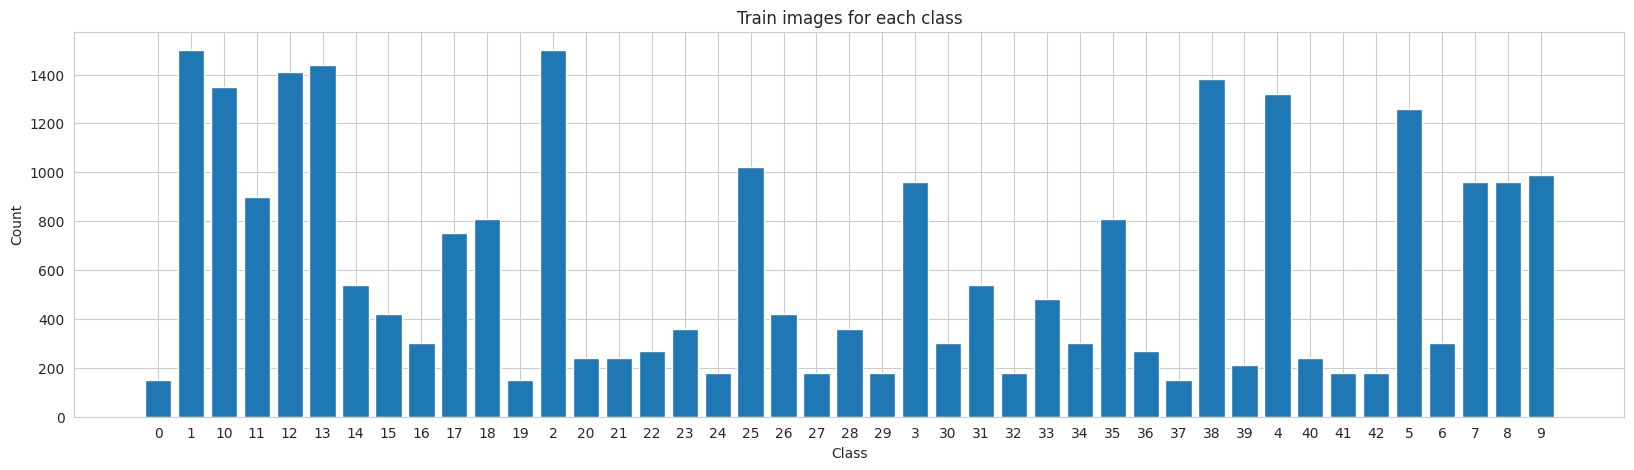

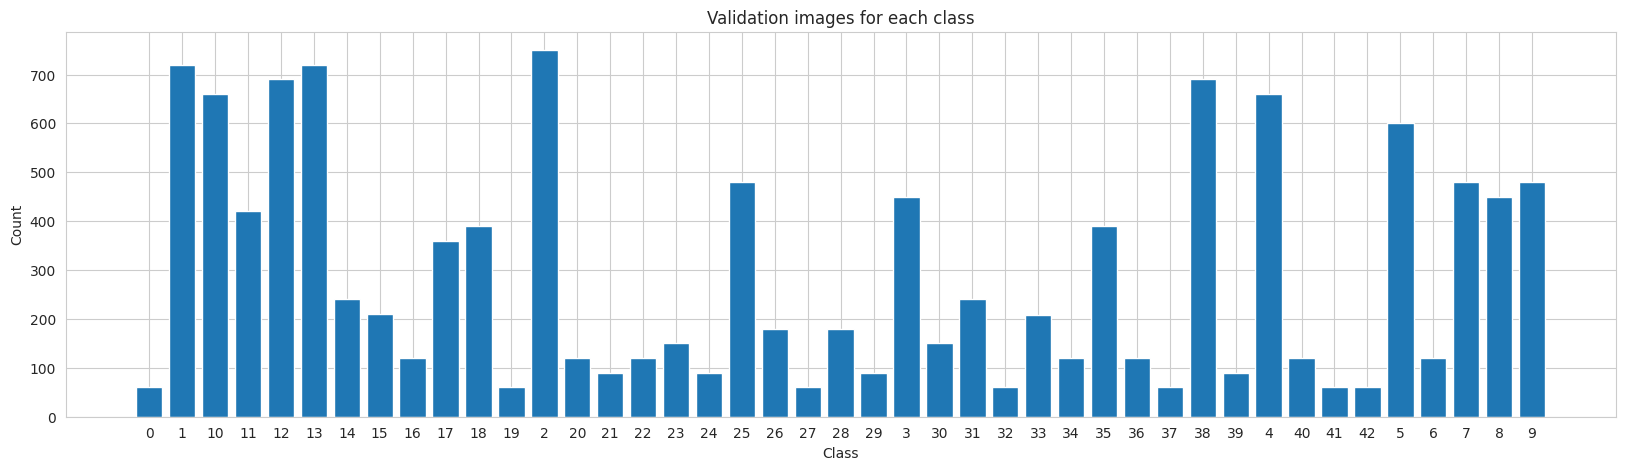

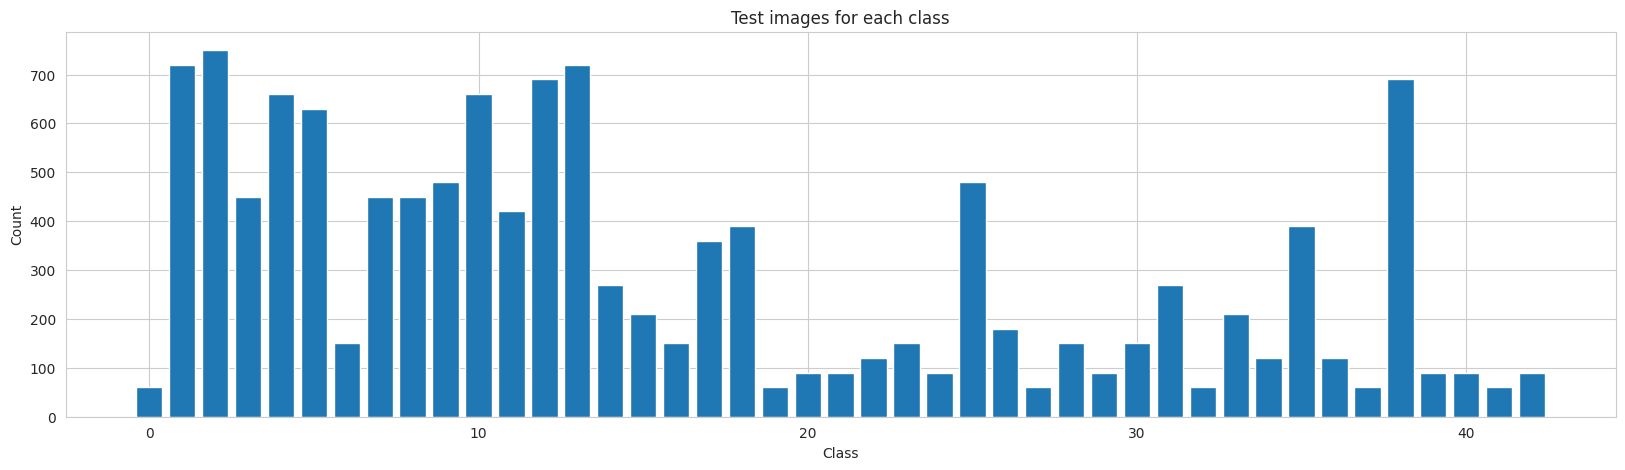

In [ ]:
def plot_set_balancing(set_name, counter, fig_size=(20,5)):
  """
  Plots the distribution of images in a set across different classes.

  Args:
    set_name: 'Train','Validation' or 'Test'. It's the name of the set to plot
    counter: A dictionary where the keys are class labels and the values are
            the number of images in each class
    fig_size: The size of the plot (width, height)
  """
  # Set the style of the plot to a white grid
  sns.set_style("whitegrid")
  # Create a figure with the specified size
  plt.figure(figsize=fig_size)
  # Set the title of the plot
  plt.title(f"{set_name} images for each class")
  # Label the x-axis and y-axis
  plt.xlabel("Class")
  plt.ylabel("Count")
  # Create a bar chart of the number of images in each class
  plt.bar(counter.keys(), counter.values())
  # Display the plot
  plt.show()

# Training set
plot_set_balancing("Train", total_train_imgs)

# Validation set
plot_set_balancing("Validation", total_validation_imgs)

# Test set
plot_set_balancing("Test", test_counter)


The class distribution in the Train and Validation sets was not distorted.
Test set presents a different distribution of images per class.
Let's now balance the classes in the three sets.

___
**Balancing**

As preliminary phase, let's create the same structure of subfolders present in 'Train' also in the 'Test' folder to simplify the subsequent operations that will be performed on the images of both sets

In [ ]:
grouped_df = test_df.groupby('ClassId')

for class_name in grouped_df.groups.keys():
  # For each class, create an associated directory if it does not already exist
  if not os.path.exists(os.path.join(LOCAL_RAW_DIR, 'Test', str(class_name))):
    os.makedirs(os.path.join(LOCAL_RAW_DIR, 'Test', str(class_name)))
  # Move the images of that class to the associated directory
  for img_path in grouped_df.get_group(class_name)['Filename'].values:
    img_path = img_path.replace(".ppm",".png")
    img_name = img_path.removeprefix('Test/')
    old_img_path = os.path.join(LOCAL_RAW_DIR,'Test',img_name)
    new_img_path = os.path.join(LOCAL_RAW_DIR, 'Test', str(class_name),img_name)
    move(old_img_path, new_img_path)

# Delete CSV files to save space
! rm {LOCAL_RAW_DIR}/*.csv

Let's look at the size of the Train, Validation and Test images

In [ ]:
def evaluate_img_size(set_name, n_printed):
  """
  Evaluates the size of the images in the specified datasets.
  Prints n_printed image sizes.

  Args:
    set_name: 'Train','Validation' or 'Test'. It's the name of the dataset directory to evaluate
    n_printed: Maximum number of printed sizes
  """

  # Initialize lists to store the image sizes of the sets
  img_size = []

  # Iterate over the specified set images and add their sizes to the list
  dir = os.path.join(LOCAL_RAW_DIR,set_name)
  for class_name in os.listdir(dir):
    if class_name.startswith("."):
      continue
    class_dir = os.path.join(dir, class_name)
    for img in os.listdir(class_dir):
      if img.startswith("."):
        continue
      img_size.append(Image.open(os.path.join(class_dir,img)).size)

  # Print only the different images size
  print(f"{set_name} images size:")
  print(list(sorted(set(img_size)))[:n_printed])


evaluate_img_size("Train",5)
evaluate_img_size("Validation",5)
evaluate_img_size("Test",5)

Train images size:
[(25, 25), (25, 26), (25, 27), (25, 28), (25, 31)]
Validation images size:
[(25, 25), (25, 26), (25, 27), (25, 28), (25, 29)]
Test images size:
[(25, 25), (25, 26), (25, 27), (25, 28), (25, 31)]


Through this analysis you can identify the need to resize all images in the Training, Validation and Test datasets to the specified dimensions. To do this it was chosen to fulfill this task in the model section at loading data phase.  Rescaling is fulfill through a layer in the model.

Let's display a sample image of a class

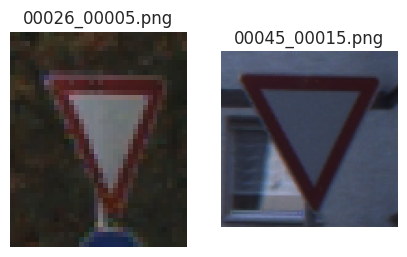

In [ ]:
def show_images(path, num_imgs, size=(5,5)):
  """
  Displays a grid of images from a specified path.

  Args:
      path: The directory containing the images to display.
      num_imgs: The number of images to display.
      size: The dimensions of the image grid.
  """

  # Create a figure with the specified size
  plt.figure(figsize=size)
  # Get the total number of images in the directory
  tot_imgs_counter = len([file for file in os.listdir(path) if not file.startswith(".")])

  # Iterate over the specified number of images
  for i in range(num_imgs):
    plt.subplot(1, num_imgs, i+1)
    # Randomly select an image from the directory
    image_name = os.listdir(path)[rn.randint(0, tot_imgs_counter - 1)]
    # Display the image in a subplot
    img = Image.open(os.path.join(path, image_name))
    plt.imshow(img)
    plt.title(image_name)
    plt.axis('off')
  plt.show()


show_images(os.path.join(LOCAL_RAW_DIR,'Train','13'), 2)

Let's define a function to create the folders in the local 'Prepared' directory that will contain the data after being processed

In [ ]:
def  create_hierarchy_subfolder (classes, dir):
  """
  Create the 'Train','Validation' and 'Test' subdirecotory. Inside it creates a directory
  for each class.

  Args:
      dir: The root directory containing new sub-directory
      classes: List of classes
  """

  # Prepared data root directory
  if not os.path.exists(dir):
    os.makedirs(dir)

  # Prepared data Train directory
  if not os.path.exists(os.path.join(dir,"Train")):
    os.makedirs(os.path.join(dir,"Train"))

  # Prepared data Train directory
  if not os.path.exists(os.path.join(dir,"Validation")):
    os.makedirs(os.path.join(dir,"Validation"))

  # Prepared data Test directory
  if not os.path.exists(os.path.join(dir,"Test")):
    os.makedirs(os.path.join(dir,"Test"))

  # Prepared classes subdirectories in 'Train','Validation' and 'Test'
  for new_dir in os.listdir(dir):
    if new_dir.startswith("."):
      continue
    sub_dir = os.path.join(dir, new_dir)
    for c in classes:
        if not os.path.exists(os.path.join(sub_dir, c)):
            os.makedirs(os.path.join(sub_dir, c))
  # Print the result hierarchy
  #! sudo apt-get install tree
  #! tree {dir}

Use a resampling technique to balance the classes. Resampling is a process that changes the distribution of classes in the dataset.

There are two main resampling techniques:
* Oversampling: This technique creates samples from underrepresented classes.
* Undersampling: This technique eliminates samples from overrepresented classes.

The resampling technique to use depends on the dataset and the model used.

In the case in question, applying oversampling techniques (SMOTE or image modification) on a dataset on which data are highly dependent on each other (as images with the same ClassId and ImageId are obtained from the same video track) in order to balance the classes would increase (in the worst case scenario) the number of images by more than 10 times.
Images with the same ClassId and ImageId are of different sizes and present more significant differences when they are taken at non-adjacent InstanceIds. In fact, the images are the result of a temporal sequence of traffic sign sampled in a video track. Initially the traffic sign will be far away (and therefore the image will be small) and gradually it will be closer and therefore clearer and larger in size.
However, the images created would be very similar and would create a high dependency between the images. This approach would lead to the creation of a dataset in which even a simple model could achieve a very high level of accuracy. However, these metrics would be untrue due to the dataset on which the model is trained and tested. This phenomenon was tested by the author of the notebook but given the low importance of the result, it was decided to omit this implementation, considering the result of the model to have no additional value beyond the conclusions that can be drawn from it and which are mentioned above.

In order to obtain a model whose evaluation metrics were more truthful, it was chosen to balance the datasets through random undersampling, thus reducing the number of 'similar' images and enhancing the differences between the images of a single class. This makes the model more robust and therefore more suitable for practical use.

It is important to balance the dataset if it is very unbalanced. An unbalanced dataset can lead to a machine learning model that is too good at classifying the most represented classes and too bad at classifying the least represented classes. This can lead to unsatisfactory results, such as low model accuracy or discrimination against certain classes.

In general, it is advisable to balance all three sets, the training set, the validation set, and the test set.


*   **Balancing the training set** is particularly important because it is the set used to train the model. A model trained on an unbalanced dataset can be too good at classifying the most represented classes and too bad at classifying the least represented classes.
*   **Balancing the validation set** can help to ensure that the model is able to generalize well to unseen data.
*   **Balancing the test set** is useful for evaluating the actual performance of the model. A model tested on a balanced dataset is more likely to provide an accurate estimate of the model's performance in the real world.

However, there are some situations where balancing by undersampling is not a feasible solution. For example, if the set is very small, it may not be possible to balance it without losing too much data.

In this case, applying undersampling still produces a considerable amount of data.


Let's define some utility functions

In [ ]:
def load_data(classes,dir):
  """
  Loads data from a directory.

  Args:
      classes: The classes list of images to load
      dir: The set directory to load data from.

  Returns:
      Dictionaries that map class names to data and labels arrays.
  """

  class_data = {}
  class_labels = {}
  for class_name in classes:
    # Analyze content for each class subdirectory
    class_dir = os.path.join(dir, class_name)
    data_list = []
    label_list = []
    for img_name in os.listdir(class_dir):
      # For each class take all the images contained in the directory
      if img_name.endswith('.png'):
          img = load_img(os.path.join(class_dir, img_name))
          img_data = img_to_array(img)
          data_list.append(img_data)
          label_list.append(img_name)

    class_data[class_name] = data_list
    class_labels[class_name] = label_list
  return class_data, class_labels


def save_data(data, labels, dir):
  """
  Saves data to a directory.

  Args:
      data: A dictionary that maps class names to data arrays.
      labels: A dictionary that maps class names to labels arrays.
      dir: The directory to save data to.
  """
  for class_name in data.keys():
    data_path = os.path.join(dir, class_name)
    for img_array, label in zip(data[class_name], labels[class_name]):
      img_path = os.path.join(data_path, label)
      img = array_to_img(img_array)
      save_img(img_path, img)


RANDOM UNDERSAMPLING

The applicable techinique that it is taken into consideration is Random Undersampling. This technique eliminates a certain number of random samples from overrepresented classes. By doing so, subfolders are created for the classes and they will contain as many images as there are images in the class with fewer images

In [ ]:
# Create a directory to contain undersampled dataset using Random Undersampling
dataset_name='RandUnder'
RAND_UNDER_DIR = os.path.join(LOCAL_PREP_DIR,dataset_name)
create_hierarchy_subfolder(classes, RAND_UNDER_DIR)

In [ ]:
def random_undersampling_data(data, labels):
  """
  Applies random undersampling to balance the dataset.

  Args:
    data: A dictionary that maps class names to data arrays.
    labels: A dictionary that maps class names to labels arrays.

  Returns:
    A dictionary that maps class names to undersampled data and labels arrays.
  """

  # Get the number of samples in the minority class
  minority_class = min(labels.keys(), key=lambda class_name: len(labels[class_name]))
  minority_class_size = len(labels[minority_class])

  # Initialize the undersampled data and labels dictionaries
  undersampled_data = {}
  undersampled_labels = {}

  # Iterate over each class
  for class_name in labels:
    # Get the number of samples in the current class
    class_size = len(labels[class_name])

    # If the class is overrepresented, randomly remove samples
    if class_size > minority_class_size:
      # Calculate the number of samples to remove
      remove_count = class_size - minority_class_size

      # Randomly remove samples
      indices = rn.sample(range(class_size), remove_count)
      undersampled_data[class_name] = [data[class_name][i] for i in range(class_size) if i not in indices]
      undersampled_labels[class_name] = [labels[class_name][i] for i in range(class_size) if i not in indices]
    else:
      # Add the class to the undersampled data and labels dictionaries
      undersampled_data[class_name] = data[class_name]
      undersampled_labels[class_name] = labels[class_name]

  return undersampled_data, undersampled_labels


# Load the training and test data
train_data, train_labels = load_data(classes, os.path.join(LOCAL_RAW_DIR,'Train'))
validation_data, validation_labels = load_data(classes, os.path.join(LOCAL_RAW_DIR,'Validation'))
test_data, test_labels = load_data(classes, os.path.join(LOCAL_RAW_DIR,'Test'))
print("Loading completed")

# Oversample the training and test data
train_data_under, train_labels_under = random_undersampling_data(train_data, train_labels)
validation_data_under, validation_labels_under = random_undersampling_data(validation_data, validation_labels)
test_data_under, test_labels_under = random_undersampling_data(test_data, test_labels)
print("Undersampling completed")

# Save the oversampled data
save_data(train_data_under, train_labels_under, os.path.join(RAND_UNDER_DIR,'Train'))
save_data(validation_data_under, validation_labels_under, os.path.join(RAND_UNDER_DIR,'Validation'))
save_data(test_data_under, test_labels_under, os.path.join(RAND_UNDER_DIR,'Test'))
print("Saving completed")


Loading completed
Undersampling completed
Saving completed


___
Balancing Evaluation

Random Undersampled dataset -> Test images for each class:


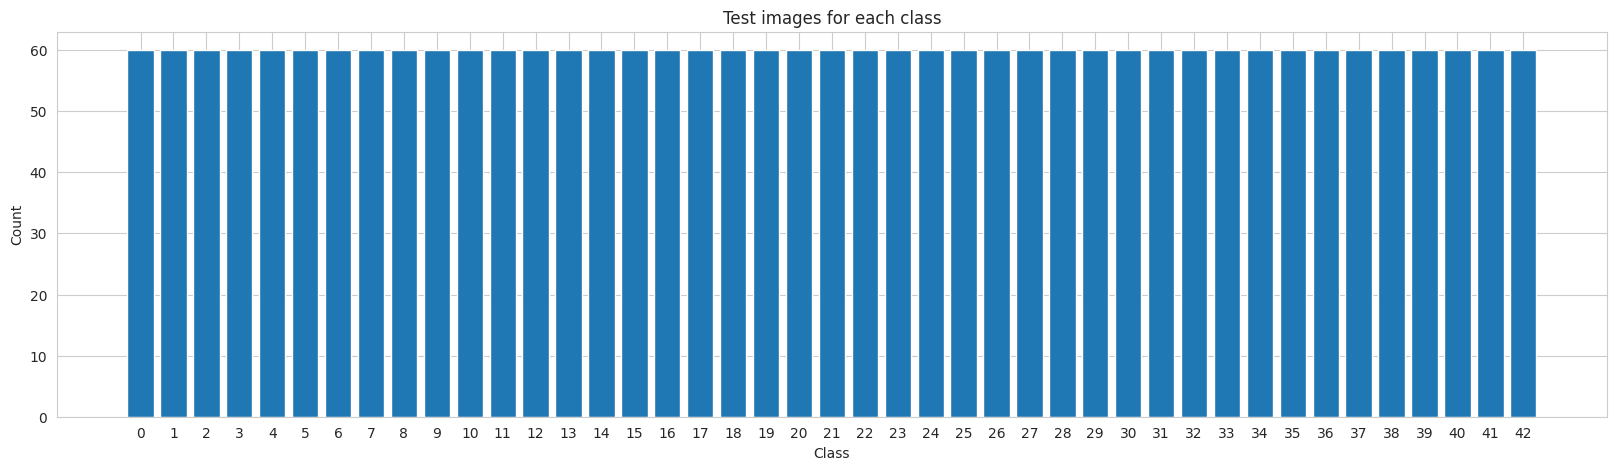

Random Undersampled dataset -> Validation images for each class:


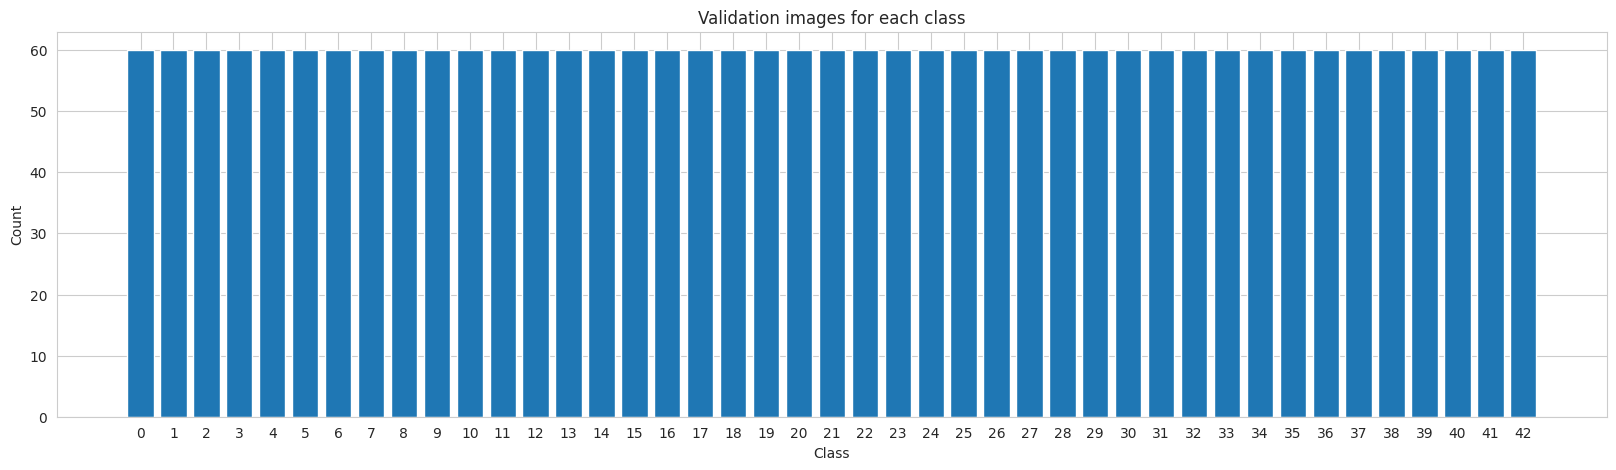

Random Undersampled dataset -> Train images for each class:


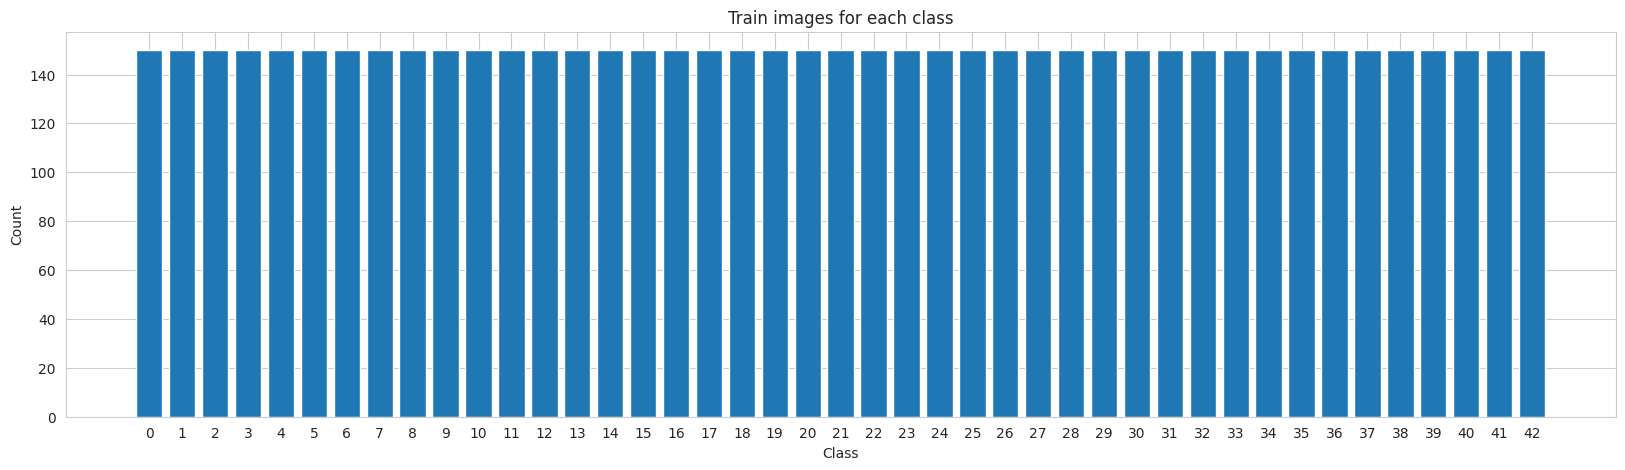

In [ ]:
# Count the number of images for each class in undersampled dataset
counter = Counter()

# For the obtained undersampled dataset
dataset_path = os.path.join(LOCAL_PREP_DIR,dataset_name)
for set_name in os.listdir(dataset_path):
  if set_name.startswith("."):
    continue
  # For Train, Validation and Test
  set_path = os.path.join(dataset_path,set_name)
  for class_name in [c for c in os.listdir(set_path) if not c.startswith(".")] :
    counter[class_name] = len([i for i in os.listdir(os.path.join(set_path,class_name)) if not i.startswith(".")])

  # Reordering the dictionary by key as integer
  counter = dict(sorted(counter.items(), key=lambda item: int(item[0])))

  # Plot the set composition to evaluate the balancing
  print(f"Random Undersampled dataset -> {set_name} images for each class:")
  plot_set_balancing(set_name, counter)

Delete raw data to save space

In [ ]:
! rm -r {LOCAL_RAW_DIR}/*

ZIP the prepared datasets, save them locally and also on DRIVE folder

In [ ]:
# Create a zip file with the content of the directory.
# Use the same name of the directory for the zip file.
! cd {LOCAL_PREP_DIR} && zip -r {dataset_name} {dataset_name} > /dev/null
print(f"Zip file {dataset_name} created in {LOCAL_PREP_DIR}")

# Save zip file in the prepared data directory
! cd {LOCAL_PREP_DIR} && cp *.zip {PREPARED_DATA_DIR}

# Remove zip file from local directory
! rm {dataset_path}.zip

Zip file RandUnder created in /content/data/Prepared


__________________________________________________________

# **MODELS**

Let's now create different models to train on the dataset obtained by means undersampling technique. The aim is to evaluate which of the model will obtain the best performance. This model will then be compared in performance with a pretrained model

Let's define some utility functions

In [7]:
def copy_and_unzip_prepared_set (set_name):
  """
    This function copies the prepared set zip file from Drive to the local prepared
    data directory, unzips it, and then removes the zip file.

    Args:
        set_name: The name of the prepared set.
    """
  if not os.path.exists(os.path.join(LOCAL_PREP_DIR, set_name)):
    # Copy the zip file from Drive
    print(f"Copying {set_name} zip file from Drive...")
    ! cp {PREPARED_DATA_DIR}/{set_name}.zip {LOCAL_PREP_DIR}
    print(f"{set_name} zip file copied to local directory.")

    # Unzip the file and remove the zip file
    ! unzip -q {LOCAL_PREP_DIR}/{set_name}.zip  -d {LOCAL_PREP_DIR}
    ! rm {LOCAL_PREP_DIR}/{set_name}.zip
  else:
    print(f"{set_name} zip file already loaded locally")


# Returns Train, Val and Test sets.
# Some parameters are omitted as we rely on their default values.
# Please see the documentation for more details
def load_datasets(train_dir, validation_dir, test_dir, batch_size=BATCH_SIZE, size=(CUSTOM_IMAGE_DIM,CUSTOM_IMAGE_DIM)):
  """
  Load the train, validation, and test datasets from the specified directories

  Args:
      train_dir: The path to the directory containing the training data.
      validation_dir: The path to the directory containing the validation data.
      test_dir: The path to the directory containing the test data.
      batch_size: The batch size for the training, validation, and test data.
      size: The size of the images to load.

  Returns:
      train_dataset: The training data.
      validation_dataset: The validation data.
      test_dataset: The test data.
  """

  # Load the train dataset
  train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                            train_dir,
                                            label_mode='categorical',
                                            batch_size=batch_size,
                                            seed=RANDOM_SEED,
                                            image_size=size
                                        )

  # Load the validation dataset
  validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                            validation_dir,
                                            label_mode='categorical',
                                            batch_size=batch_size,
                                            seed=RANDOM_SEED,
                                            image_size=size
                                        )

  # Load the test dataset
  test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                            test_dir,
                                            label_mode='categorical',
                                            batch_size=batch_size,
                                            seed=RANDOM_SEED,
                                            image_size=size
                                        )

  # Return the loaded datasets
  return train_dataset, validation_dataset, test_dataset


# Returns some details about trained model
def train_performance(history):
  """
  Plots the training and validation accuracy and loss for a given history object.

  Args:
      history: A history object obtained from a Keras model fit.
  """
  # Extract the training and validation accuracy and loss from the history object
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(train_acc))

  # Plot the training and validation accuracy
  plt.figure()
  plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plot the training and validation loss
  plt.figure()
  plt.plot(epochs, train_loss, 'ro', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Display the plots
  plt.show()


def show_and_save_model_summary(model):
  """
  This function displays and saves the summary of a given Keras model.

  Args:
      model: The Keras model whose summary should be displayed and saved.

  """
  model.summary()
  file_name = os.path.join(MODELS_SCHEMES_DIR,model.name) + ".png"
  plot_model(model, show_layer_names=False, show_layer_activations=True, show_shapes=True, to_file = file_name)


def compile_and_fit(model, train_dataset, validation_dataset, epochs = EPOCHS, early_stop = True):
  """
  This function compiles and fits a given Keras model, optionally using early stopping and model checkpointing.

  Args:
      train_dataset: The training dataset.
      model: The Keras model to compile and fit.
      validation_dataset: The validation dataset.
      epochs: The number of epochs to train for.
      early_stop: Whether to use early stopping to terminate training early.

  Returns:
      The trained model history object.

  """
  # Create a list to store callbacks
  callbacks_list = []

  # Enable early stopping if specified
  if early_stop:
    # Create an EarlyStopping callback to terminate training early if the validation loss does not improve.
    callbacks_list.append(callbacks.EarlyStopping(monitor = 'val_loss',
                                                  patience = 5))

  # Create a checkpoint callback to save the model with the best validation loss
  checkpoint_name = model.name + ".h5"
  modelPath = os.path.join(MODELS_DIR, checkpoint_name)

  checkpoint = callbacks.ModelCheckpoint(filepath = modelPath,
                                          monitor = 'val_loss',
                                          verbose = 1,
                                          mode ='min',
                                          save_best_only = True)
  callbacks_list.append(checkpoint)

  # Compile and fit the model
  model.compile(loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adam(LEARNING_RATE),
            metrics=['accuracy'])

  return model.fit(
          train_dataset,
          epochs=epochs,
          validation_data=validation_dataset,
          callbacks=callbacks_list)


def test_evaluation(model, test_dataset):
  """
  This function evaluates the performance of a pre-trained model on the test dataset.

  Args:
      model: The pre-trained Keras model.
      test_dataset: The test dataset.
  """
  # Collect test data and labels
  data, labels = [], []

  # Iterate over the test dataset and append data and labels to respective lists
  for data_batch, labels_batch in test_dataset:
    data.append(data_batch)
    labels.append(labels_batch)

  # Concatenate the data and labels into a single array
  data = tf.concat(data, axis=0)
  labels = tf.concat(labels, axis=0)

  # Load the pre-trained model from the specified location
  checkName = model.name + ".h5"
  modelPath = os.path.join(MODELS_DIR, checkName)
  model = models.load_model(modelPath)

  # Evaluate the model performance on the test data
  test_results = model.evaluate(data, labels, verbose=1)

  # Extract predicted labels from the model's predictions
  y_score = model.predict(data)

  # Display the test results, including accuracy, precision, recall, and F1-score
  show_test_results(y_score, labels, test_results)


def plot_confusion_matrix(y_true, y_pred):
  """
  This function generates a confusion matrix to visualize the performance of the model on the test data.

  Args:
      y_true: The true labels for the test data.
      y_pred: The predicted labels for the test data.

  """
  # Compute the confusion matrix
  conf_mat = confusion_matrix(y_true, y_pred)
  # Create a ConfusionMatrixDisplay object
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
  # Increase the plot size to accommodate the large number of classes
  plt.rcParams['figure.figsize'] = [25, 25]
  # Display and show the confusion matrix plot
  disp.plot()
  plt.show()


def plot_ROC_curve(y_true, y_score):
  """
  This function generates a ROC (Receiver Operating Characteristic) curve to
  visualize the performance of the model at distinguishing between different
  classes on the test data.

  Args:
      y_true: The true labels for the test data.
      y_score: The predicted probabilities for the test data.

  """
  # Compute ROC curve and AUC for each class
  # Calculate the false positive rate (FPR) and true positive rate (TPR) for
  # each class using the receiver operating characteristic (ROC) curve method
  n_classes = 43
  fpr = [0] * n_classes
  tpr = [0] * n_classes
  roc_auc = [0] * n_classes
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Plot all ROC curves in a single plot
  # Create a figure and plot each ROC curve individually
  plt.figure()
  for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]})')

  # Add reference line for random guessing
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
  # Set the x and y limits
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  # Set the labels for the axes
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  # Set the title of the plot
  plt.title('Multi-Class ROC Curves (One-vs-Rest strategy)')
  # Arrange the legend in a matrix format
  plt.legend(ncol=5, loc='lower right')
  # Show the ROC curve plot
  plt.show()


def show_test_results(y_score, labels, test_results):
  """
  This function summarizes the performance of the model on the test data,
  including classification report, confusion matrix, and ROC curve.

  Args:
      y_score: The predicted probabilities for the test data.
      labels: The true labels for the test data.
      test_results: A tuple containing the loss and accuracy metrics obtained from the test evaluation.

  """
  # From list to Numpy array
  y_true = np.asarray(labels)

  # Convert one-hot encoded predictions to integer labels to check if the predicted label agrees with the ground-truth
  # Convert the predicted probabilities into integer labels by selecting the index with the highest probability for each sample.
  y_pred = np.argmax(y_score, axis=1)
  y_test = np.argmax(y_true, axis=1)

  # Print classification report
  print("Classification report: ")
  print(classification_report(y_test,y_pred ,digits = 4))

  # Plot confusion matrix
  print("Confusion matrix:")
  plot_confusion_matrix(y_test, y_pred)

  # Plot ROC Curve
  bin_y_test = label_binarize(y_test, classes=range(43))
  print("ROC Curve:")
  plot_ROC_curve(bin_y_test, y_score)

  # Test results
  print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

  # Tok-k accuracy
  k=3
  top_k_result = top_k_accuracy_score(y_test,y_score, k=k)
  print(f"Top-K (K = {k}) accuracy score: {top_k_result}")


If it is not already present, let's copy and unzip locally the zip file containing the dataset of interest

In [8]:
set_name= "RandUnder"
copy_and_unzip_prepared_set(set_name)
WORK_DIR= os.path.join(LOCAL_PREP_DIR,set_name)

Copying RandUnder zip file from Drive...
RandUnder zip file copied to local directory.


The following snippet provides the commands to clean the Drive from models and related schemes already present from previous executions

In [ ]:
#! rm -r {MODELS_SCHEMES_DIR}/*.png
#! rm -r {MODELS_DIR}/*.h5

___

Let's try to tune hyperparameters with a starting base model

In [ ]:
def build_model(hp):
  """
  Define model architecture

  Args:
      hp: An hyperparameters object that is used to specify the parameters of the neural network.

  Returns:
      A compiled Keras model.
  """

  # Define hyperparameters
  # Kernel dimension
  kernel_size = hp.Int('kernel_size', min_value=2, max_value=4, step=1)
  # Optimizer
  opt_index = hp.Choice('optimizer', values=[0,1,2])
  learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4, 1e-5])
  # Assign optimizer based on index and pass learning rate parameter
  if opt_index == 0:
    optimizer = keras.optimizers.RMSprop(learning_rate)
  elif opt_index == 1:
    optimizer = keras.optimizers.Adam(learning_rate)
  else:
    optimizer = keras.optimizers.SGD(learning_rate)

  # Model architecture's layers
  input = keras.Input(shape=CUSTOM_INPUT_SHAPE)
  x = layers.Rescaling(1./255)(input)

  x = layers.Conv2D(filters=32, kernel_size = kernel_size, activation='relu')(x)
  x = layers.MaxPooling2D(pool_size=2)(x)

  x = layers.Conv2D(filters=64, kernel_size = kernel_size, activation='relu')(x)
  x = layers.MaxPooling2D(pool_size=2)(x)

  x = layers.Conv2D(filters=128, kernel_size = kernel_size, activation='relu')(x)
  x = layers.MaxPooling2D(pool_size=2)(x)

  x = layers.Flatten()(x)
  output = layers.Dense(43, activation='softmax')(x)

  # Create and compile the model. Optimizer to use is an hyperparameter
  model = keras.Model(inputs=input, outputs=output, name="Model")

  model.compile(optimizer=optimizer,
          loss='categorical_crossentropy',
          metrics=['accuracy'])

  return model


# Load dataset
train_dir = os.path.join(WORK_DIR,"Train")
validation_dir = os.path.join(WORK_DIR,"Validation")
test_dir = os.path.join(WORK_DIR,"Test")

train, validation, test = load_datasets(train_dir, validation_dir, test_dir)

# Define the Hyperband tuner
log_dir='/content/data/hyperband'

tuner = kt.Hyperband(
  build_model,
  overwrite=True,
  objective='val_loss',
  directory=log_dir,
  project_name='hyperparams_tuning'
)

# Create TensorBoard and EarlyStopping callbacks
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

tensorboard = keras.callbacks.TensorBoard(log_dir)

callbacks_list=[]
callbacks_list.append(callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights=True))
callbacks_list.append(tensorboard)

# Perform the hyperparameters search
tuner.search(train, epochs=EPOCHS, validation_data=validation, callbacks=callbacks_list)

Trial 32 Complete [00h 00m 11s]
val_loss: 3.6093056201934814

Best val_loss So Far: 0.5076057314872742
Total elapsed time: 00h 06m 06s


In [ ]:
tuner.results_summary(num_trials=5)

Results summary
Results in /content/data/hyperband/hyperparams_tuning
Showing 5 best trials
Objective(name="val_loss", direction="min")

Trial 0016 summary
Hyperparameters:
kernel_size: 4
optimizer: 1
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.5076057314872742

Trial 0029 summary
Hyperparameters:
kernel_size: 4
optimizer: 0
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.6164296269416809

Trial 0003 summary
Hyperparameters:
kernel_size: 3
optimizer: 1
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.8111714124679565

Trial 0020 summary
Hyperparameters:
kernel_size: 3
optimizer: 0
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 1.063546895980835

Trial 0015 summary
Hyperparameters:
kernel_size: 2
optimizer: 1
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/br

The result of hyperparameter tuning is:
* Best Kernel Size: 4
* Best Optimizer: Adam
* Best Learning Rate: 1e-3

This values are stored as global variables in Environment Initialization section at the beginning of this notebook or in the 'compile_and_fit' function code.

___
1) Base Model from hyper-parameters tuning

The model is composed as follow:

* 3 Conv2d-MaxPooling2D layers (32,64,128)
* No Dropout, Regularization or Hidden Dense layers

In [ ]:
input = keras.Input(shape=CUSTOM_INPUT_SHAPE)
x = layers.Rescaling(1./255)(input)

x = layers.Conv2D(filters=32, kernel_size = KERNEL_SIZE, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size = KERNEL_SIZE, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size = KERNEL_SIZE, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)
output = layers.Dense(43, activation='softmax')(x)

model_base = keras.Model(inputs=input, outputs=output, name="Model_base")
show_and_save_model_summary(model_base)

Model: "Model_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 45, 45, 32)        1568      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 22, 22, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 19, 19, 64)        32832     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 9, 9, 64)          0         
 g2D)                                                   

Load the dataset, train the model and evaluate it

Found 6450 files belonging to 43 classes.
Found 2580 files belonging to 43 classes.
Found 2580 files belonging to 43 classes.
Epoch 1/30
197/202 [============================>.] - ETA: 0s - loss: 1.9483 - accuracy: 0.4721
Epoch 1: val_loss improved from inf to 0.86775, saving model to /content/drive/Shareddrives/Biondi/Models/Model_base.h5
202/202 [==============================] - 4s 14ms/step - loss: 1.9160 - accuracy: 0.4805 - val_loss: 0.8678 - val_accuracy: 0.7628


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
197/202 [============================>.] - ETA: 0s - loss: 0.3390 - accuracy: 0.9053
Epoch 2: val_loss improved from 0.86775 to 0.57017, saving model to /content/drive/Shareddrives/Biondi/Models/Model_base.h5
202/202 [==============================] - 3s 15ms/step - loss: 0.3348 - accuracy: 0.9065 - val_loss: 0.5702 - val_accuracy: 0.8450
Epoch 3/30
197/202 [============================>.] - ETA: 0s - loss: 0.1248 - accuracy: 0.9702
Epoch 3: val_loss improved from 0.57017 to 0.53654, saving model to /content/drive/Shareddrives/Biondi/Models/Model_base.h5
202/202 [==============================] - 3s 14ms/step - loss: 0.1238 - accuracy: 0.9702 - val_loss: 0.5365 - val_accuracy: 0.8787
Epoch 4/30
202/202 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.9797
Epoch 4: val_loss improved from 0.53654 to 0.47205, saving model to /content/drive/Shareddrives/Biondi/Models/Model_base.h5
202/202 [==============================] - 3s 13ms/step - loss: 0.0735 - acc

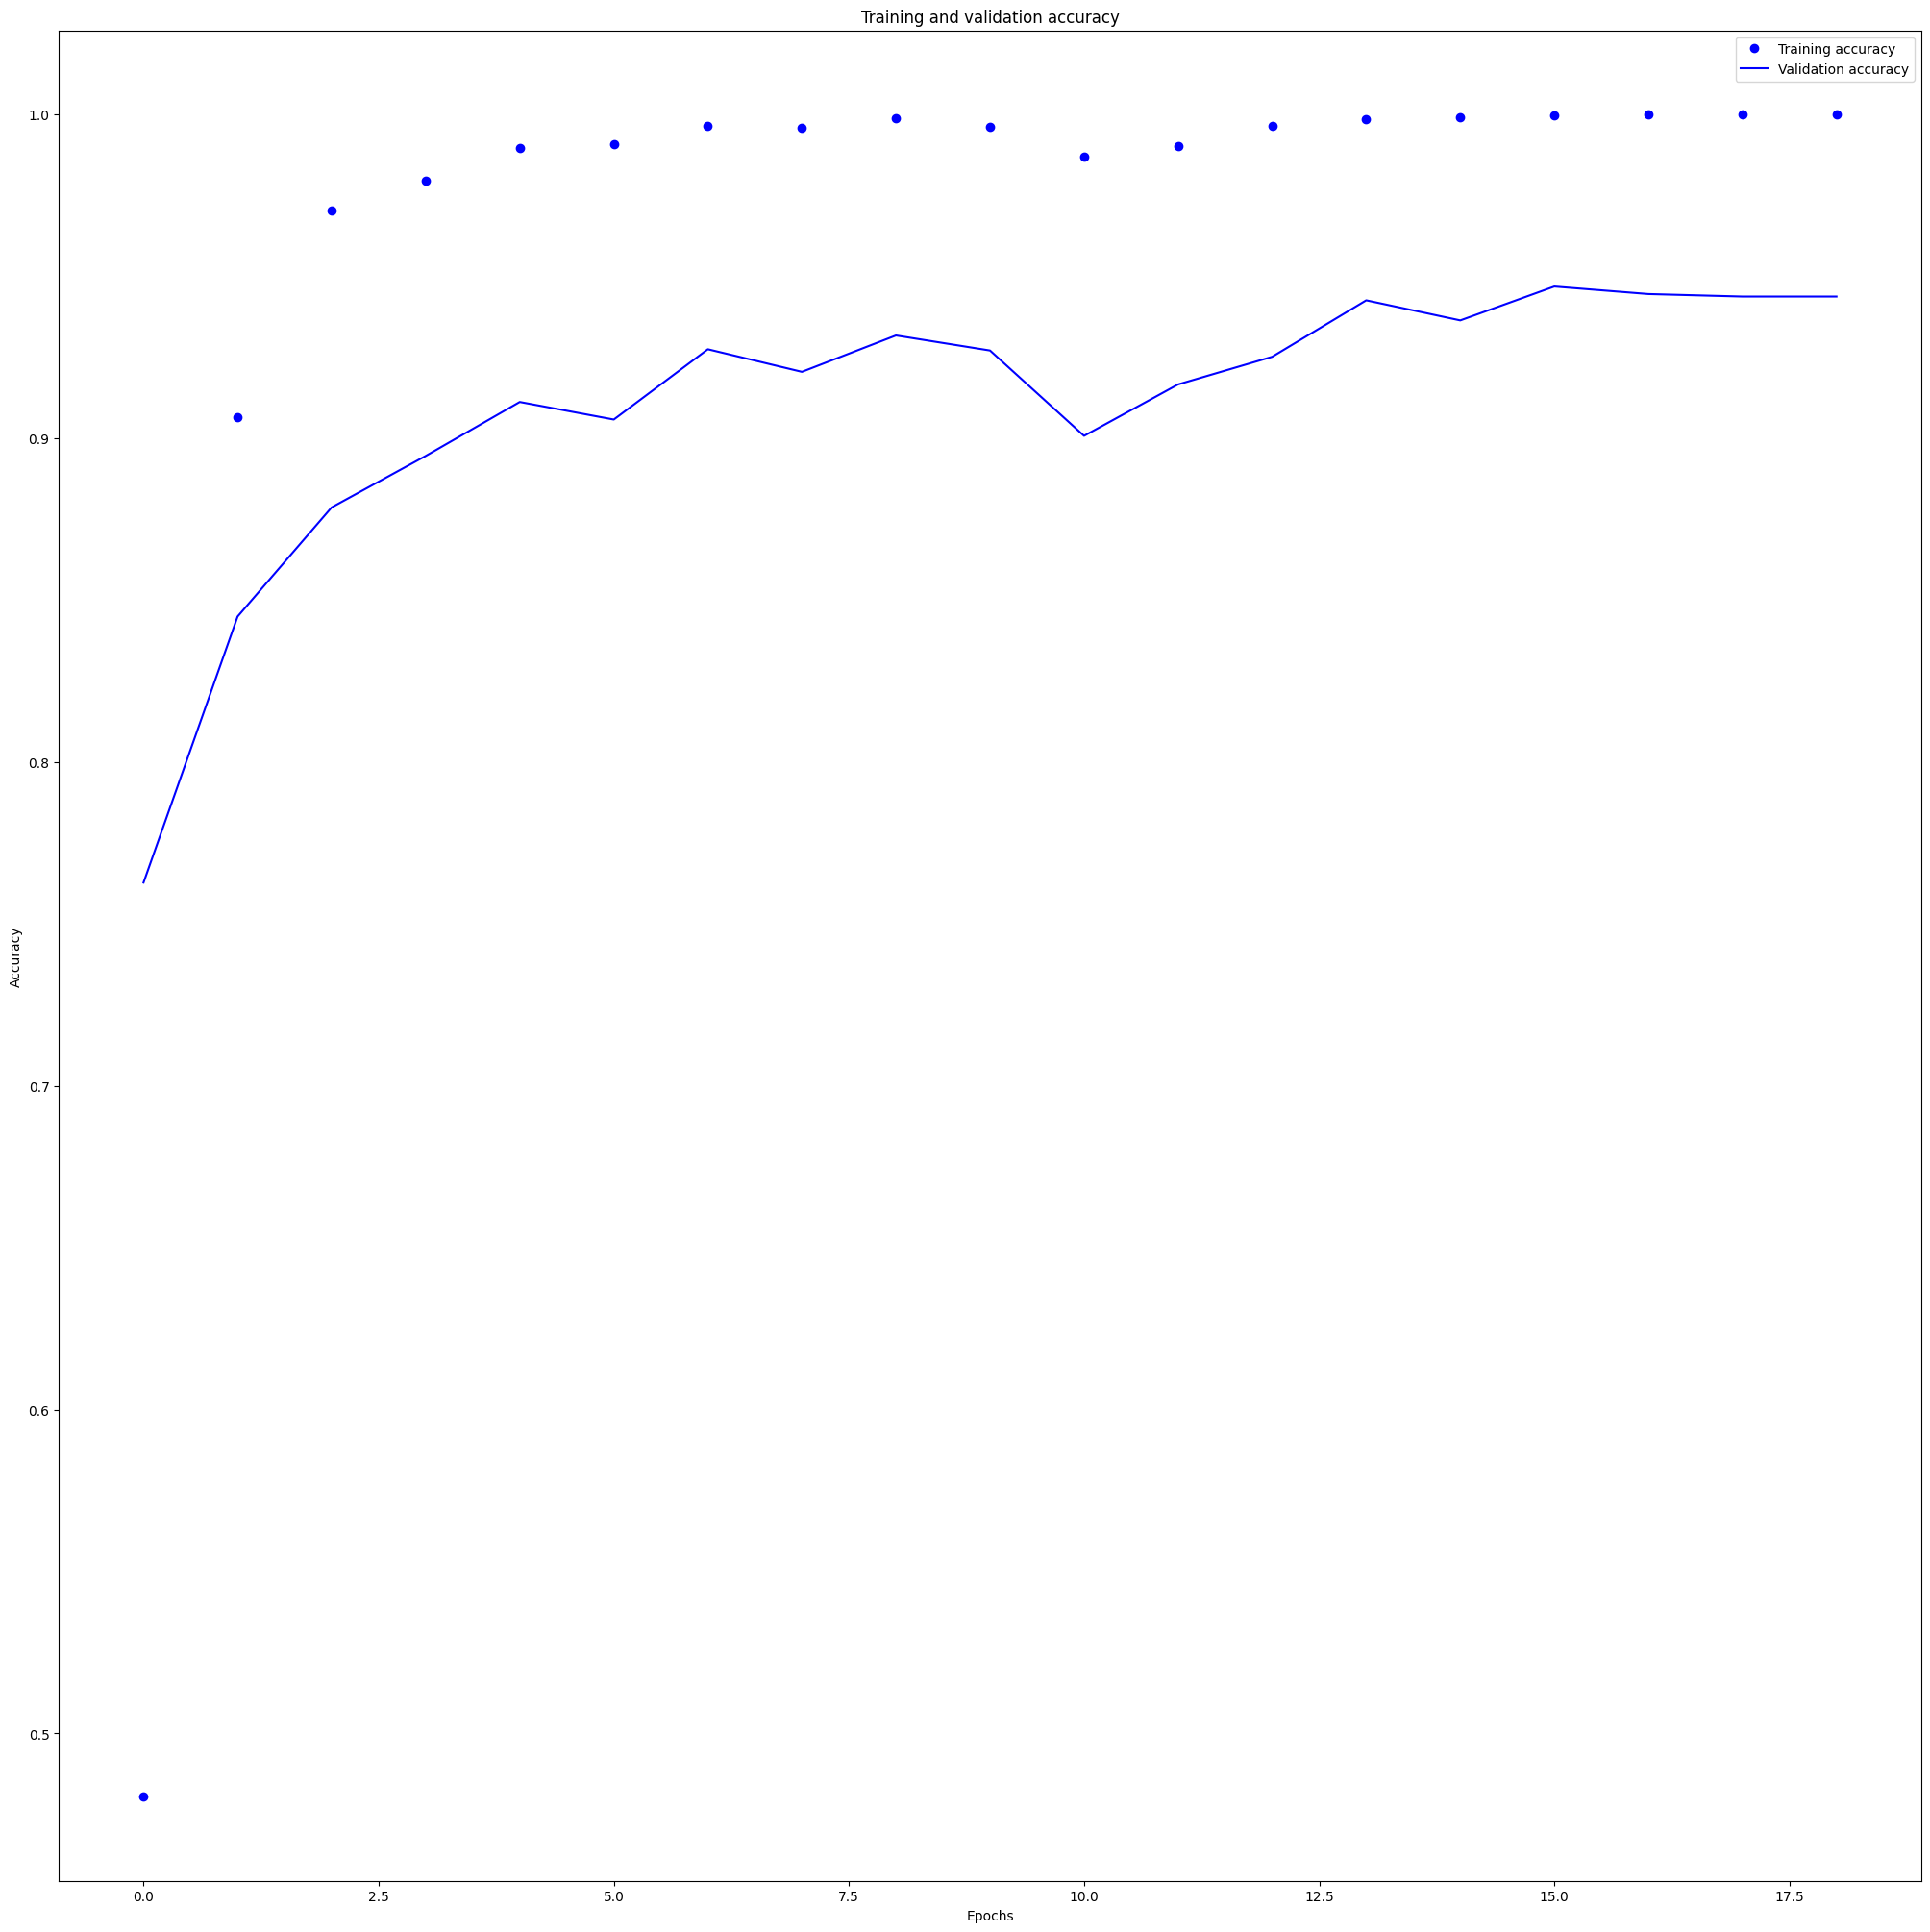

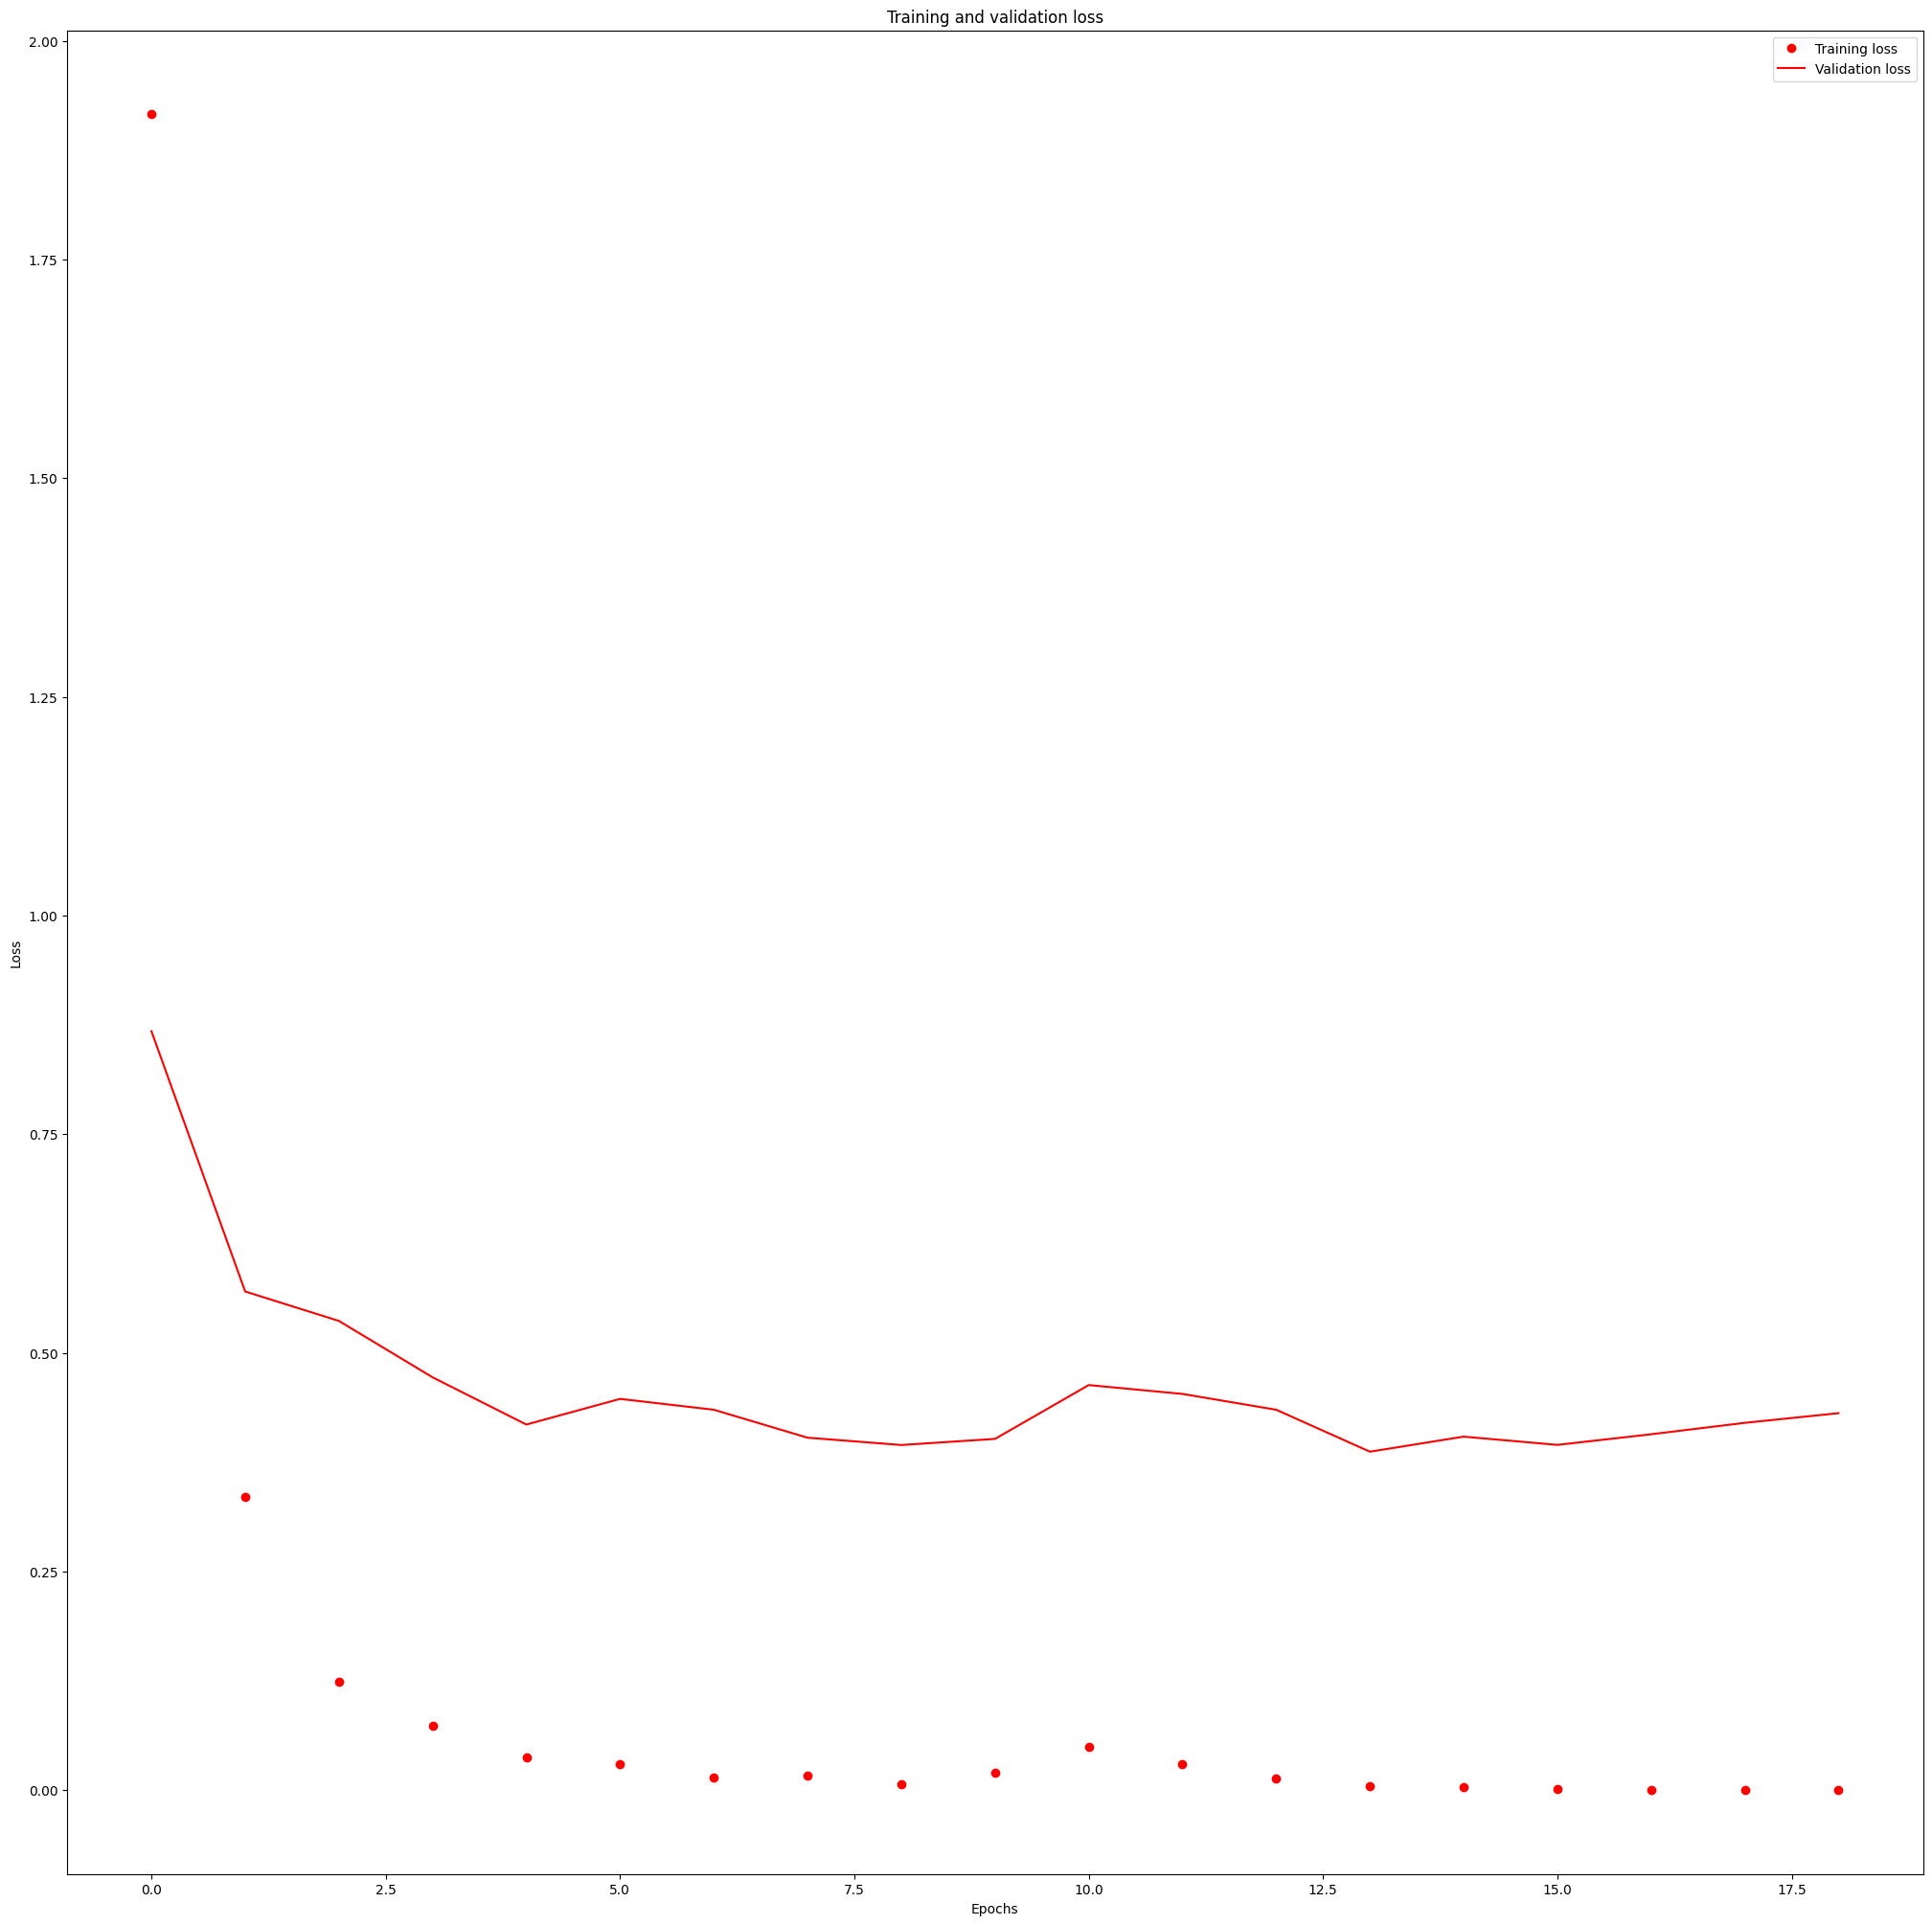

81/81 [==============================] - 0s 2ms/step
Classification report: 
              precision    recall  f1-score   support

           0     1.0000    0.8333    0.9091        60
           1     0.9365    0.9833    0.9593        60
           2     1.0000    0.9500    0.9744        60
           3     0.9032    0.9333    0.9180        60
           4     0.7407    1.0000    0.8511        60
           5     0.9677    1.0000    0.9836        60
           6     0.9677    1.0000    0.9836        60
           7     0.9524    1.0000    0.9756        60
           8     0.9833    0.9833    0.9833        60
           9     1.0000    0.9167    0.9565        60
          10     0.9483    0.9167    0.9322        60
          11     0.9333    0.7000    0.8000        60
          12     0.9661    0.9500    0.9580        60
          13     0.8310    0.9833    0.9008        60
          14     1.0000    0.6000    0.7500        60
          15     0.9333    0.9333    0.9333        60
    

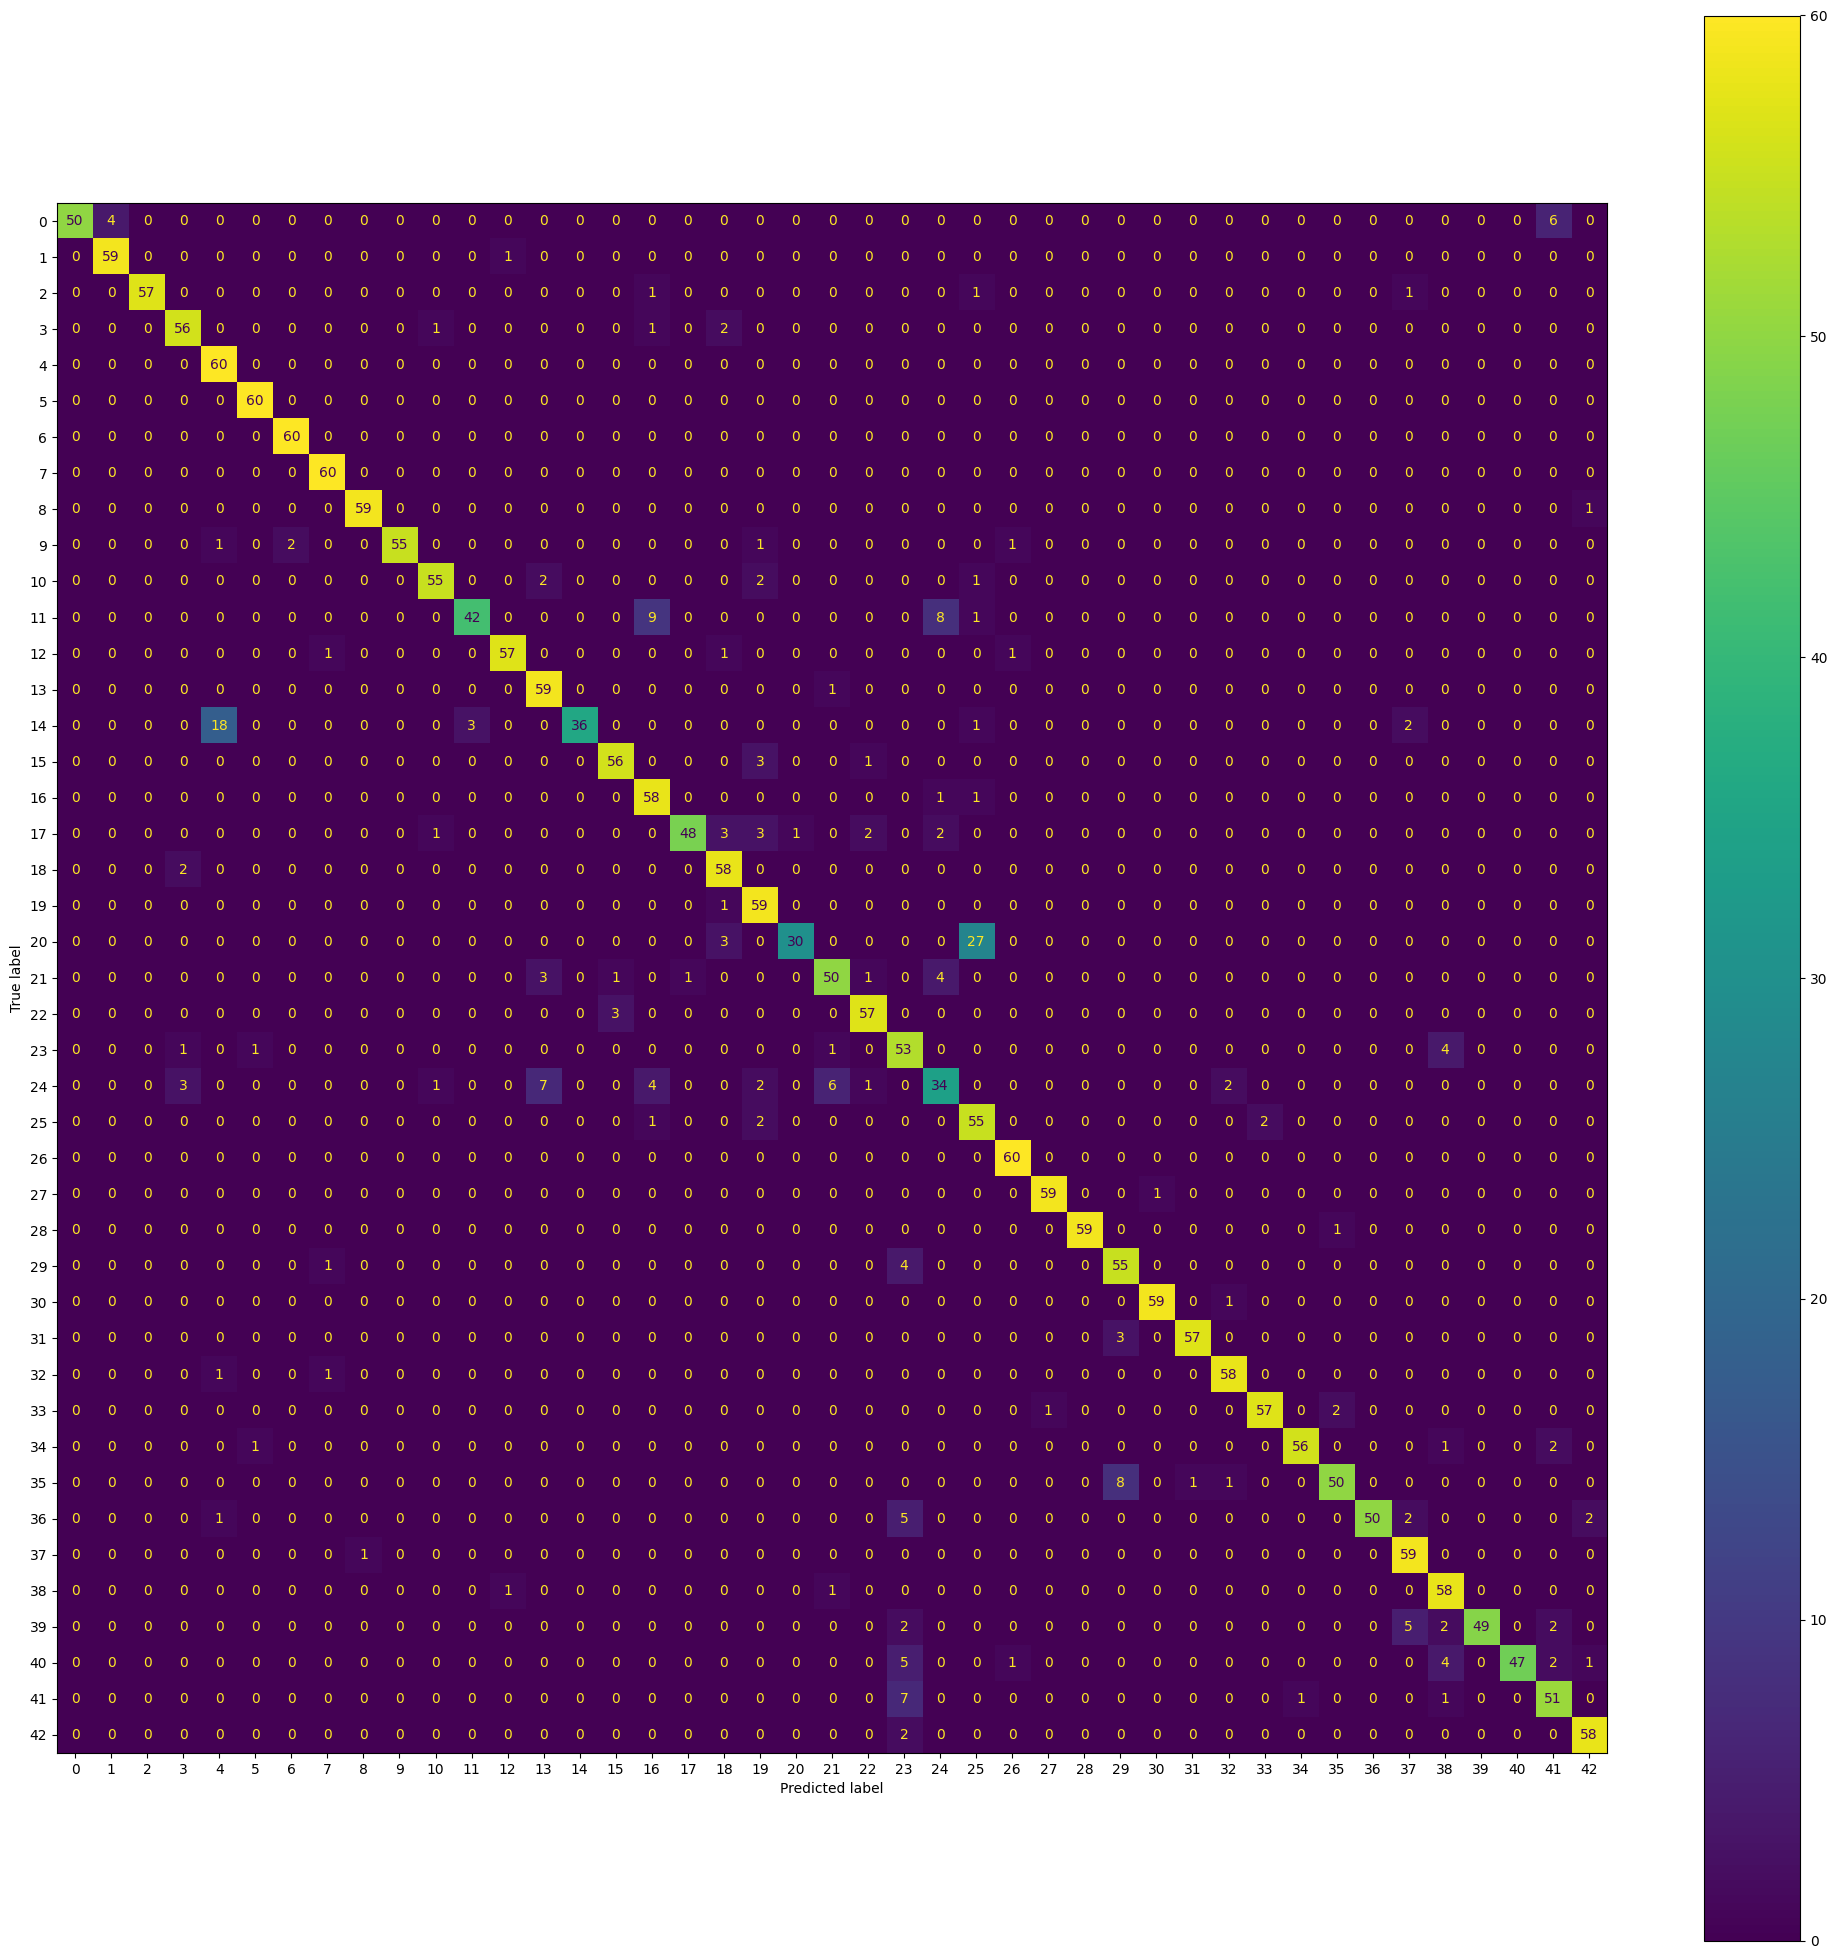

ROC Curve:


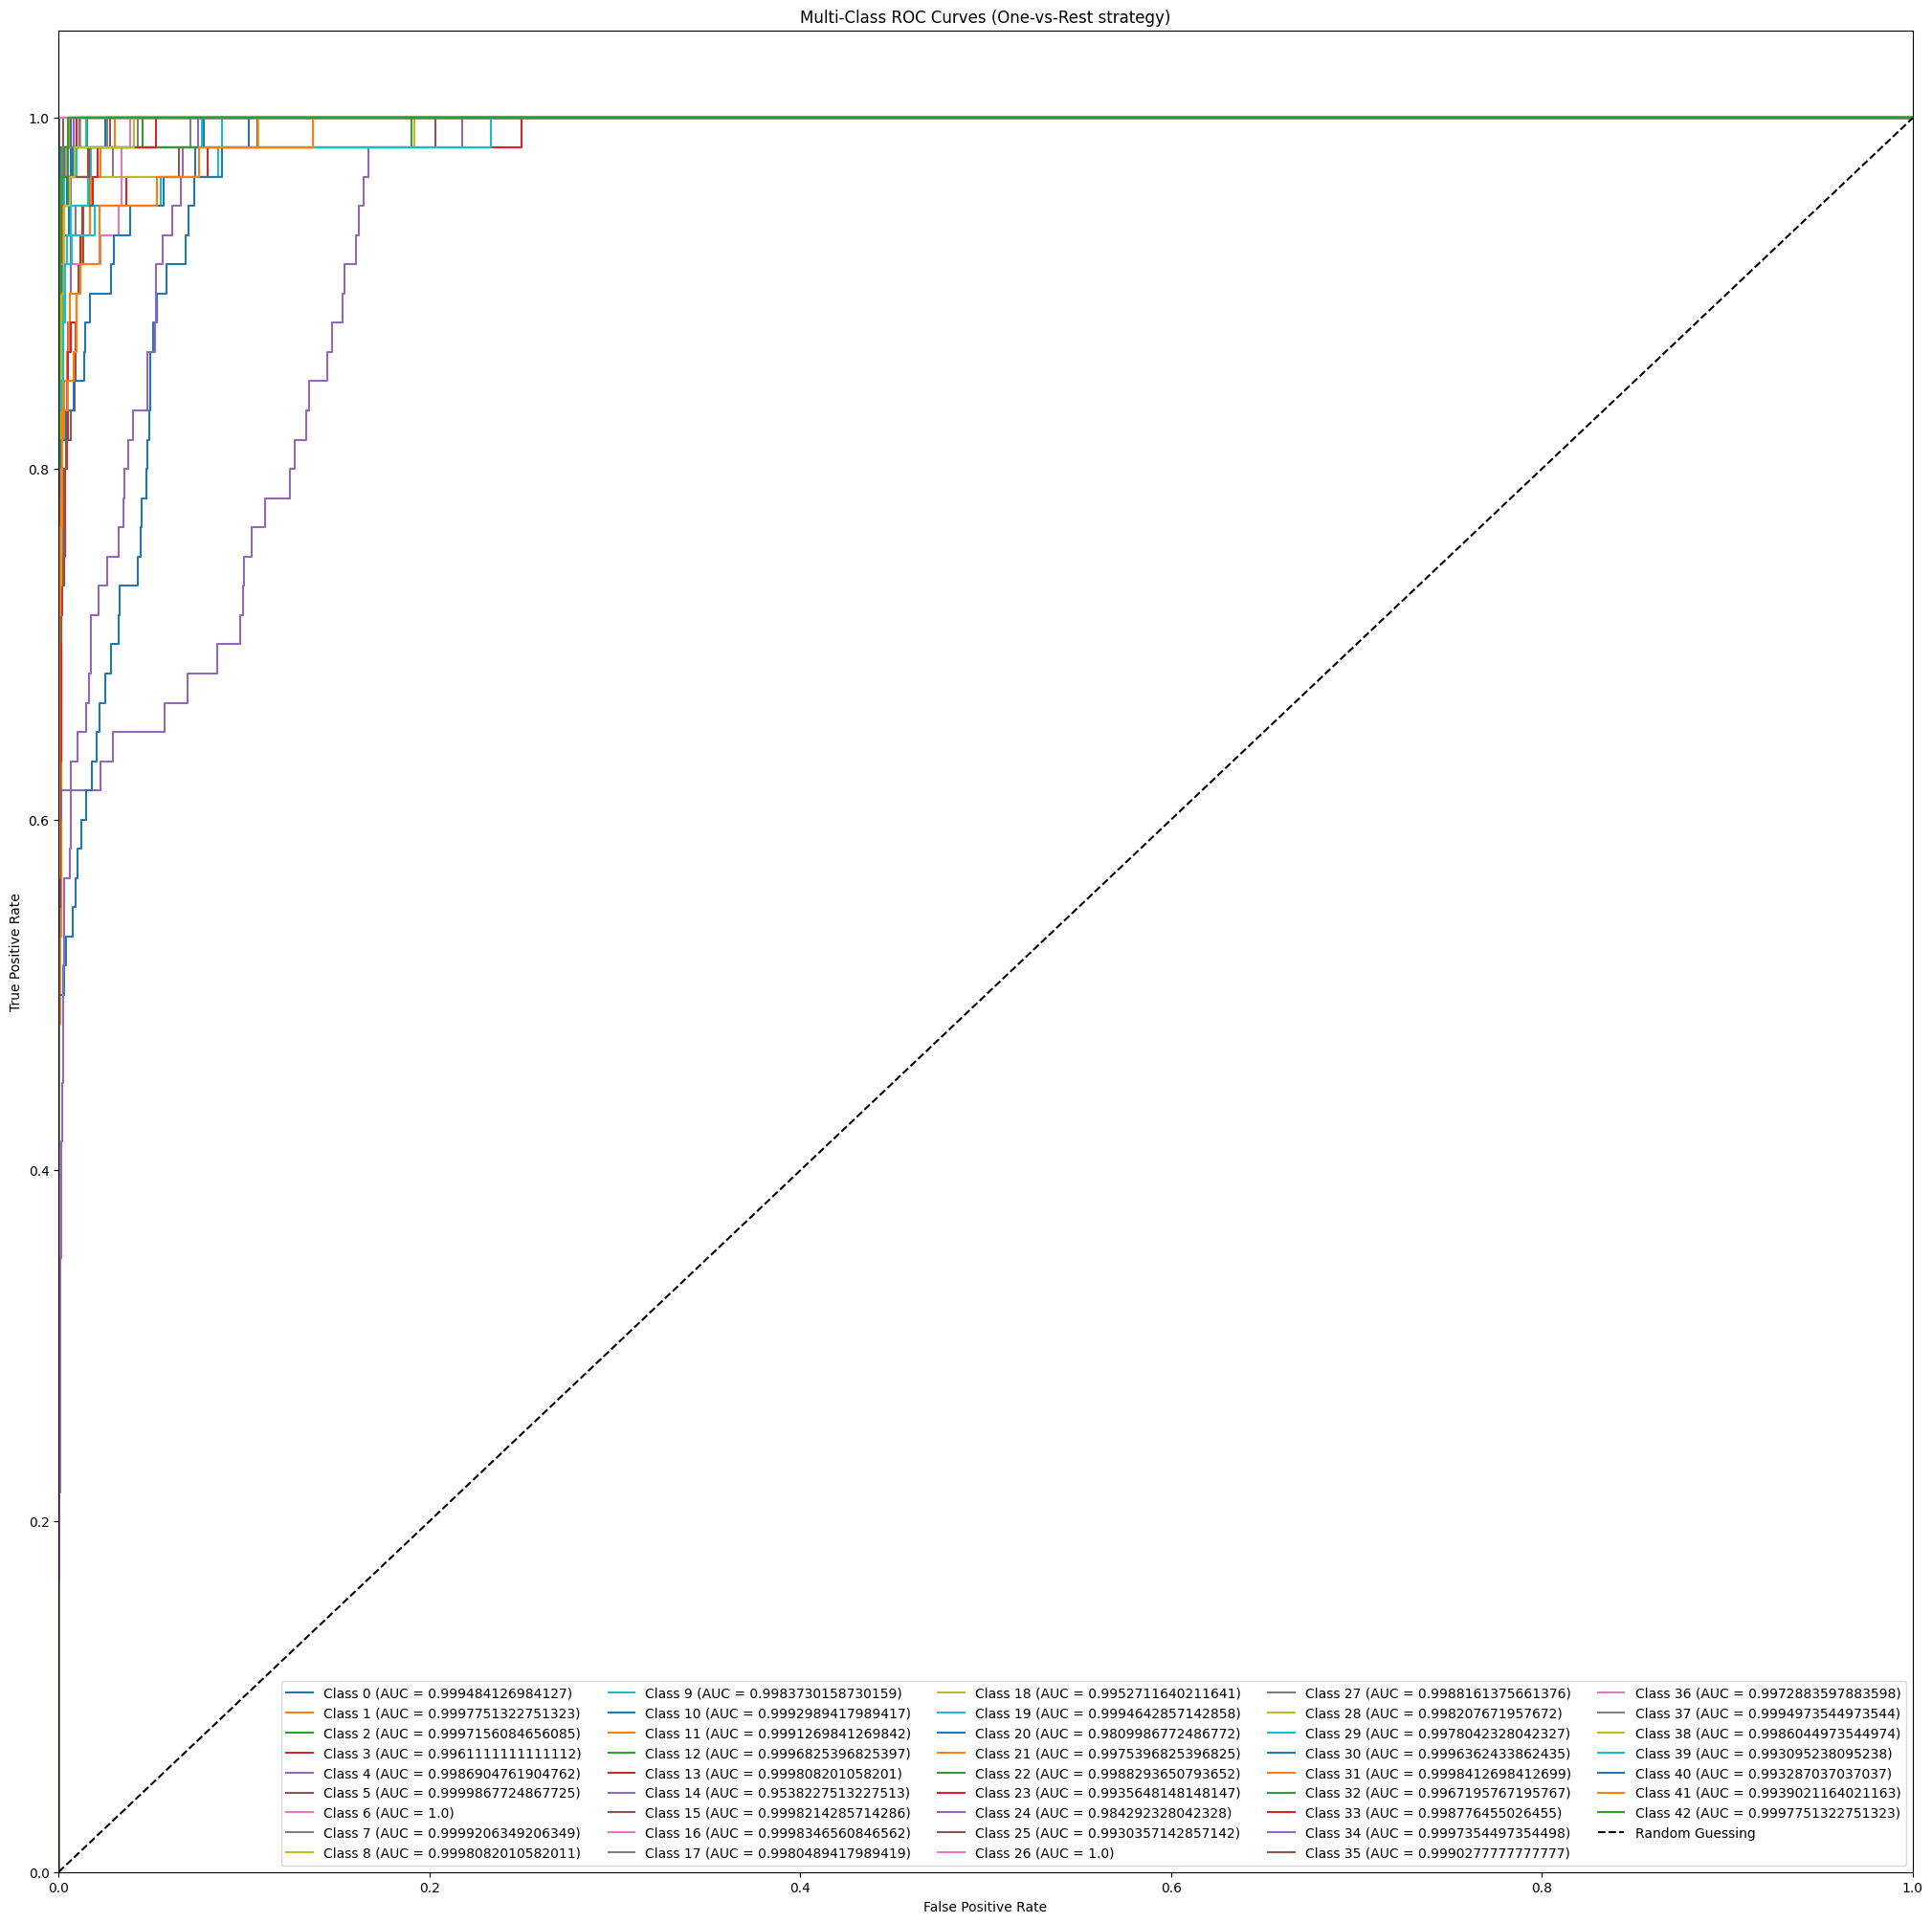

Test results - Loss: 0.7051243782043457 - Accuracy: 0.9011628031730652%
Top-K (K = 3) accuracy score: 0.9511627906976744


In [ ]:
train_dir = os.path.join(WORK_DIR,"Train")
validation_dir = os.path.join(WORK_DIR,"Validation")
test_dir = os.path.join(WORK_DIR,"Test")

train, validation, test = load_datasets(train_dir, validation_dir, test_dir)
result = compile_and_fit(model_base, train, validation)
train_performance(result)
test_evaluation(model_base, test)

The result of the base model is an accuracy of approximately 90.1% and a Top-K score of approximately 0.951. The model was trained for 19 epochs, after which the early stopping mechanism was activated for overfitting.

___
2) Model with higher number of filters

The model is composed as follow:

* 3 Conv2d-MaxPooling2D layers (64,128,256)
* No Dropout, Regularization or Hidden Dense layers

In [ ]:
input = keras.Input(shape=CUSTOM_INPUT_SHAPE)
x = layers.Rescaling(1./255)(input)

x = layers.Conv2D(filters=64, kernel_size = KERNEL_SIZE, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size = KERNEL_SIZE, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size = KERNEL_SIZE, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)
output = layers.Dense(43, activation='softmax')(x)

model_flt_increased = keras.Model(inputs=input, outputs=output, name="Model_flt_increased")
show_and_save_model_summary(model_flt_increased)

Model: "Model_flt_increased"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 45, 45, 64)        3136      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 22, 22, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 19, 19, 128)       131200    
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 9, 9, 128)         0         
 ng2D)                                         

Load the dataset, train the model and evaluate it

Found 6450 files belonging to 43 classes.
Found 2580 files belonging to 43 classes.
Found 2580 files belonging to 43 classes.
Epoch 1/30
195/202 [===========================>..] - ETA: 0s - loss: 1.6897 - accuracy: 0.5386
Epoch 1: val_loss improved from inf to 0.67607, saving model to /content/drive/Shareddrives/Biondi/Models/Model_flt_increased.h5
202/202 [==============================] - 6s 18ms/step - loss: 1.6437 - accuracy: 0.5513 - val_loss: 0.6761 - val_accuracy: 0.8085


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
200/202 [============================>.] - ETA: 0s - loss: 0.1967 - accuracy: 0.9475
Epoch 2: val_loss improved from 0.67607 to 0.39383, saving model to /content/drive/Shareddrives/Biondi/Models/Model_flt_increased.h5
202/202 [==============================] - 3s 14ms/step - loss: 0.1957 - accuracy: 0.9478 - val_loss: 0.3938 - val_accuracy: 0.8818
Epoch 3/30
197/202 [============================>.] - ETA: 0s - loss: 0.0730 - accuracy: 0.9789
Epoch 3: val_loss did not improve from 0.39383
202/202 [==============================] - 4s 22ms/step - loss: 0.0721 - accuracy: 0.9792 - val_loss: 0.4207 - val_accuracy: 0.8981
Epoch 4/30
199/202 [============================>.] - ETA: 0s - loss: 0.0448 - accuracy: 0.9887
Epoch 4: val_loss improved from 0.39383 to 0.39278, saving model to /content/drive/Shareddrives/Biondi/Models/Model_flt_increased.h5
202/202 [==============================] - 4s 18ms/step - loss: 0.0451 - accuracy: 0.9885 - val_loss: 0.3928 - val_accuracy: 0.9097
Epo

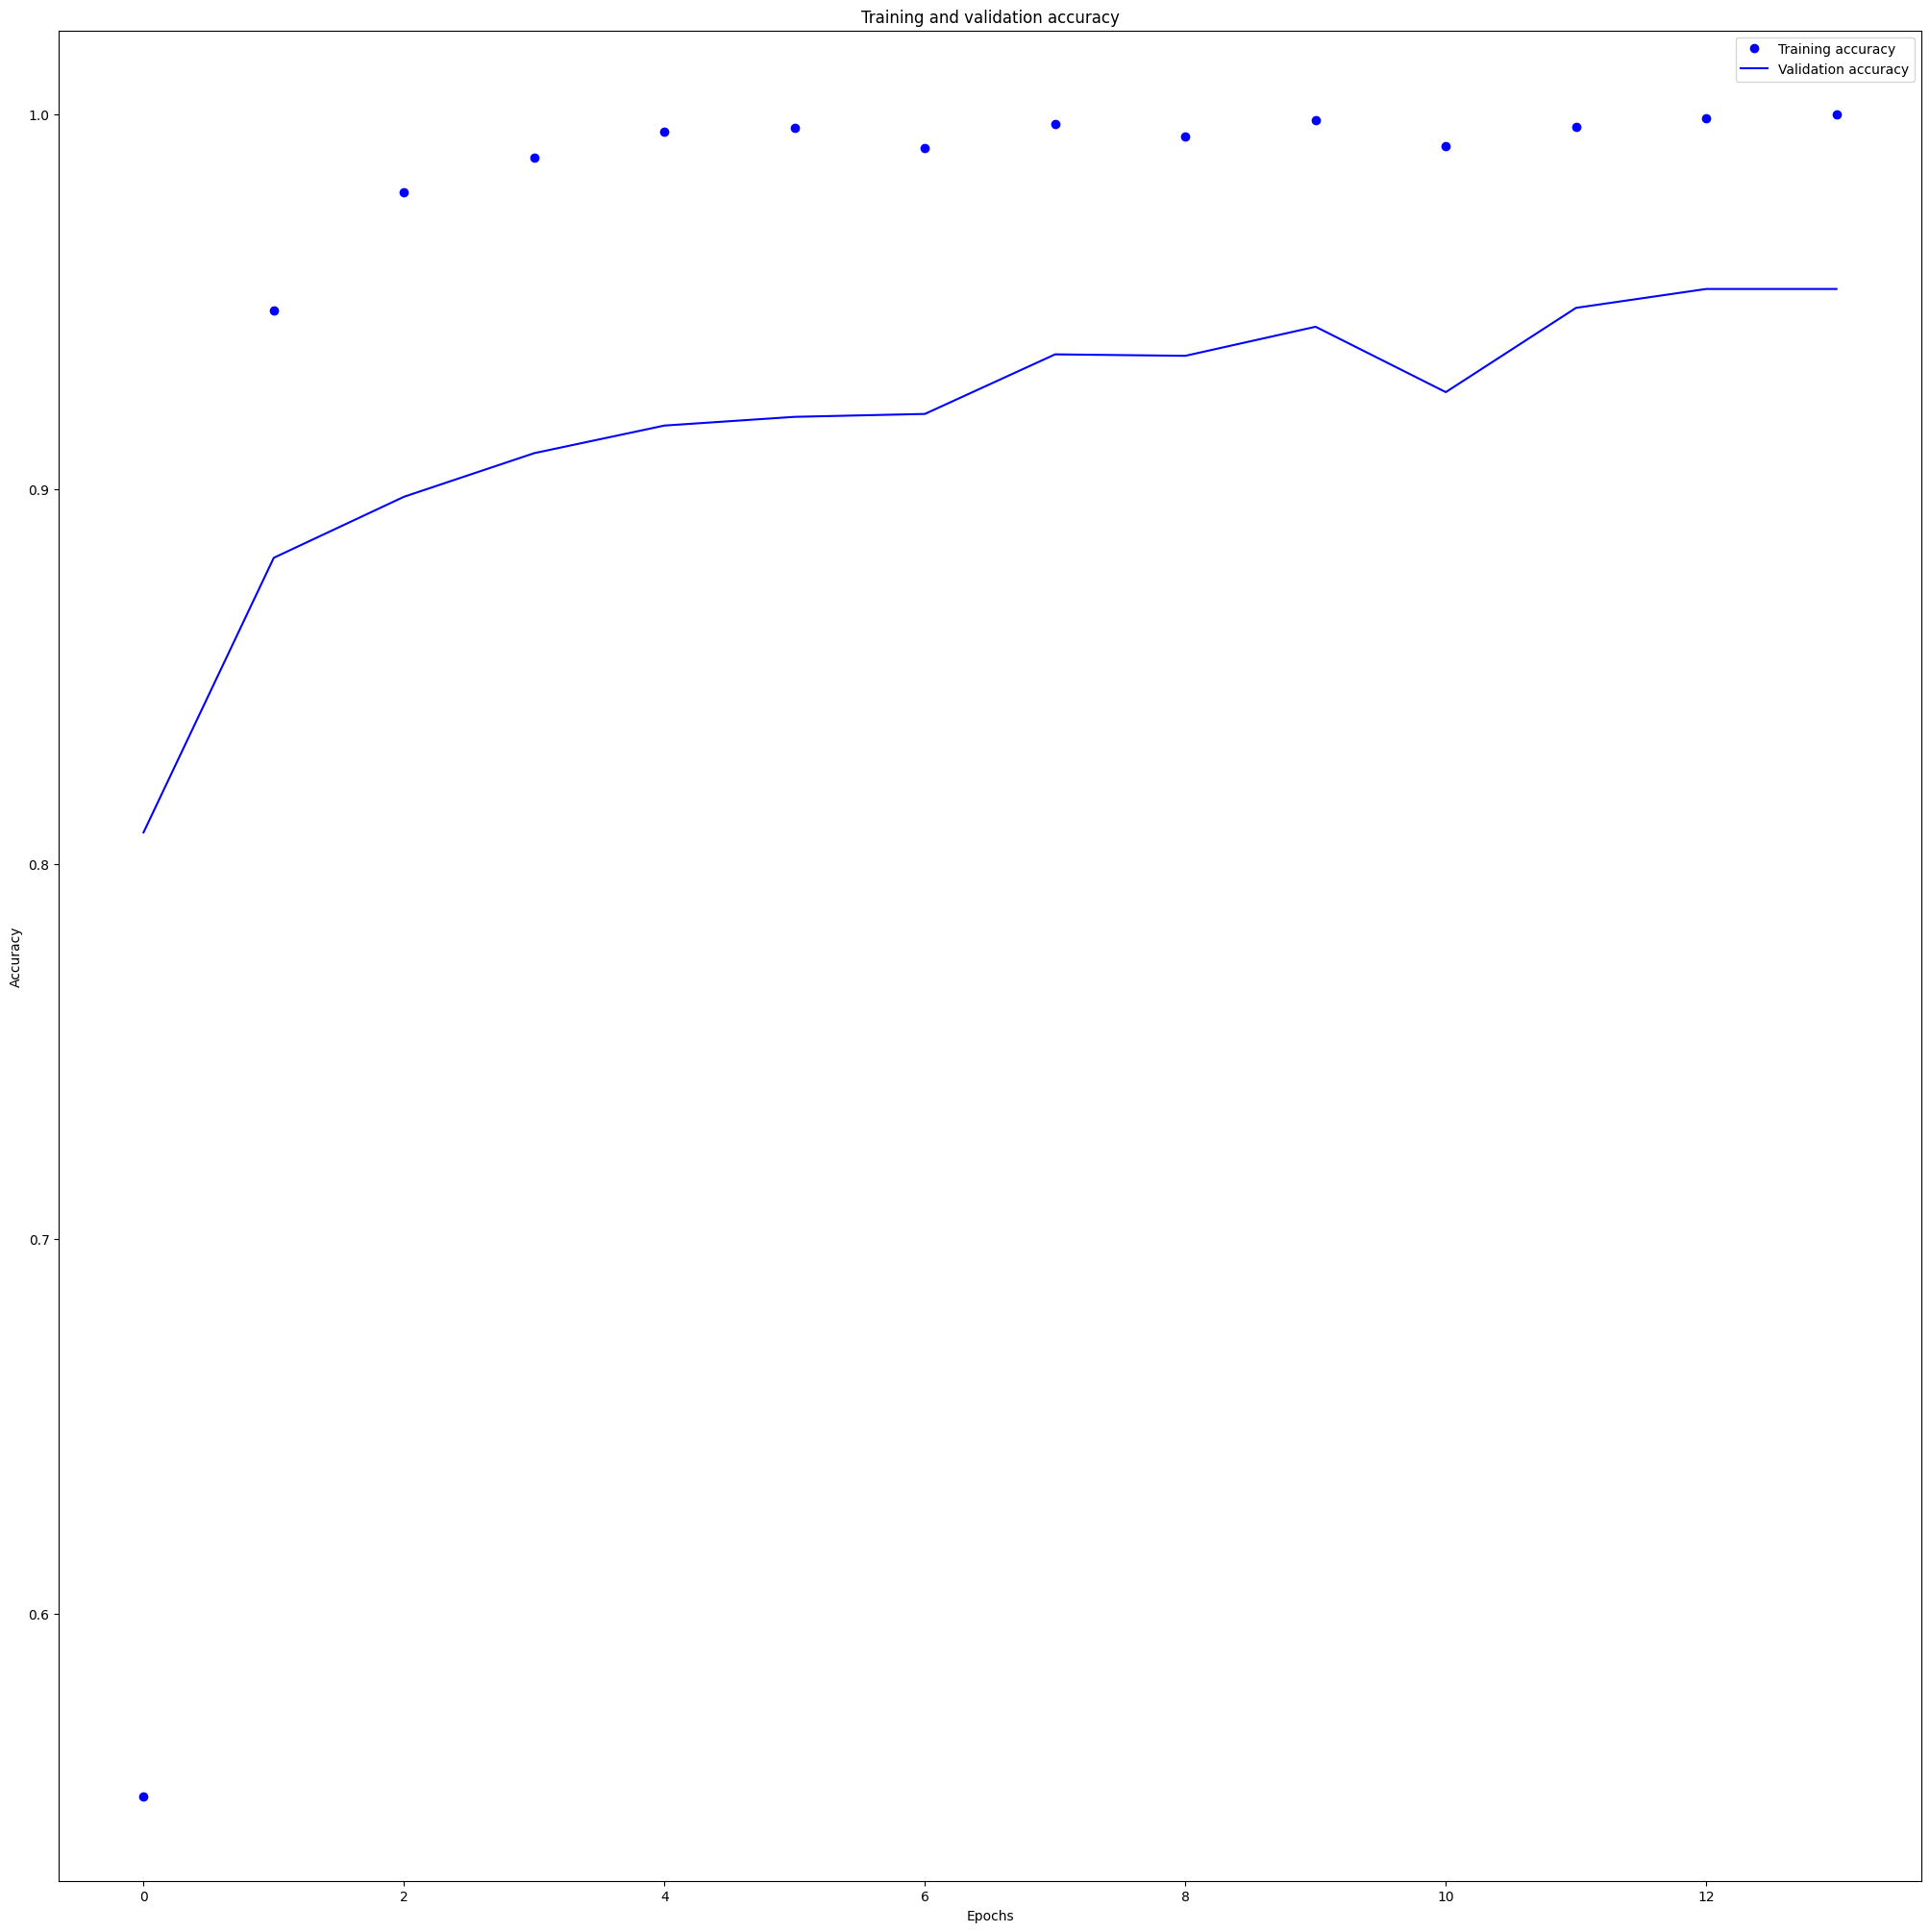

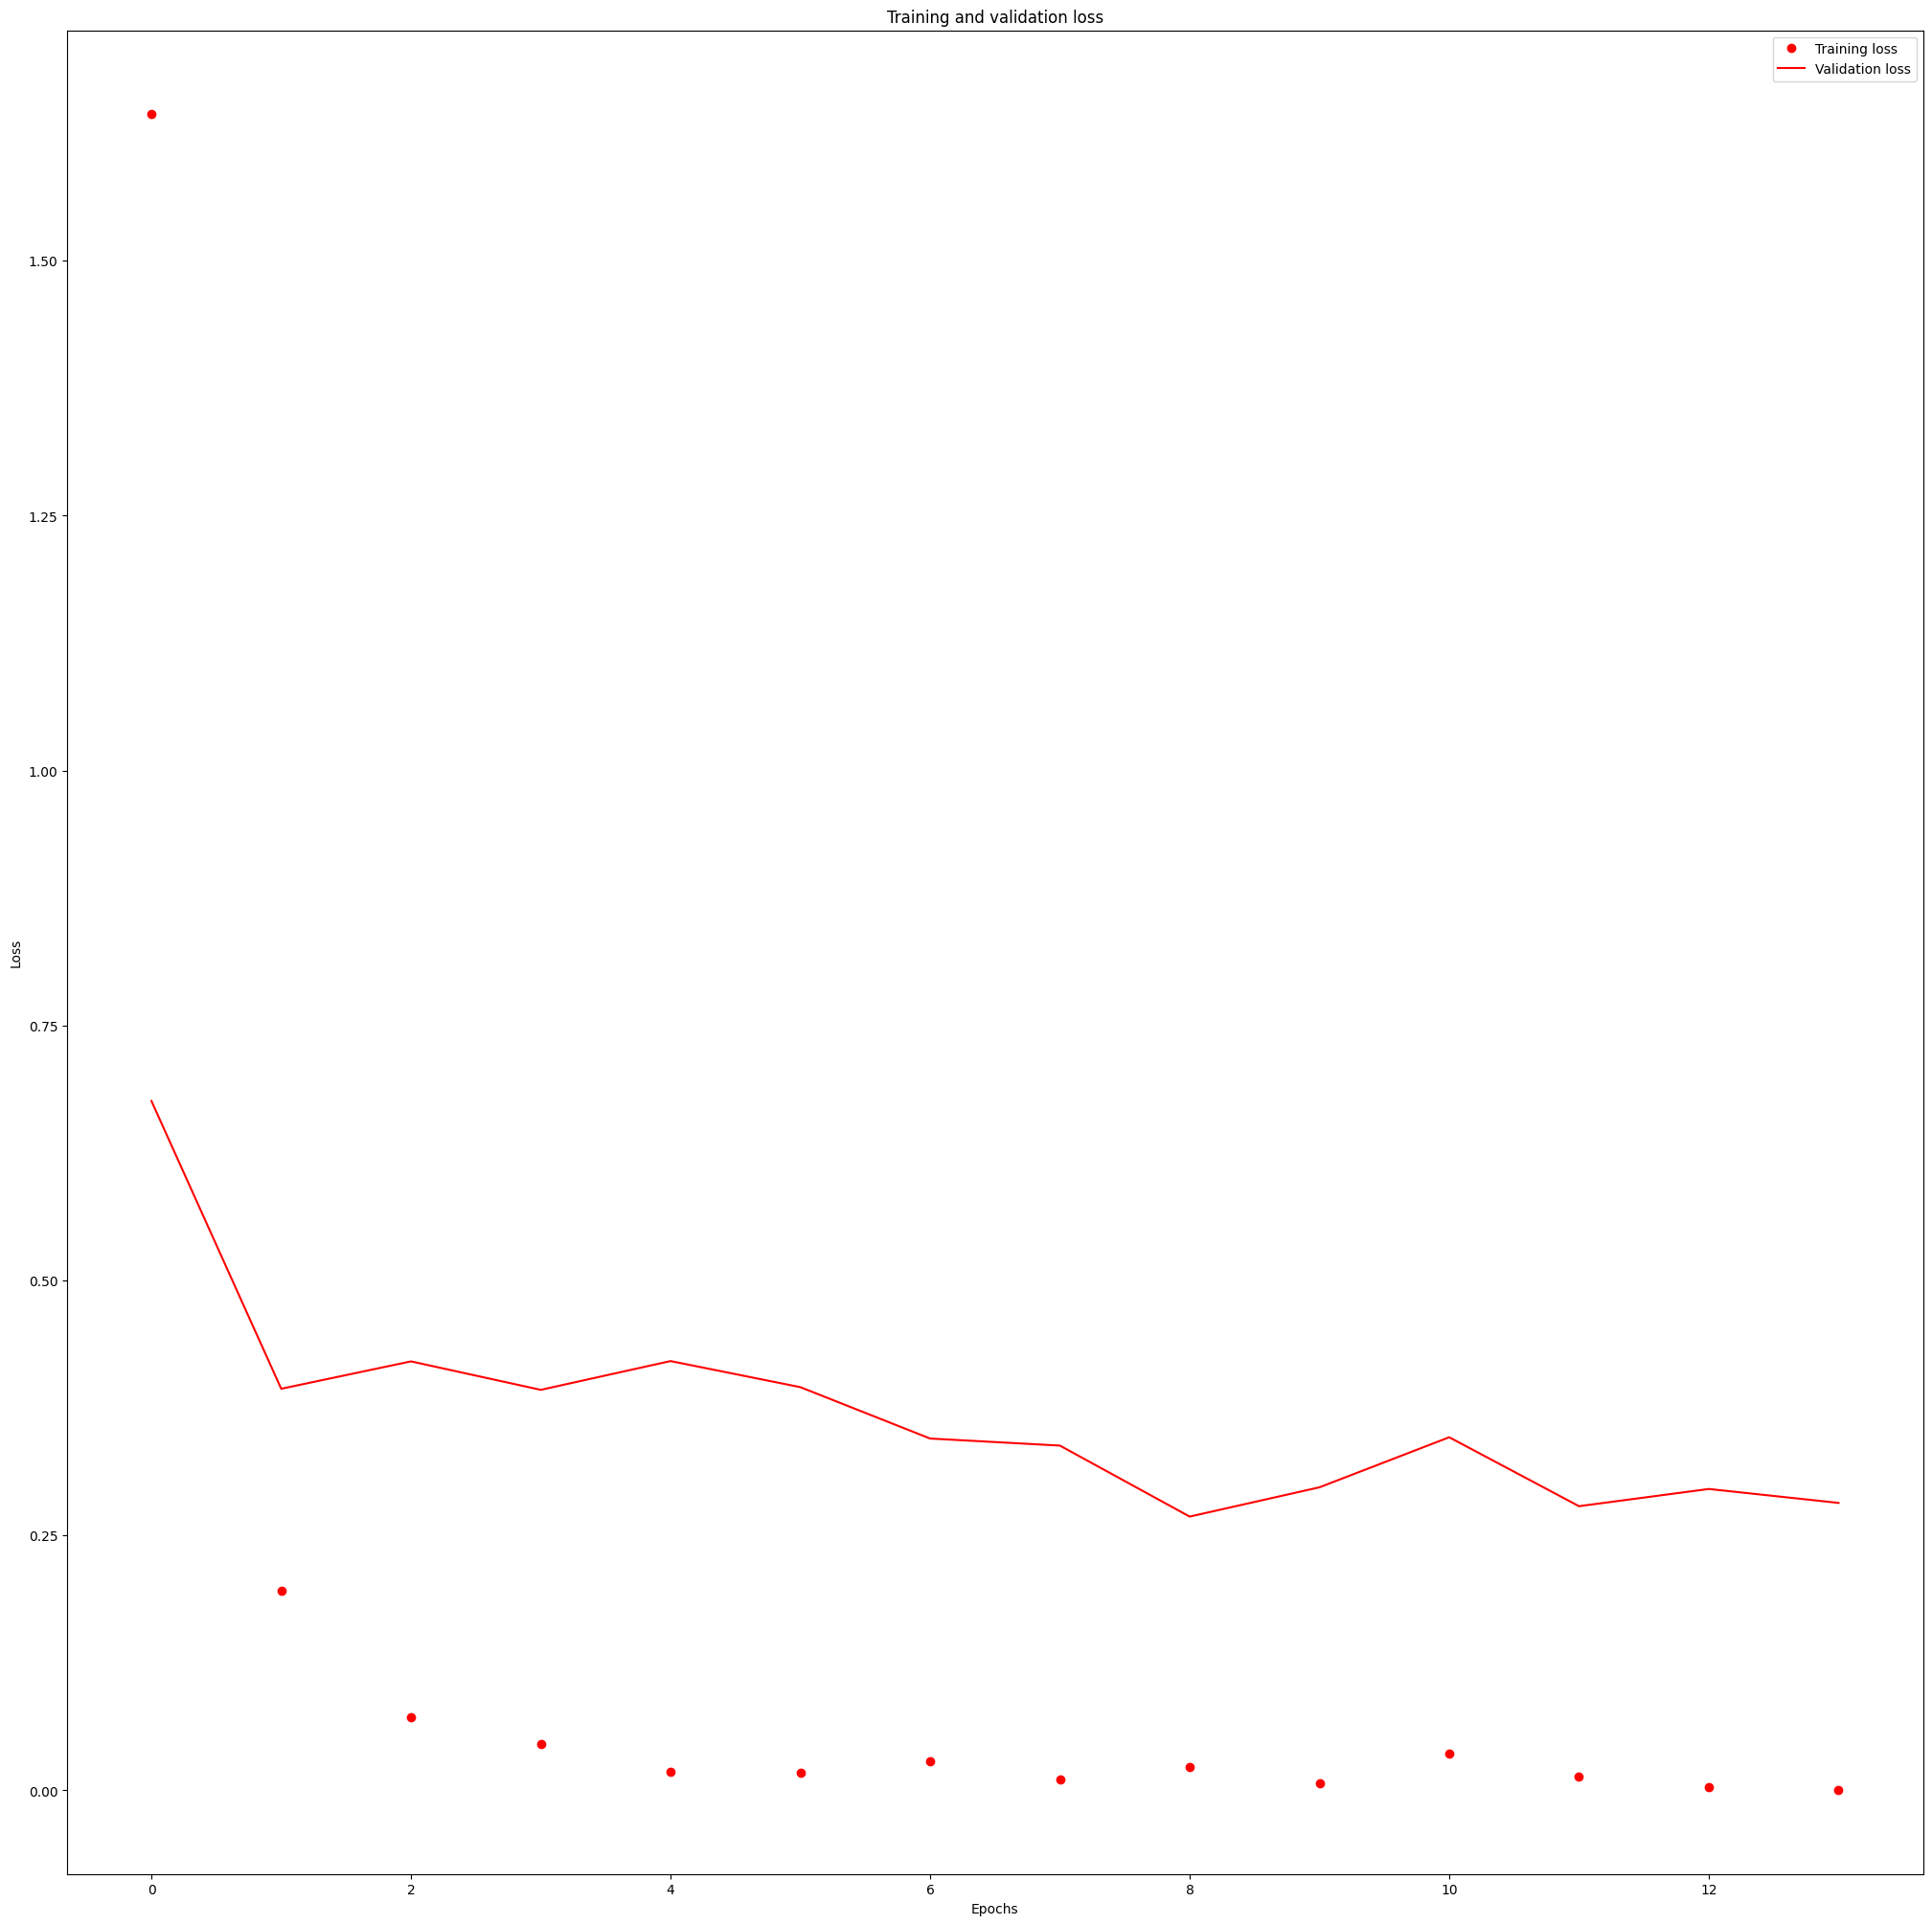

81/81 [==============================] - 0s 4ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.9423    0.8167    0.8750        60
           1     0.8507    0.9500    0.8976        60
           2     0.9219    0.9833    0.9516        60
           3     0.7532    0.9667    0.8467        60
           4     0.9375    1.0000    0.9677        60
           5     0.9672    0.9833    0.9752        60
           6     1.0000    0.9667    0.9831        60
           7     0.9836    1.0000    0.9917        60
           8     1.0000    1.0000    1.0000        60
           9     1.0000    0.9500    0.9744        60
          10     0.9138    0.8833    0.8983        60
          11     0.9655    0.9333    0.9492        60
          12     0.6444    0.9667    0.7733        60
          13     0.9836    1.0000    0.9917        60
          14     1.0000    0.5500    0.7097        60
          15     1.0000    0.9500    0.9744        60
    

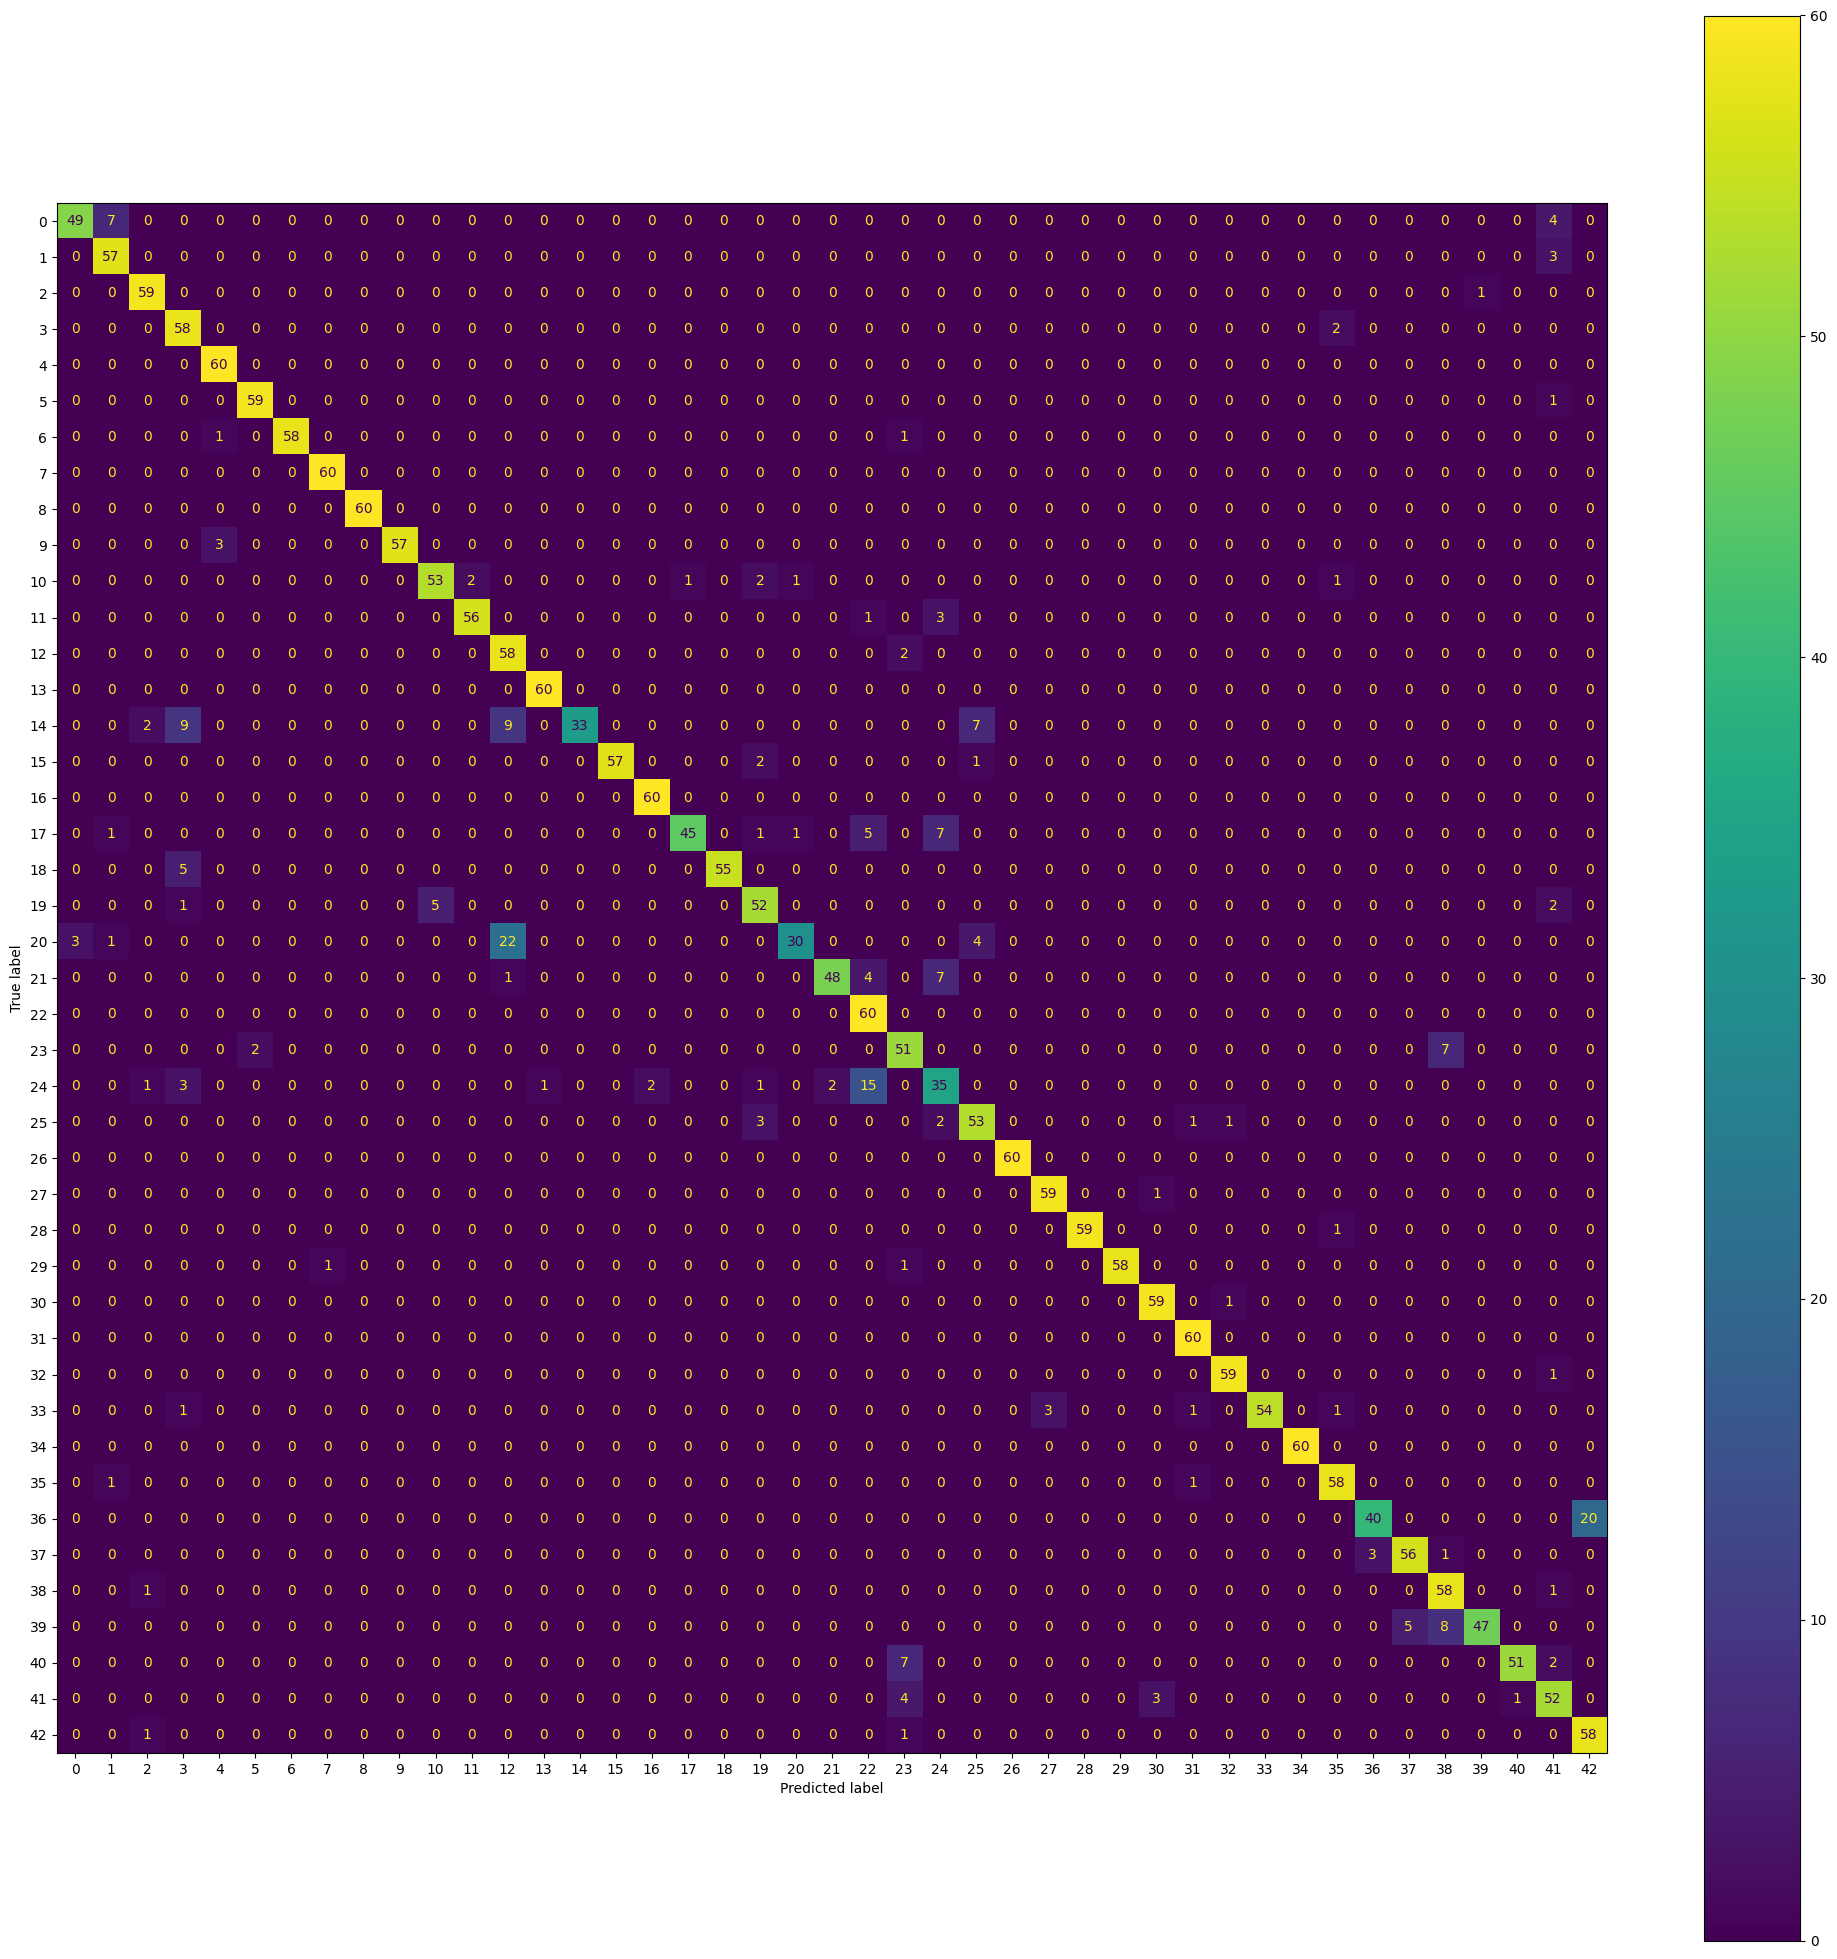

ROC Curve:


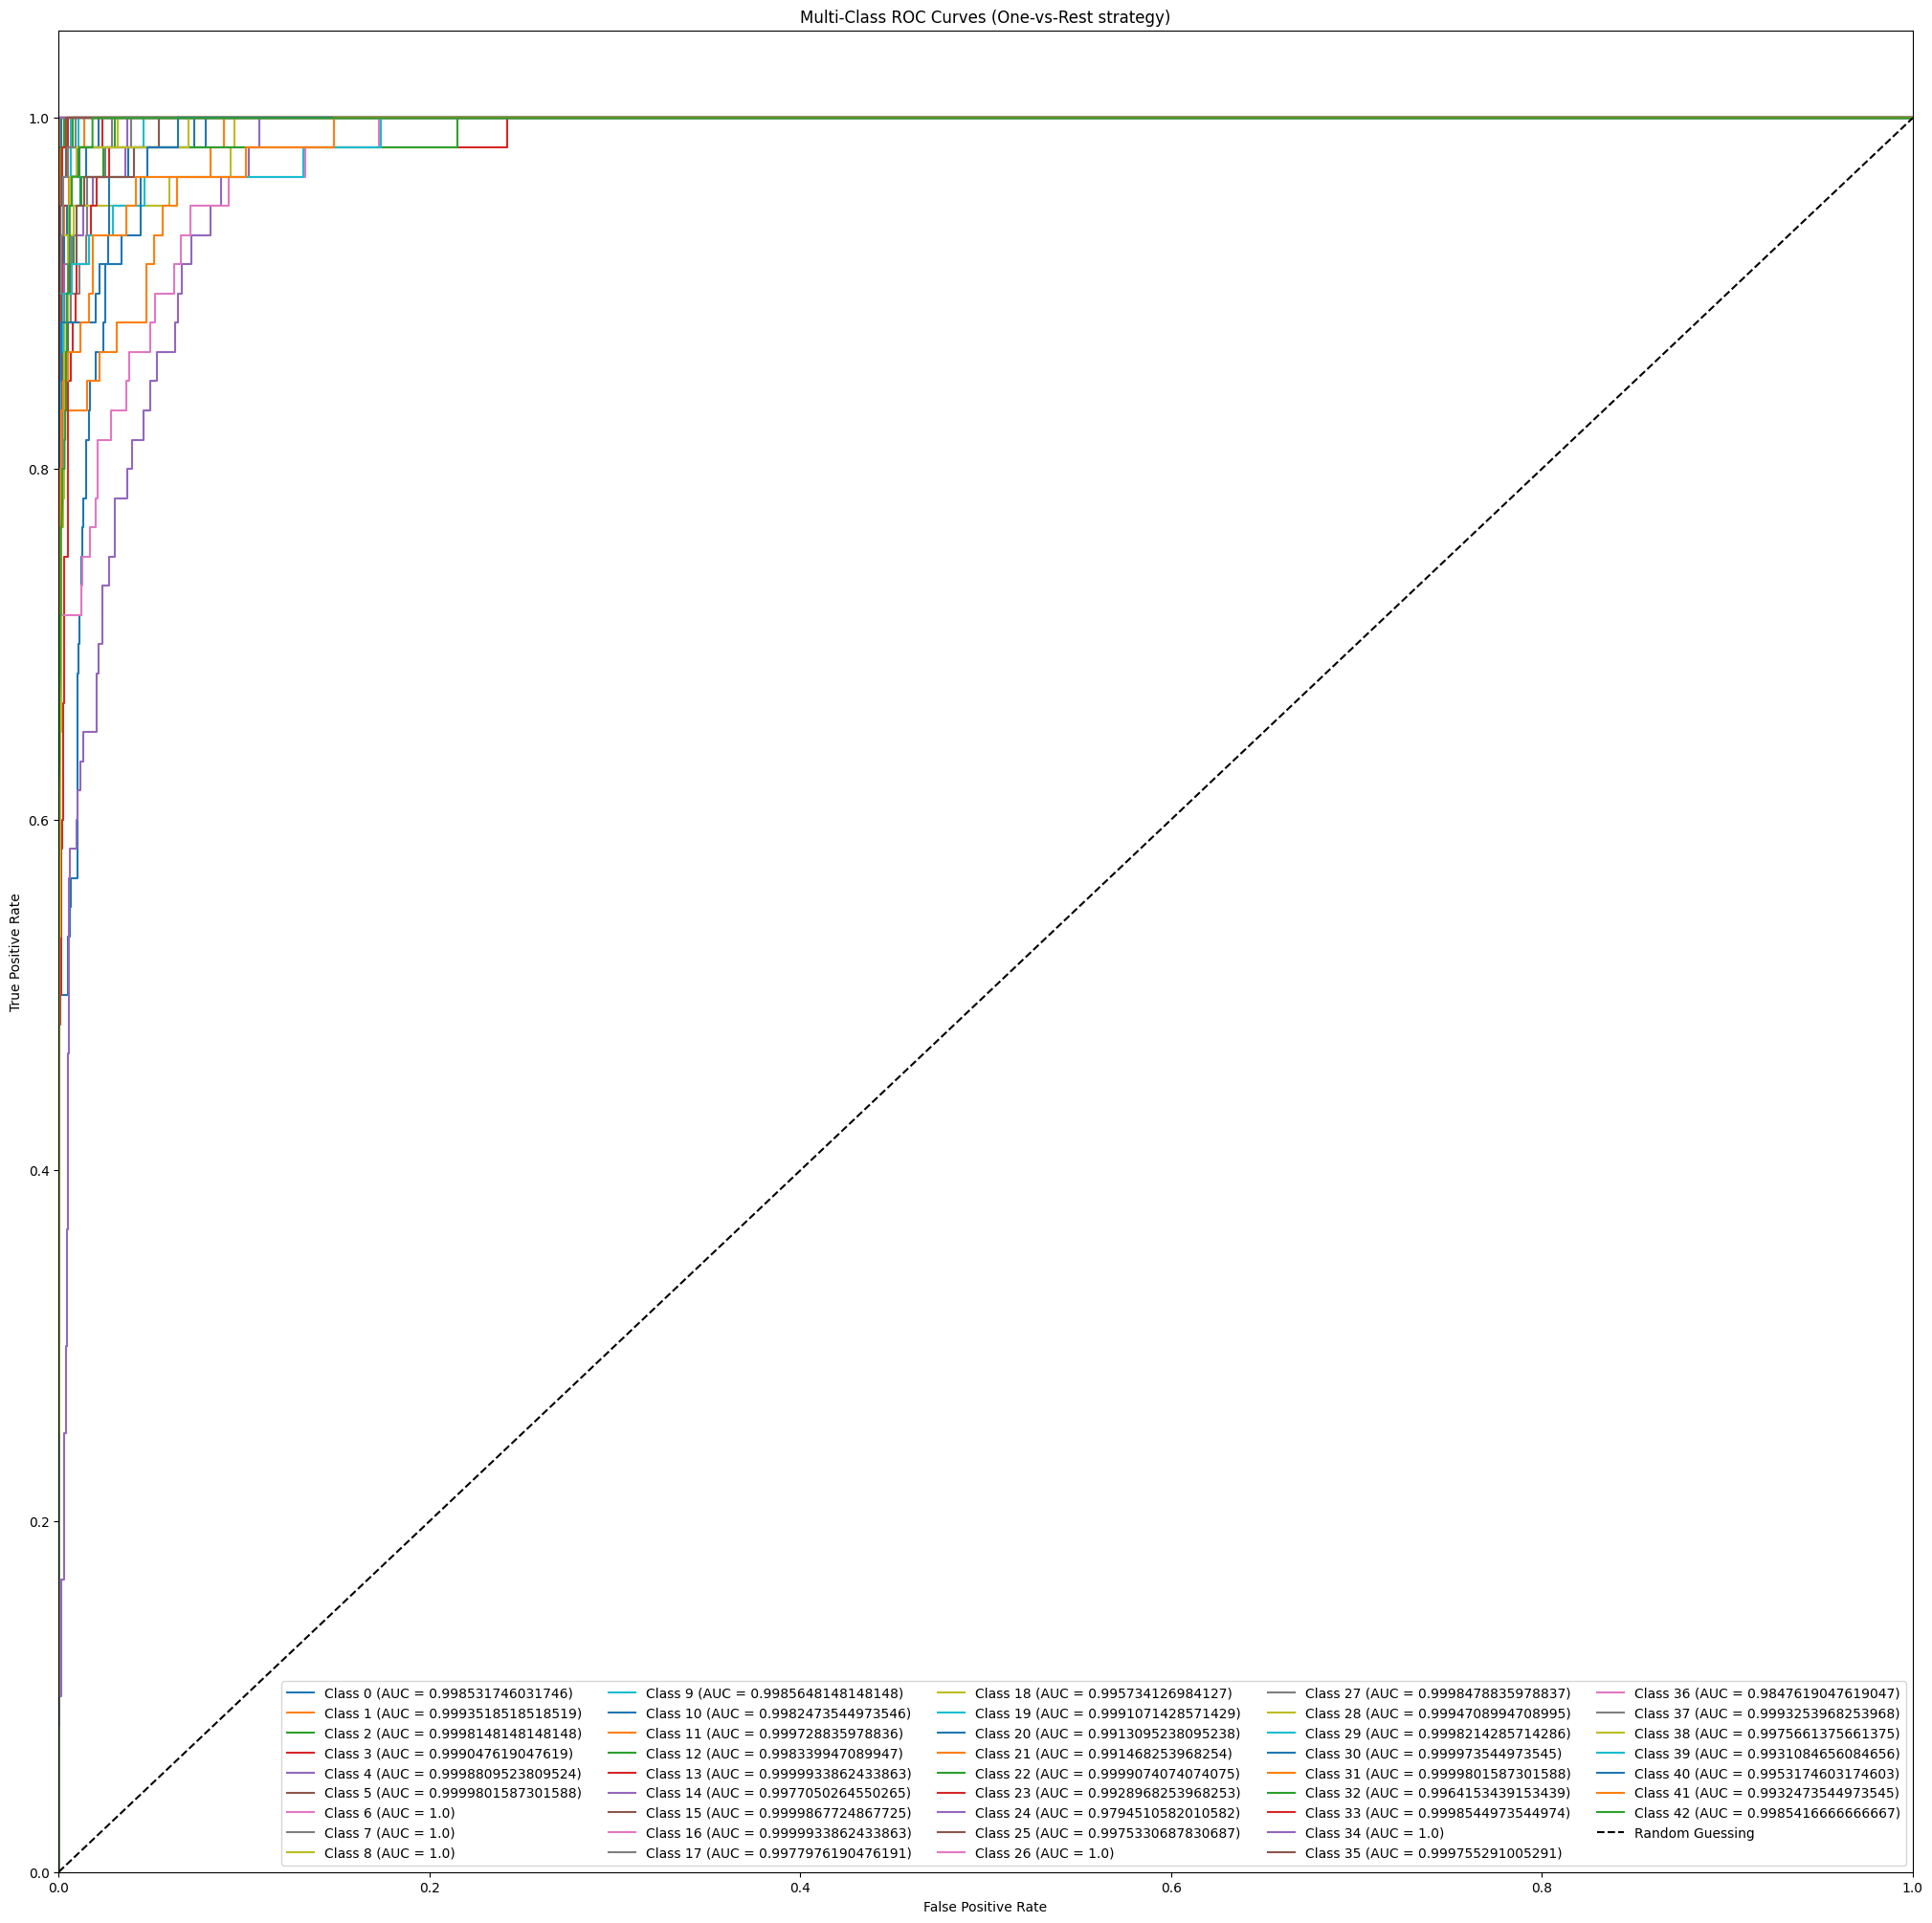

Test results - Loss: 0.48182472586631775 - Accuracy: 0.9034883975982666%
Top-K (K = 3) accuracy score: 0.9635658914728682


In [ ]:
train_dir = os.path.join(WORK_DIR,"Train")
validation_dir = os.path.join(WORK_DIR,"Validation")
test_dir = os.path.join(WORK_DIR,"Test")

train, validation, test = load_datasets(train_dir, validation_dir, test_dir)
result = compile_and_fit(model_flt_increased, train, validation)
train_performance(result)
test_evaluation(model_flt_increased, test)

The basic model with the number of filters increased reaches an accuracy of approximately 90.3% and a Top-K score of approximately 0.964. The model was trained for 14 epochs, after which the early stopping mechanism was activated for overfitting. The worsening of overfitting is probably due to the increase in complexity of the network. Maintaining the structure we just tested, let's try to apply some techniques that mitigate overfitting.

3) Model with dropout overfitting mitigation technique

Let's try to improve performance by mitigating overfitting.
The model is composed as follow:

* 3 Conv2d-MaxPooling2D layers (64,128,256)
* Dropout layer after first and second pooling layer and before the last dense layer
* No Regularization or Hidden Dense layers

In [ ]:
input = keras.Input(shape=CUSTOM_INPUT_SHAPE)
x = layers.Rescaling(1./255)(input)

x = layers.Conv2D(filters=64, kernel_size = KERNEL_SIZE, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters=128, kernel_size = KERNEL_SIZE, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters=256, kernel_size = KERNEL_SIZE, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

output = layers.Dense(43, activation='softmax')(x)

model_drop = keras.Model(inputs=input, outputs=output, name="Model_drop")
show_and_save_model_summary(model_drop)

Model: "Model_drop"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 45, 45, 64)        3136      
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 22, 22, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 22, 22, 64)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 19, 19, 128)       131200    
                                                        

Load the dataset, train the model and evaluate it

Found 6450 files belonging to 43 classes.
Found 2580 files belonging to 43 classes.
Found 2580 files belonging to 43 classes.
Epoch 1/30
197/202 [============================>.] - ETA: 0s - loss: 2.7163 - accuracy: 0.2356
Epoch 1: val_loss improved from inf to 1.29025, saving model to /content/drive/Shareddrives/Biondi/Models/Model_drop.h5
202/202 [==============================] - 5s 16ms/step - loss: 2.6836 - accuracy: 0.2433 - val_loss: 1.2903 - val_accuracy: 0.6395


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
199/202 [============================>.] - ETA: 0s - loss: 0.7221 - accuracy: 0.7798
Epoch 2: val_loss improved from 1.29025 to 0.53467, saving model to /content/drive/Shareddrives/Biondi/Models/Model_drop.h5
202/202 [==============================] - 4s 18ms/step - loss: 0.7167 - accuracy: 0.7812 - val_loss: 0.5347 - val_accuracy: 0.8589
Epoch 3/30
201/202 [============================>.] - ETA: 0s - loss: 0.2973 - accuracy: 0.9095
Epoch 3: val_loss improved from 0.53467 to 0.39225, saving model to /content/drive/Shareddrives/Biondi/Models/Model_drop.h5
202/202 [==============================] - 4s 18ms/step - loss: 0.2966 - accuracy: 0.9098 - val_loss: 0.3922 - val_accuracy: 0.9016
Epoch 4/30
200/202 [============================>.] - ETA: 0s - loss: 0.1781 - accuracy: 0.9447
Epoch 4: val_loss improved from 0.39225 to 0.33819, saving model to /content/drive/Shareddrives/Biondi/Models/Model_drop.h5
202/202 [==============================] - 3s 16ms/step - loss: 0.1782 - acc

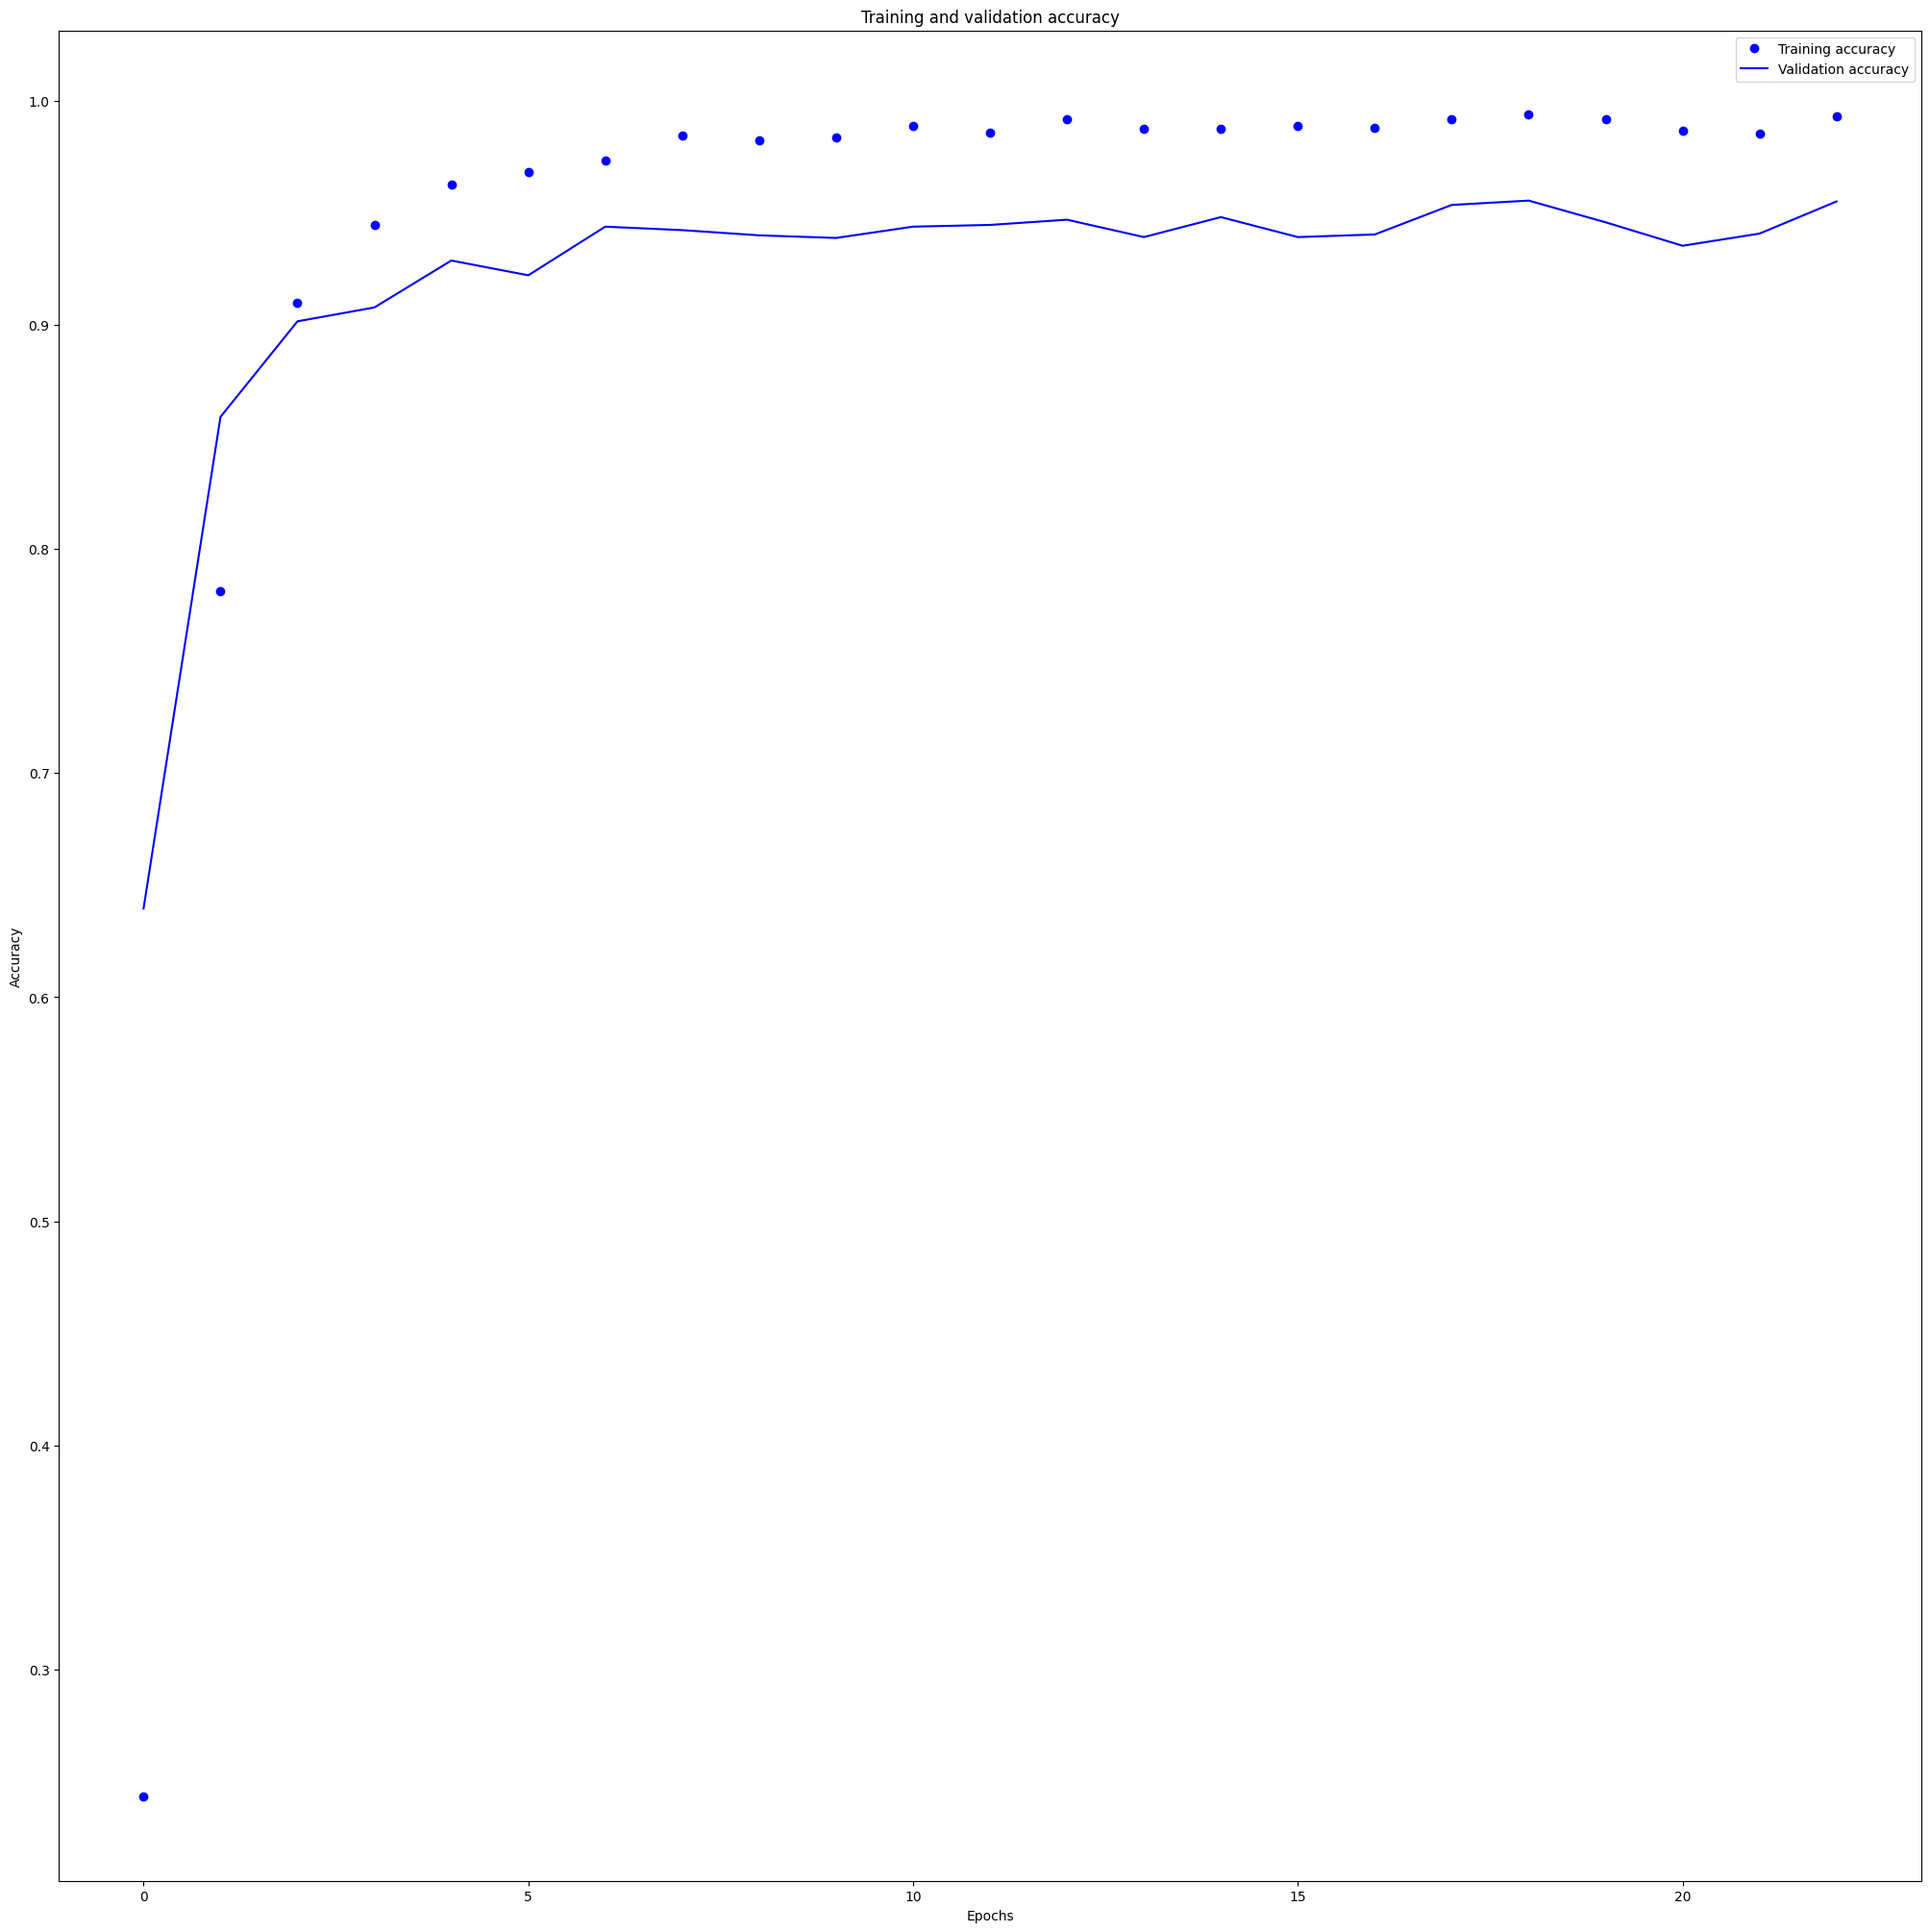

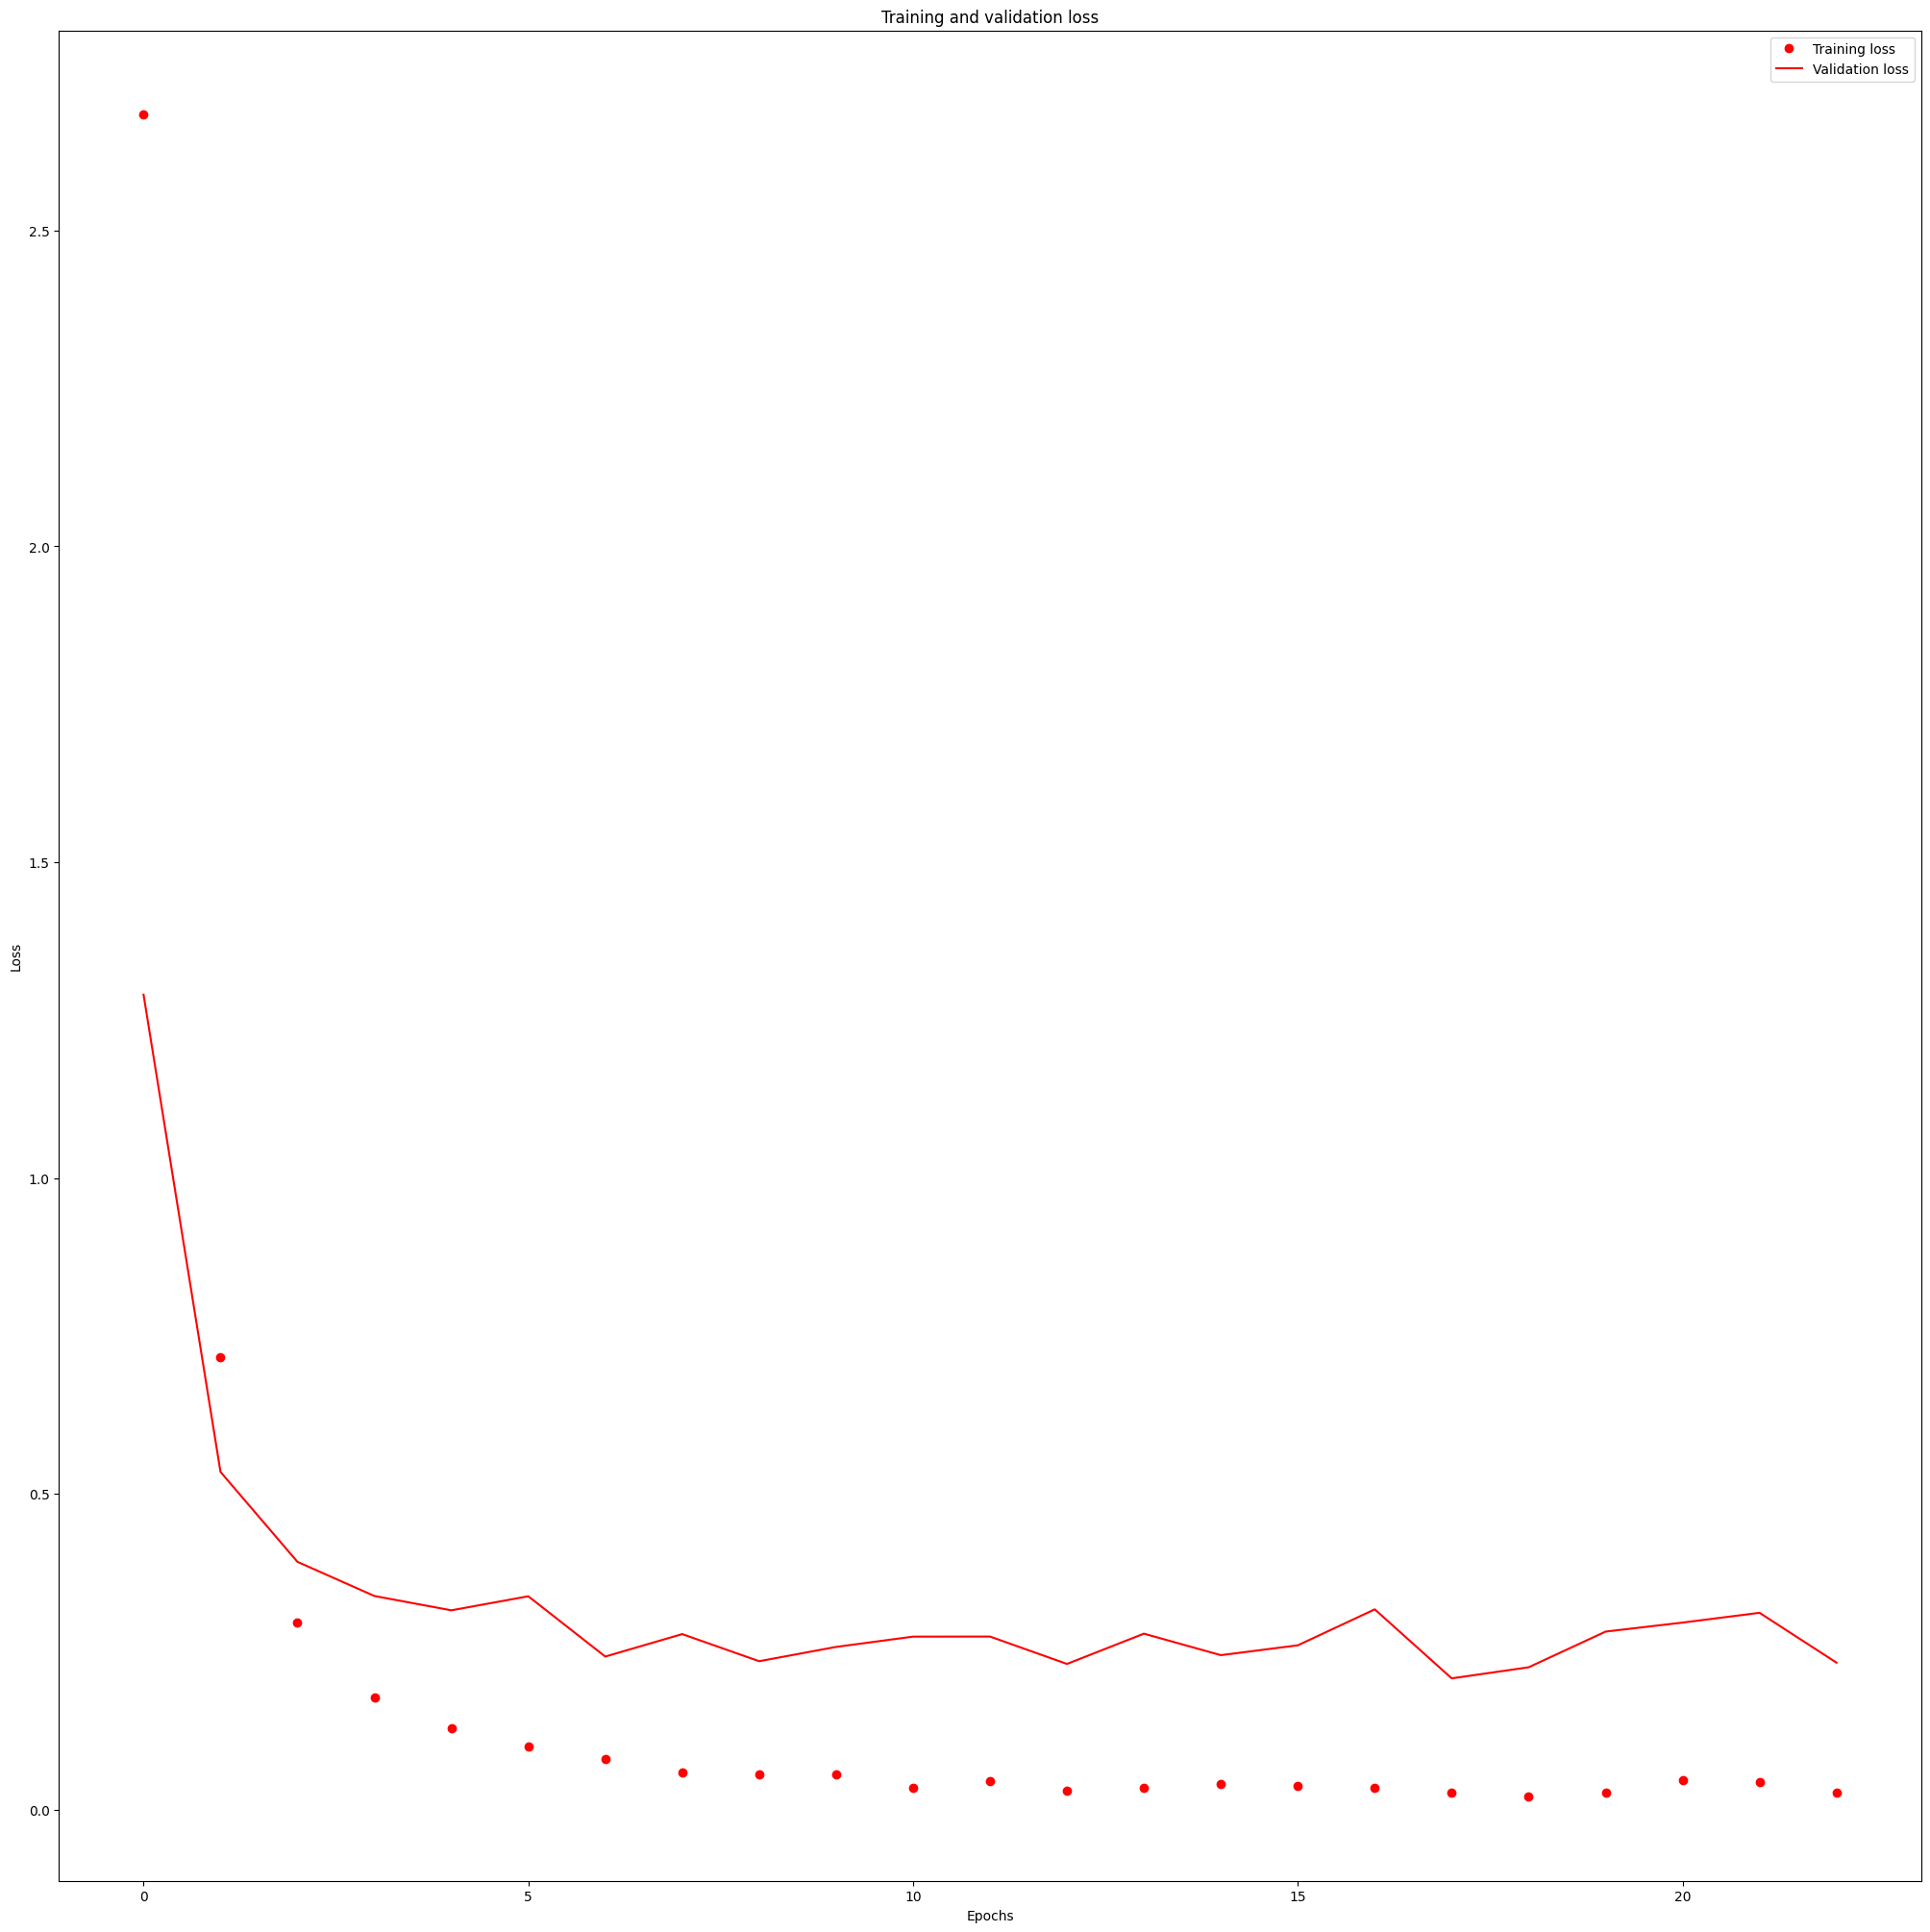

81/81 [==============================] - 0s 3ms/step
Classification report: 
              precision    recall  f1-score   support

           0     1.0000    0.9500    0.9744        60
           1     0.8310    0.9833    0.9008        60
           2     0.9231    1.0000    0.9600        60
           3     0.9483    0.9167    0.9322        60
           4     0.8382    0.9500    0.8906        60
           5     1.0000    1.0000    1.0000        60
           6     0.9231    1.0000    0.9600        60
           7     0.9677    1.0000    0.9836        60
           8     1.0000    0.9833    0.9916        60
           9     1.0000    0.8667    0.9286        60
          10     0.9206    0.9667    0.9431        60
          11     1.0000    1.0000    1.0000        60
          12     0.9667    0.9667    0.9667        60
          13     0.8955    1.0000    0.9449        60
          14     1.0000    0.6500    0.7879        60
          15     1.0000    0.9667    0.9831        60
    

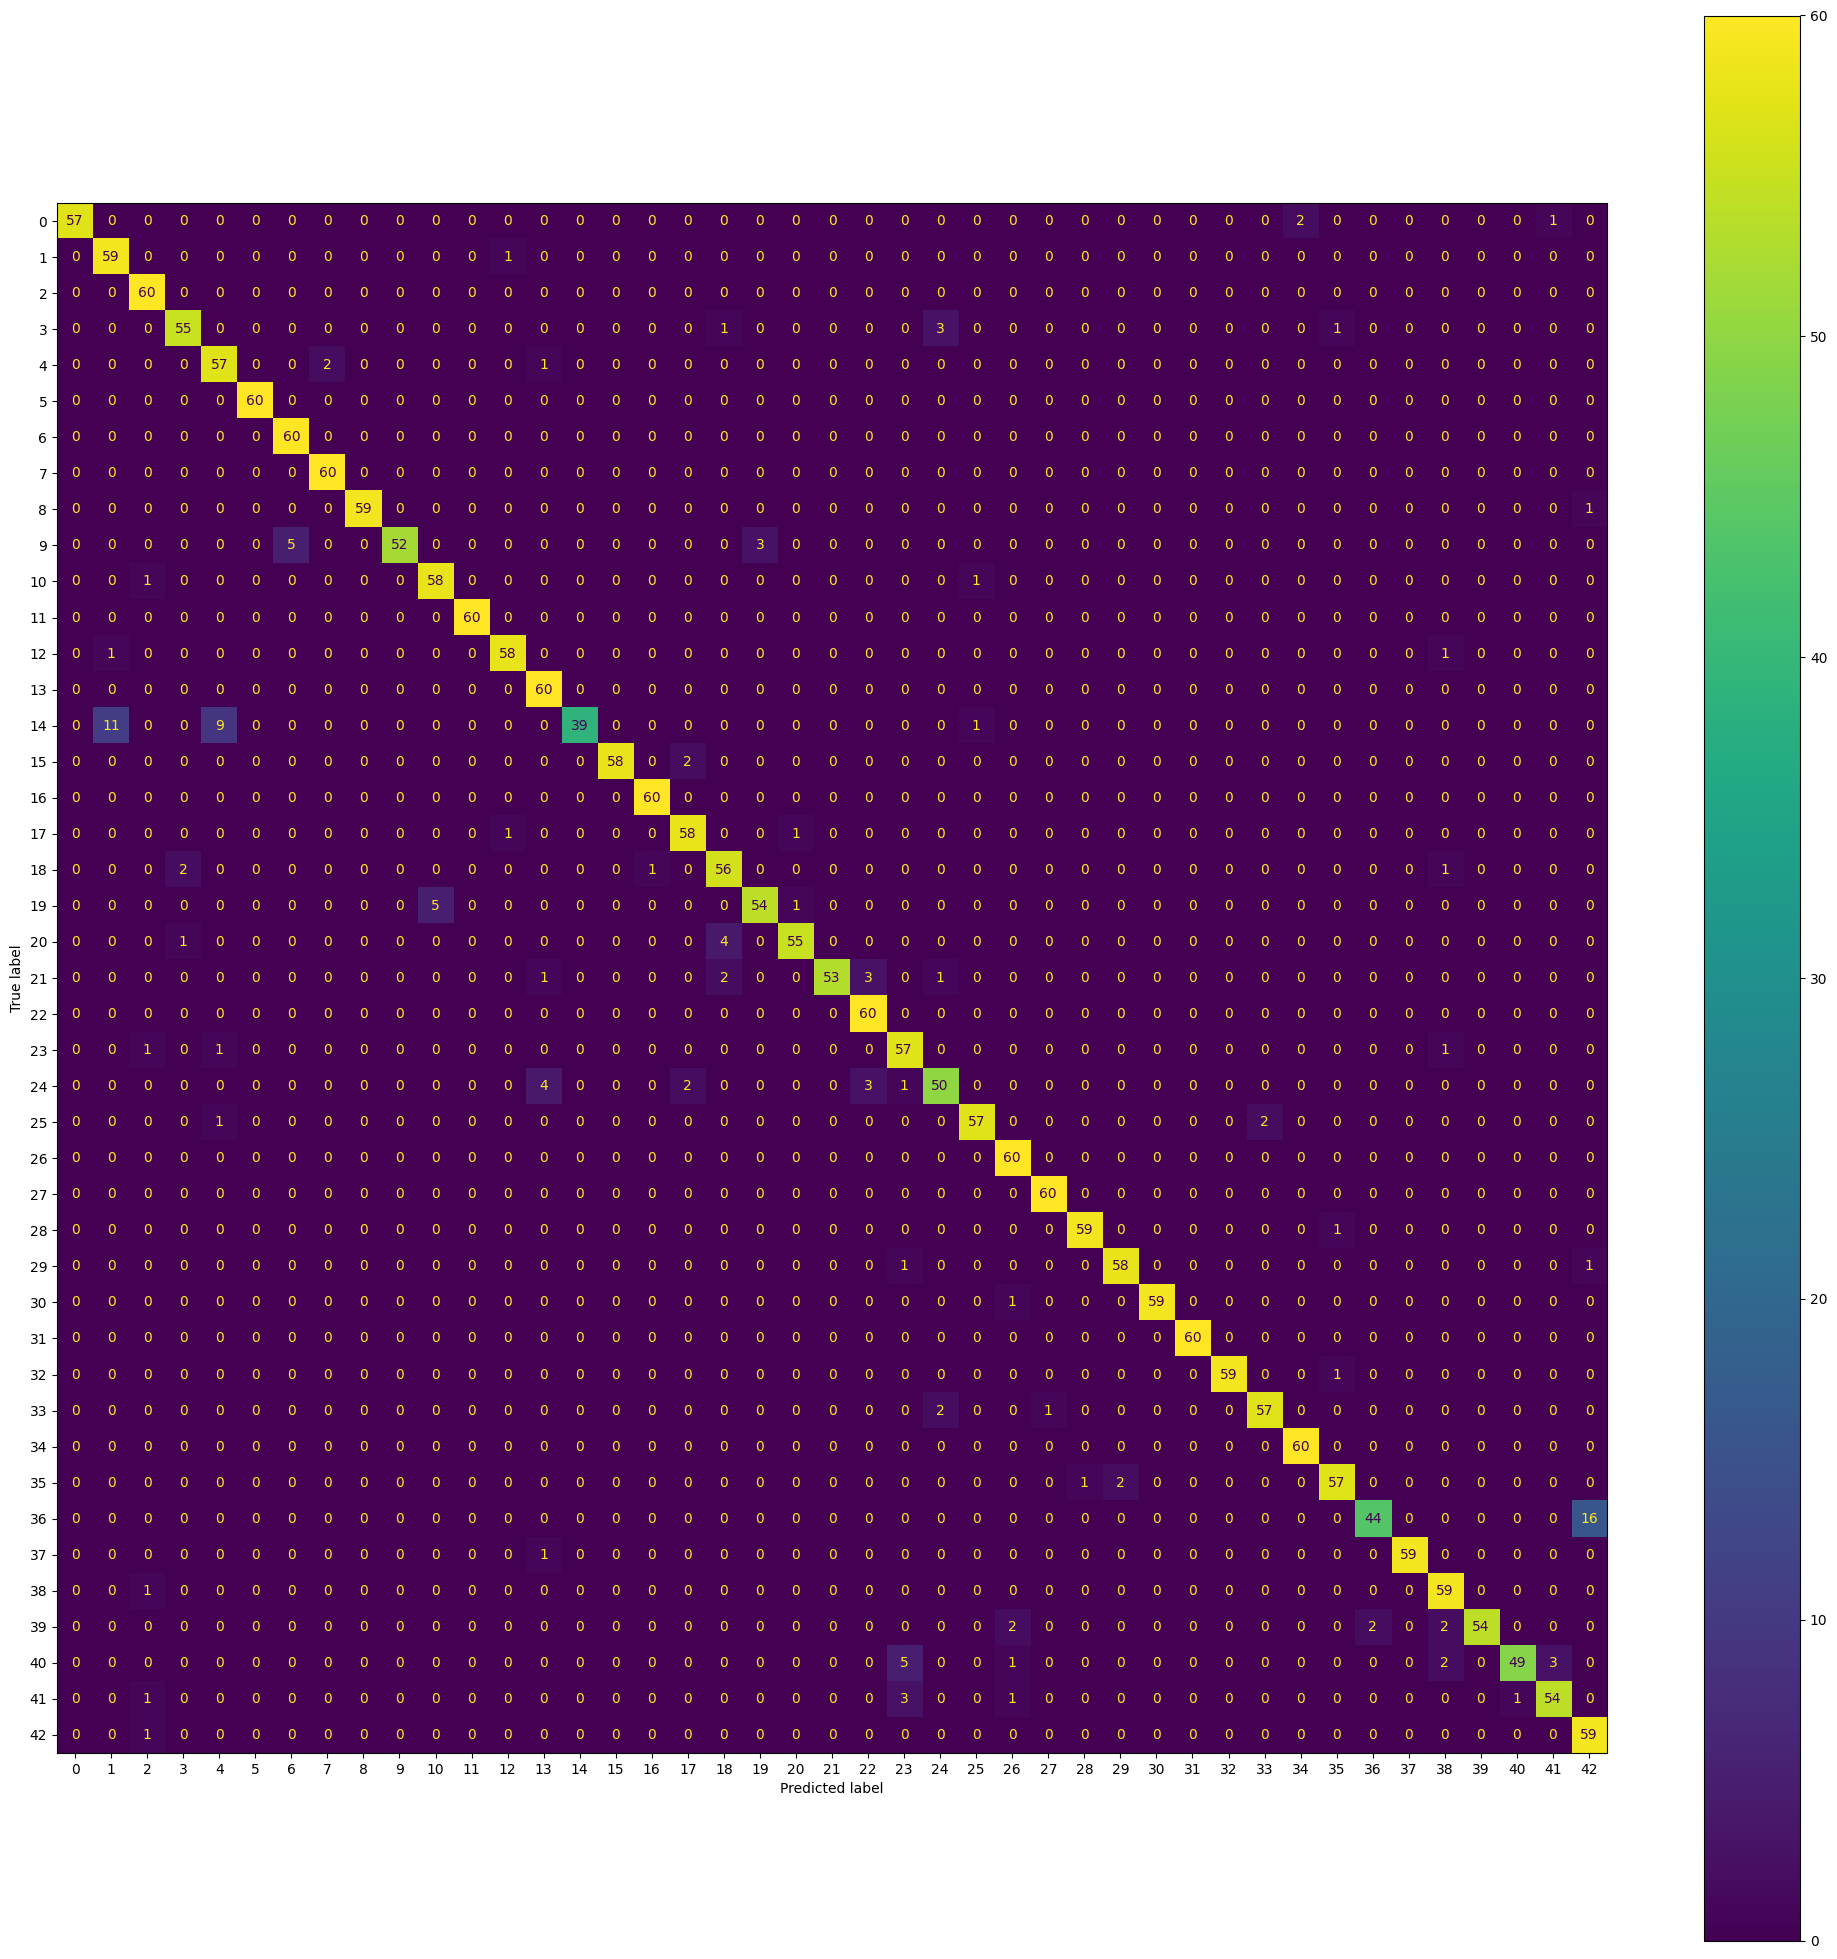

ROC Curve:


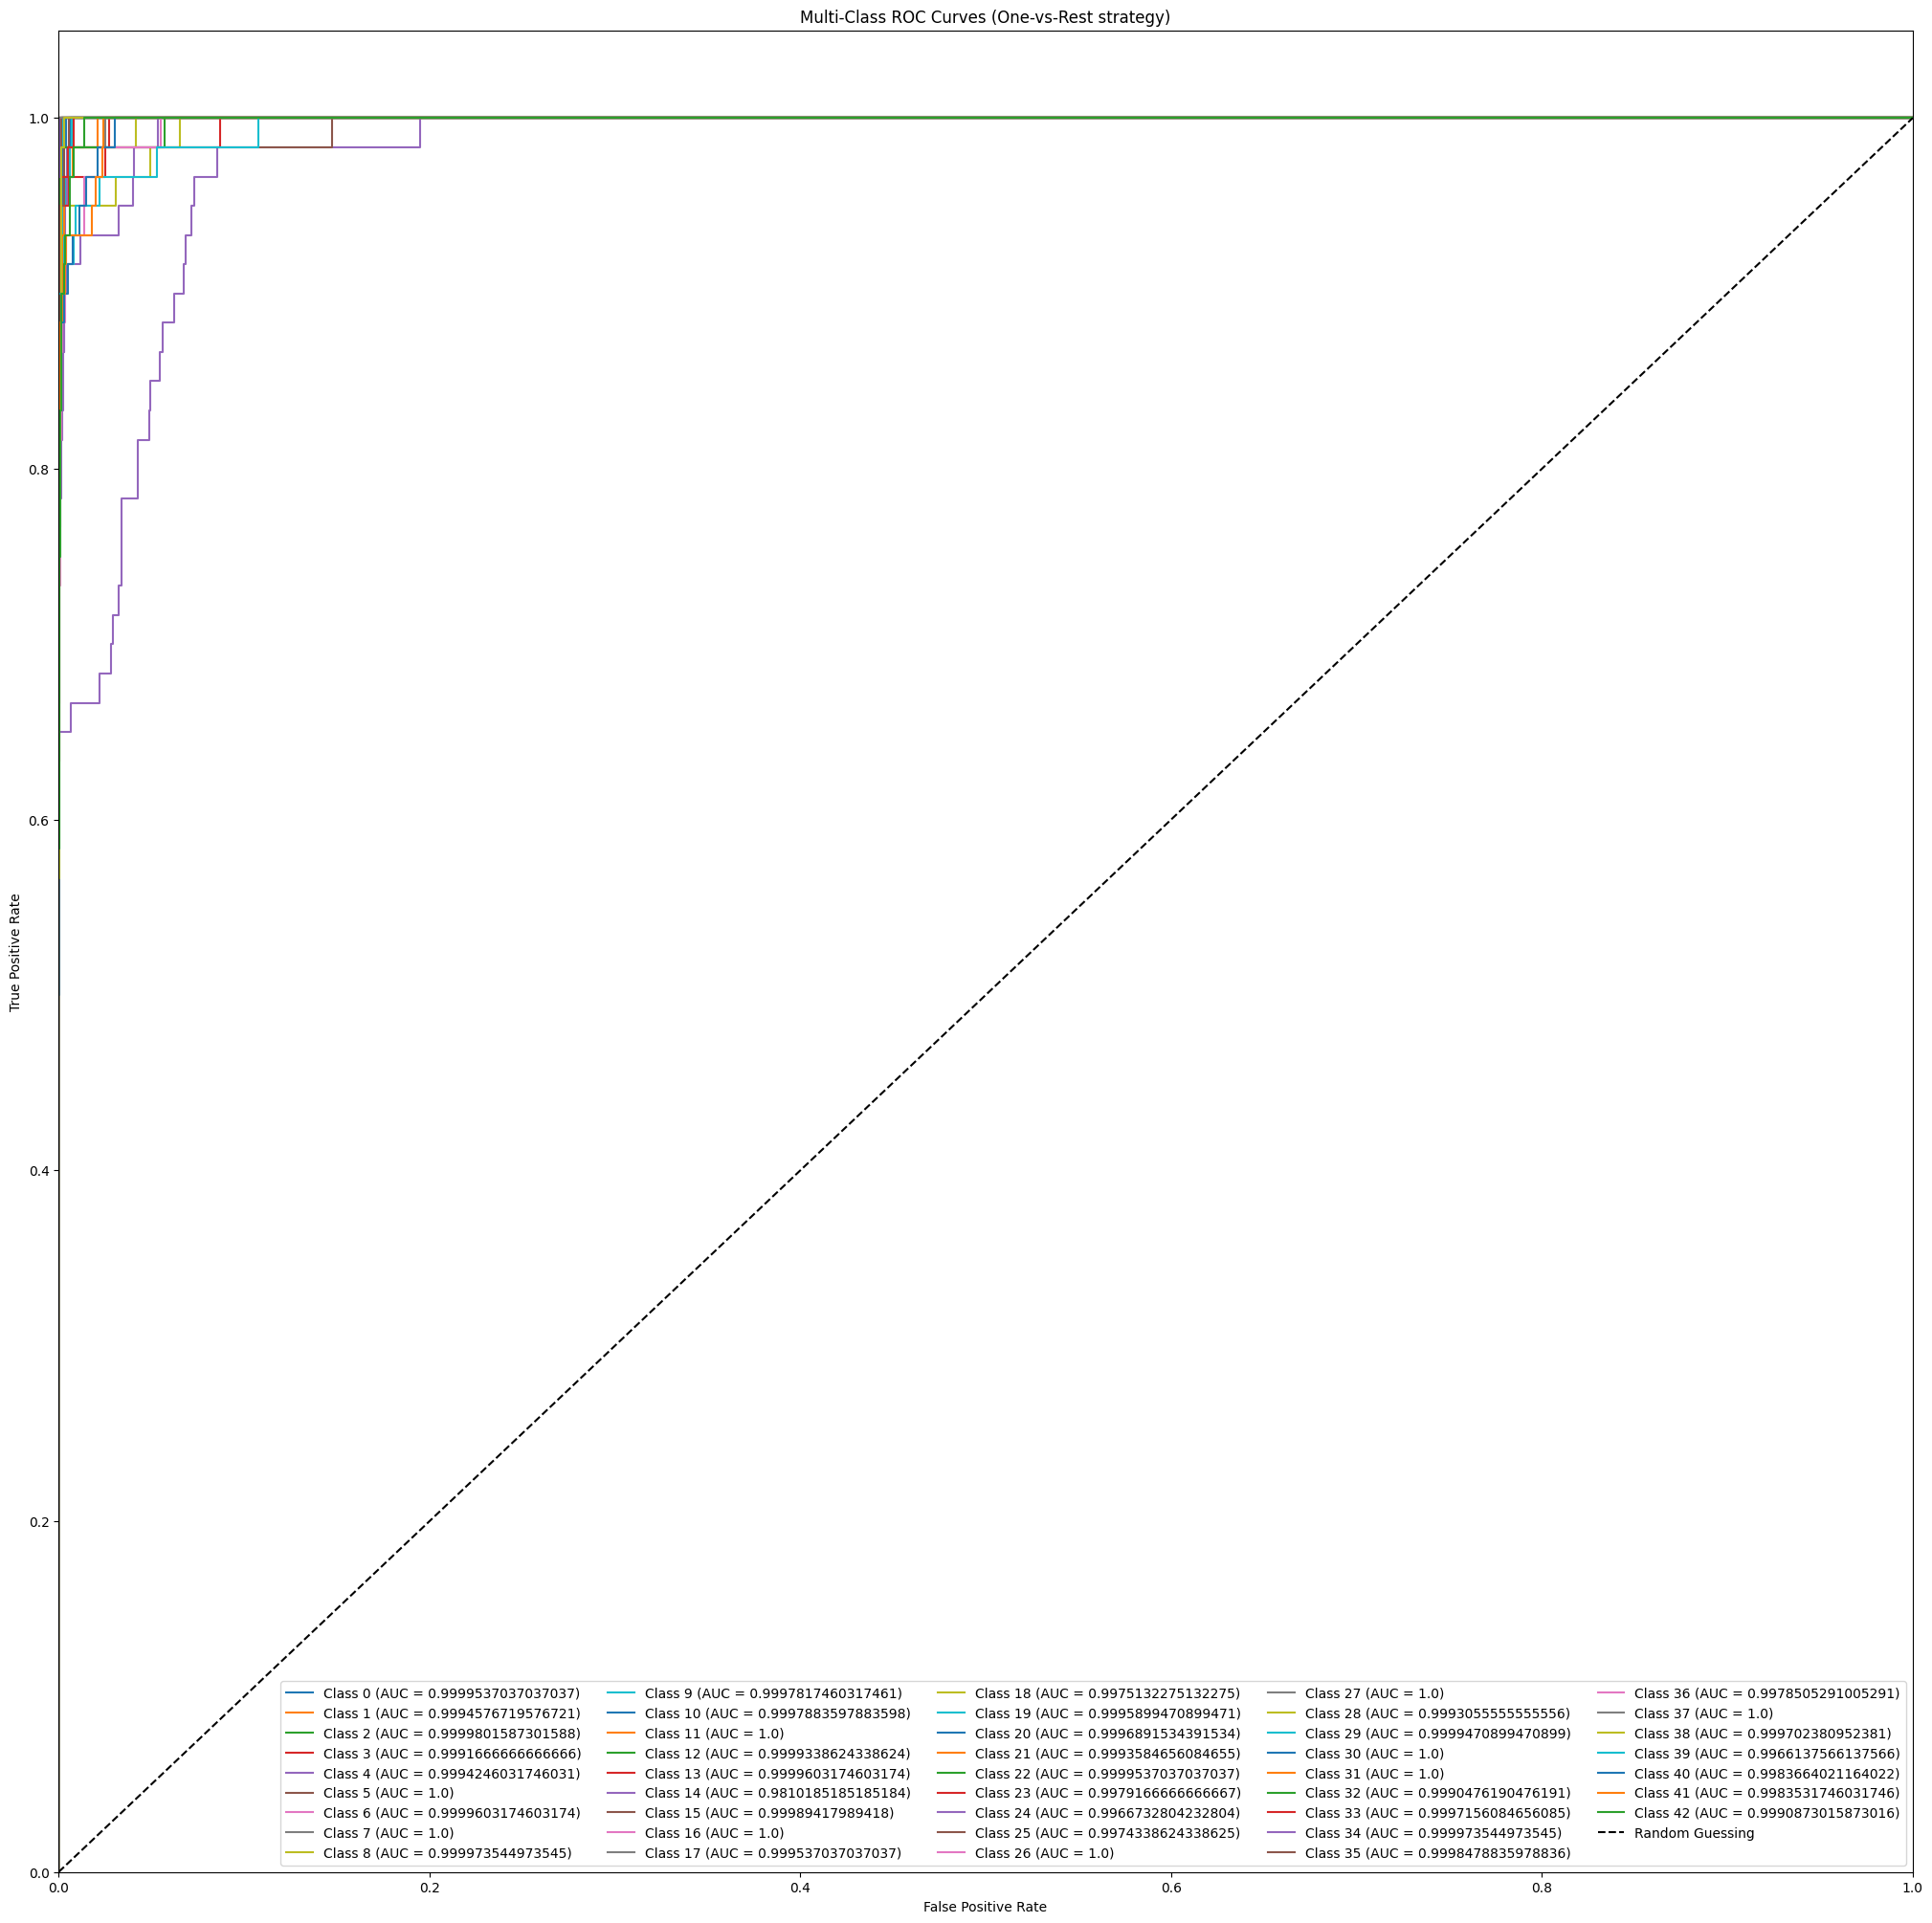

Test results - Loss: 0.2987394630908966 - Accuracy: 0.945348858833313%
Top-K (K = 3) accuracy score: 0.9775193798449613


In [ ]:
train_dir = os.path.join(WORK_DIR,"Train")
validation_dir = os.path.join(WORK_DIR,"Validation")
test_dir = os.path.join(WORK_DIR,"Test")

train, validation, test = load_datasets(train_dir, validation_dir, test_dir)
result = compile_and_fit(model_drop, train, validation)
train_performance(result)
test_evaluation(model_drop, test)

Thanks to the dropout application the model achieves an accuracy of approximately 94.5% and a Top-K score of approximately 0.978. The model was trained for 23 epochs, after which the early stopping mechanism was activated for overfitting. The dropout improved the overfitting condition.

___
4) Model with dropout and regularization overfitting mitigation techniques

The model is composed as follow:

* 3 Conv2d-MaxPooling2D layers (64,128,256)
* Dropout layer after first and second pooling layer and before the last dense layer
* Hidden Dense layer with 64 neurons with L2-Regularization

In [ ]:
input = keras.Input(shape=CUSTOM_INPUT_SHAPE)
x = layers.Rescaling(1./255)(input)

x = layers.Conv2D(filters=64, kernel_size = KERNEL_SIZE, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters=128, kernel_size = KERNEL_SIZE, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters=256, kernel_size = KERNEL_SIZE, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)

output = layers.Dense(43, activation='softmax')(x)

model_drop_l2 = keras.Model(inputs=input, outputs=output, name="Model_drop_l2")
show_and_save_model_summary(model_drop_l2)

Model: "Model_drop_l2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 conv2d_21 (Conv2D)          (None, 45, 45, 64)        3136      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 22, 22, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 22, 22, 64)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 19, 19, 128)       131200    
                                                     

Load the dataset, train the model and evaluate it. Number of epochs are increased to 50

Found 6450 files belonging to 43 classes.
Found 2580 files belonging to 43 classes.
Found 2580 files belonging to 43 classes.
Epoch 1/50
197/202 [============================>.] - ETA: 0s - loss: 3.7687 - accuracy: 0.0555
Epoch 1: val_loss improved from inf to 3.07632, saving model to /content/drive/Shareddrives/Biondi/Models/Model_drop_l2.h5
202/202 [==============================] - 6s 19ms/step - loss: 3.7564 - accuracy: 0.0569 - val_loss: 3.0763 - val_accuracy: 0.1663
Epoch 2/50
  1/202 [..............................] - ETA: 16s - loss: 3.2957 - accuracy: 0.0625

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


202/202 [==============================] - ETA: 0s - loss: 2.7021 - accuracy: 0.2453
Epoch 2: val_loss improved from 3.07632 to 1.85154, saving model to /content/drive/Shareddrives/Biondi/Models/Model_drop_l2.h5
202/202 [==============================] - 4s 20ms/step - loss: 2.7021 - accuracy: 0.2453 - val_loss: 1.8515 - val_accuracy: 0.5403
Epoch 3/50
197/202 [============================>.] - ETA: 0s - loss: 1.9814 - accuracy: 0.4312
Epoch 3: val_loss improved from 1.85154 to 1.25955, saving model to /content/drive/Shareddrives/Biondi/Models/Model_drop_l2.h5
202/202 [==============================] - 3s 16ms/step - loss: 1.9735 - accuracy: 0.4333 - val_loss: 1.2595 - val_accuracy: 0.7047
Epoch 4/50
199/202 [============================>.] - ETA: 0s - loss: 1.5201 - accuracy: 0.5644
Epoch 4: val_loss improved from 1.25955 to 0.88866, saving model to /content/drive/Shareddrives/Biondi/Models/Model_drop_l2.h5
202/202 [==============================] - 3s 15ms/step - loss: 1.5186 - accur

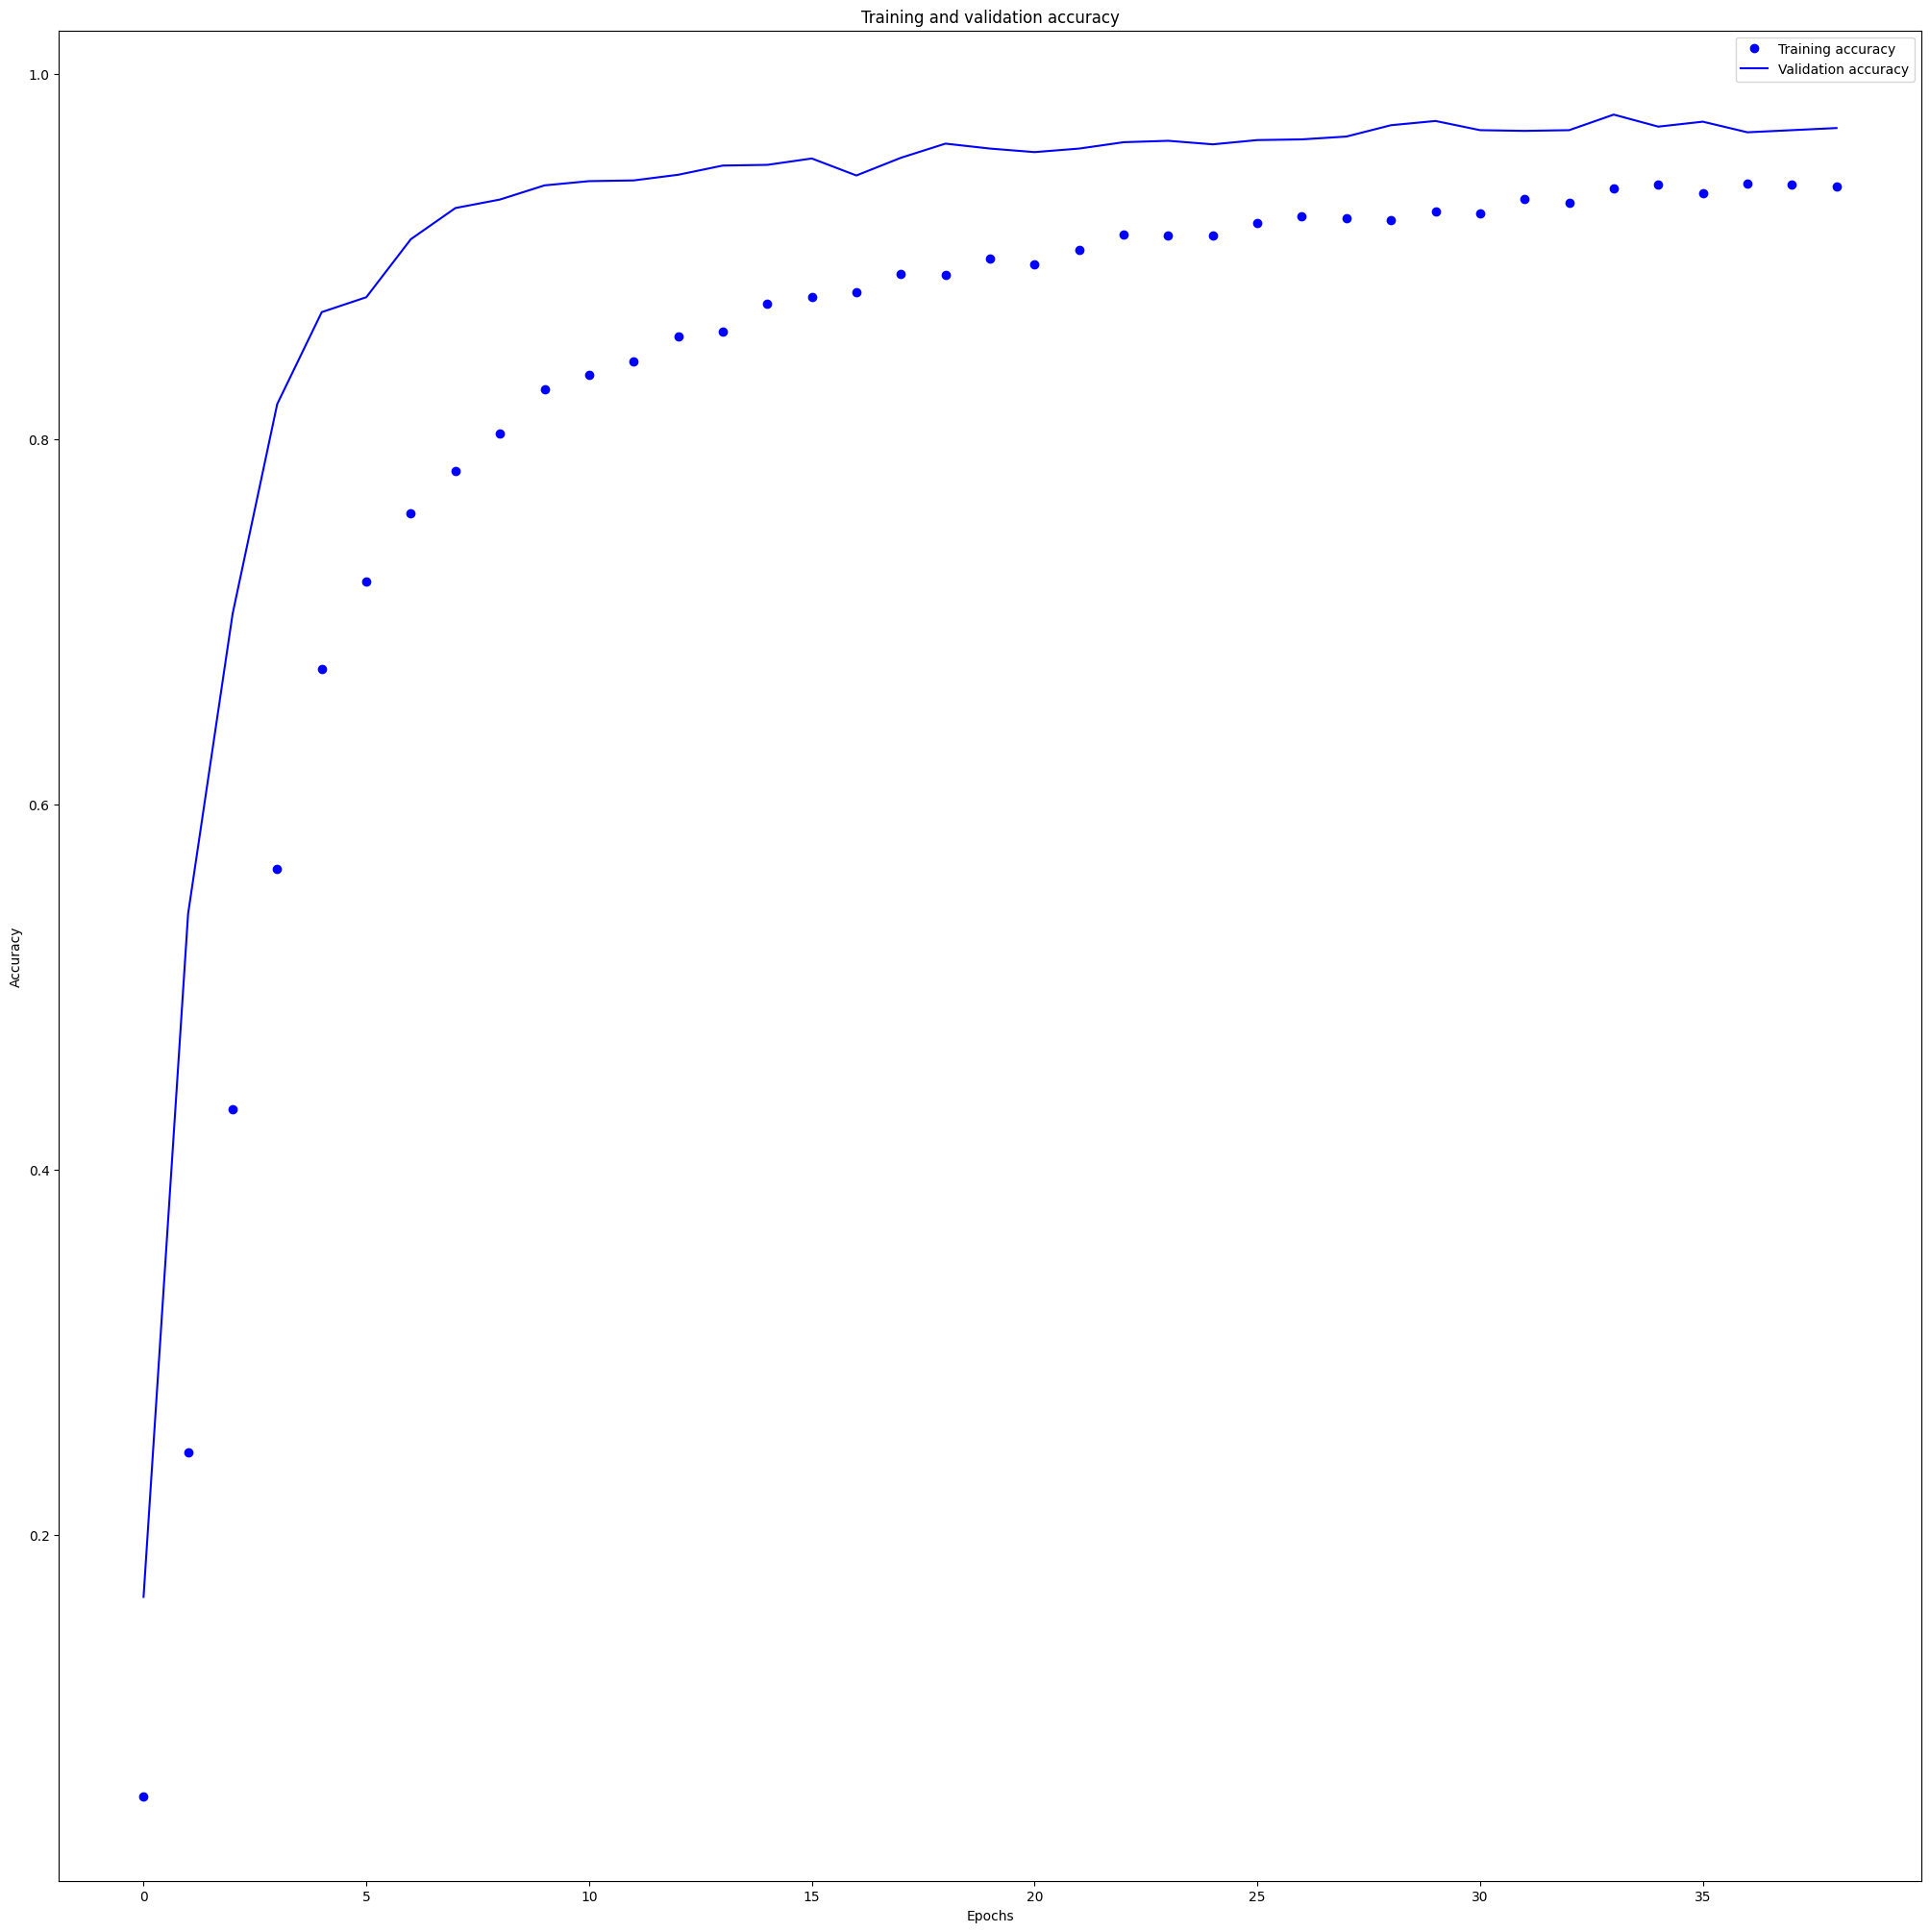

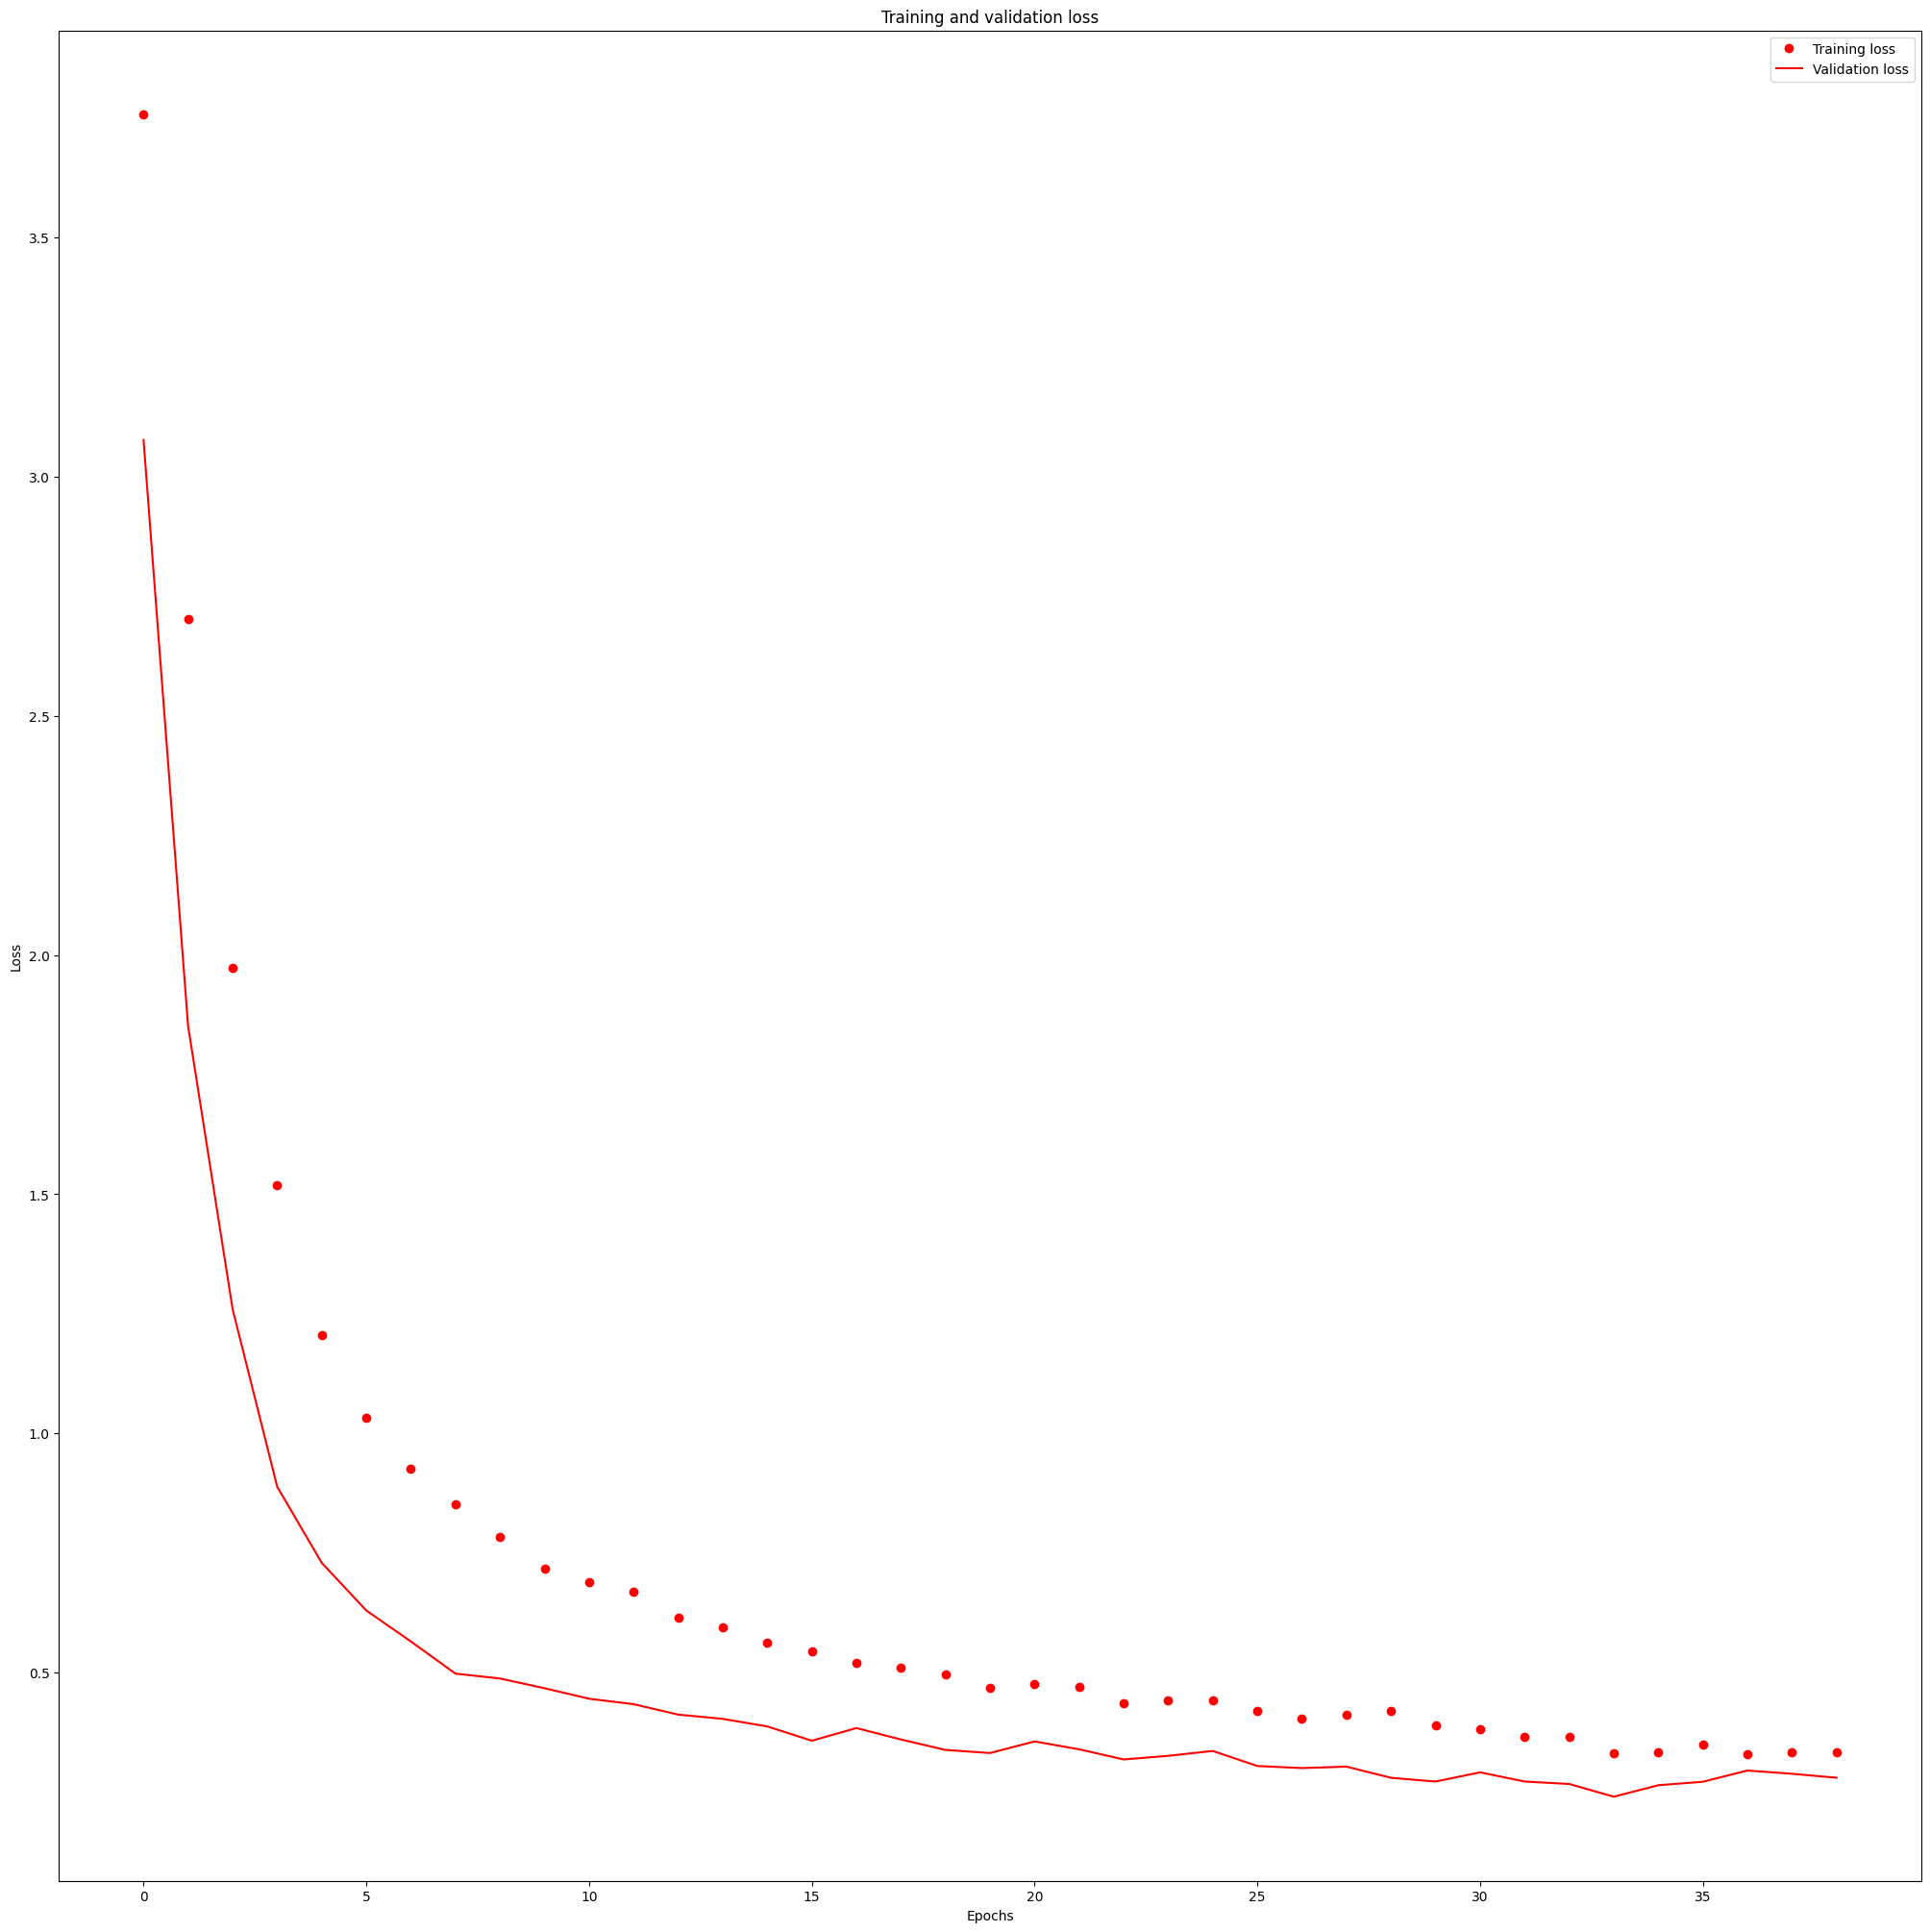

81/81 [==============================] - 0s 3ms/step
Classification report: 
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        60
           1     1.0000    0.9833    0.9916        60
           2     1.0000    0.9833    0.9916        60
           3     0.9355    0.9667    0.9508        60
           4     0.9180    0.9333    0.9256        60
           5     0.9677    1.0000    0.9836        60
           6     1.0000    1.0000    1.0000        60
           7     0.9677    1.0000    0.9836        60
           8     1.0000    1.0000    1.0000        60
           9     1.0000    0.9833    0.9916        60
          10     0.9808    0.8500    0.9107        60
          11     1.0000    0.9500    0.9744        60
          12     0.9375    1.0000    0.9677        60
          13     0.9677    1.0000    0.9836        60
          14     1.0000    0.7667    0.8679        60
          15     1.0000    1.0000    1.0000        60
    

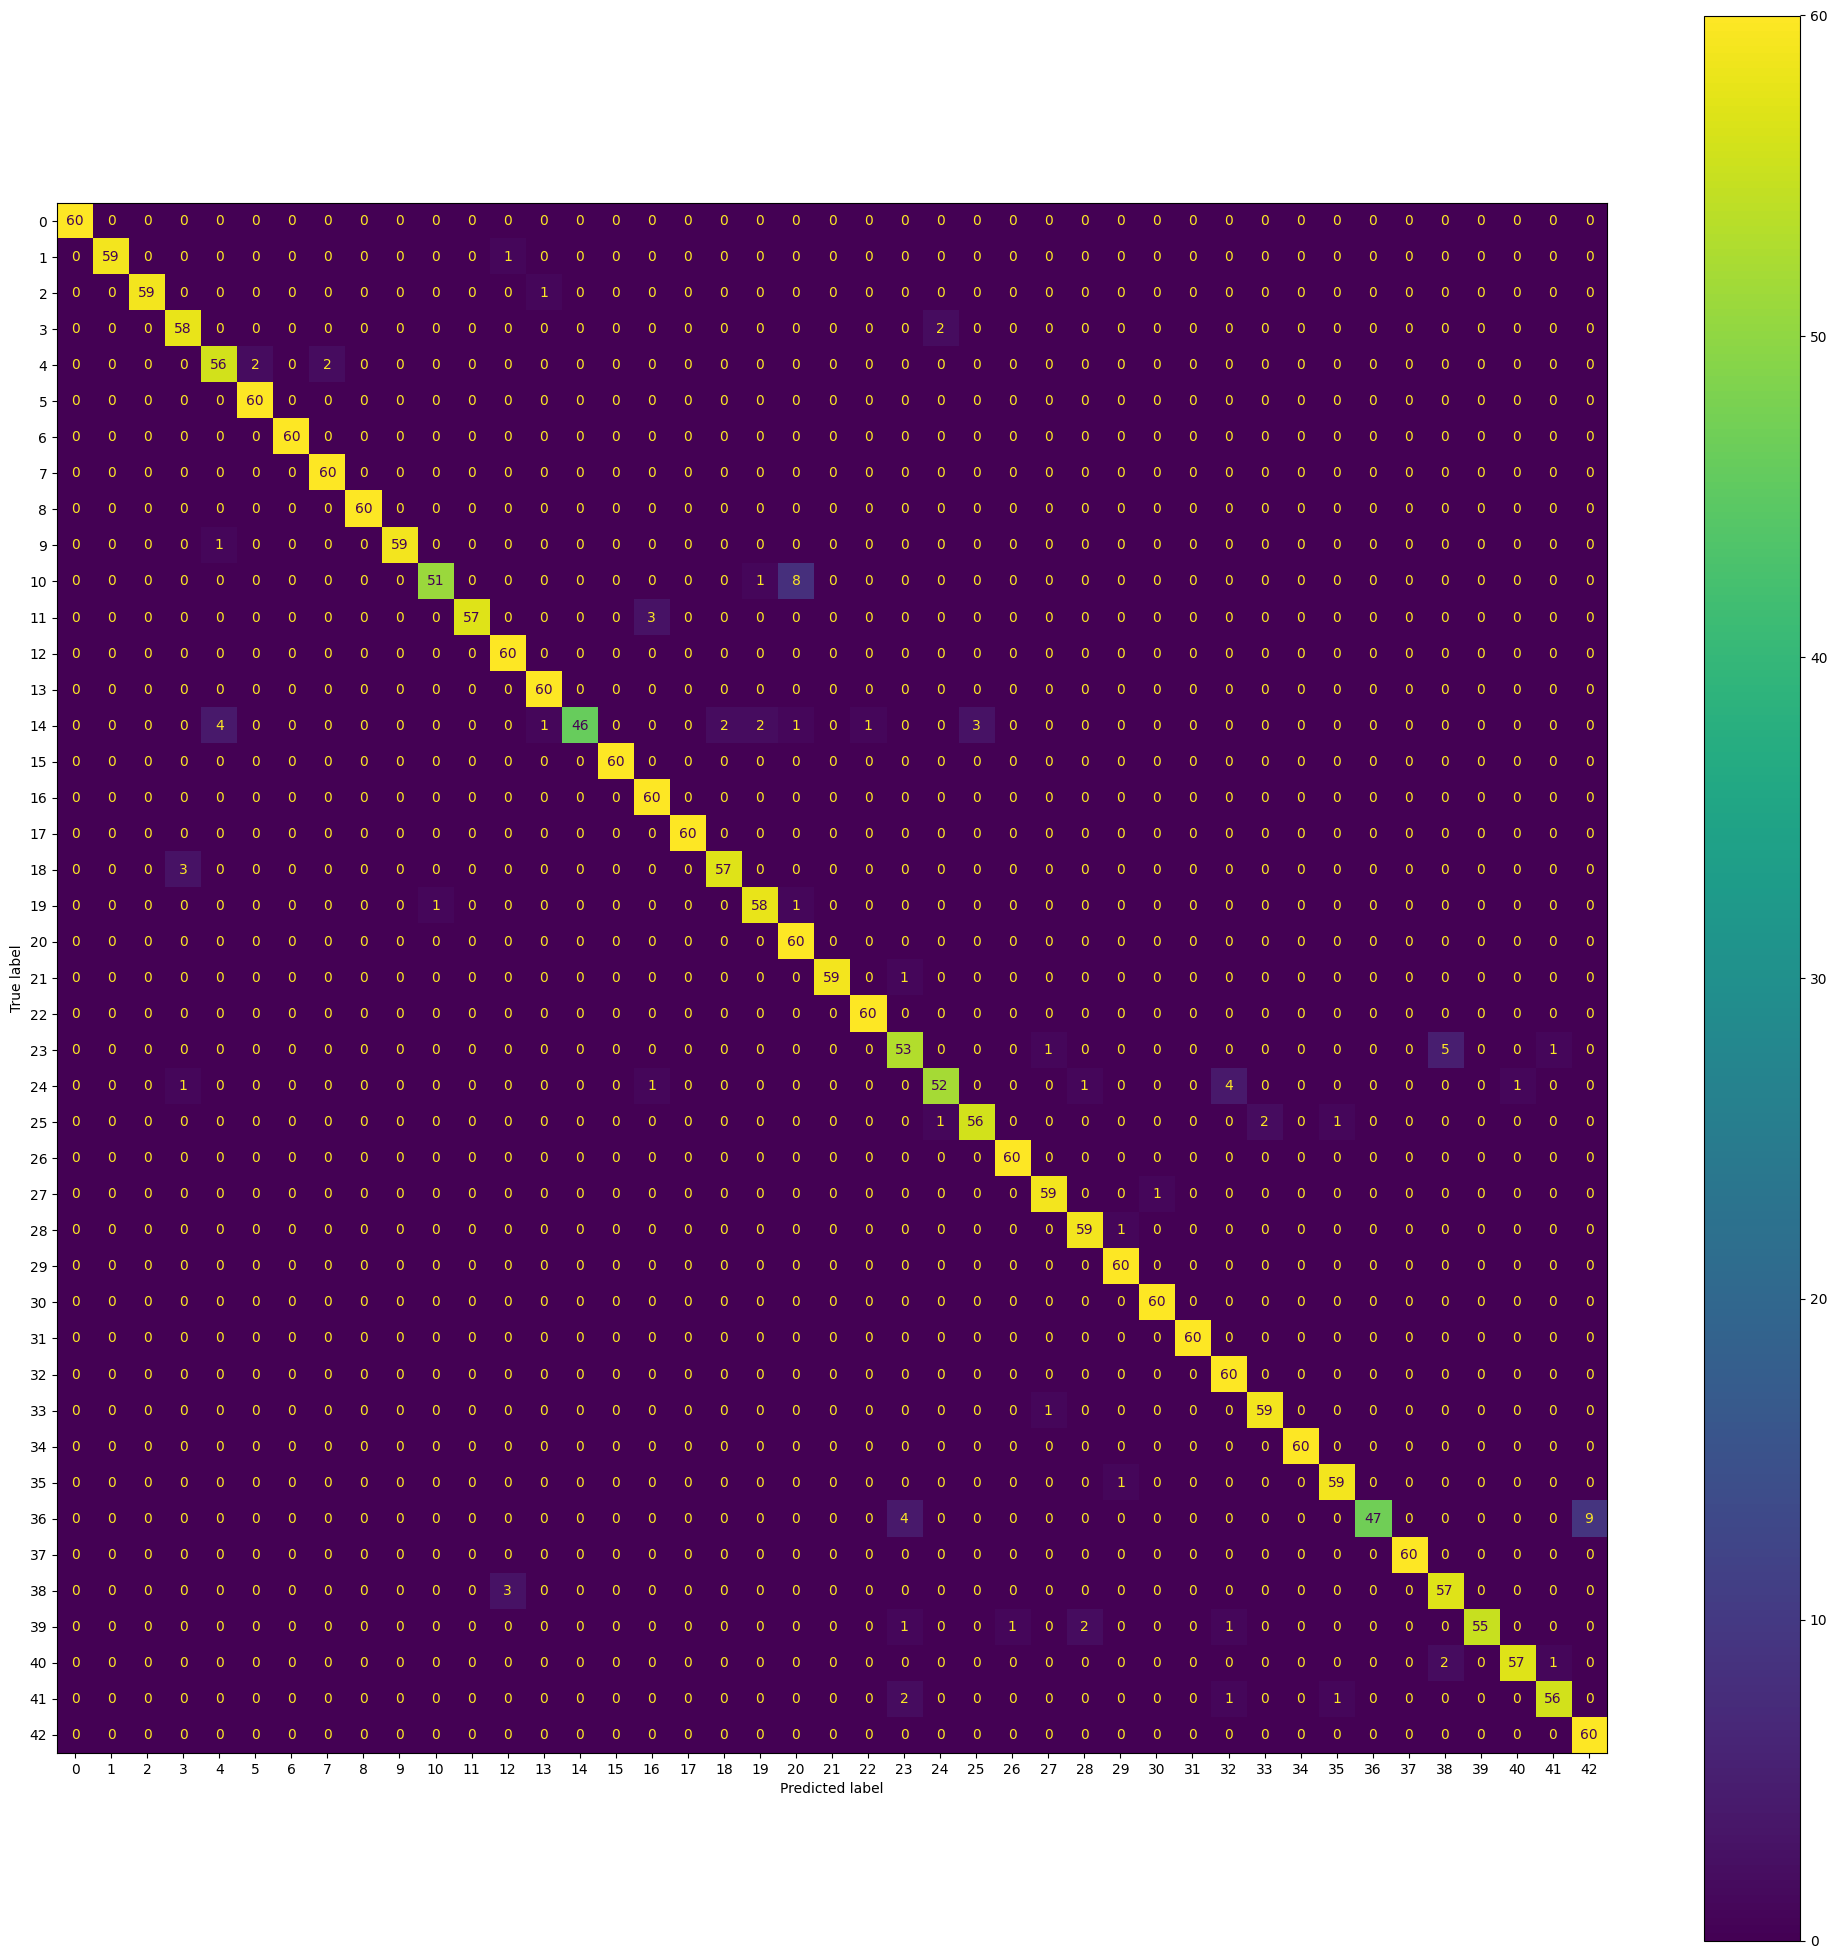

ROC Curve:


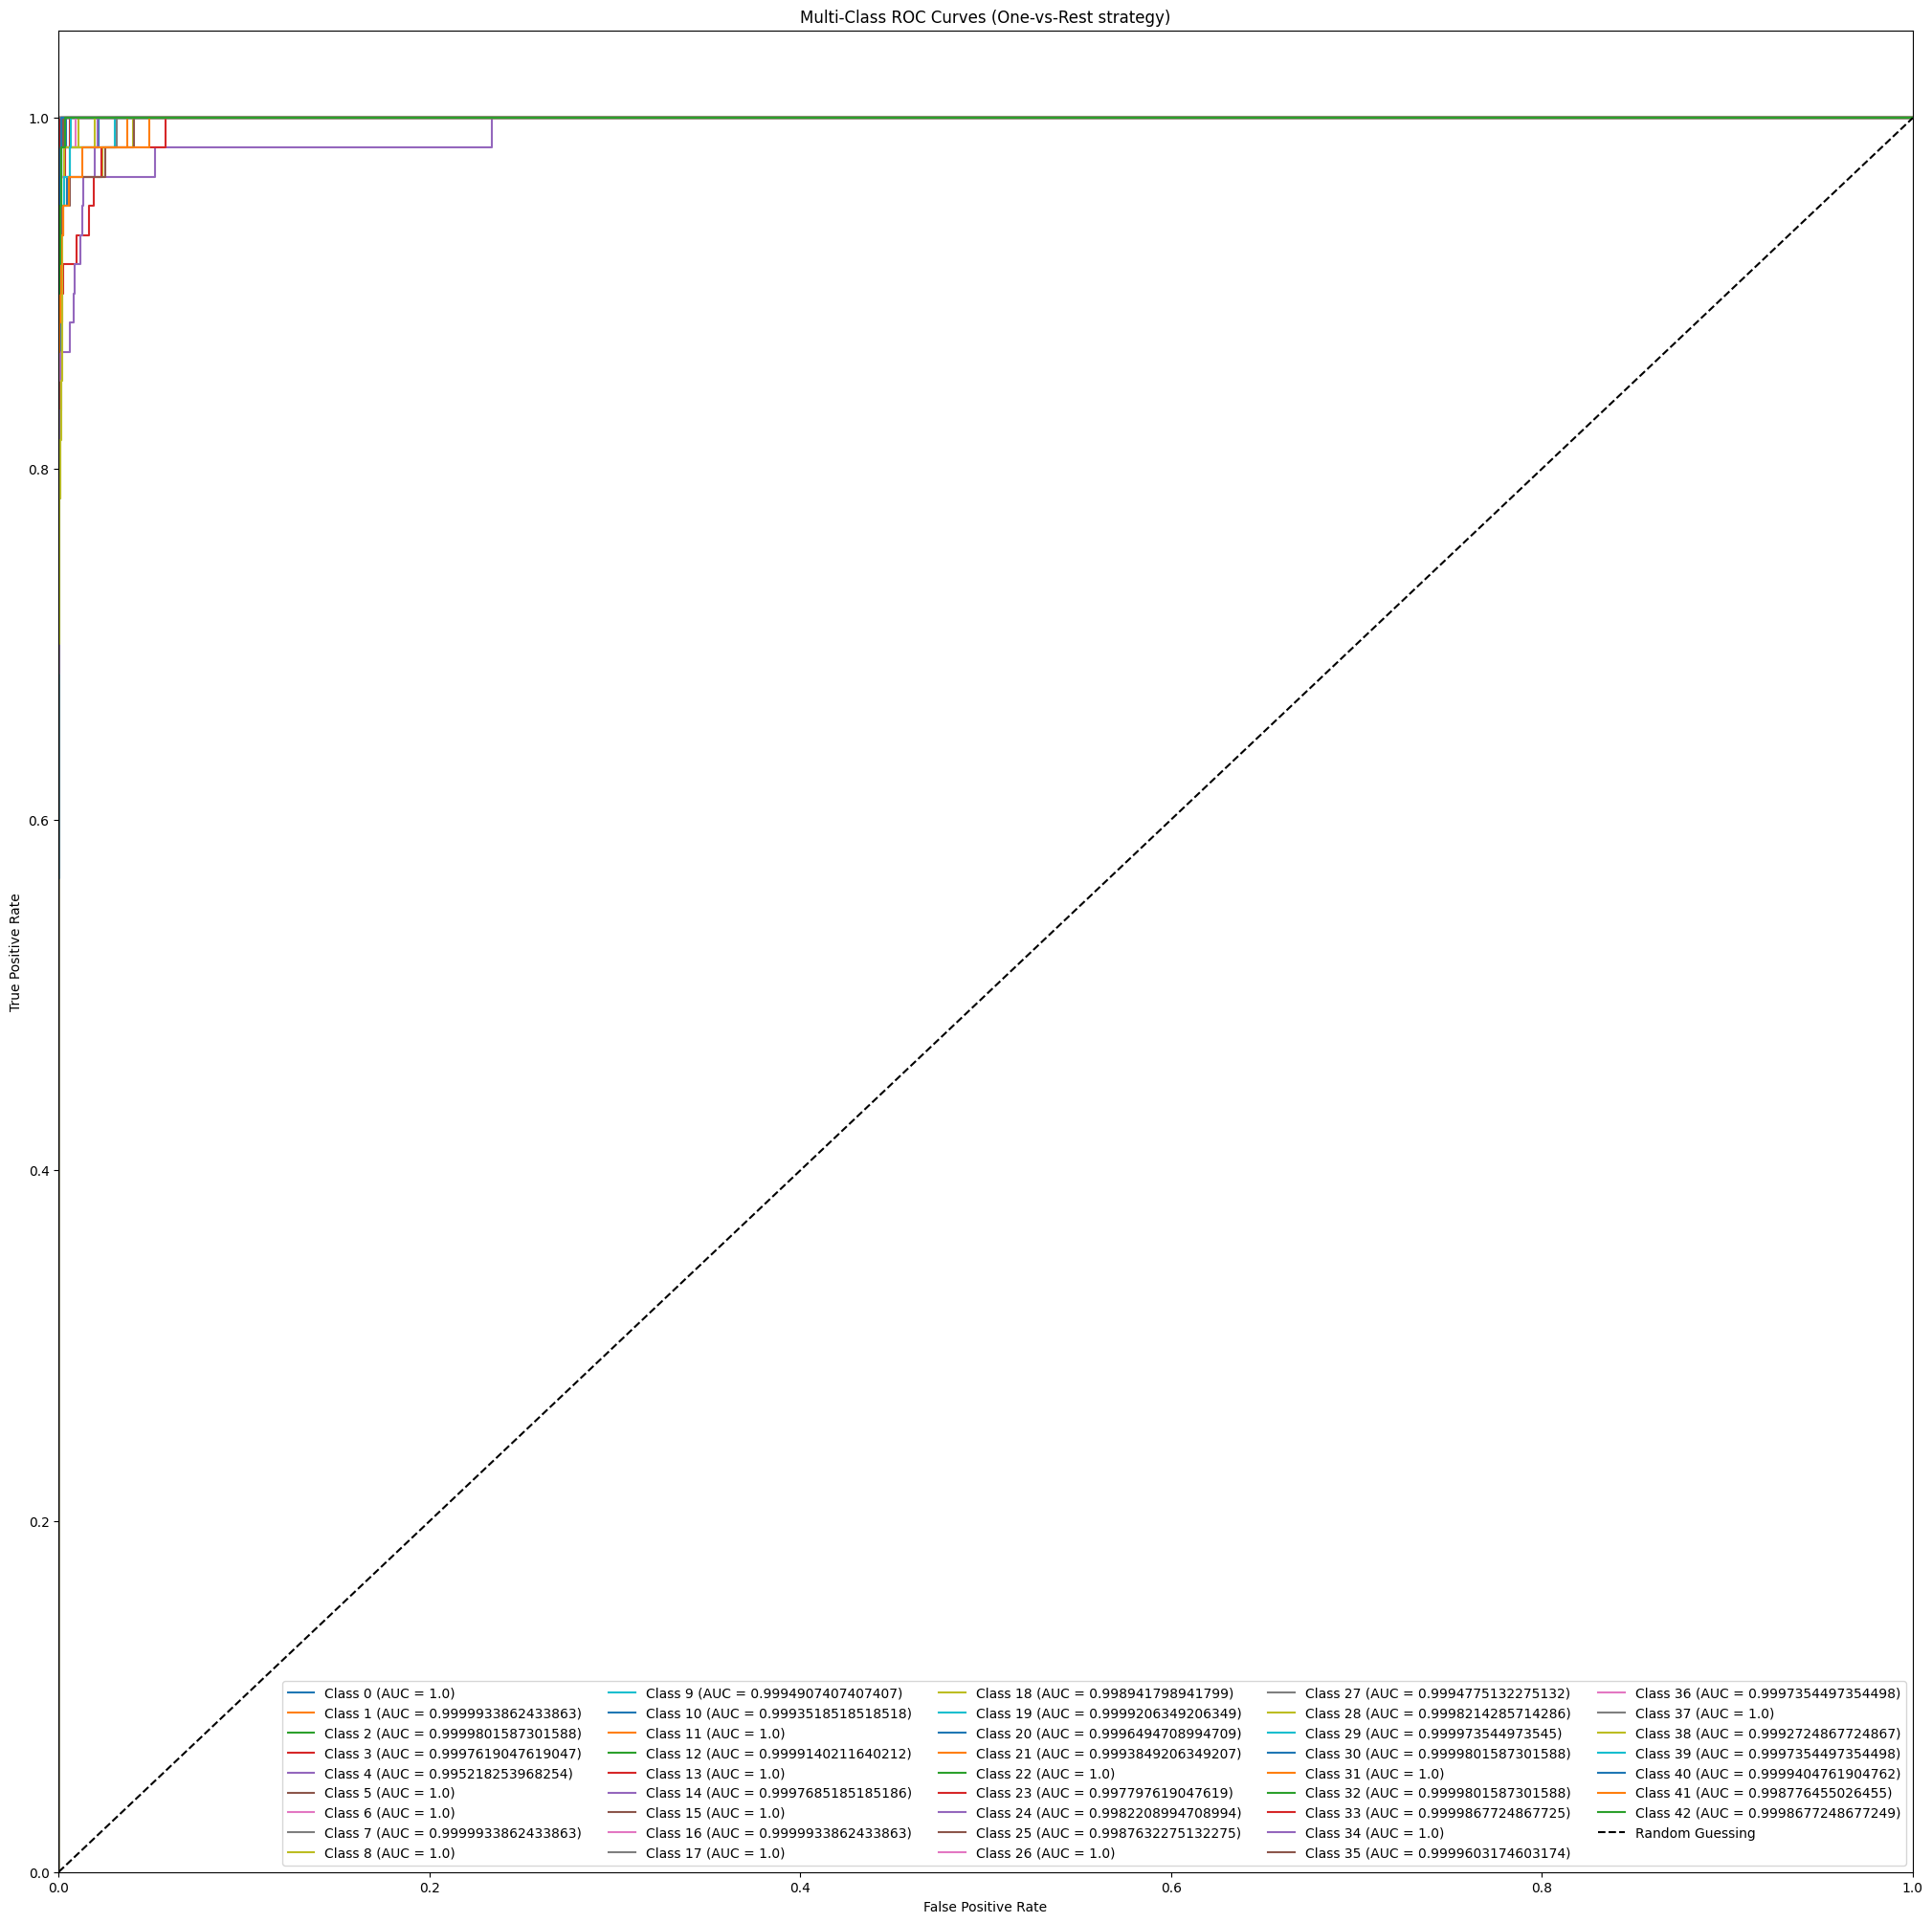

Test results - Loss: 0.2958419620990753 - Accuracy: 0.9643411040306091%
Top-K (K = 3) accuracy score: 0.986046511627907


In [ ]:
train_dir = os.path.join(WORK_DIR,"Train")
validation_dir = os.path.join(WORK_DIR,"Validation")
test_dir = os.path.join(WORK_DIR,"Test")

train, validation, test = load_datasets(train_dir, validation_dir, test_dir)
result = compile_and_fit(model_drop_l2, train, validation, epochs=50)
train_performance(result)
test_evaluation(model_drop_l2, test)

Thanks to the application of L2-Regularization the model achieves an accuracy of approximately 96.4% and a Top-K (K=3) score of approximately 0.986. The model was trained for 39 epochs, after which the early stopping mechanism was activated for overfitting. The dropout and application of L2-Regularization improved the overfitting condition.

___
5) Model with dropout and L2-Regularization with bigger dense layer.

The model is composed as follow:

* 3 Conv2d-MaxPooling2D layers (64,128,256)
* Dropout layer after first and second pooling layer and before the last dense layer
* Hidden Dense layer with 128 neurons with L2-Regularization

In [ ]:
input = keras.Input(shape=CUSTOM_INPUT_SHAPE)
x = layers.Rescaling(1./255)(input)

x = layers.Conv2D(filters=64, kernel_size = KERNEL_SIZE, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters=128, kernel_size = KERNEL_SIZE, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters=256, kernel_size = KERNEL_SIZE, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)

output = layers.Dense(43, activation='softmax')(x)

model_drop_l2_bigger = keras.Model(inputs=input, outputs=output, name="Model_drop_l2_bigger")
show_and_save_model_summary(model_drop_l2_bigger)

Model: "Model_drop_l2_bigger"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 rescaling_15 (Rescaling)    (None, 48, 48, 3)         0         
                                                                 
 conv2d_45 (Conv2D)          (None, 45, 45, 64)        3136      
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 22, 22, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_50 (Dropout)        (None, 22, 22, 64)        0         
                                                                 
 conv2d_46 (Conv2D)          (None, 19, 19, 128)       131200    
                                              

Load the dataset, train the model and evaluate it. Number of epochs are increased to 50

Found 6450 files belonging to 43 classes.
Found 2580 files belonging to 43 classes.
Found 2580 files belonging to 43 classes.
Epoch 1/50
199/202 [============================>.] - ETA: 0s - loss: 3.9076 - accuracy: 0.0609
Epoch 1: val_loss improved from inf to 2.80479, saving model to /content/drive/Shareddrives/Biondi/Models/Model_drop_l2_bigger.h5
202/202 [==============================] - 5s 16ms/step - loss: 3.8951 - accuracy: 0.0636 - val_loss: 2.8048 - val_accuracy: 0.2740
Epoch 2/50
  1/202 [..............................] - ETA: 15s - loss: 3.0241 - accuracy: 0.1875

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/202 [============================>.] - ETA: 0s - loss: 2.2467 - accuracy: 0.4118
Epoch 2: val_loss improved from 2.80479 to 1.36814, saving model to /content/drive/Shareddrives/Biondi/Models/Model_drop_l2_bigger.h5
202/202 [==============================] - 4s 21ms/step - loss: 2.2338 - accuracy: 0.4152 - val_loss: 1.3681 - val_accuracy: 0.7271
Epoch 3/50
197/202 [============================>.] - ETA: 0s - loss: 1.3068 - accuracy: 0.6970
Epoch 3: val_loss improved from 1.36814 to 0.94715, saving model to /content/drive/Shareddrives/Biondi/Models/Model_drop_l2_bigger.h5
202/202 [==============================] - 3s 16ms/step - loss: 1.3025 - accuracy: 0.6983 - val_loss: 0.9471 - val_accuracy: 0.8349
Epoch 4/50
200/202 [============================>.] - ETA: 0s - loss: 0.9692 - accuracy: 0.8062
Epoch 4: val_loss improved from 0.94715 to 0.74561, saving model to /content/drive/Shareddrives/Biondi/Models/Model_drop_l2_bigger.h5
202/202 [==============================] - 4s 18ms/step -

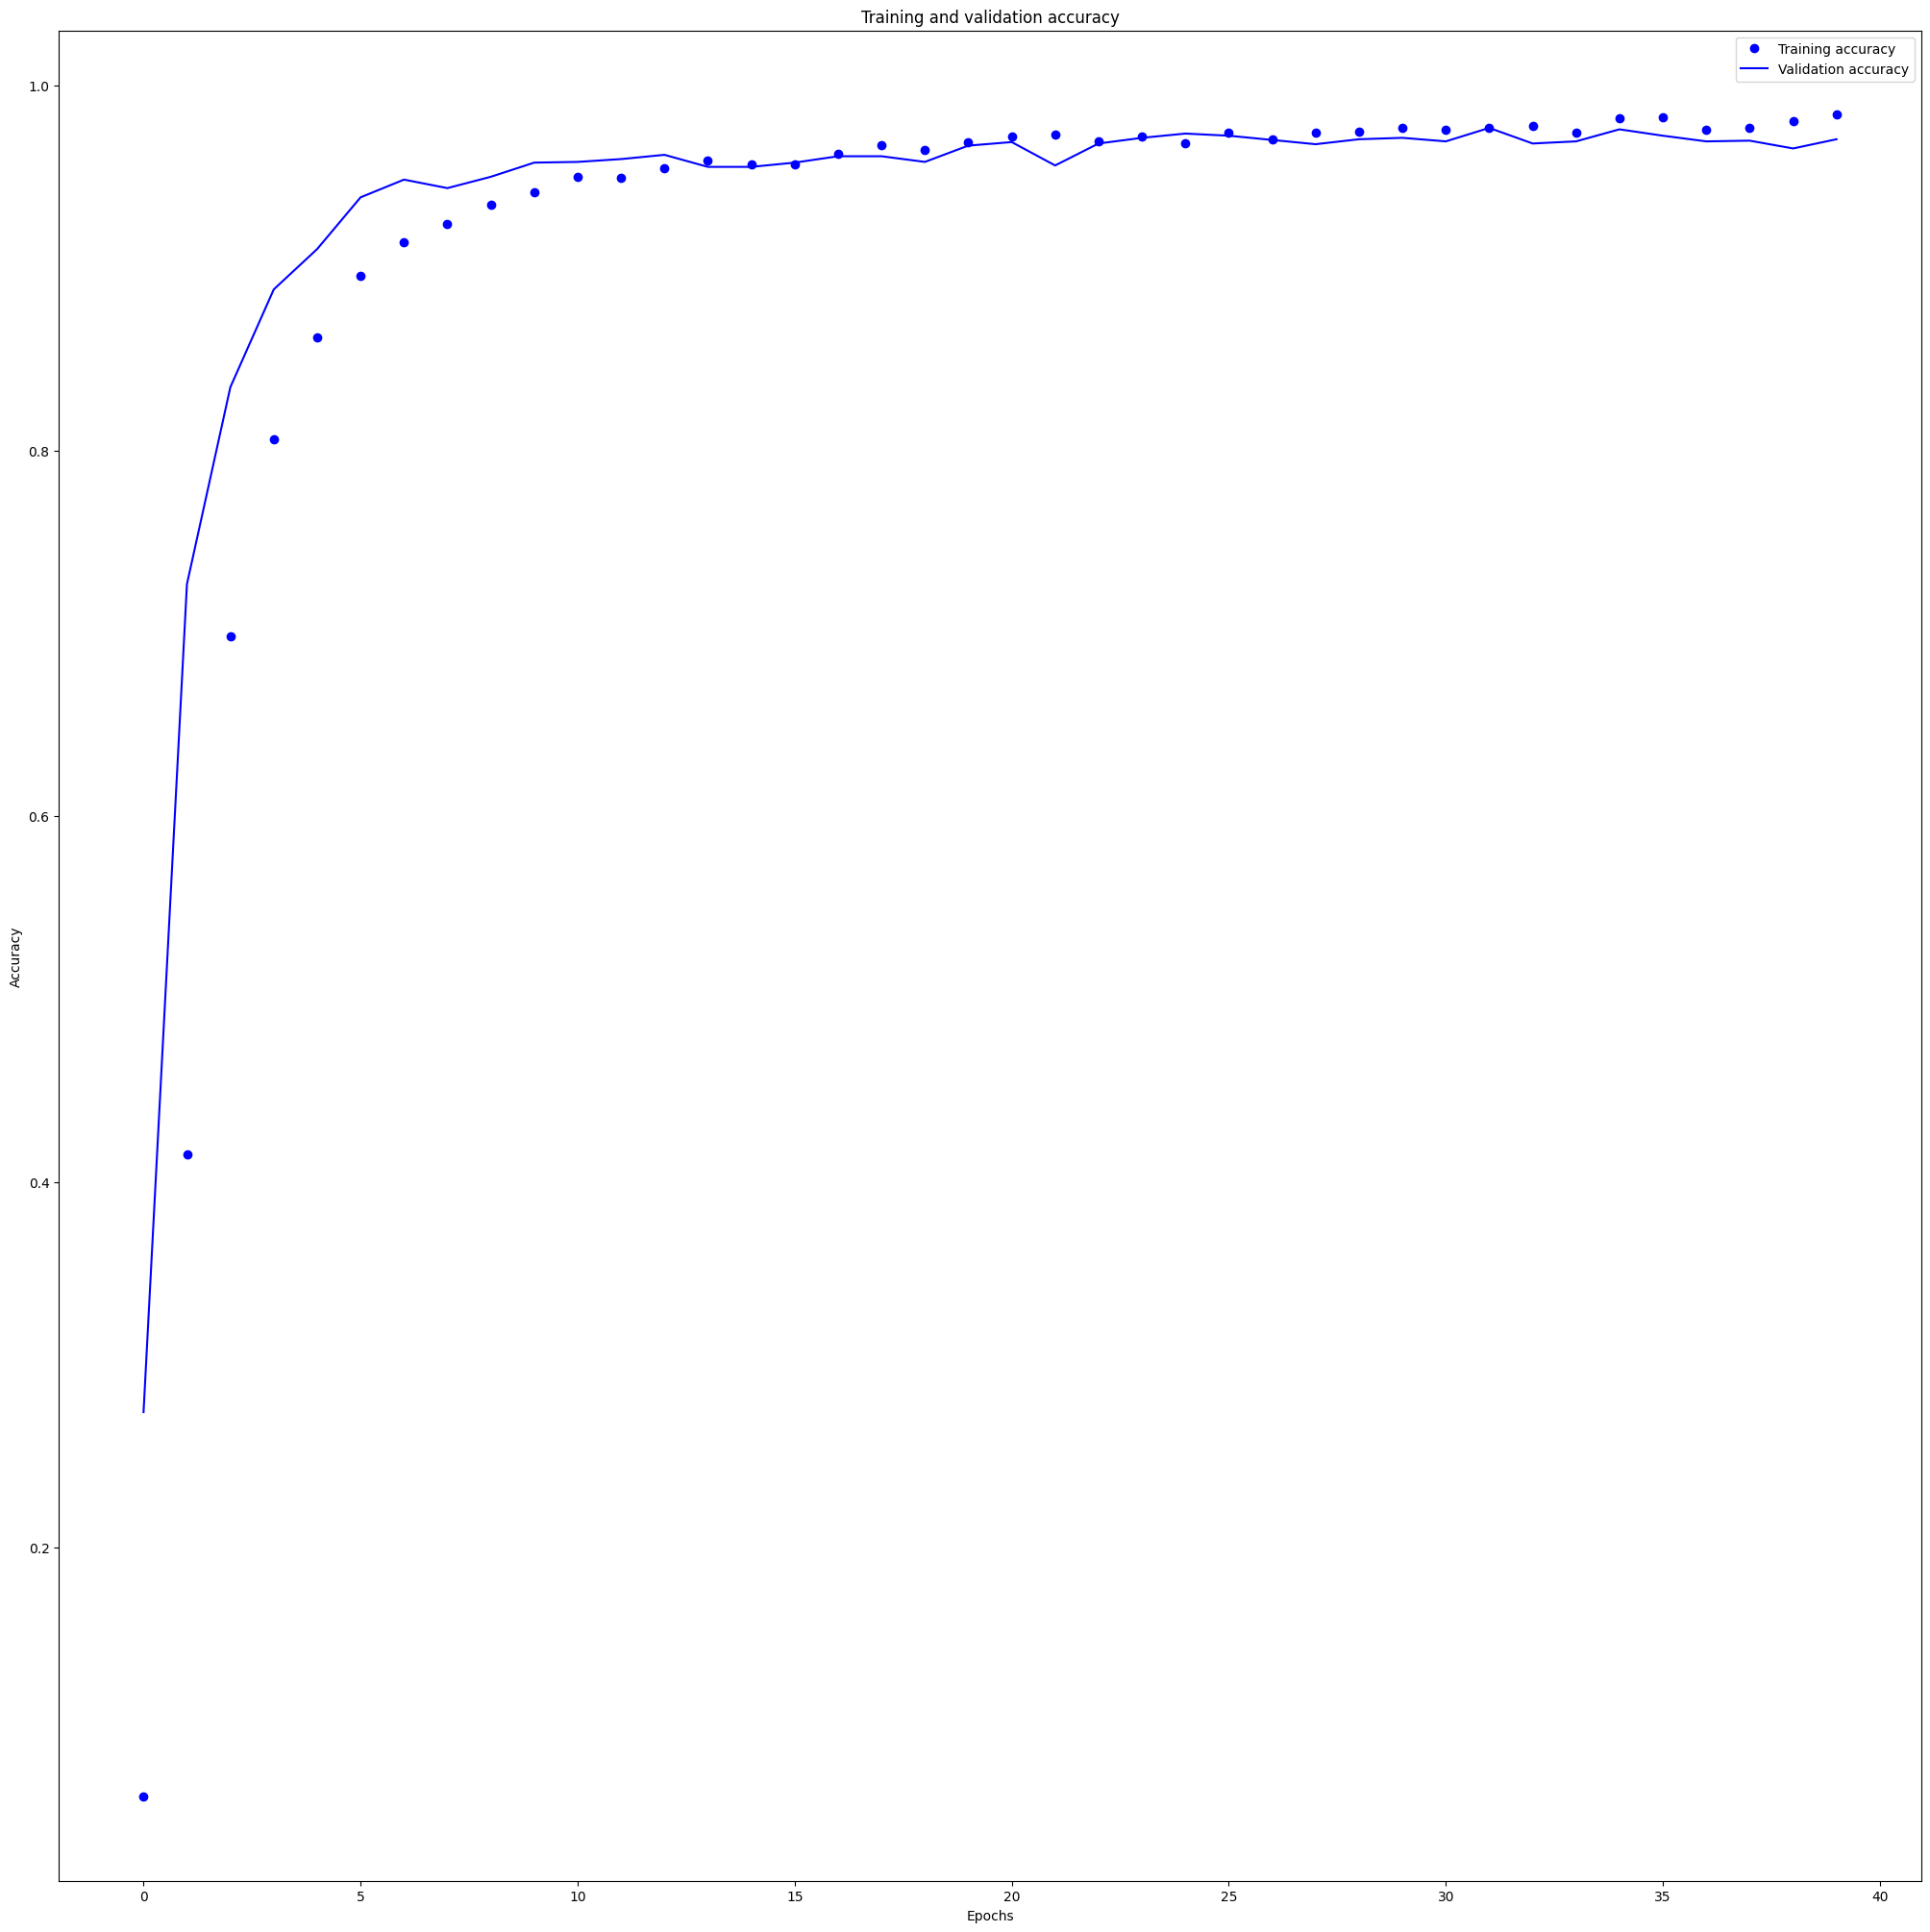

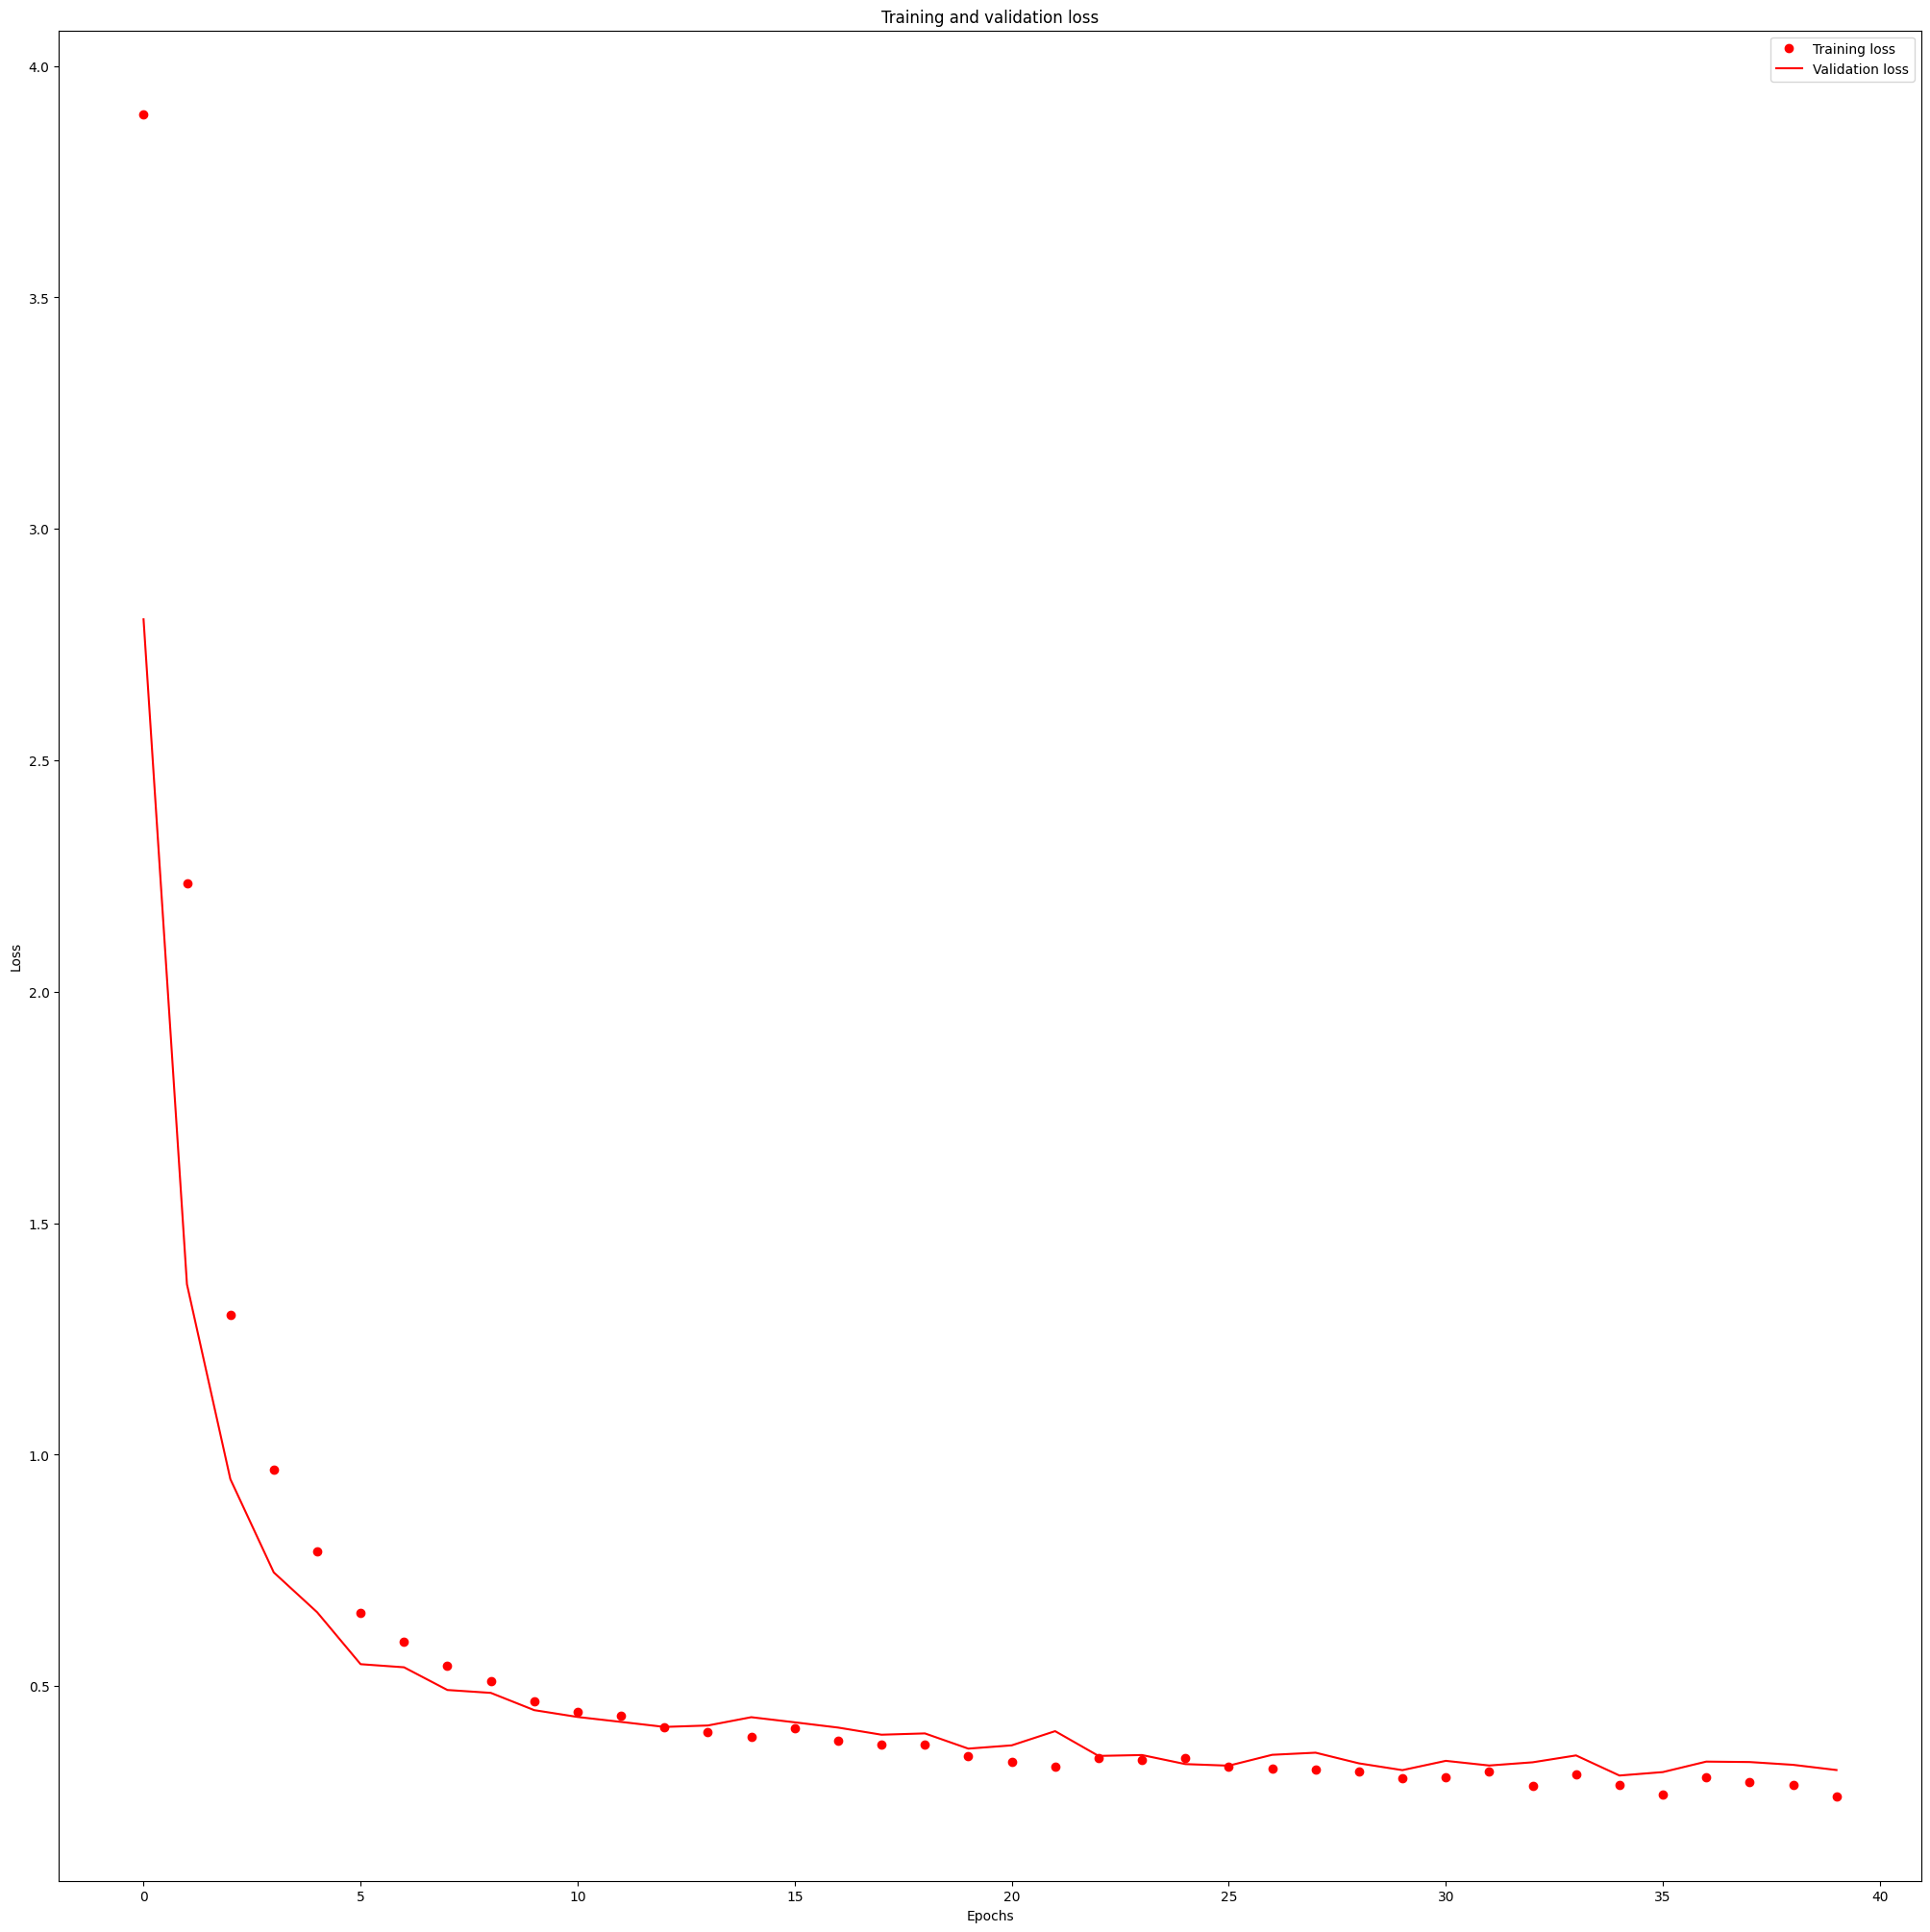

81/81 [==============================] - 0s 4ms/step
Classification report: 
              precision    recall  f1-score   support

           0     1.0000    0.9667    0.9831        60
           1     0.9524    1.0000    0.9756        60
           2     0.9836    1.0000    0.9917        60
           3     0.6122    1.0000    0.7595        60
           4     1.0000    0.9667    0.9831        60
           5     1.0000    1.0000    1.0000        60
           6     0.9836    1.0000    0.9917        60
           7     0.9677    1.0000    0.9836        60
           8     1.0000    1.0000    1.0000        60
           9     1.0000    1.0000    1.0000        60
          10     0.9643    0.9000    0.9310        60
          11     0.9677    1.0000    0.9836        60
          12     0.9833    0.9833    0.9833        60
          13     0.8571    1.0000    0.9231        60
          14     1.0000    0.8833    0.9381        60
          15     1.0000    1.0000    1.0000        60
    

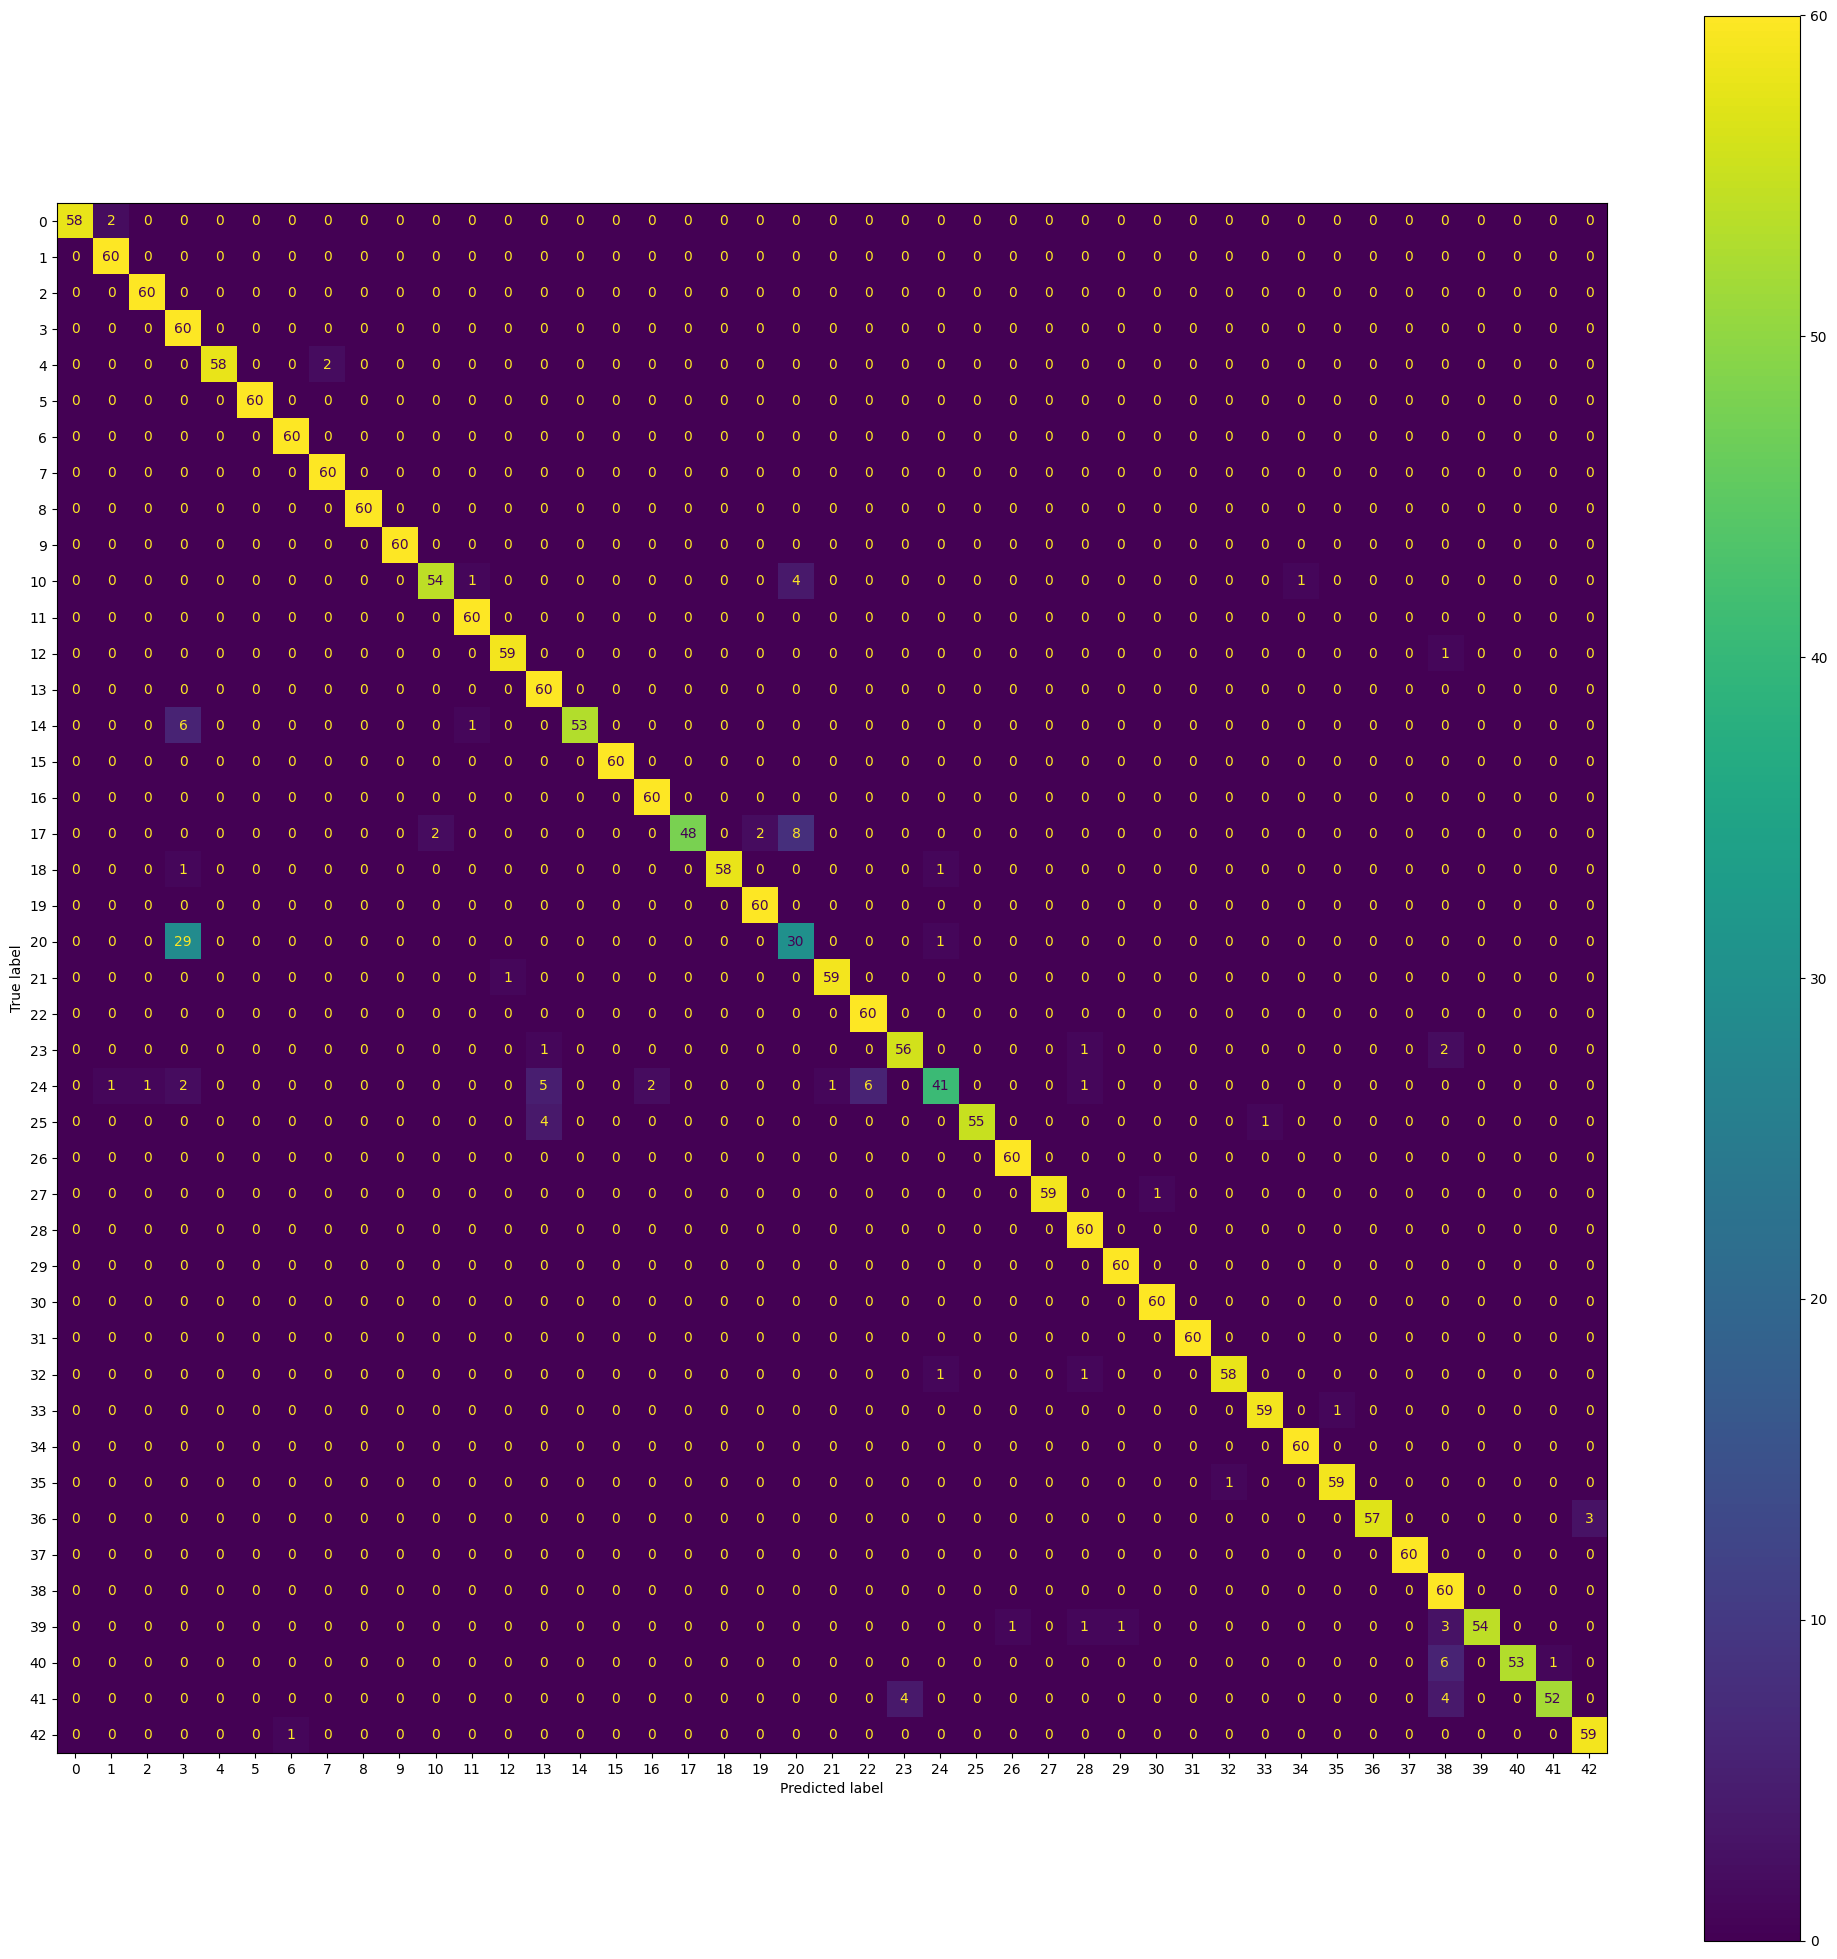

ROC Curve:


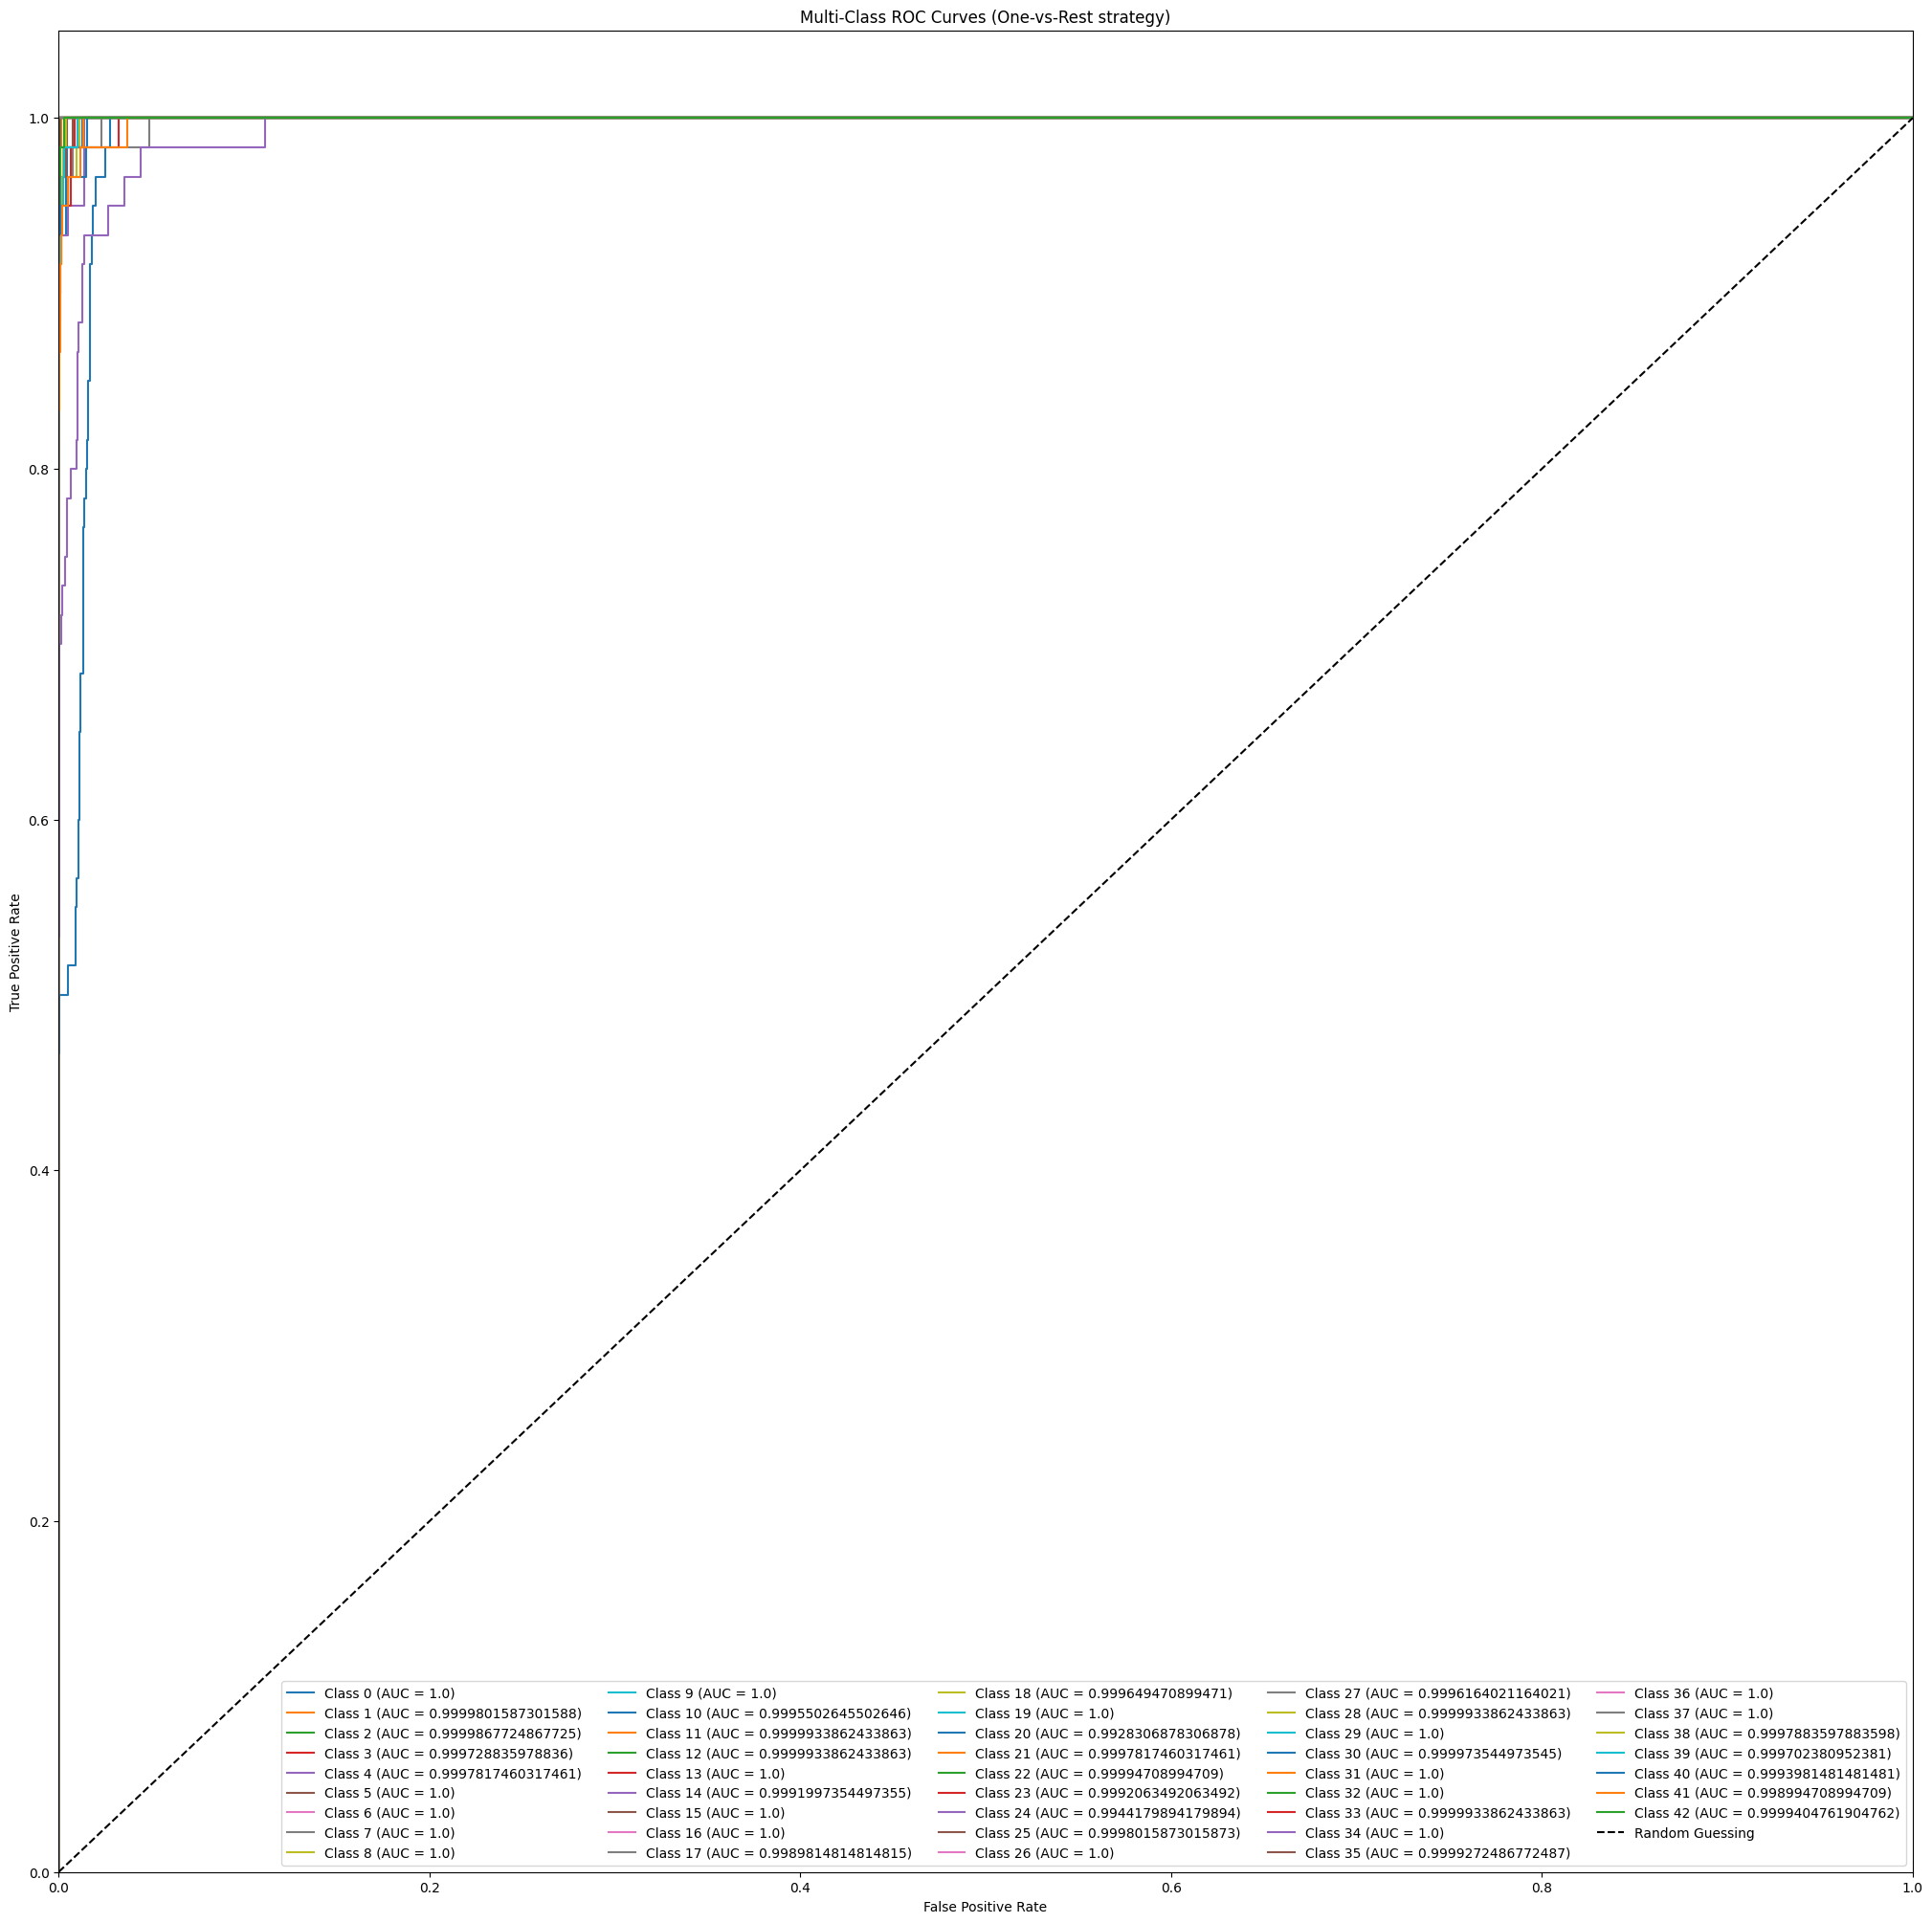

Test results - Loss: 0.3808634579181671 - Accuracy: 0.9531008005142212%
Top-K (K = 3) accuracy score: 0.982170542635659


In [ ]:
train_dir = os.path.join(WORK_DIR,"Train")
validation_dir = os.path.join(WORK_DIR,"Validation")
test_dir = os.path.join(WORK_DIR,"Test")

train, validation, test = load_datasets(train_dir, validation_dir, test_dir)
result = compile_and_fit(model_drop_l2_bigger, train, validation, epochs=50)
train_performance(result)
test_evaluation(model_drop_l2_bigger, test)

The model achieves an accuracy of approximately 95.3% and a Top-K score (K=3) of approximately 0.982. The model was trained for 40 epochs, after which the early stopping mechanism was activated for overfitting. The model presents slightly worst performance than the previous ones.

6) Model similar to model 4 but with different dropout and L2-Regularization rates.

The model is composed as follow:

* 3 Conv2d-MaxPooling2D layers (64,128,256)
* Dropout layer after first and second pooling layer and before the last dense layer
* Hidden Dense layer with 64 neurons with L2-Regularization

In [ ]:
input = keras.Input(shape=CUSTOM_INPUT_SHAPE)
x = layers.Rescaling(1./255)(input)

x = layers.Conv2D(filters=64, kernel_size = KERNEL_SIZE, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters=128, kernel_size = KERNEL_SIZE, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(filters=256, kernel_size = KERNEL_SIZE, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)

output = layers.Dense(43, activation='softmax')(x)

model_drop_l2_v2 = keras.Model(inputs=input, outputs=output, name="Model_drop_l2_v2")
show_and_save_model_summary(model_drop_l2_v2)

Model: "Model_drop_l2_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 rescaling_21 (Rescaling)    (None, 48, 48, 3)         0         
                                                                 
 conv2d_63 (Conv2D)          (None, 45, 45, 64)        3136      
                                                                 
 max_pooling2d_63 (MaxPooli  (None, 22, 22, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_74 (Dropout)        (None, 22, 22, 64)        0         
                                                                 
 conv2d_64 (Conv2D)          (None, 19, 19, 128)       131200    
                                                  

Load the dataset, train the model and evaluate it. Number of epochs are increased to 50

Found 6450 files belonging to 43 classes.
Found 2580 files belonging to 43 classes.
Found 2580 files belonging to 43 classes.
Epoch 1/50
198/202 [============================>.] - ETA: 0s - loss: 3.7005 - accuracy: 0.0500
Epoch 1: val_loss improved from inf to 3.28604, saving model to /content/drive/Shareddrives/Biondi/Models/Model_drop_l2_v2.h5
202/202 [==============================] - 6s 16ms/step - loss: 3.6970 - accuracy: 0.0507 - val_loss: 3.2860 - val_accuracy: 0.1829
Epoch 2/50
  1/202 [..............................] - ETA: 15s - loss: 3.3233 - accuracy: 0.0938

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


199/202 [============================>.] - ETA: 0s - loss: 2.9842 - accuracy: 0.2021
Epoch 2: val_loss improved from 3.28604 to 2.12696, saving model to /content/drive/Shareddrives/Biondi/Models/Model_drop_l2_v2.h5
202/202 [==============================] - 3s 15ms/step - loss: 2.9767 - accuracy: 0.2040 - val_loss: 2.1270 - val_accuracy: 0.4295
Epoch 3/50
199/202 [============================>.] - ETA: 0s - loss: 2.0434 - accuracy: 0.4094
Epoch 3: val_loss improved from 2.12696 to 1.37699, saving model to /content/drive/Shareddrives/Biondi/Models/Model_drop_l2_v2.h5
202/202 [==============================] - 4s 18ms/step - loss: 2.0375 - accuracy: 0.4104 - val_loss: 1.3770 - val_accuracy: 0.6539
Epoch 4/50
197/202 [============================>.] - ETA: 0s - loss: 1.4677 - accuracy: 0.5603
Epoch 4: val_loss improved from 1.37699 to 0.92093, saving model to /content/drive/Shareddrives/Biondi/Models/Model_drop_l2_v2.h5
202/202 [==============================] - 5s 23ms/step - loss: 1.464

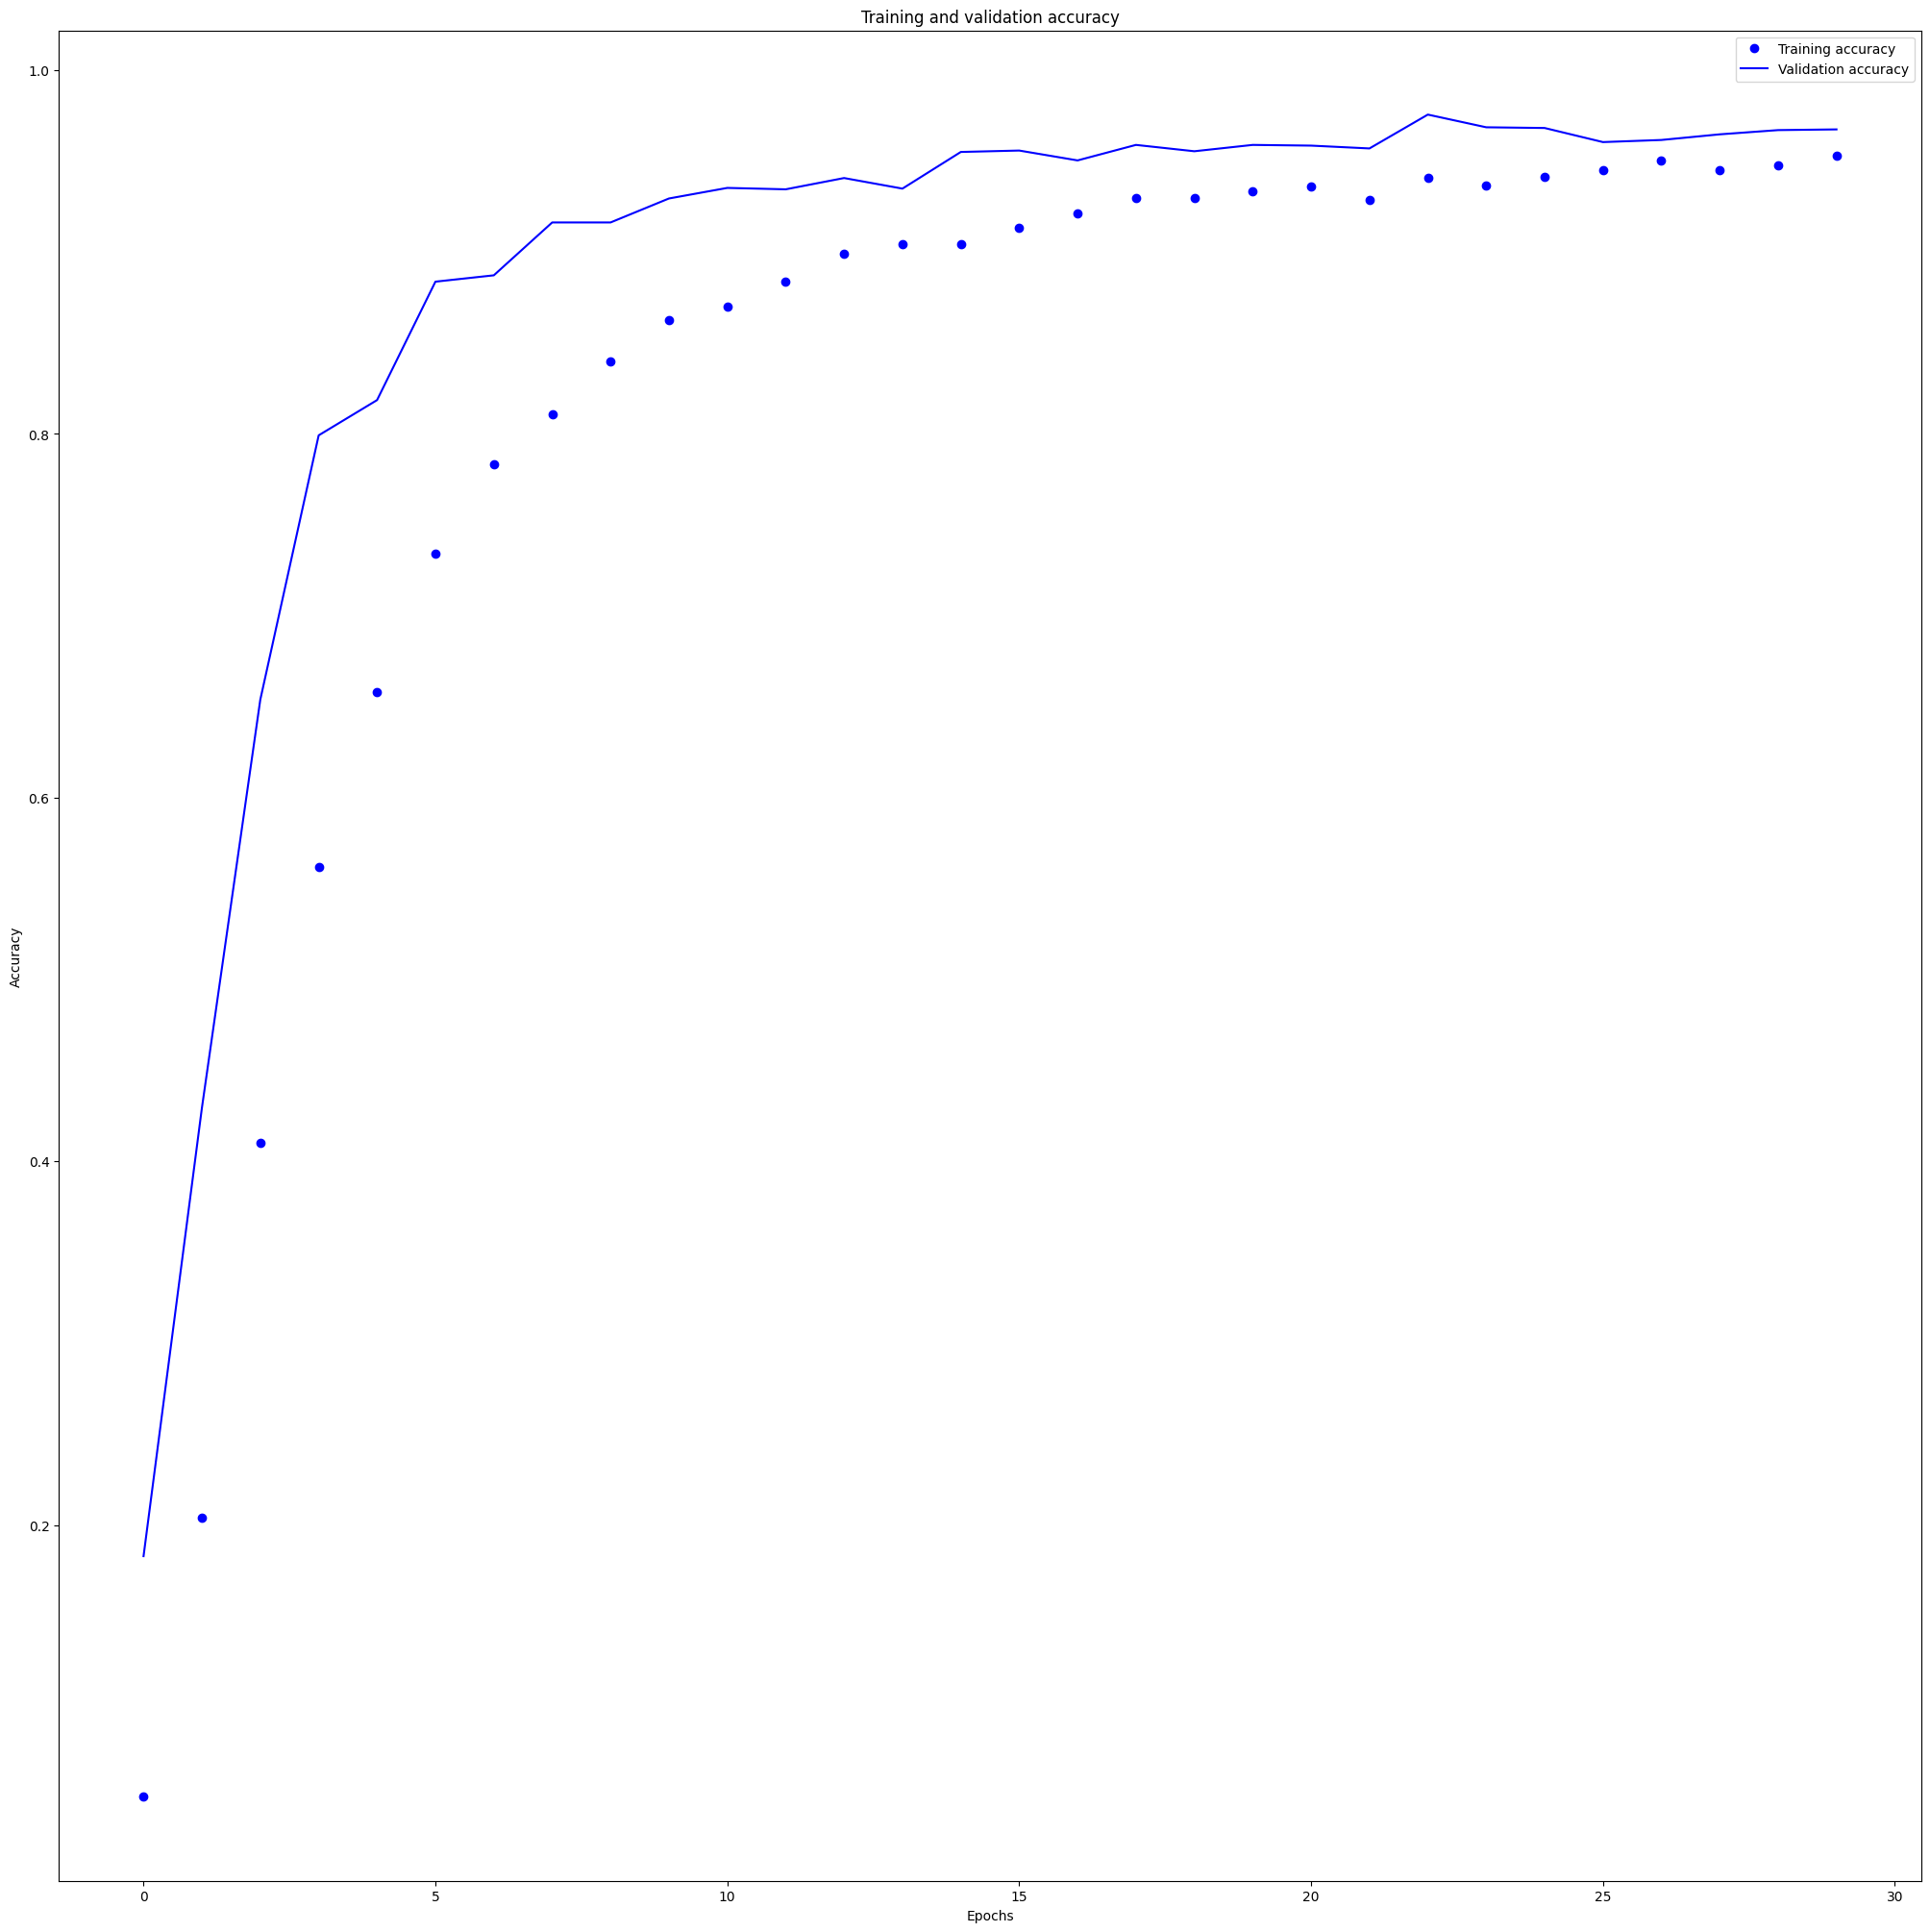

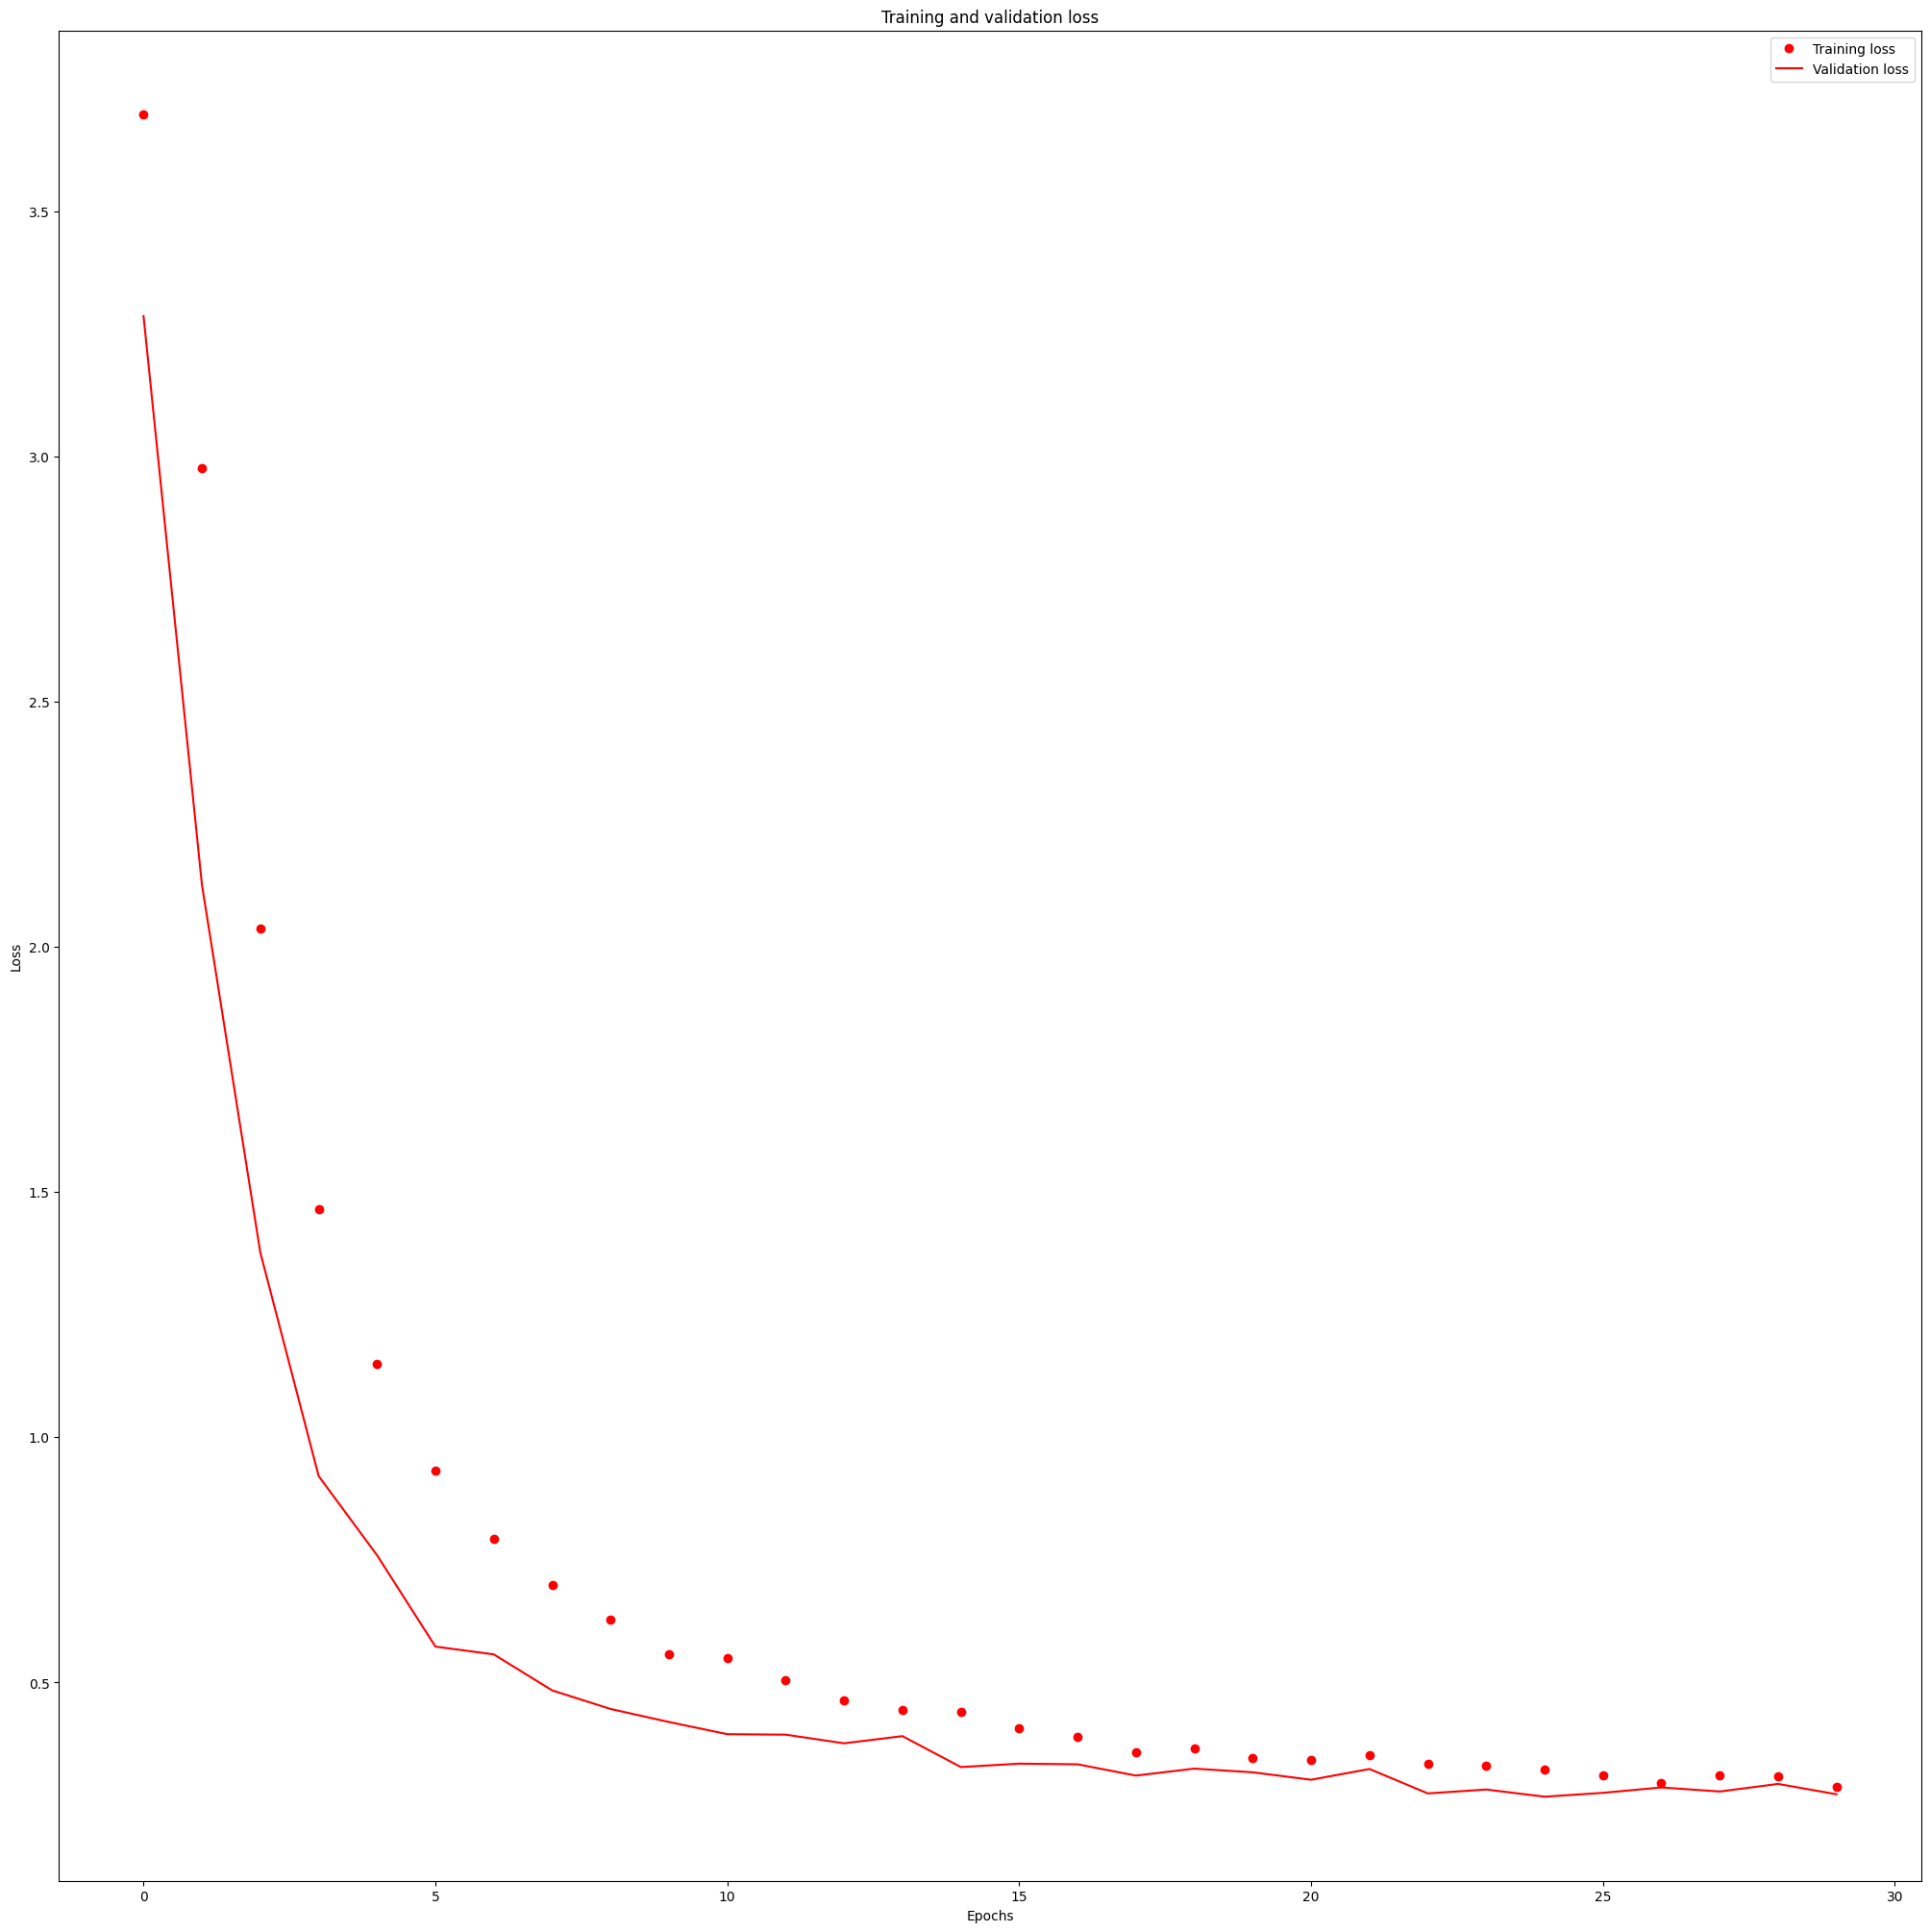

81/81 [==============================] - 0s 4ms/step
Classification report: 
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        60
           1     1.0000    1.0000    1.0000        60
           2     0.9833    0.9833    0.9833        60
           3     0.9500    0.9500    0.9500        60
           4     0.9355    0.9667    0.9508        60
           5     1.0000    1.0000    1.0000        60
           6     1.0000    1.0000    1.0000        60
           7     0.9836    1.0000    0.9917        60
           8     1.0000    0.9833    0.9916        60
           9     1.0000    0.9667    0.9831        60
          10     0.9821    0.9167    0.9483        60
          11     1.0000    1.0000    1.0000        60
          12     1.0000    1.0000    1.0000        60
          13     0.7895    1.0000    0.8824        60
          14     0.9836    1.0000    0.9917        60
          15     1.0000    0.8833    0.9381        60
    

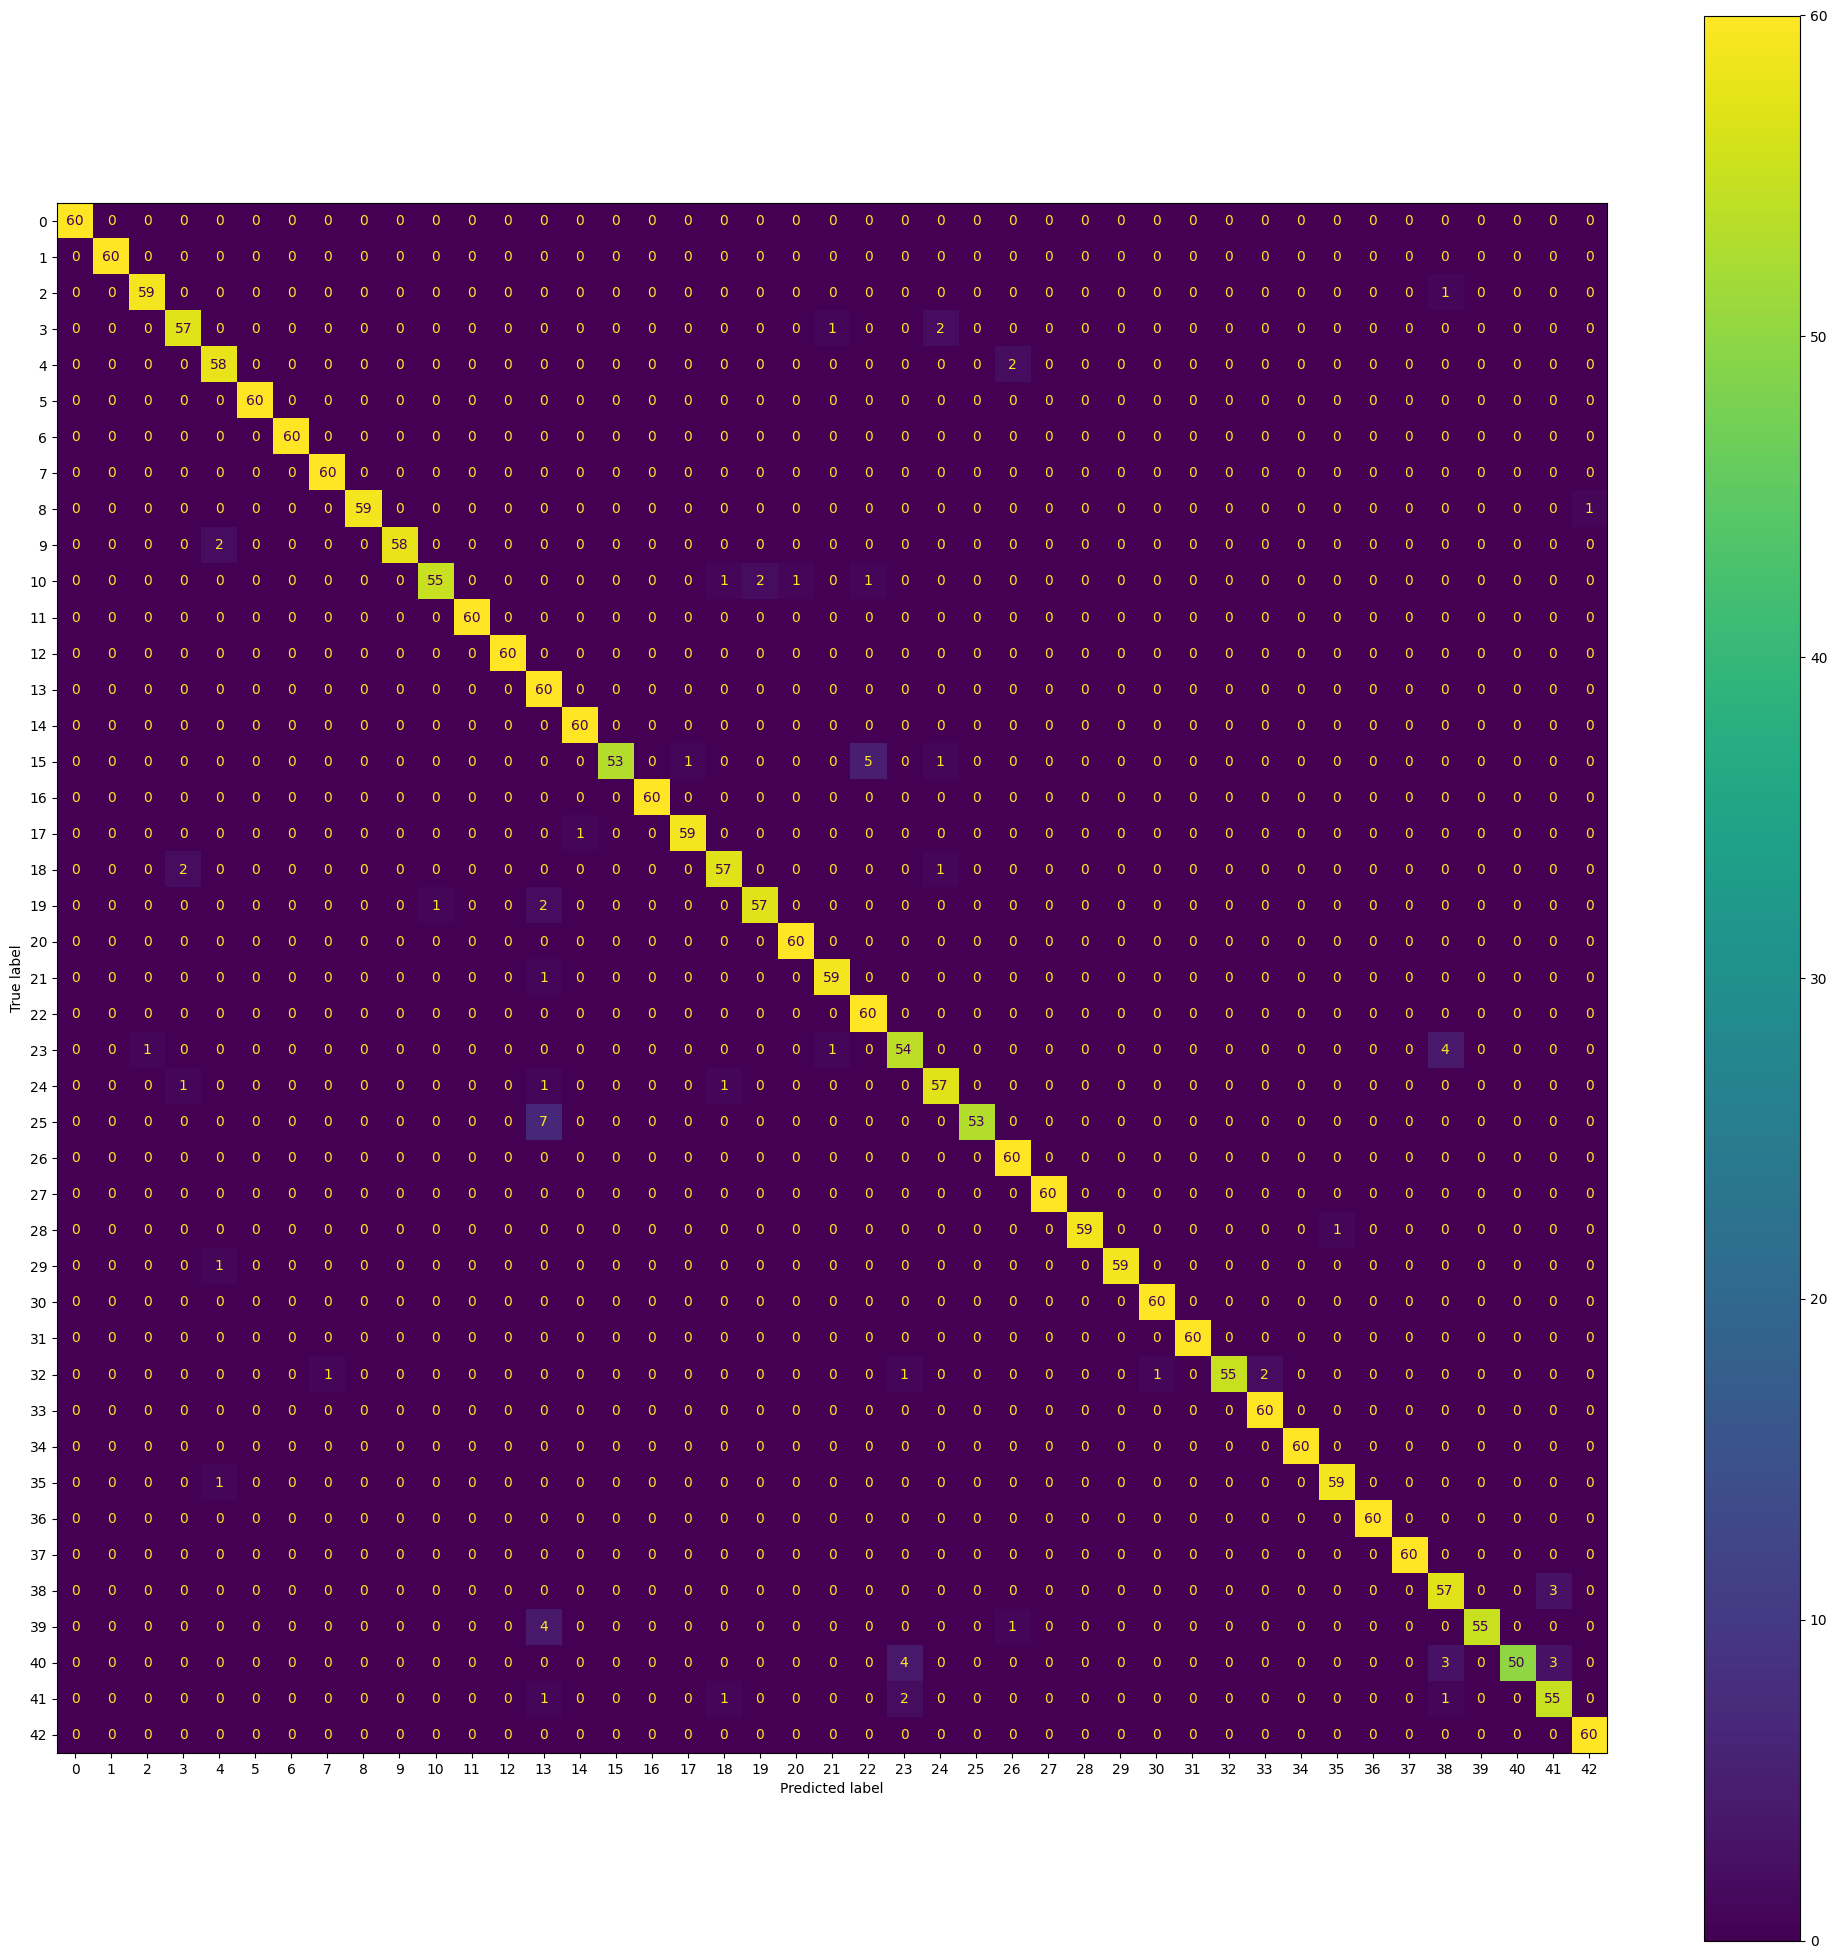

ROC Curve:


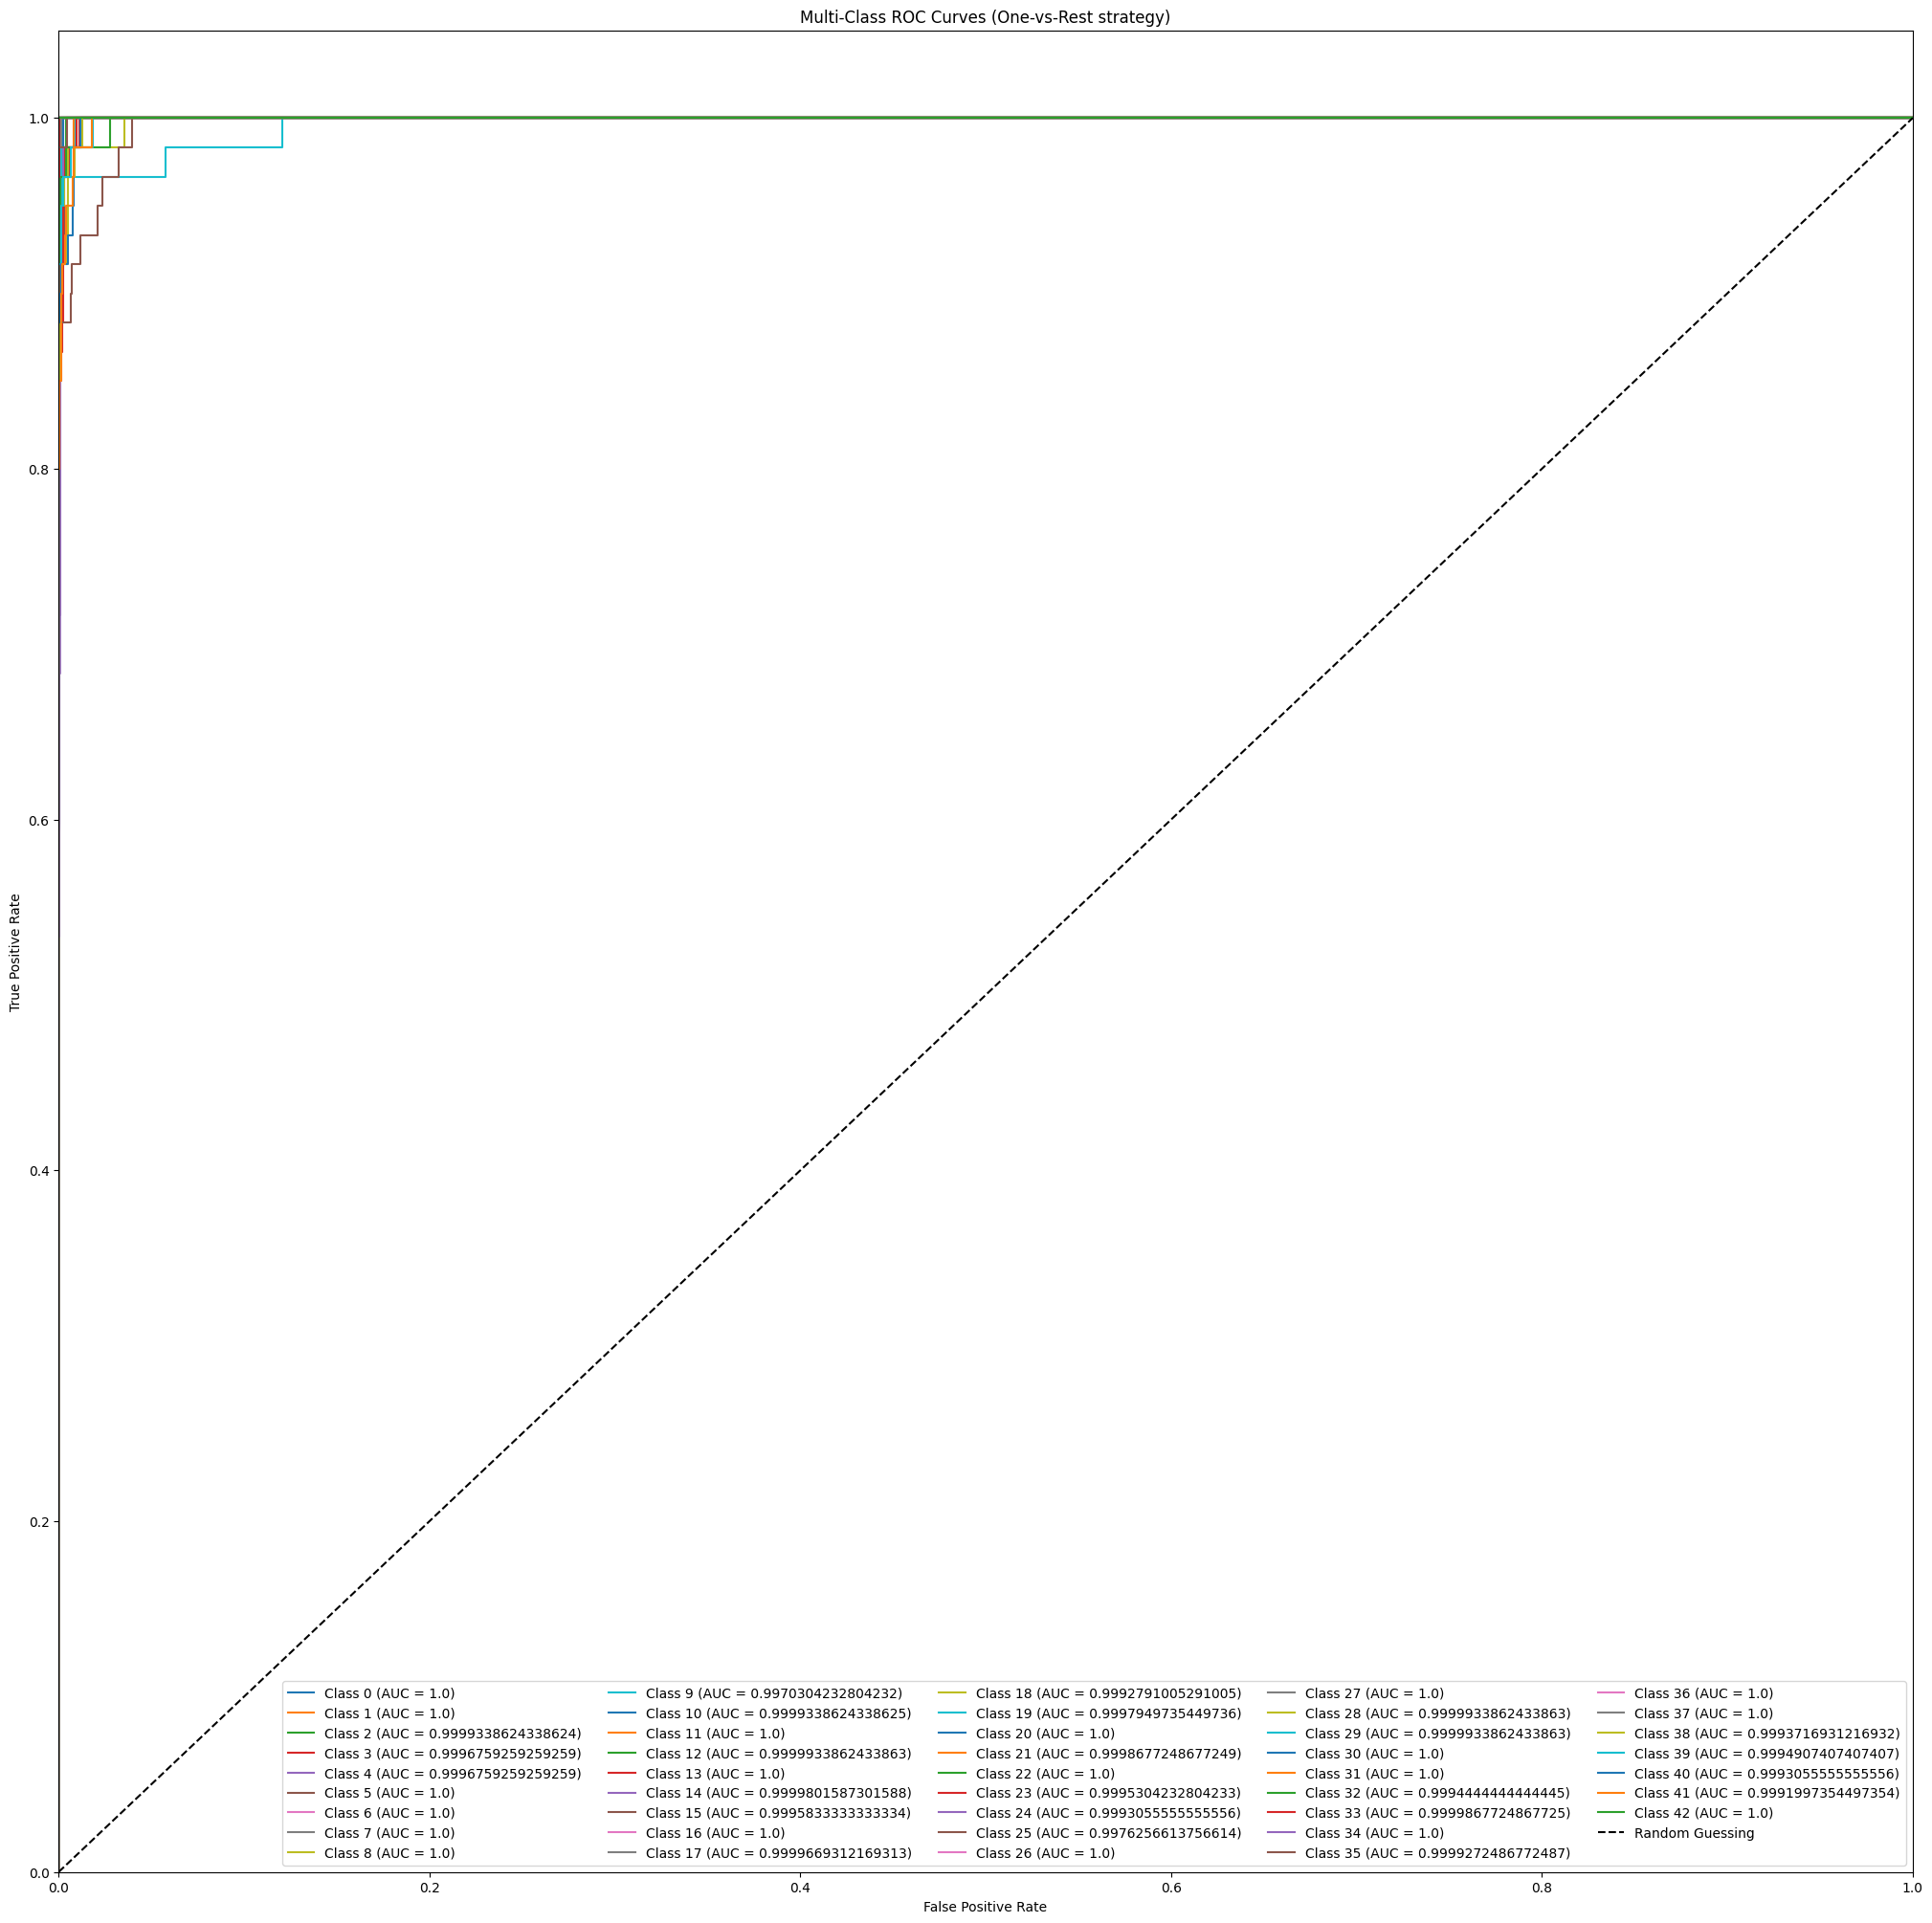

Test results - Loss: 0.2634824514389038 - Accuracy: 0.9705426096916199%
Top-K (K = 3) accuracy score: 0.987984496124031


In [ ]:
train_dir = os.path.join(WORK_DIR,"Train")
validation_dir = os.path.join(WORK_DIR,"Validation")
test_dir = os.path.join(WORK_DIR,"Test")

train, validation, test = load_datasets(train_dir, validation_dir, test_dir)
result = compile_and_fit(model_drop_l2_v2, train, validation, epochs=50)
train_performance(result)
test_evaluation(model_drop_l2_v2, test)

Thanks to the application of L2-Regularization the model achieves an accuracy of approximately 97.1% and a Top-K (K=3) score of approximately 0.988. The model was trained for 30 epochs, after which the early stopping mechanism was activated for overfitting. This model is the one that achieves the best performance

___
# **PRETRAINED NETWORK: VGG16**
**Leverage a pre-trained network** is a very common and highly effective approach. A pre-trained network
is simply a saved network previously trained on a large dataset. Spatial hierarchy of features learned by the pre-trained network can act as a generic model for our case. Portability of learned features across different problems is a key factor. In the case in question, VGG16 network was chosen.

VGG16 is a deep neural network architecture known for its simplicity and effectiveness in image classification. It consists of 16 layers, mostly using 3x3 convolutional filters and 2x2 max-pooling layers. VGG16 captures features at different scales, making it useful for tasks like recognizing objects in images. Its pre-trained weights enable quick adaptation to new tasks, making it a popular choice for transfer learning.


# VGG16: Feature extraction
Let's instantiate the VGG16 model.

In [9]:
conv_base = keras.applications.vgg16.VGG16(
    include_top = False,
    weights = 'imagenet',
    input_shape = PRETRAINED_INPUT_SHAPE
)

# Print convolutional base details
conv_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

Before to compile and train the model, let's freeze the convolutional base. "Freezing" layers means preventing their weights from getting updated during training.

In [10]:
print('Number of trainable weights: ', sum(np.prod(x.shape) for x in conv_base.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights after freezing the convolutional base:', sum(np.prod(x.shape) for x in conv_base.trainable_weights))

Number of trainable weights:  14714688
Number of trainable weights after freezing the convolutional base: 0


**1) Model 1**

The conv_base starts the feature extraction phase. In the first model (the simplest) let's use the conv_base in conjunction with a dense layer without L2 regularization (with 256 nodes) and the last dense layer for classification (with softmax activation function). No dropout are used. This first model will be analyzed as a base model and further improvements will subsequently be added if necessary. The optimizer chosen is the same as the custom model described above. This model has such a simple structure to let the network learn and to obtain a basic model with which to then perform comparisons

In [11]:
inputs = keras.Input(shape=PRETRAINED_INPUT_SHAPE)

x = keras.applications.vgg16.preprocess_input(inputs)

# Feature extraction
x = conv_base(x)

x = layers.Flatten()(x)

x = layers.Dense(256)(x)
outputs = layers.Dense(43, activation="softmax")(x)

model_pr_base = keras.Model(inputs, outputs, name="Model_Pretrained_Base")
show_and_save_model_summary(model_pr_base)

Model: "Model_Pretrained_Base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 tf.__operators__.getitem (  (None, 48, 48, 3)         0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 48, 48, 3)         0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)     

Load the dataset, train the model and evaluate it

Found 6450 files belonging to 43 classes.
Found 2580 files belonging to 43 classes.
Found 2580 files belonging to 43 classes.
Epoch 1/30
202/202 [==============================] - ETA: 0s - loss: 8.0107 - accuracy: 0.4546
Epoch 1: val_loss improved from inf to 9.28097, saving model to /content/drive/Shareddrives/Biondi/Models/Model_Pretrained_Base.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


202/202 [==============================] - 12s 39ms/step - loss: 8.0107 - accuracy: 0.4546 - val_loss: 9.2810 - val_accuracy: 0.3736
Epoch 2/30
198/202 [============================>.] - ETA: 0s - loss: 2.7567 - accuracy: 0.6913
Epoch 2: val_loss improved from 9.28097 to 9.03119, saving model to /content/drive/Shareddrives/Biondi/Models/Model_Pretrained_Base.h5
202/202 [==============================] - 4s 20ms/step - loss: 2.7326 - accuracy: 0.6936 - val_loss: 9.0312 - val_accuracy: 0.3919
Epoch 3/30
201/202 [============================>.] - ETA: 0s - loss: 1.8860 - accuracy: 0.7634
Epoch 3: val_loss did not improve from 9.03119
202/202 [==============================] - 5s 25ms/step - loss: 1.8818 - accuracy: 0.7636 - val_loss: 9.5364 - val_accuracy: 0.4004
Epoch 4/30
201/202 [============================>.] - ETA: 0s - loss: 1.4396 - accuracy: 0.8052
Epoch 4: val_loss did not improve from 9.03119
202/202 [==============================] - 4s 18ms/step - loss: 1.4361 - accuracy: 0.8

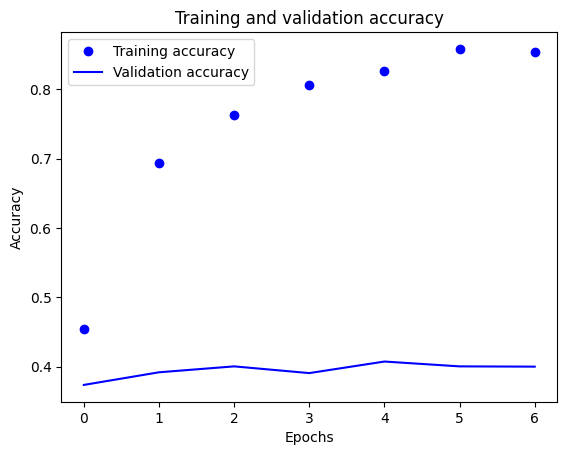

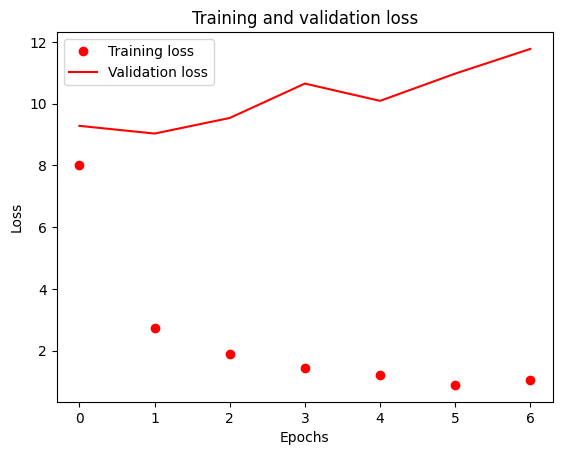

81/81 [==============================] - 1s 10ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.2500    0.0333    0.0588        60
           1     0.2353    0.3333    0.2759        60
           2     0.6667    0.4000    0.5000        60
           3     0.4167    0.5000    0.4545        60
           4     0.7903    0.8167    0.8033        60
           5     0.7059    0.8000    0.7500        60
           6     1.0000    0.6833    0.8119        60
           7     0.6517    0.9667    0.7785        60
           8     0.8431    0.7167    0.7748        60
           9     0.8305    0.8167    0.8235        60
          10     0.2113    0.5000    0.2970        60
          11     0.4865    0.3000    0.3711        60
          12     0.2277    0.3833    0.2857        60
          13     0.2623    0.2667    0.2645        60
          14     0.3125    0.0833    0.1316        60
          15     0.1212    0.0667    0.0860        60
   

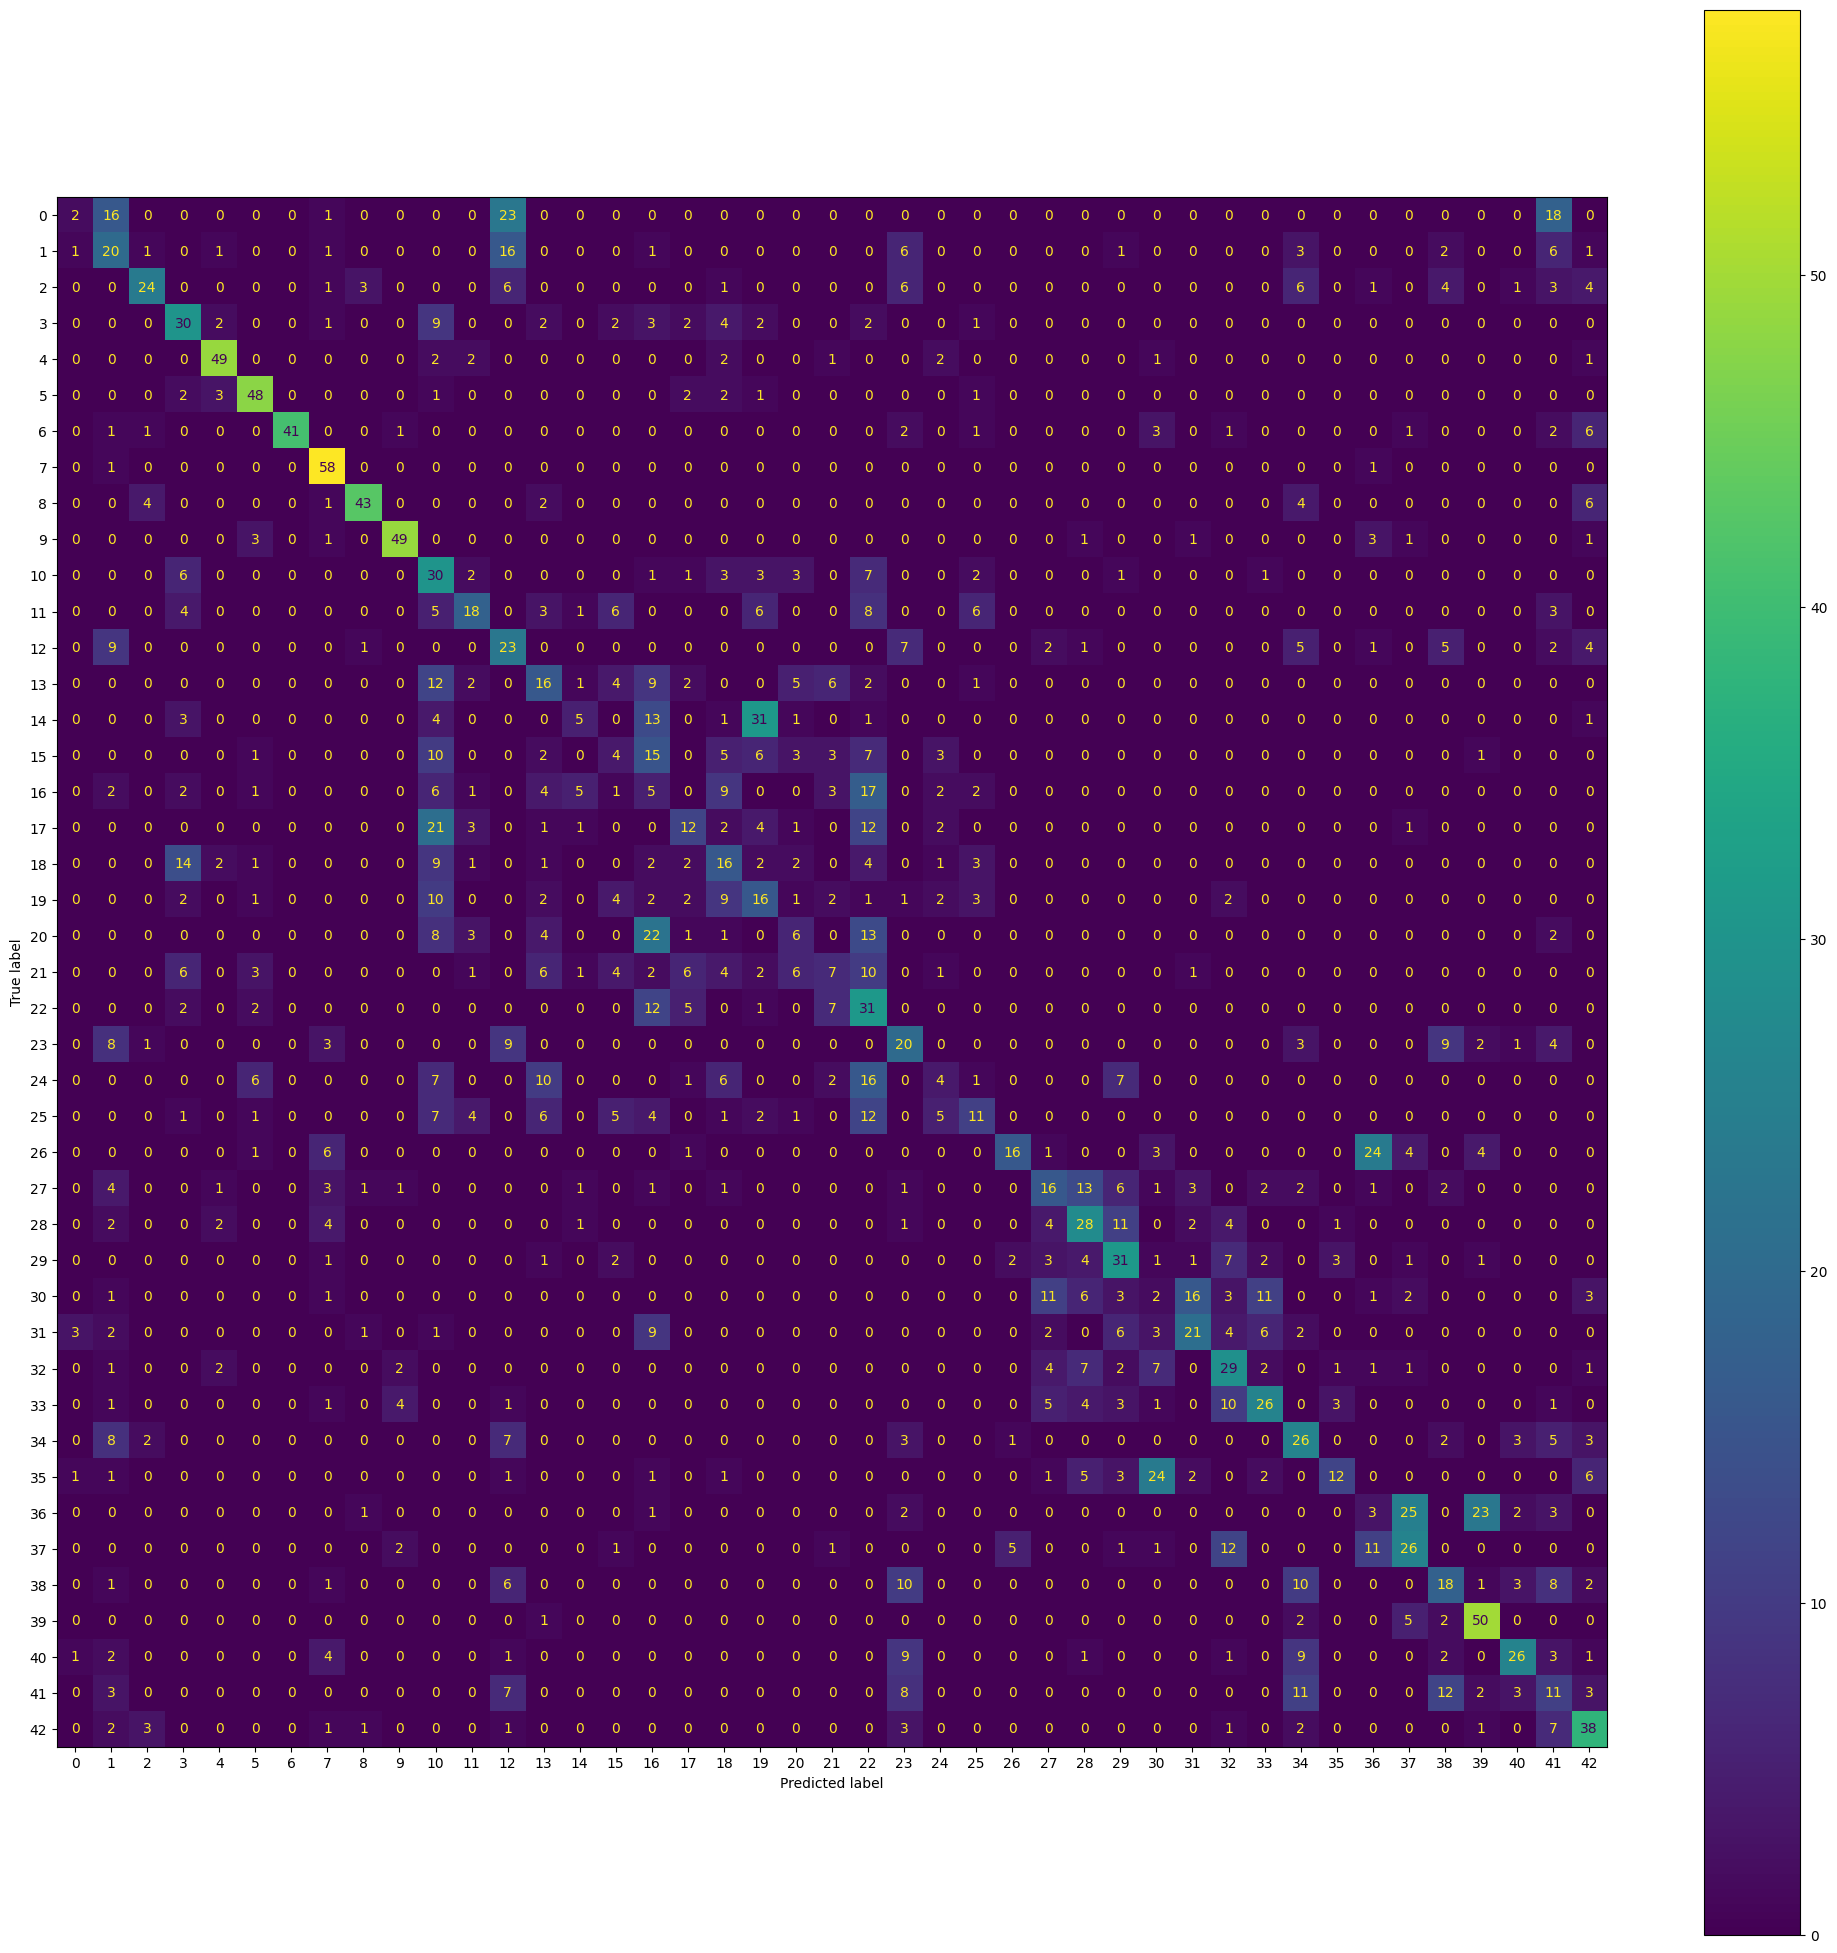

ROC Curve:


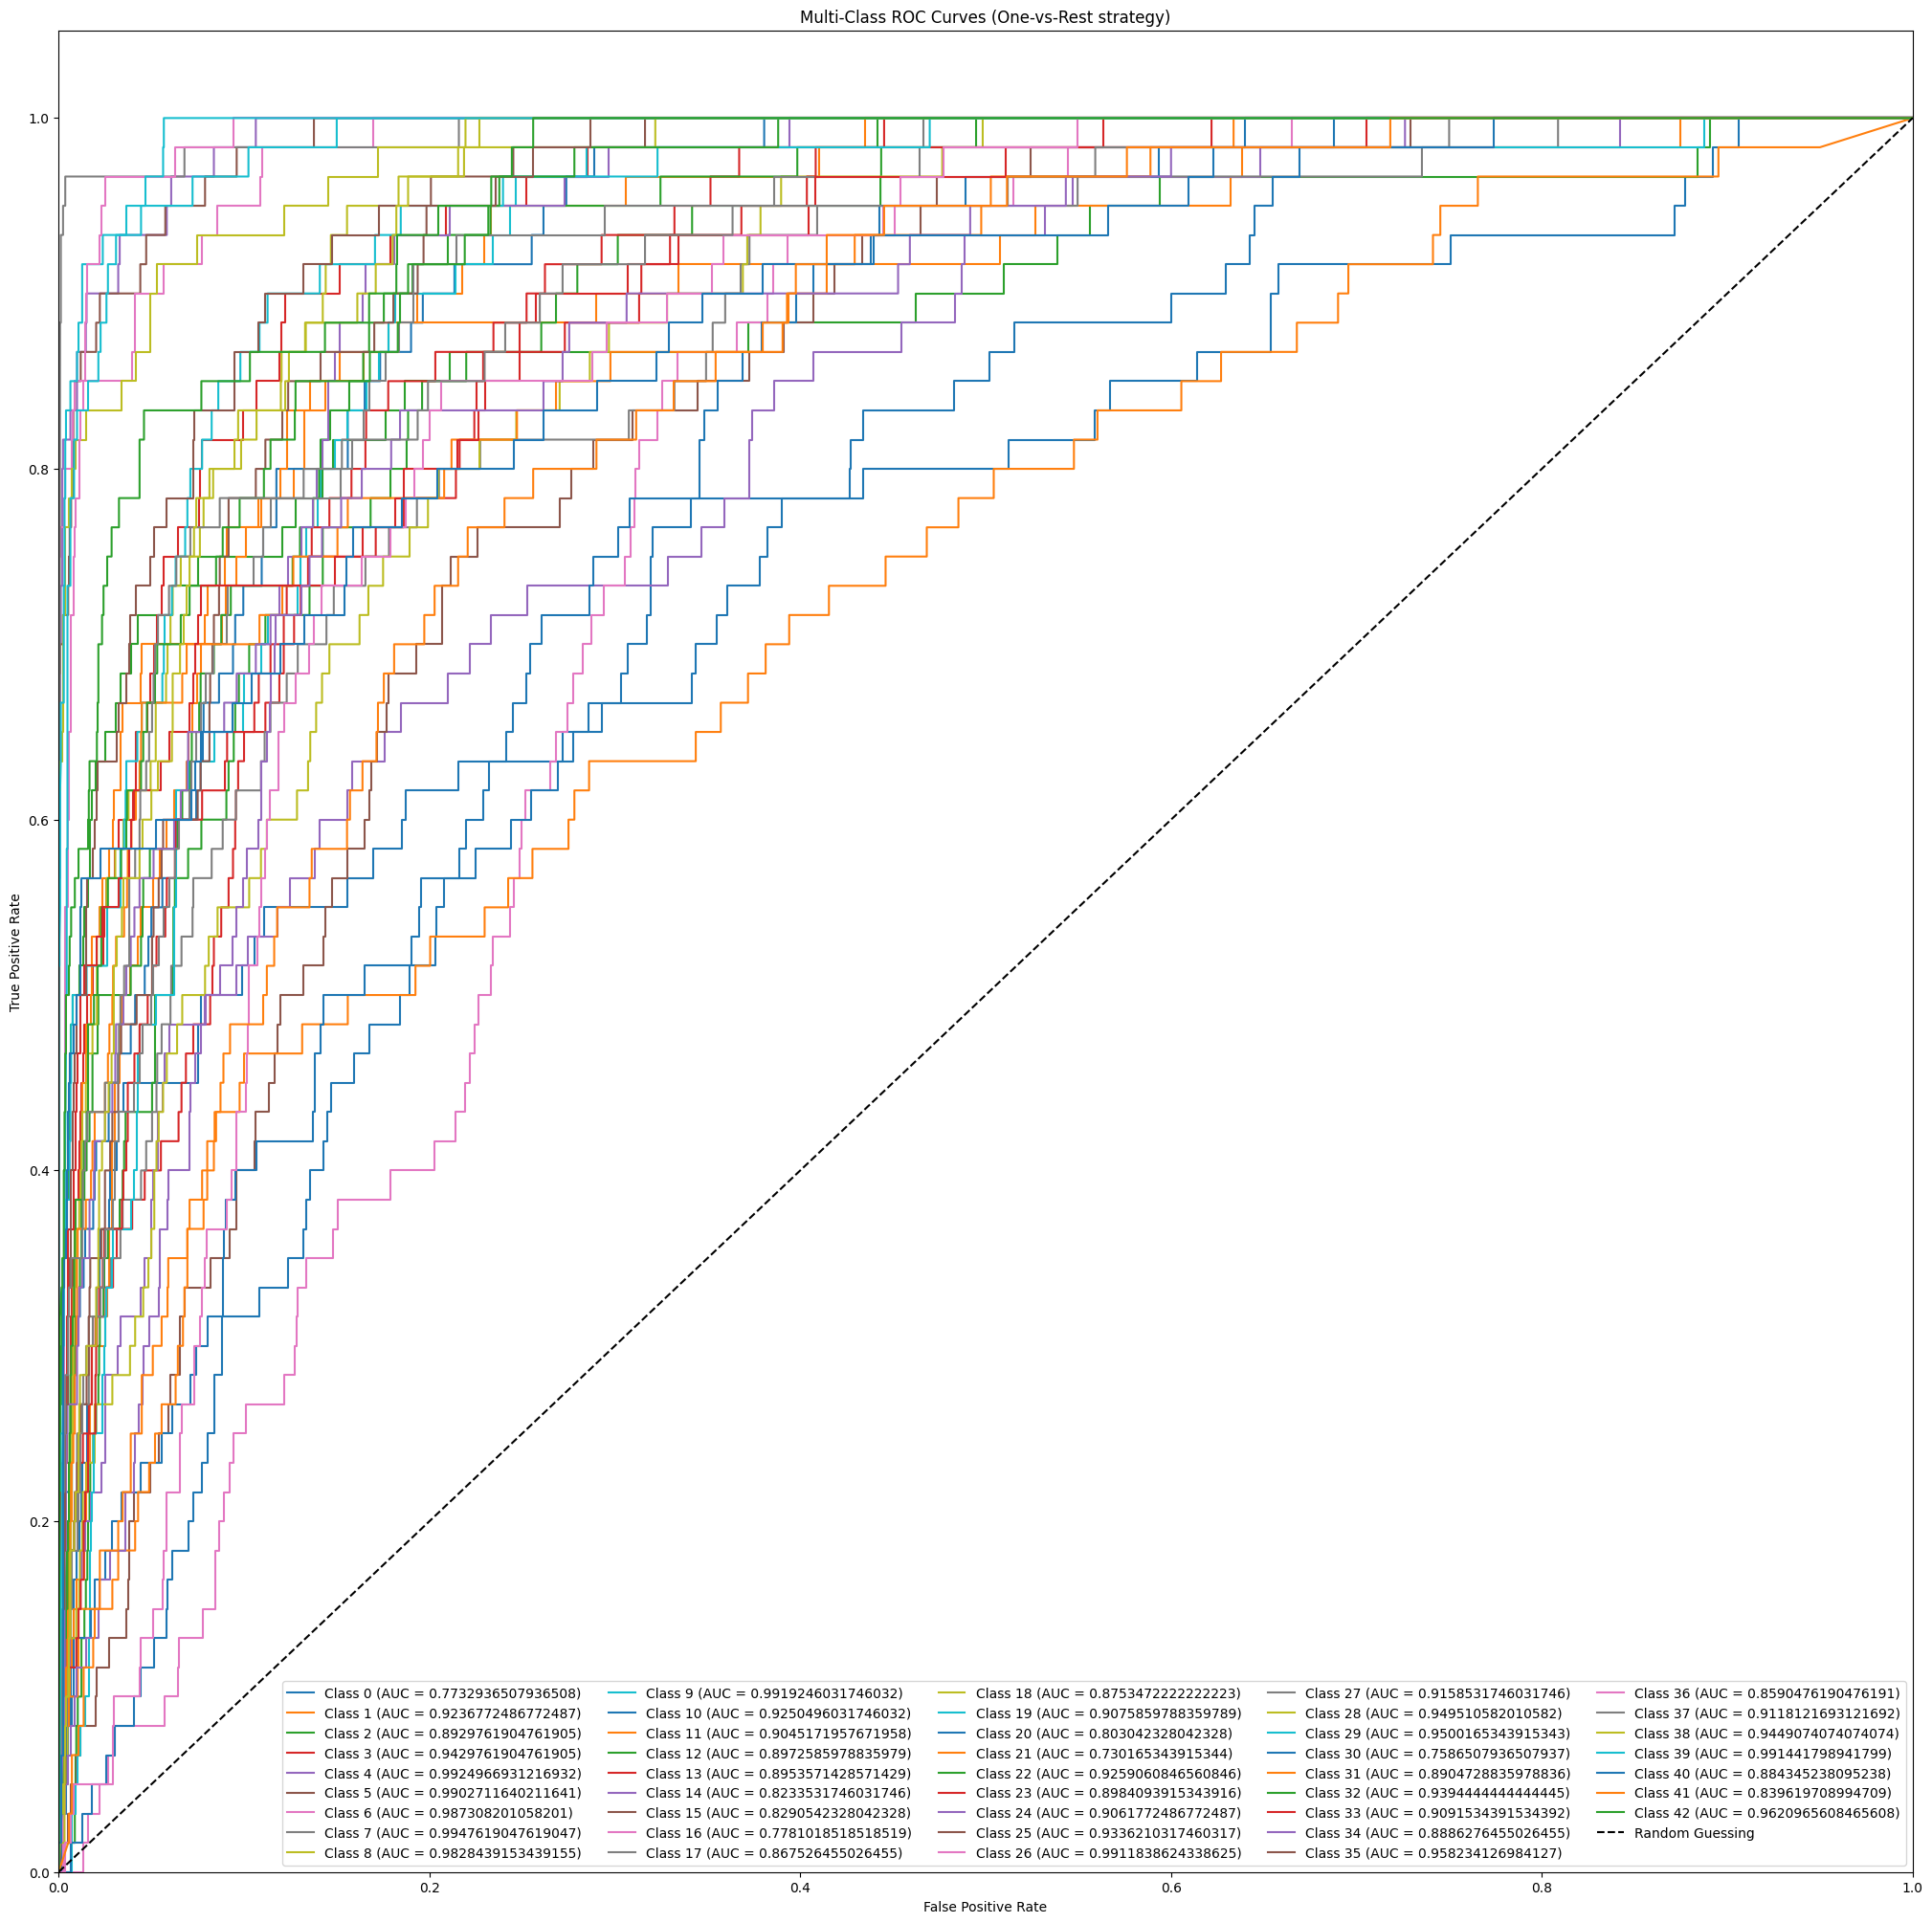

Test results - Loss: 10.180217742919922 - Accuracy: 0.3748061954975128%
Top-K (K = 3) accuracy score: 0.5968992248062015


In [12]:
train_dir = os.path.join(WORK_DIR,"Train")
validation_dir = os.path.join(WORK_DIR,"Validation")
test_dir = os.path.join(WORK_DIR,"Test")

train, validation, test = load_datasets(train_dir, validation_dir, test_dir)
result = compile_and_fit(model_pr_base, train, validation)
train_performance(result)
test_evaluation(model_pr_base, test)

The result of the base pretrained model is an accuracy of approximately 37.5% and a Top-K (K=3) score of approximately 0.597. The model was trained for only 7 epochs, after which the early stopping mechanism was activated for overfitting. Maintaining the structure we just tested, let's try to apply some techniques that mitigate overfitting.

**2) Model 2 with overfitting mitigation techniques**

From the previous result the presence of overfitting can be highlighted. Considering that the set samples are very similar and dependent on each other, let's try to mitigate overfitting through dropout and regularization, without using data augmentation.

In [ ]:
inputs = keras.Input(shape=PRETRAINED_INPUT_SHAPE)
x = keras.applications.vgg16.preprocess_input(inputs)

# Feature extraction
x = conv_base(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.01)) (x)

x = layers.Dropout(0.3)(x)
outputs = layers.Dense(43, activation="softmax")(x)

model_pr_drop_l2 = keras.Model(inputs, outputs, name="Model_Pretrained_drop_l2")
show_and_save_model_summary(model_pr_drop_l2)

Model: "Model_Pretrained_drop_l2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 tf.__operators__.getitem_2  (None, 48, 48, 3)         0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 48, 48, 3)         0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dropout_2 (Dropout)         (None, 512)  

Load the dataset, train the model and evaluate it

Found 6450 files belonging to 43 classes.
Found 2580 files belonging to 43 classes.
Found 2580 files belonging to 43 classes.
Epoch 1/50
200/202 [============================>.] - ETA: 0s - loss: 22.7110 - accuracy: 0.2688
Epoch 1: val_loss improved from inf to 13.70704, saving model to /content/drive/Shareddrives/Biondi/Models/Model_Pretrained_drop_l2.h5
202/202 [==============================] - 6s 22ms/step - loss: 22.6402 - accuracy: 0.2698 - val_loss: 13.7070 - val_accuracy: 0.3481
Epoch 2/50
199/202 [============================>.] - ETA: 0s - loss: 12.5482 - accuracy: 0.4546
Epoch 2: val_loss improved from 13.70704 to 12.76073, saving model to /content/drive/Shareddrives/Biondi/Models/Model_Pretrained_drop_l2.h5
202/202 [==============================] - 4s 18ms/step - loss: 12.5268 - accuracy: 0.4547 - val_loss: 12.7607 - val_accuracy: 0.3798
Epoch 3/50
202/202 [==============================] - ETA: 0s - loss: 10.3397 - accuracy: 0.5045
Epoch 3: val_loss improved from 12.76073

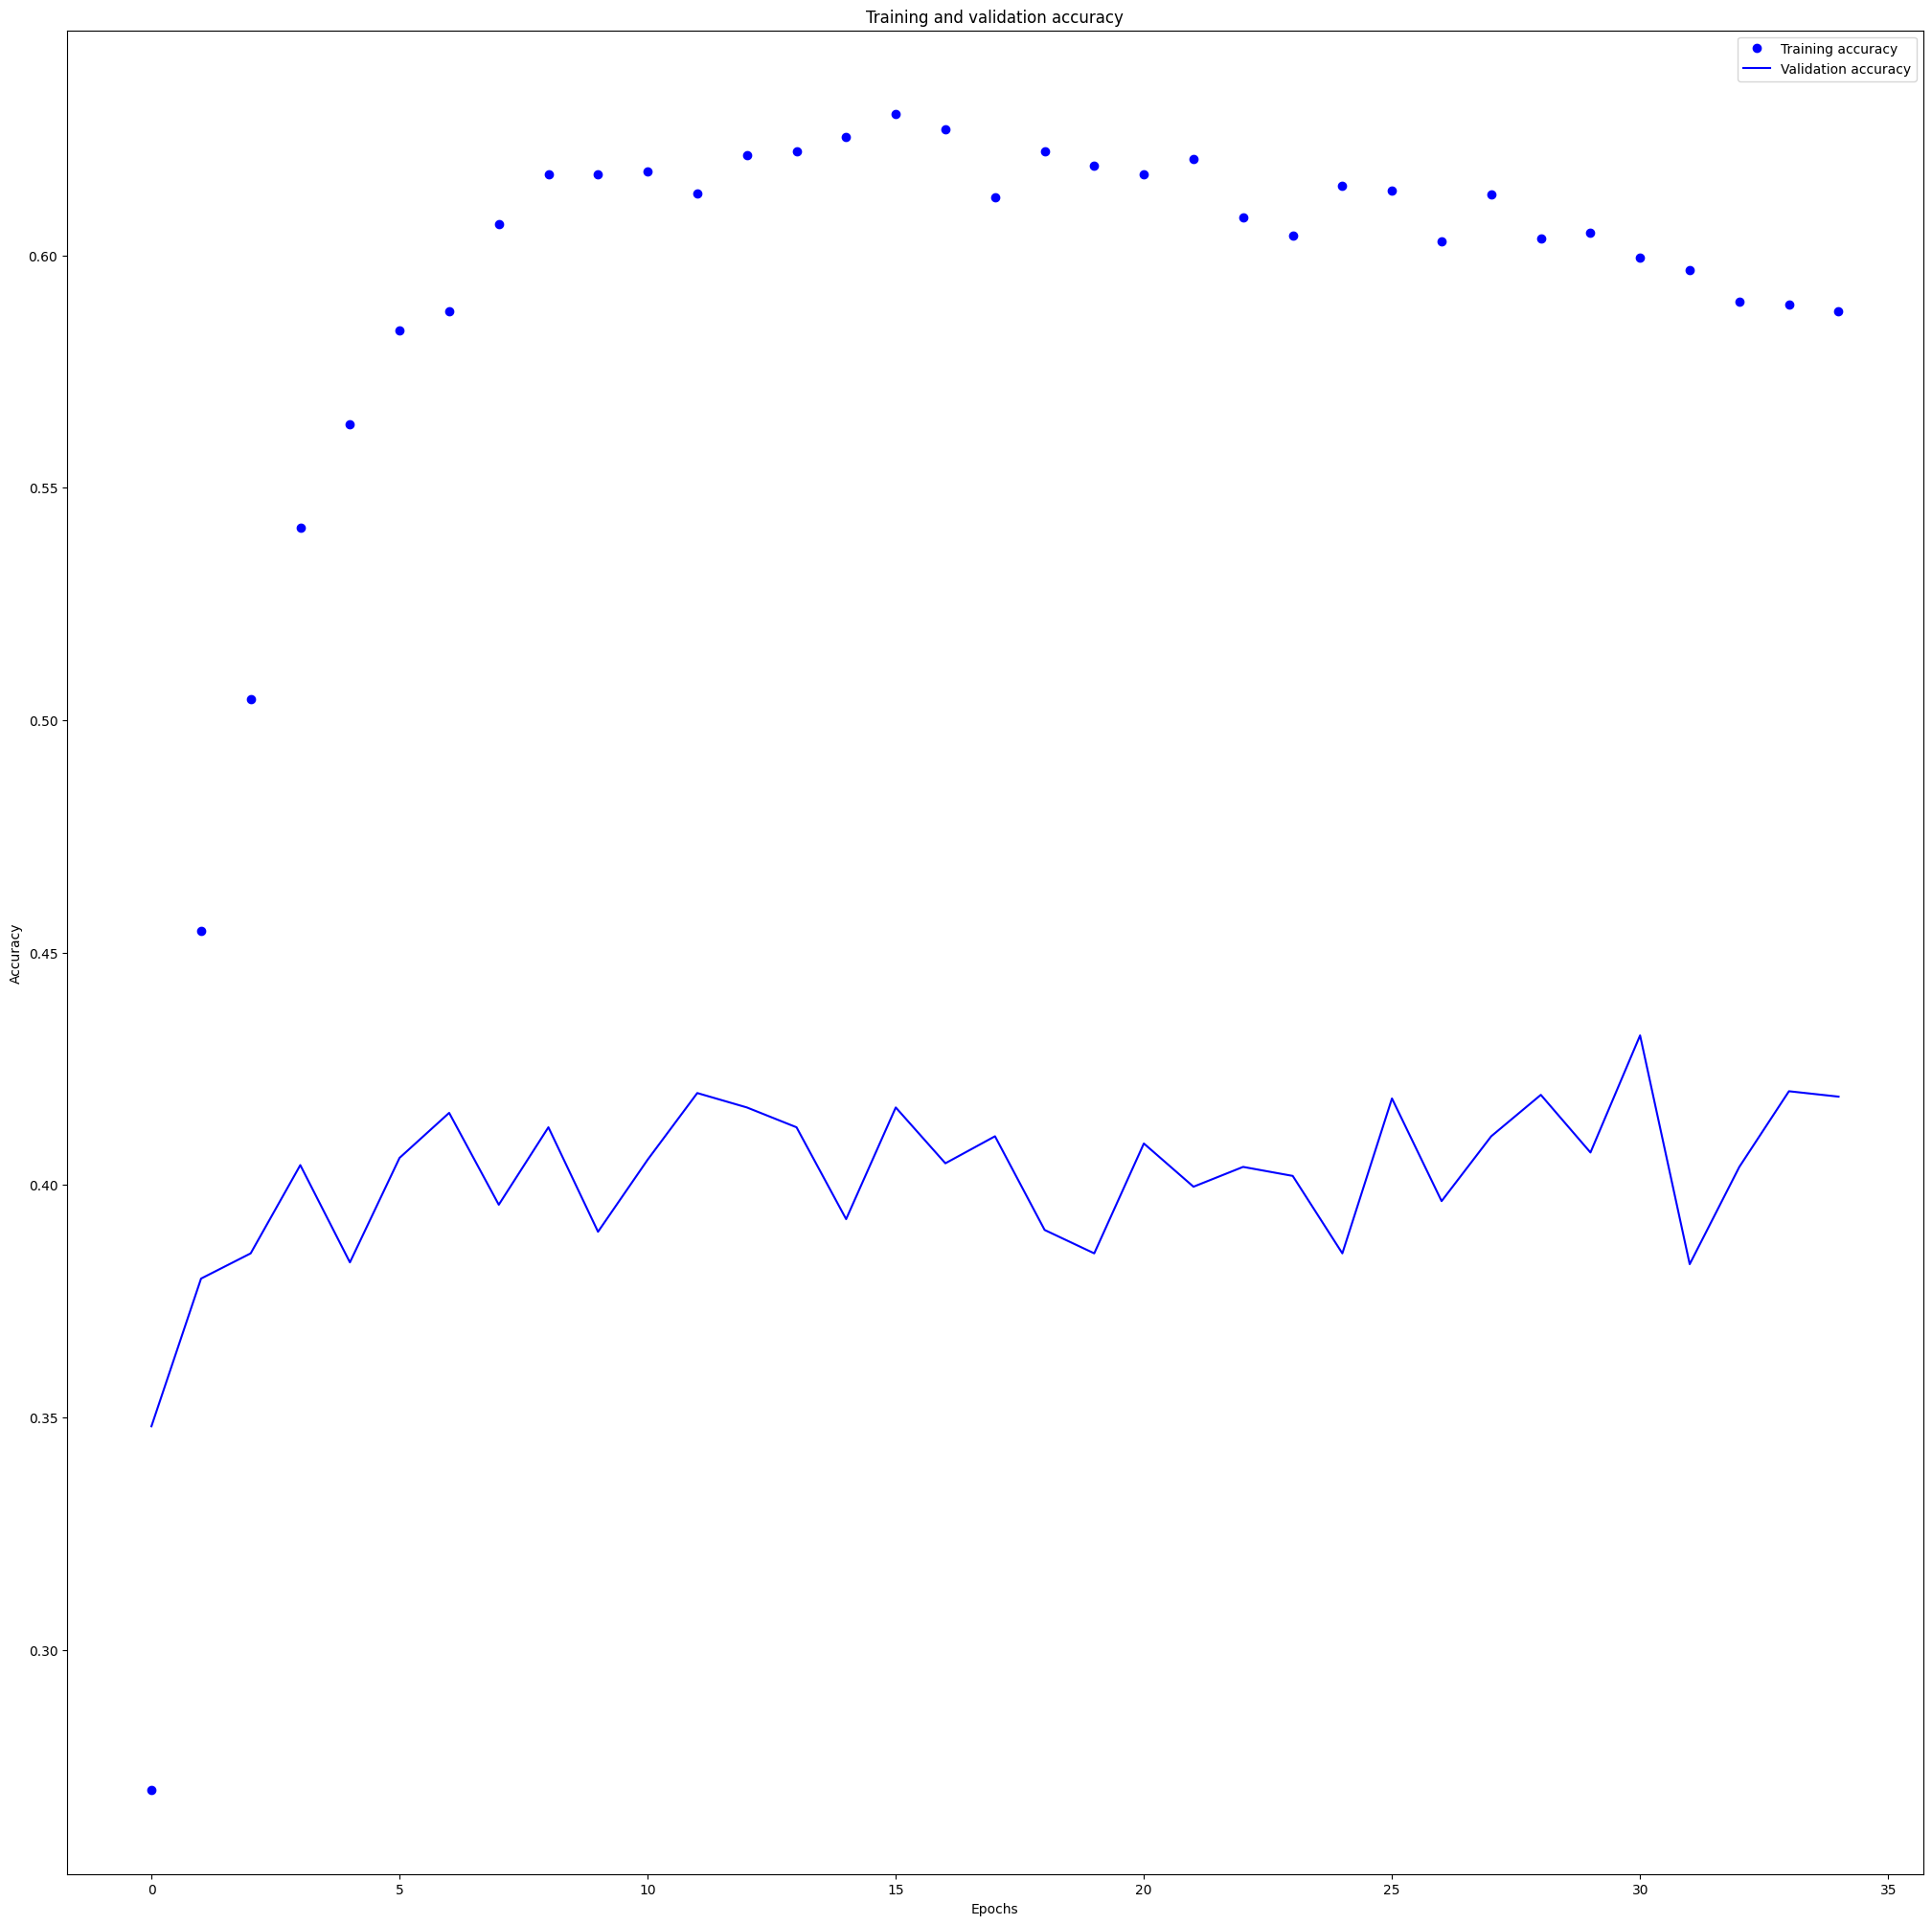

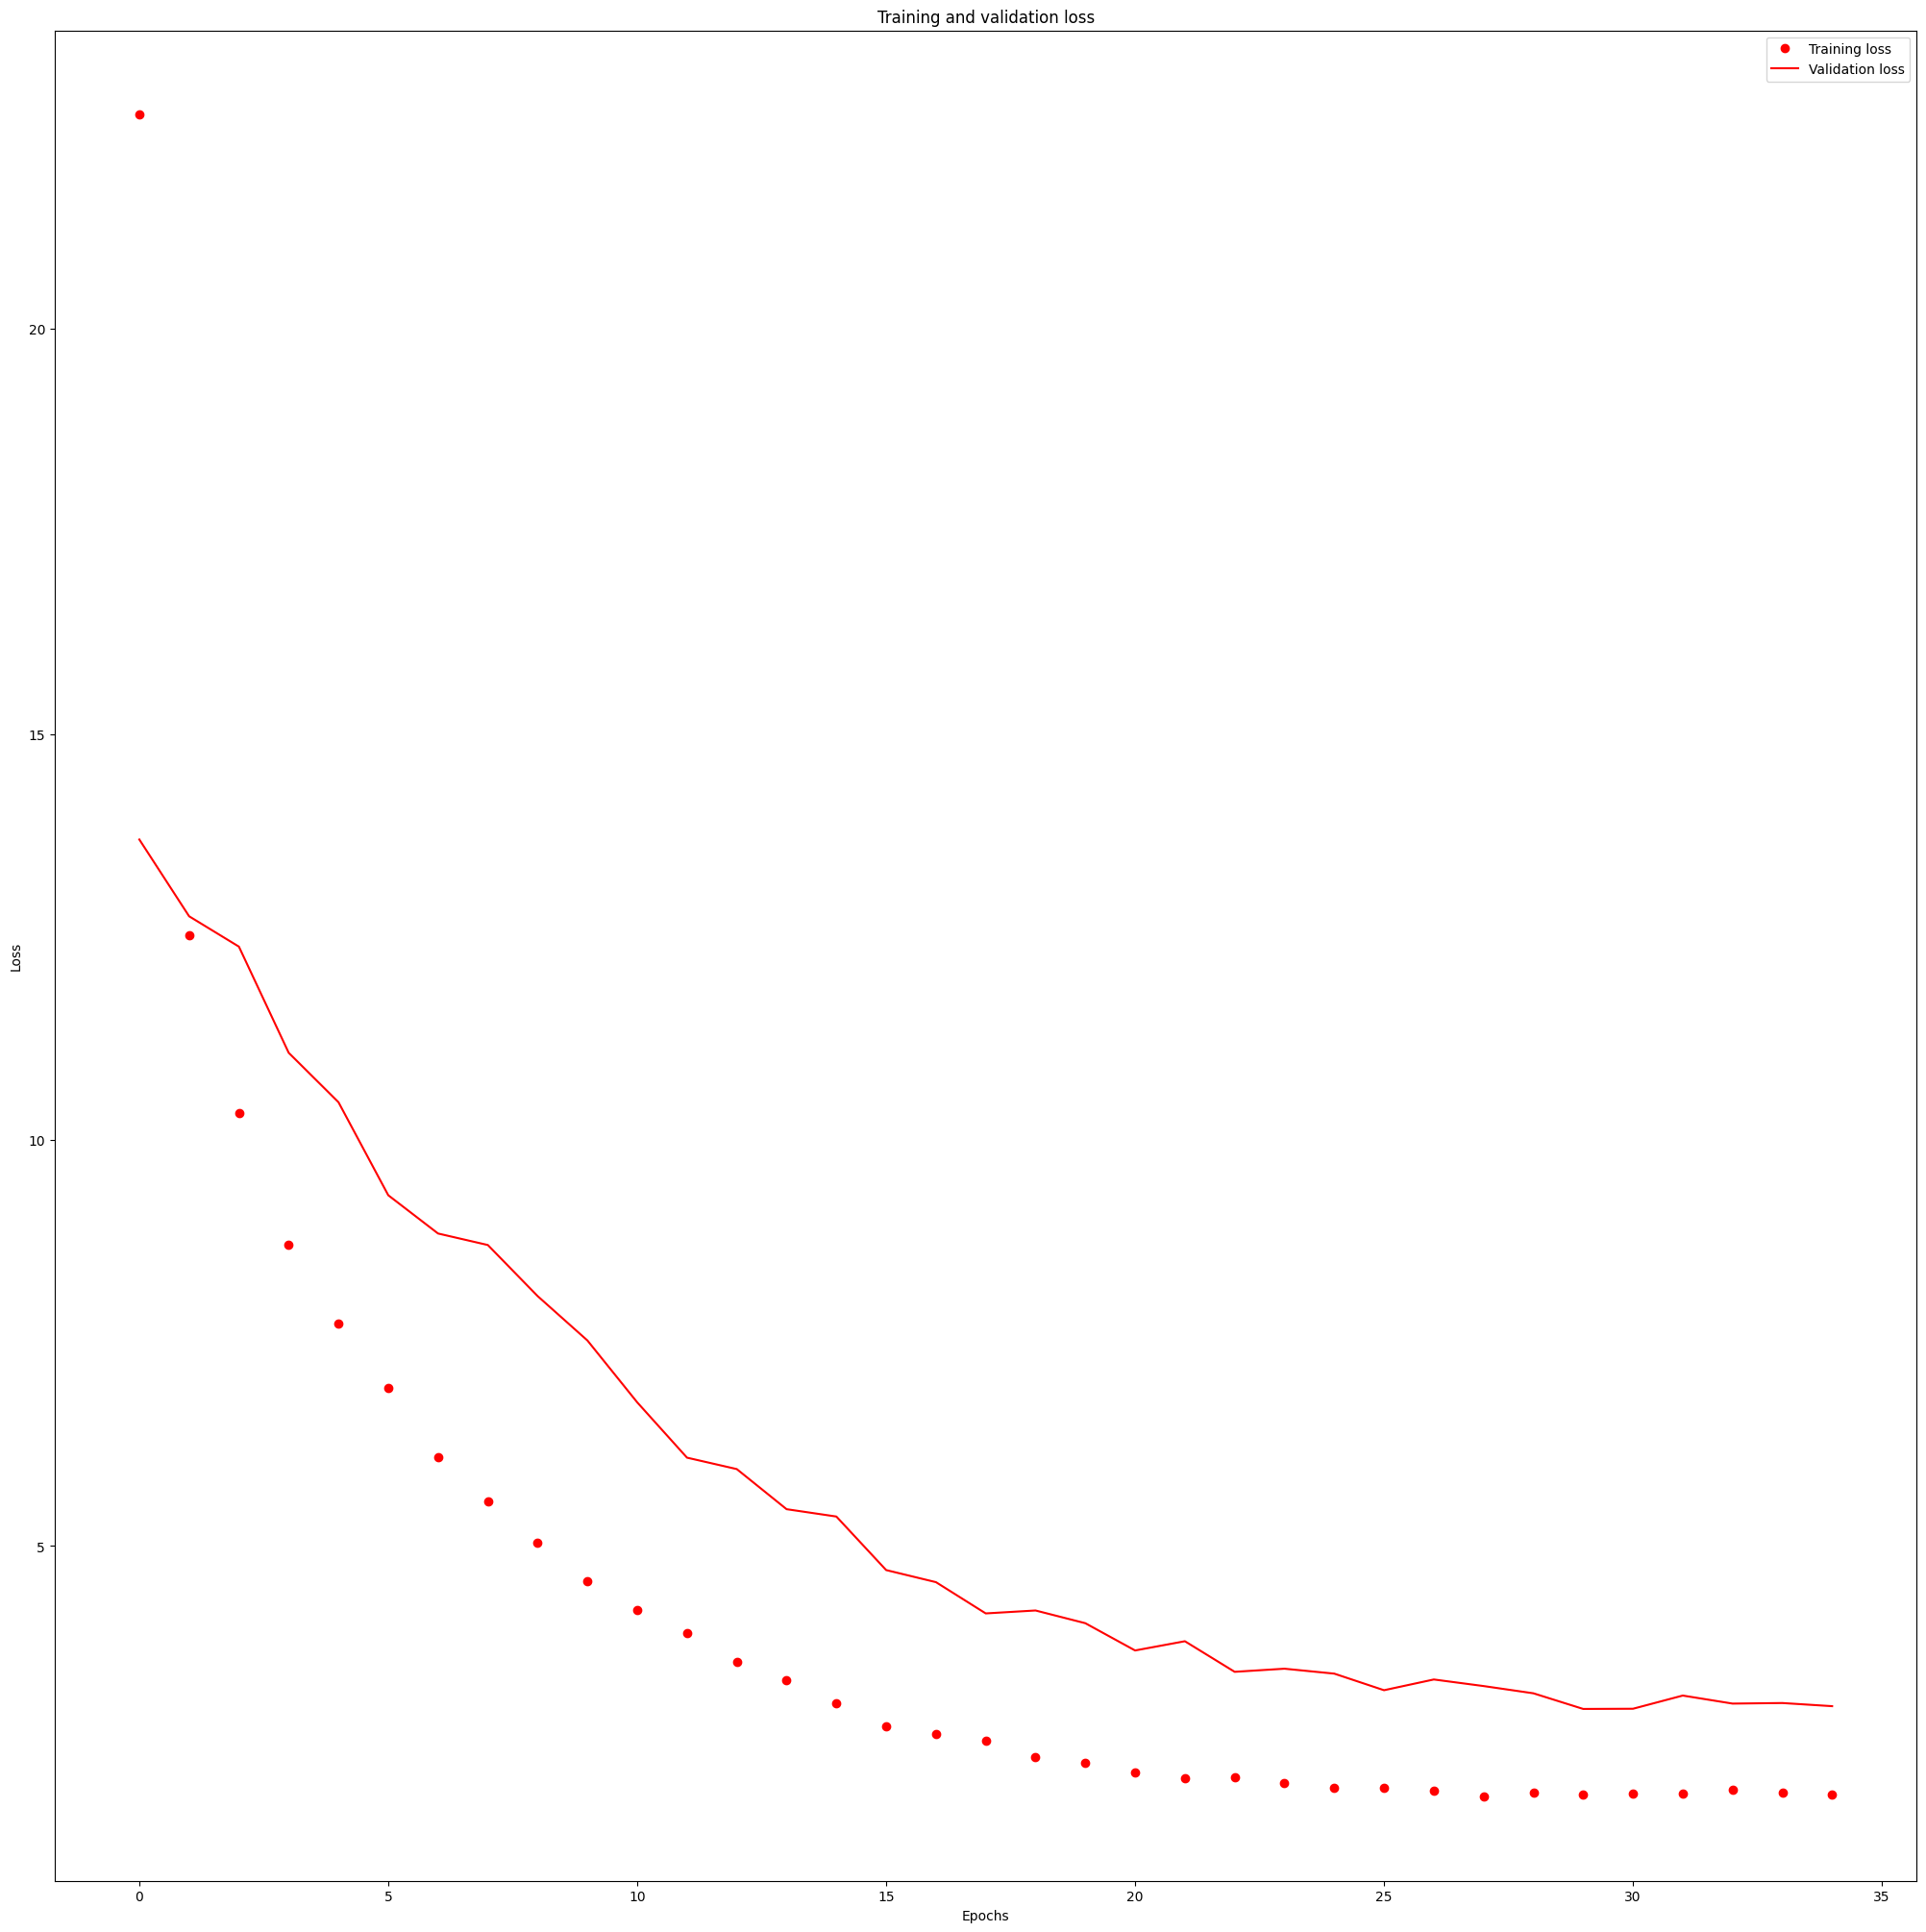

81/81 [==============================] - 1s 11ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.4043    0.3167    0.3551        60
           1     0.2444    0.5500    0.3385        60
           2     0.7333    0.5500    0.6286        60
           3     0.5161    0.2667    0.3516        60
           4     0.9783    0.7500    0.8491        60
           5     0.9167    0.9167    0.9167        60
           6     0.8679    0.7667    0.8142        60
           7     0.9818    0.9000    0.9391        60
           8     0.7714    0.9000    0.8308        60
           9     0.9773    0.7167    0.8269        60
          10     0.3158    0.2000    0.2449        60
          11     0.2963    0.2667    0.2807        60
          12     0.1013    0.1333    0.1151        60
          13     0.2609    0.2000    0.2264        60
          14     0.2647    0.1500    0.1915        60
          15     0.0959    0.2333    0.1359        60
   

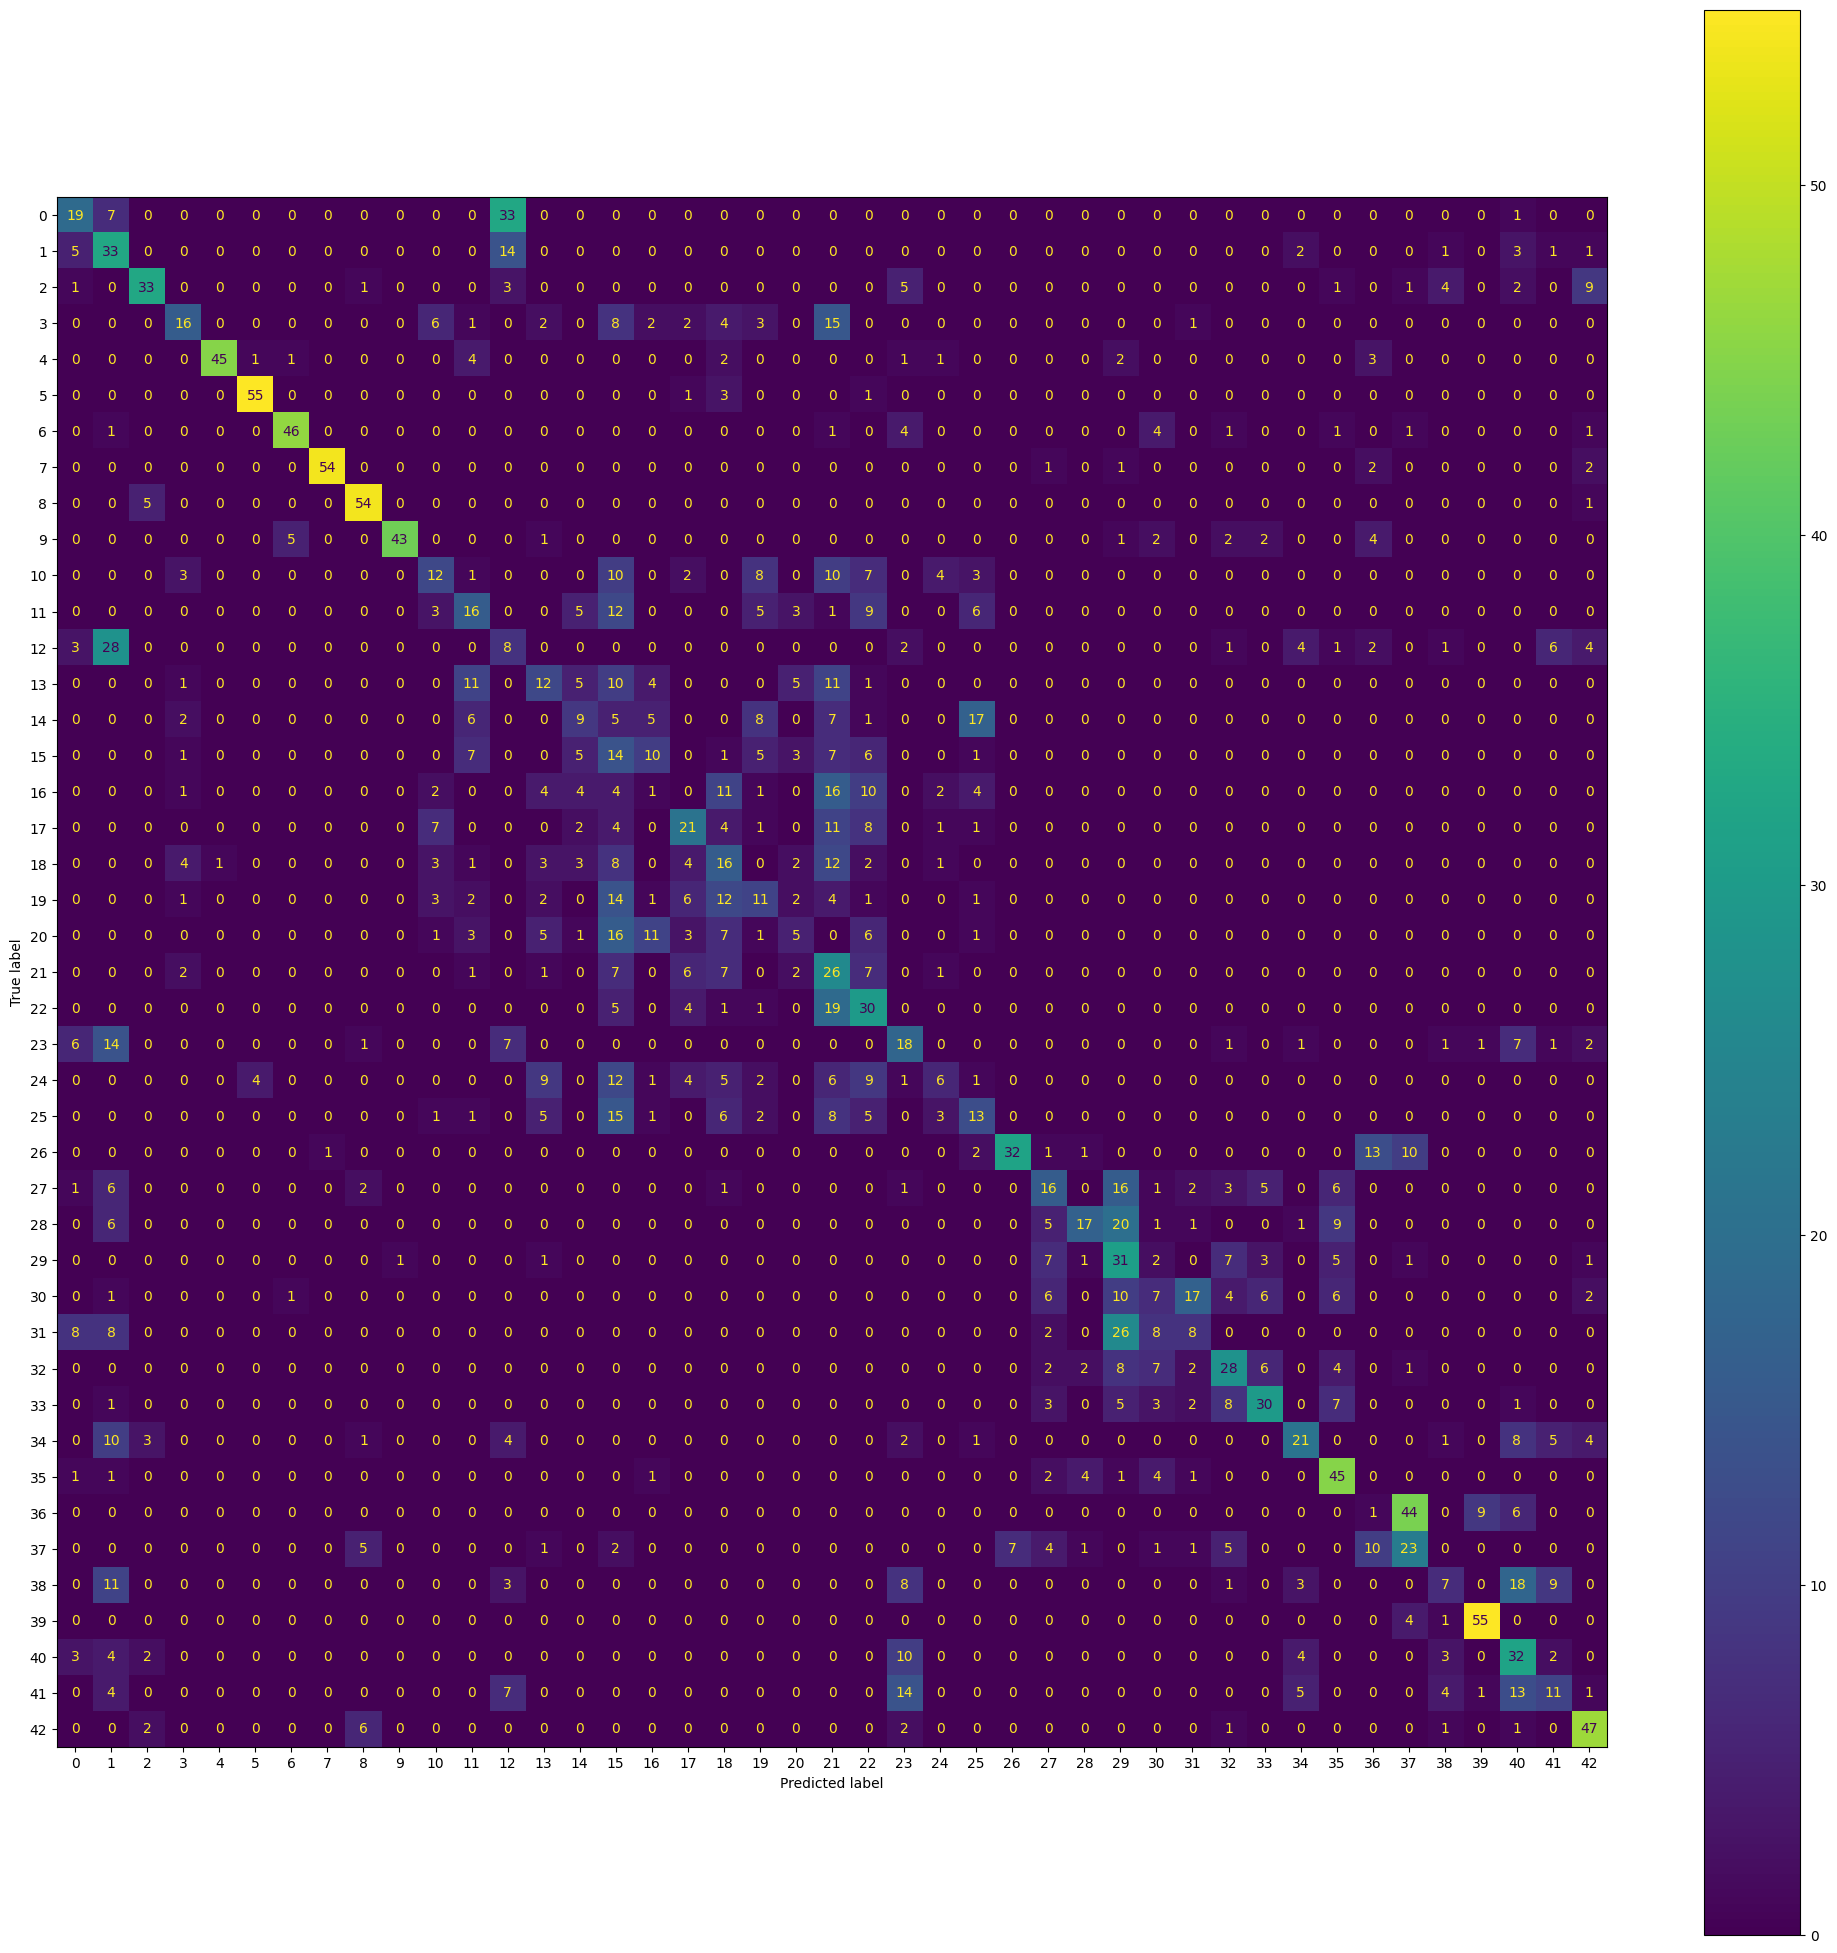

ROC Curve:


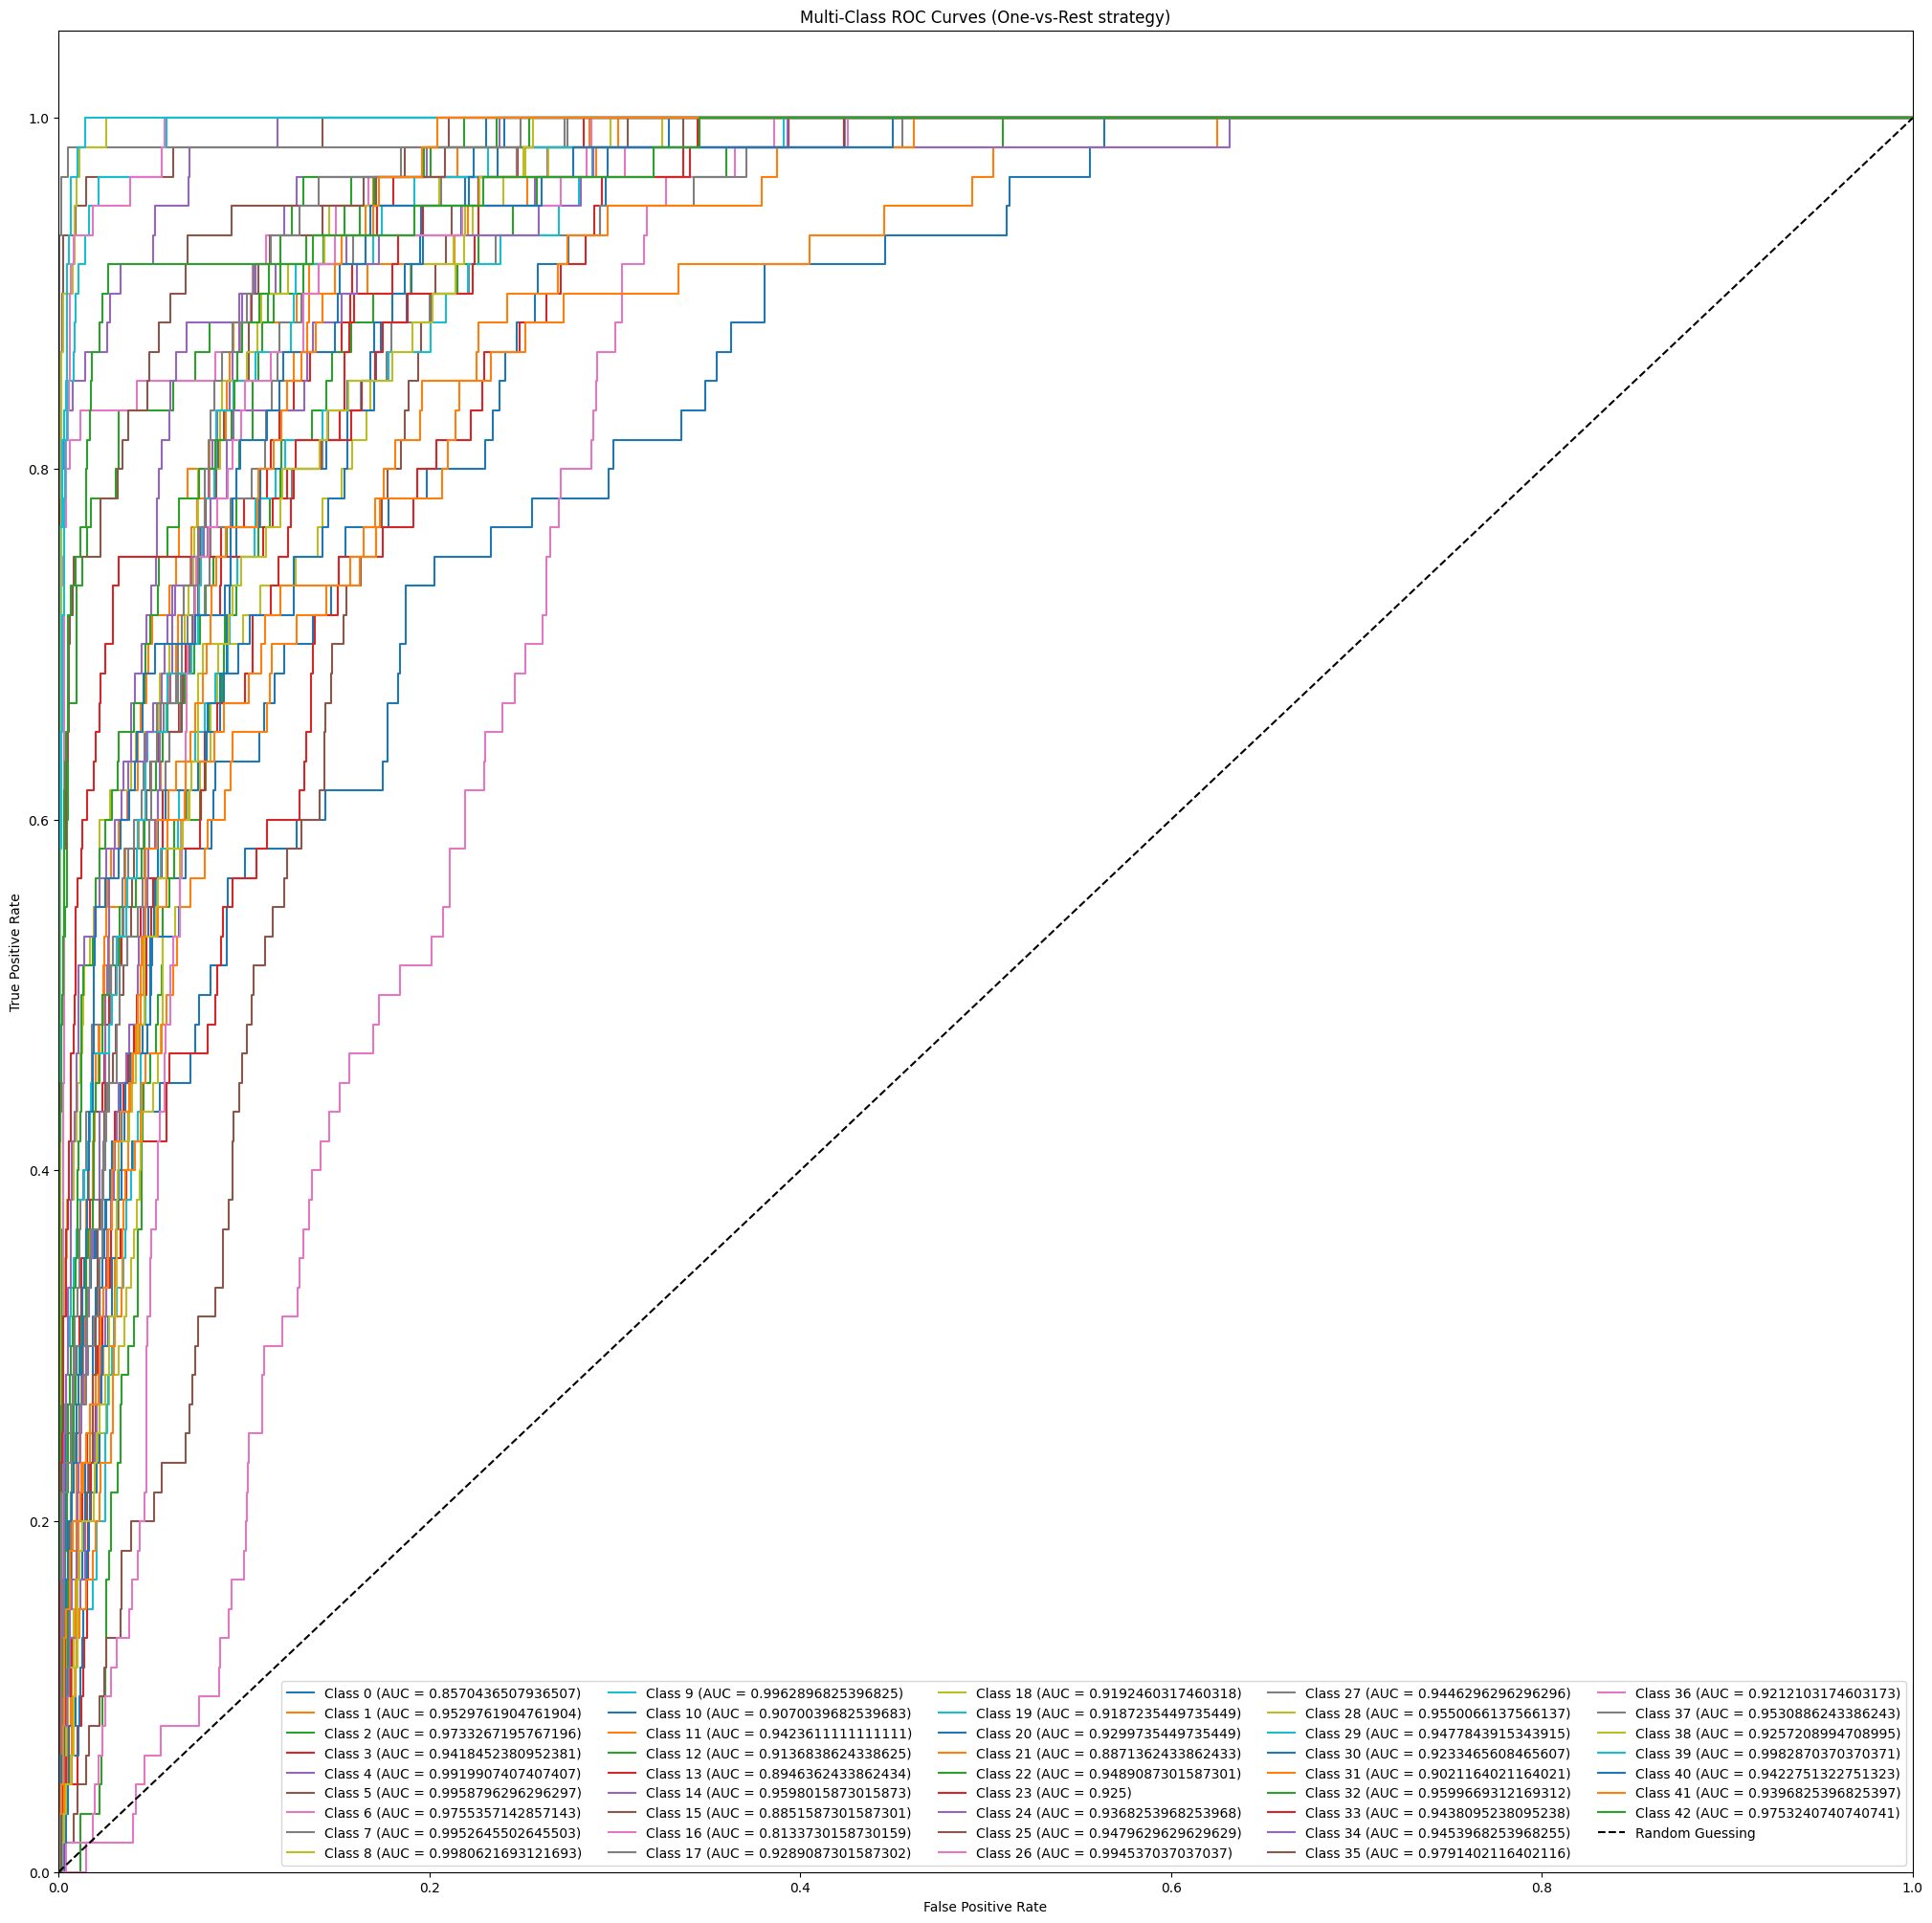

Test results - Loss: 3.1364870071411133 - Accuracy: 0.3980620205402374%
Top-K (K = 3) accuracy score: 0.6662790697674419


In [ ]:
train_dir = os.path.join(WORK_DIR,"Train")
validation_dir = os.path.join(WORK_DIR,"Validation")
test_dir = os.path.join(WORK_DIR,"Test")

train, validation, test = load_datasets(train_dir, validation_dir, test_dir)
result = compile_and_fit(model_pr_drop_l2, train, validation, epochs=50)
train_performance(result)
test_evaluation(model_pr_drop_l2, test)

Thanks to the application of dropout and L2-Regularization the model achieves an accuracy of approximately 39.8% and a Top-K (K=3) score of approximately 0.666. The model was trained for 35 epochs, after which the early stopping mechanism was activated for overfitting. The mitigation techniques applied have had the desired effect but the network seems unable to learn well.
It is important to underline a greater instability of the model compared to those previously discussed

**3) Model 3 with overfitting mitigation techniques and an extra dense layer**

To try to improve the learning capabilities of the network, additional hidden neurons are added to the dense layer, that now is composed by 512 neurons.

In [11]:
inputs = keras.Input(shape=PRETRAINED_INPUT_SHAPE)
x = keras.applications.vgg16.preprocess_input(inputs)

# Feature extraction
x = conv_base(x)

x = layers.Flatten()(x)

x = layers.Dropout(0.3)(x)
x = layers.Dense(512, kernel_regularizer=regularizers.l2(0.01)) (x)

x = layers.Dropout(0.3)(x)
outputs = layers.Dense(43, activation="softmax")(x)

model_pr_drop_l2_v2 = keras.Model(inputs, outputs, name="Model_Pretrained_drop_l2_v2")
show_and_save_model_summary(model_pr_drop_l2_v2)

Model: "Model_Pretrained_drop_l2_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 tf.__operators__.getitem (  (None, 48, 48, 3)         0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 48, 48, 3)         0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512

Load the dataset, train the model and evaluate it

Found 6450 files belonging to 43 classes.
Found 2580 files belonging to 43 classes.
Found 2580 files belonging to 43 classes.
Epoch 1/50
202/202 [==============================] - ETA: 0s - loss: 22.3669 - accuracy: 0.3166
Epoch 1: val_loss improved from inf to 17.26153, saving model to /content/drive/Shareddrives/Biondi/Models/Model_Pretrained_drop_l2_v2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


202/202 [==============================] - 11s 30ms/step - loss: 22.3669 - accuracy: 0.3166 - val_loss: 17.2615 - val_accuracy: 0.3376
Epoch 2/50
201/202 [============================>.] - ETA: 0s - loss: 14.0609 - accuracy: 0.4939
Epoch 2: val_loss improved from 17.26153 to 16.39526, saving model to /content/drive/Shareddrives/Biondi/Models/Model_Pretrained_drop_l2_v2.h5
202/202 [==============================] - 5s 26ms/step - loss: 14.0566 - accuracy: 0.4940 - val_loss: 16.3953 - val_accuracy: 0.3535
Epoch 3/50
199/202 [============================>.] - ETA: 0s - loss: 12.1096 - accuracy: 0.5367
Epoch 3: val_loss improved from 16.39526 to 15.37897, saving model to /content/drive/Shareddrives/Biondi/Models/Model_Pretrained_drop_l2_v2.h5
202/202 [==============================] - 4s 19ms/step - loss: 12.0843 - accuracy: 0.5364 - val_loss: 15.3790 - val_accuracy: 0.3961
Epoch 4/50
200/202 [============================>.] - ETA: 0s - loss: 10.7308 - accuracy: 0.5639
Epoch 4: val_loss im

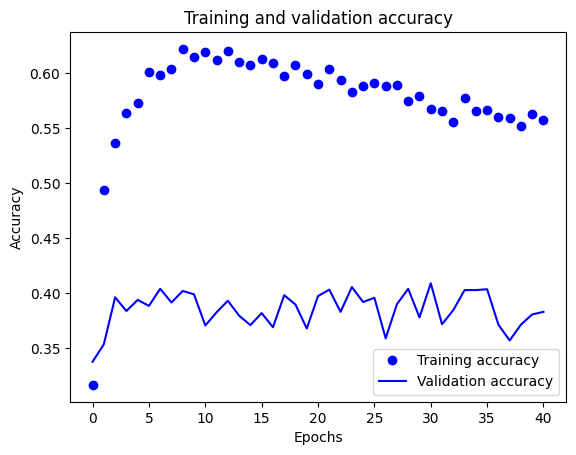

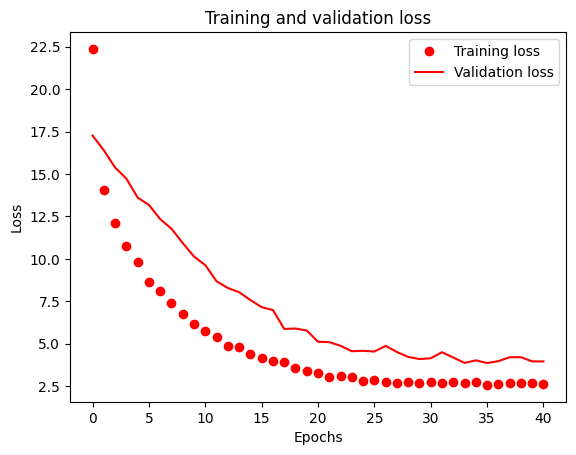

81/81 [==============================] - 1s 10ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.3235    0.1833    0.2340        60
           1     0.2186    0.6667    0.3292        60
           2     0.8333    0.4167    0.5556        60
           3     0.3571    0.2500    0.2941        60
           4     0.9412    0.8000    0.8649        60
           5     0.7857    0.9167    0.8462        60
           6     0.8936    0.7000    0.7850        60
           7     0.8116    0.9333    0.8682        60
           8     0.8537    0.5833    0.6931        60
           9     0.7385    0.8000    0.7680        60
          10     0.6154    0.2667    0.3721        60
          11     0.2857    0.0333    0.0597        60
          12     0.1591    0.1167    0.1346        60
          13     0.4074    0.1833    0.2529        60
          14     0.2381    0.1667    0.1961        60
          15     0.0922    0.2167    0.1294        60
   

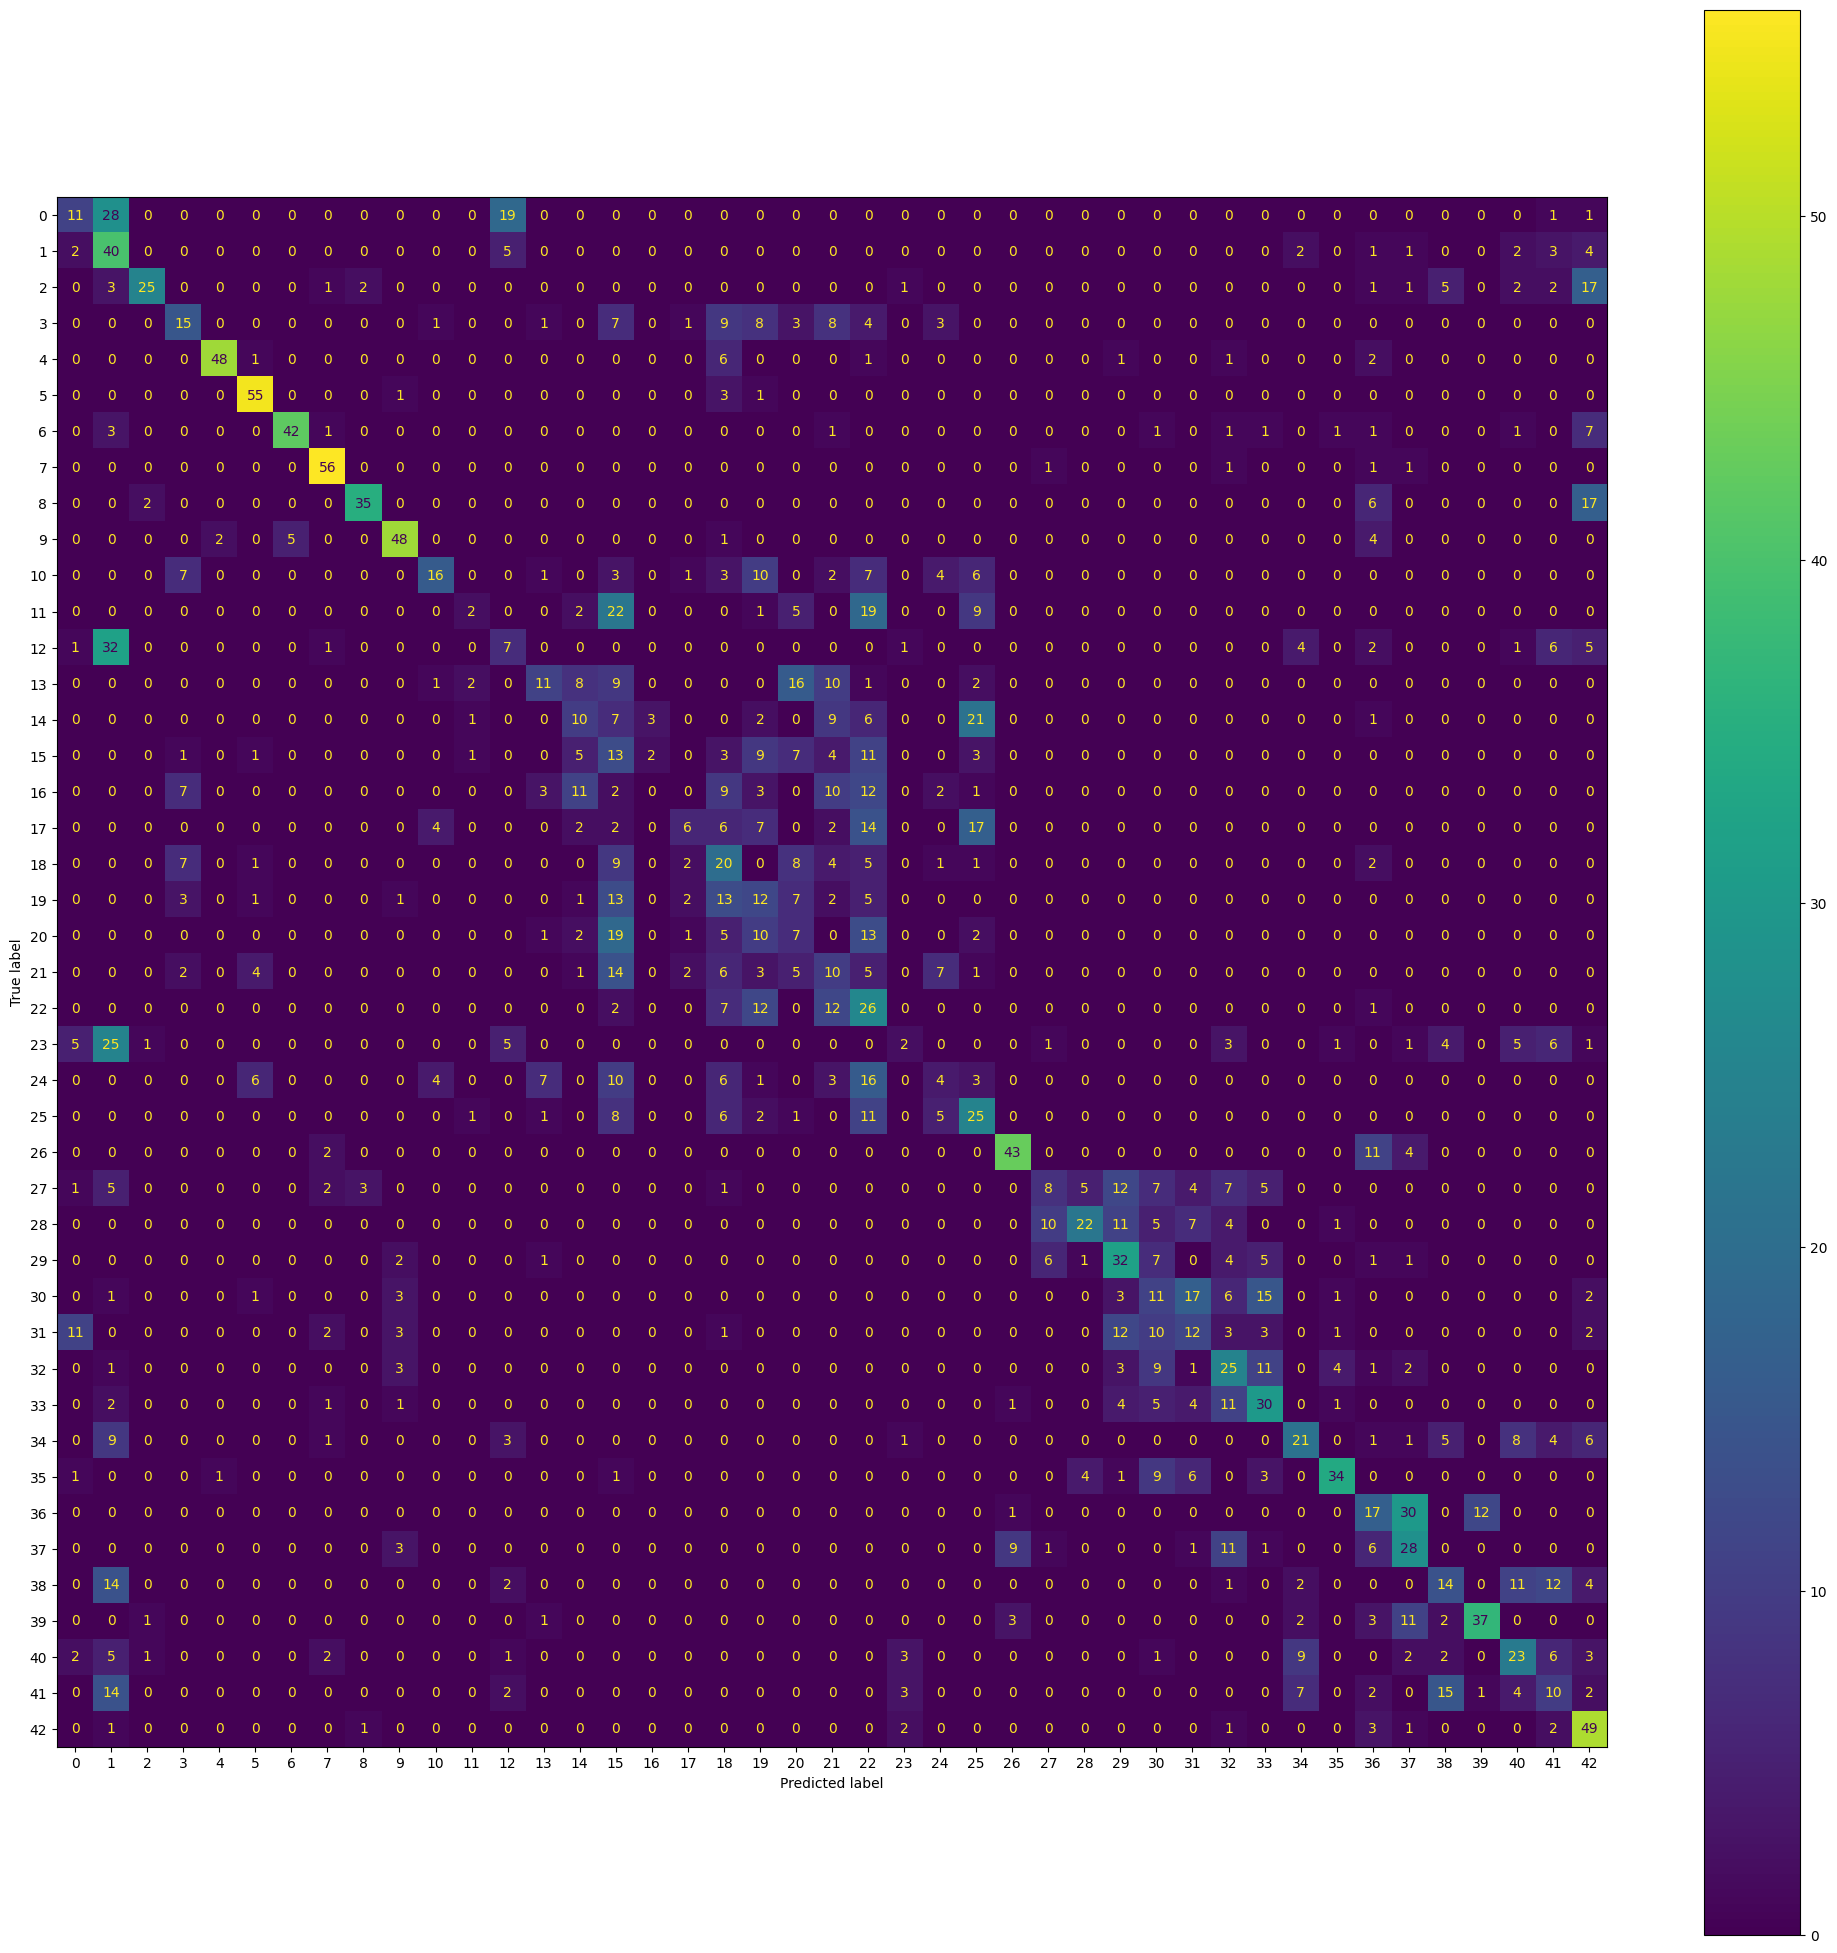

ROC Curve:


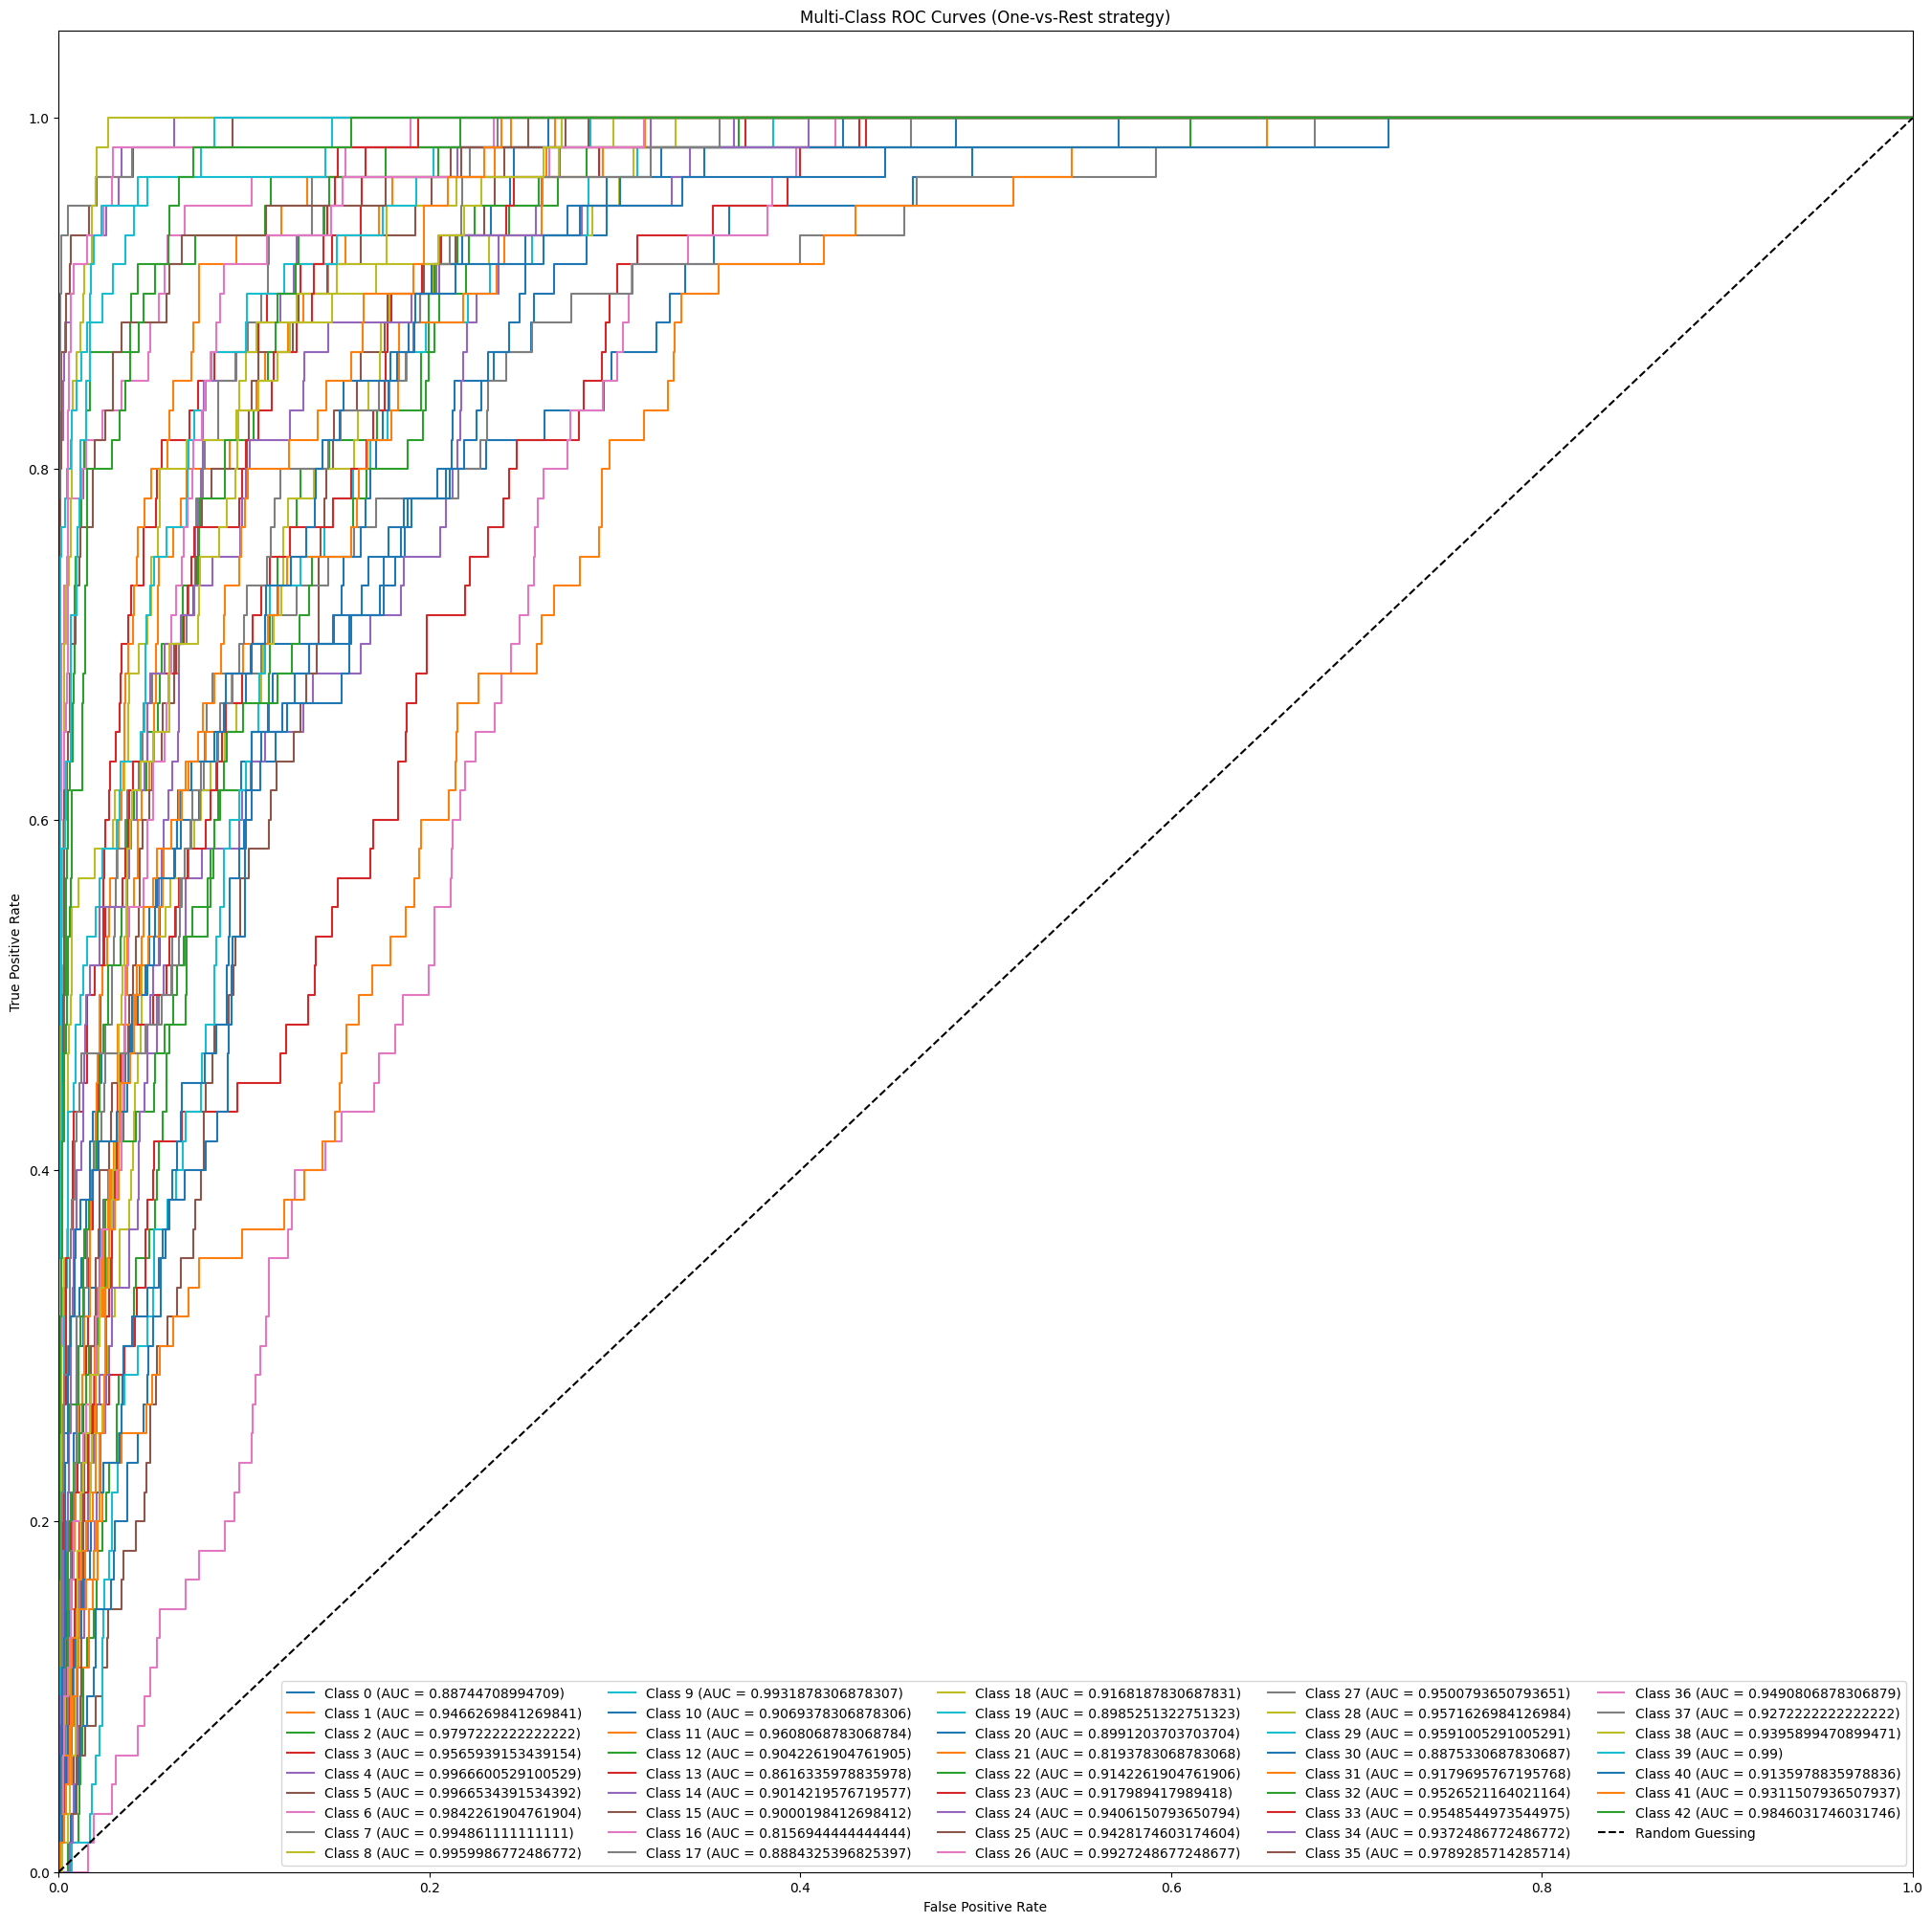

Test results - Loss: 3.9390828609466553 - Accuracy: 0.37286821007728577%
Top-K (K = 3) accuracy score: 0.6255813953488372


In [12]:
train_dir = os.path.join(WORK_DIR,"Train")
validation_dir = os.path.join(WORK_DIR,"Validation")
test_dir = os.path.join(WORK_DIR,"Test")

train, validation, test = load_datasets(train_dir, validation_dir, test_dir)
result = compile_and_fit(model_pr_drop_l2_v2, train, validation, epochs=50)
train_performance(result)
test_evaluation(model_pr_drop_l2_v2, test)

The model achieves an accuracy of approximately 37.3% and a Top-K (K=3) score of approximately 0.626, slightly worse than before. The model was trained for 41 epochs, after which the early stopping mechanism was activated for overfitting. The network seems incapable of learning well from features as specific as those output from VGG16.

**4) Model 4 with feature extracted from block4_pool of VGG16**

In an attempt to increase the learning capabilities of the network, VGG16 features are now extracted from layers prior to the last one. The network presents a different structure compared to those previously observed (when we used "all" VGG16) to obtain a network capable of learning and limiting overfitting if possible. For this last objective, the network is also equipped with dropout and L2-Regularization.

Let's extract the interested features:

In [ ]:
vgg_ft_extraction_block4 = models.Model(inputs = conv_base.input, outputs = conv_base.get_layer('block4_pool').output)
vgg_ft_extraction_block4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
inputs = keras.Input(shape=PRETRAINED_INPUT_SHAPE)
x = keras.applications.vgg16.preprocess_input(inputs)

# Feature extraction
x = vgg_ft_extraction_block4(x)

x = layers.Flatten()(x)

x = layers.Dropout(0.5)(x)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.01)) (x)

x = layers.Dropout(0.3)(x)
outputs = layers.Dense(43, activation="softmax")(x)

model_vgg_feature_block4 = keras.Model(inputs, outputs, name="Model_VGG16_feature_block4")
show_and_save_model_summary(model_vgg_feature_block4)

Model: "Model_VGG16_feature_block4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 tf.__operators__.getitem_8  (None, 48, 48, 3)         0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_8 (TFOpLamb  (None, 48, 48, 3)         0         
 da)                                                             
                                                                 
 model (Functional)          (None, 3, 3, 512)         7635264   
                                                                 
 flatten_8 (Flatten)         (None, 4608)              0         
                                                                 
 dropout_16 (Dropout)        (None, 4608

Load the dataset, train the model and evaluate it

Found 6450 files belonging to 43 classes.
Found 2580 files belonging to 43 classes.
Found 2580 files belonging to 43 classes.
Epoch 1/30
202/202 [==============================] - ETA: 0s - loss: 574.0328 - accuracy: 0.4426
Epoch 1: val_loss improved from inf to 328.91846, saving model to /content/drive/Shareddrives/Biondi/Models/Model_VGG16_feature_block4.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


202/202 [==============================] - 5s 20ms/step - loss: 574.0328 - accuracy: 0.4426 - val_loss: 328.9185 - val_accuracy: 0.5562
Epoch 2/30
198/202 [============================>.] - ETA: 0s - loss: 234.6676 - accuracy: 0.7064
Epoch 2: val_loss improved from 328.91846 to 319.03549, saving model to /content/drive/Shareddrives/Biondi/Models/Model_VGG16_feature_block4.h5
202/202 [==============================] - 5s 22ms/step - loss: 233.2041 - accuracy: 0.7076 - val_loss: 319.0355 - val_accuracy: 0.5930
Epoch 3/30
198/202 [============================>.] - ETA: 0s - loss: 166.6213 - accuracy: 0.7740
Epoch 3: val_loss improved from 319.03549 to 279.39267, saving model to /content/drive/Shareddrives/Biondi/Models/Model_VGG16_feature_block4.h5
202/202 [==============================] - 3s 15ms/step - loss: 166.3698 - accuracy: 0.7740 - val_loss: 279.3927 - val_accuracy: 0.6512
Epoch 4/30
197/202 [============================>.] - ETA: 0s - loss: 122.1329 - accuracy: 0.8195
Epoch 4: v

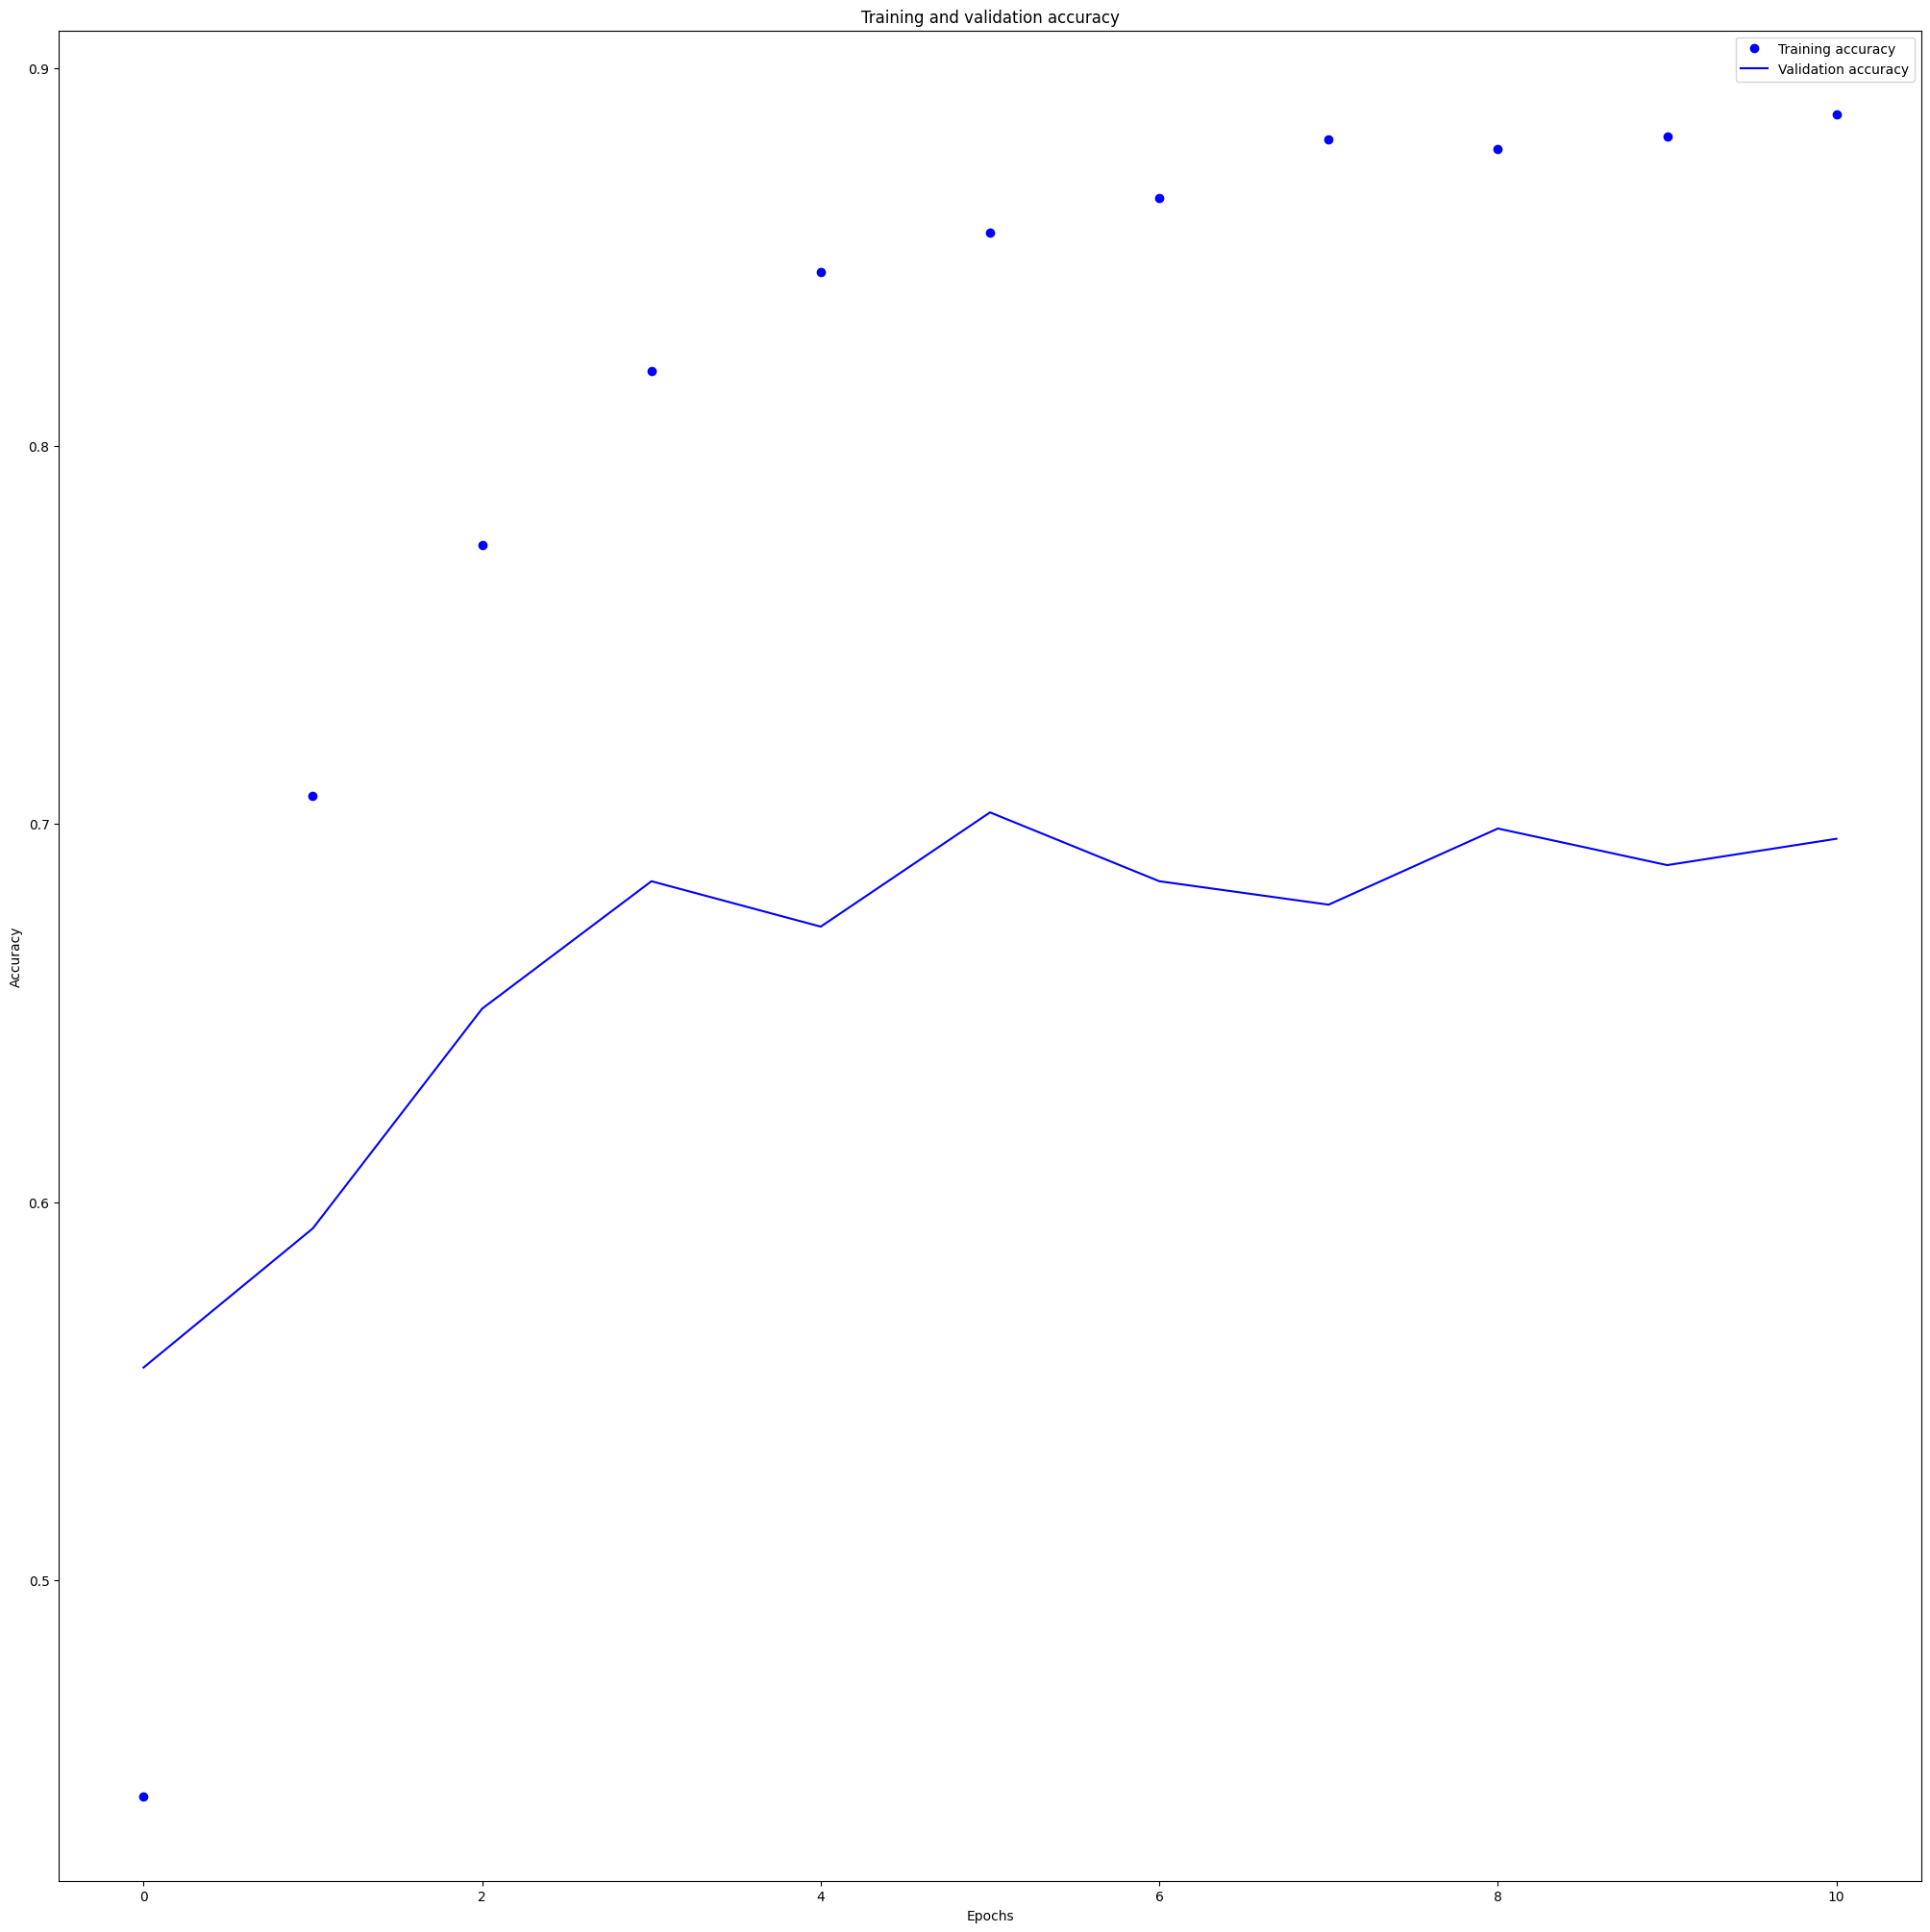

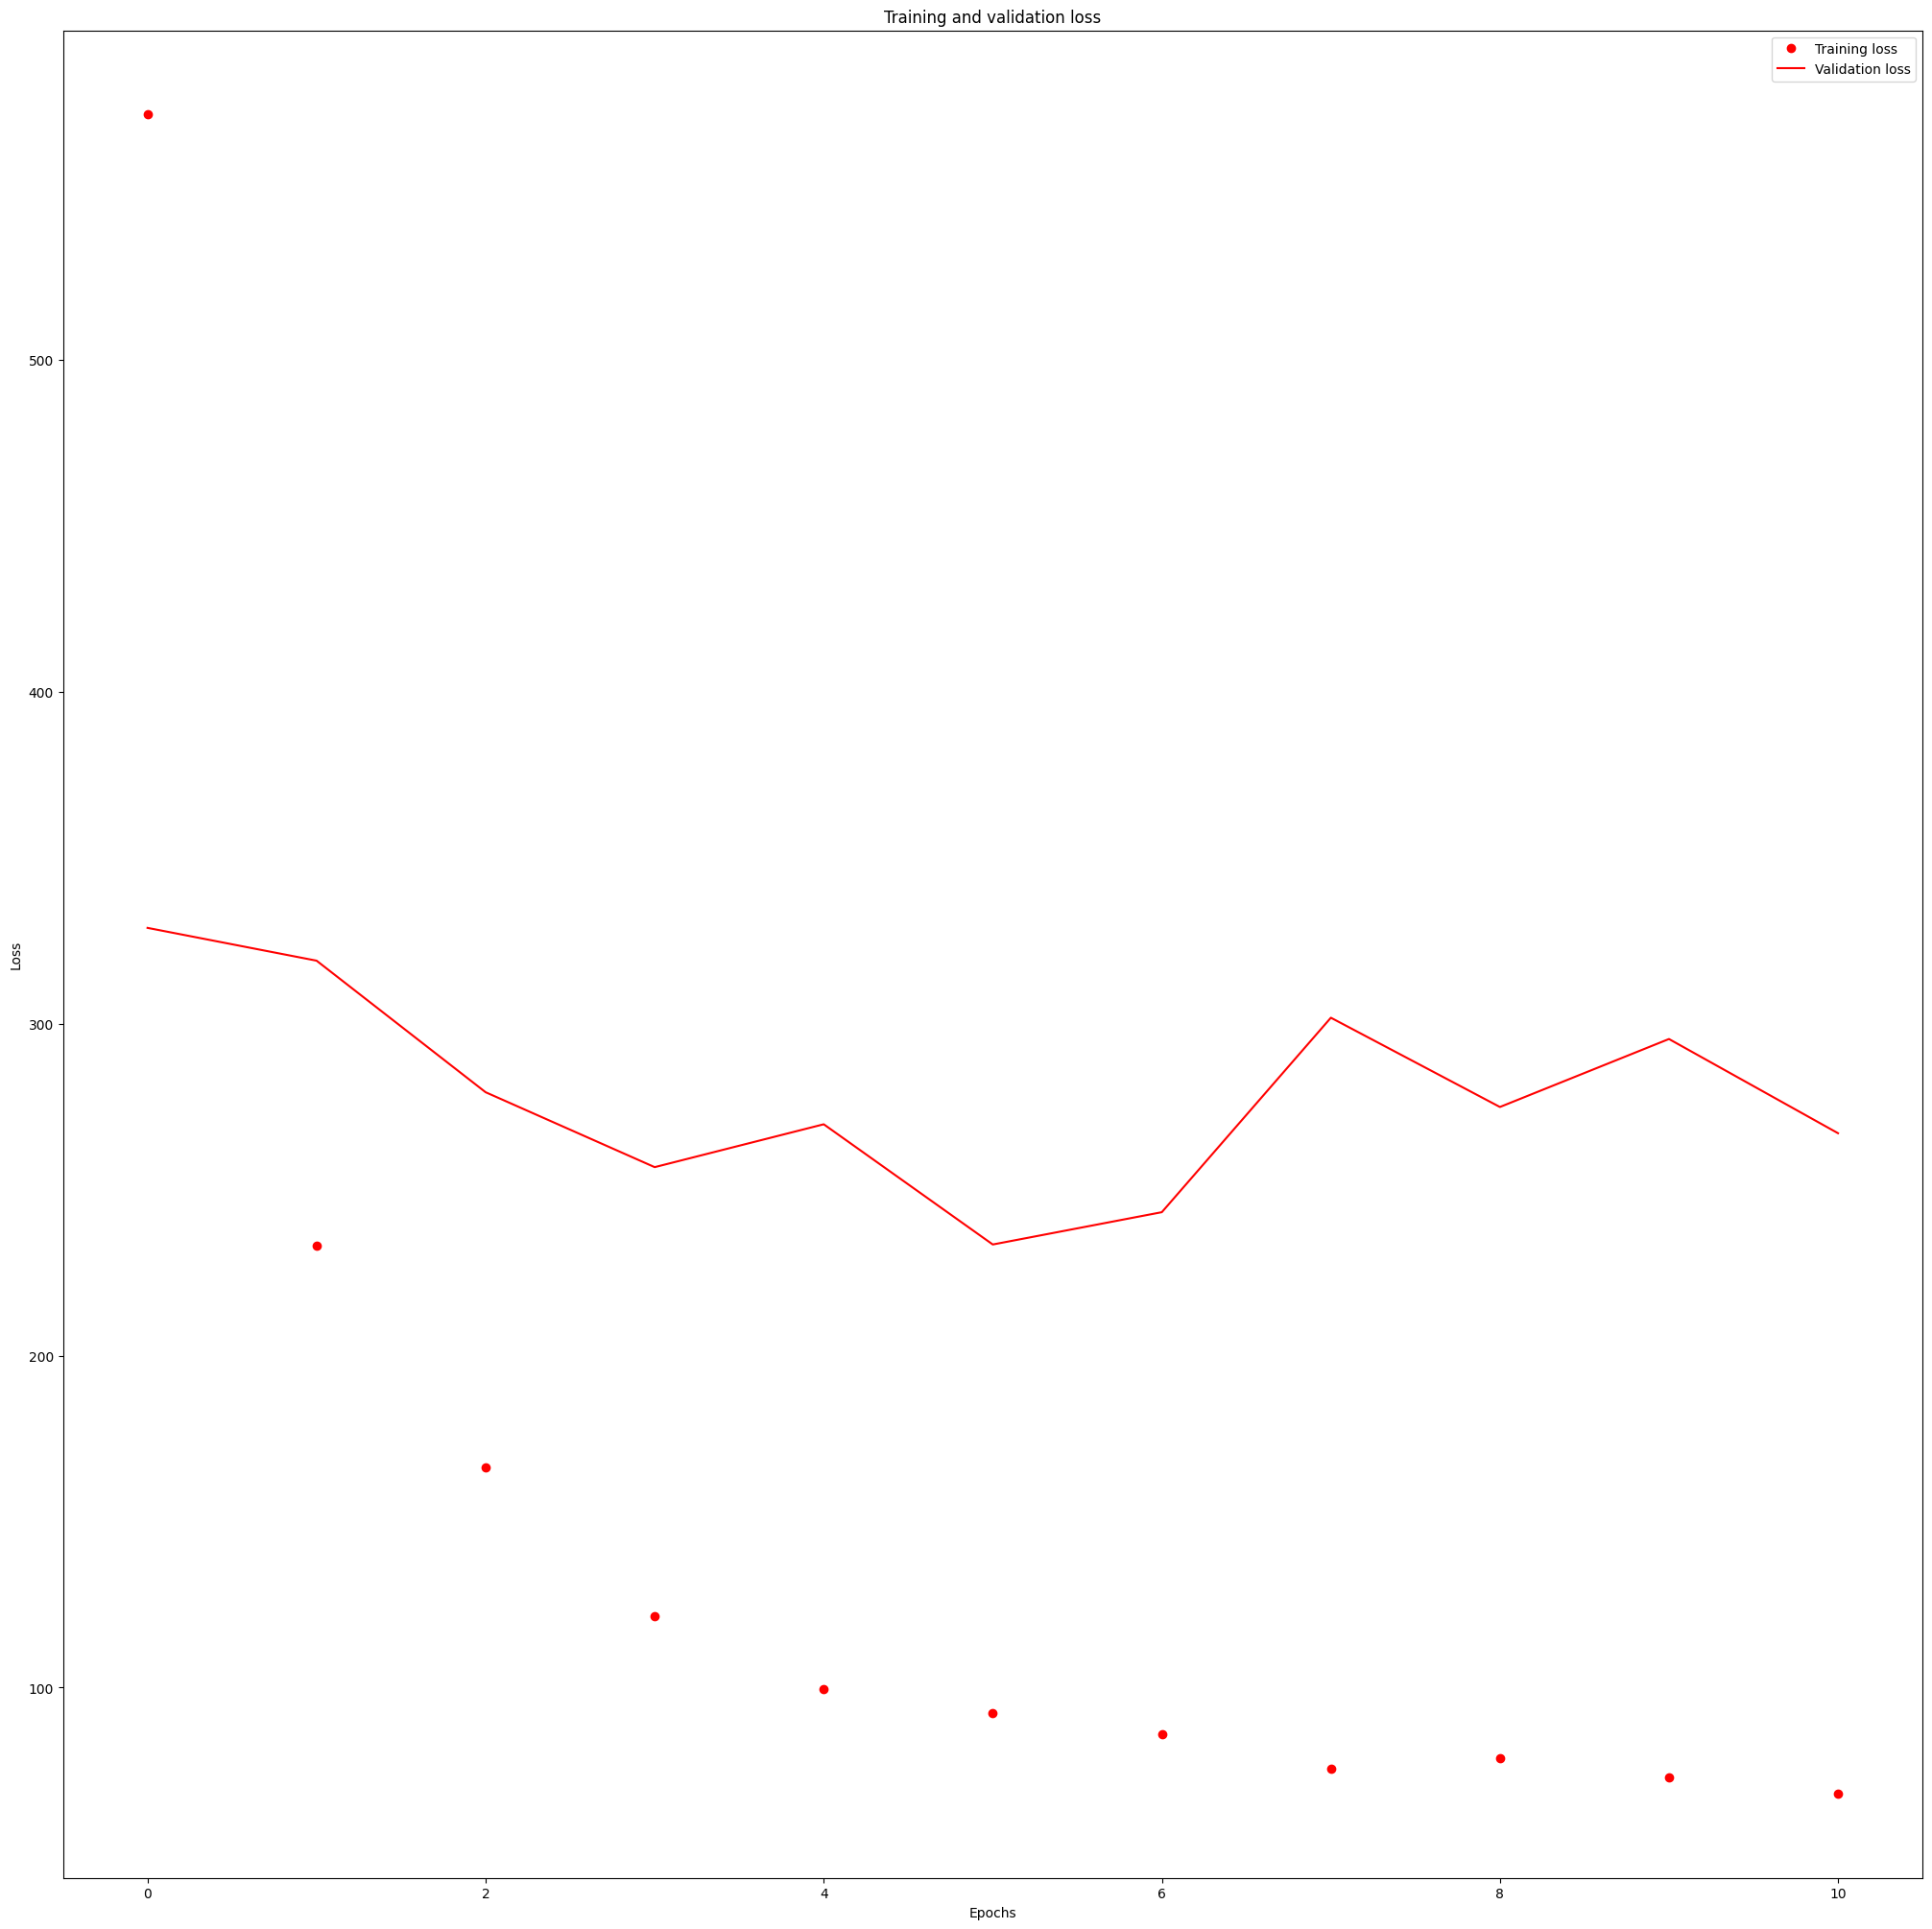

81/81 [==============================] - 1s 8ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.5758    0.6333    0.6032        60
           1     0.8065    0.4167    0.5495        60
           2     0.8462    0.9167    0.8800        60
           3     0.7910    0.8833    0.8346        60
           4     1.0000    0.9333    0.9655        60
           5     0.9836    1.0000    0.9917        60
           6     1.0000    0.8000    0.8889        60
           7     0.9091    1.0000    0.9524        60
           8     1.0000    0.8333    0.9091        60
           9     0.9672    0.9833    0.9752        60
          10     0.9184    0.7500    0.8257        60
          11     0.4714    0.5500    0.5077        60
          12     0.4324    0.2667    0.3299        60
          13     0.5833    0.4667    0.5185        60
          14     0.6852    0.6167    0.6491        60
          15     0.7013    0.9000    0.7883        60
    

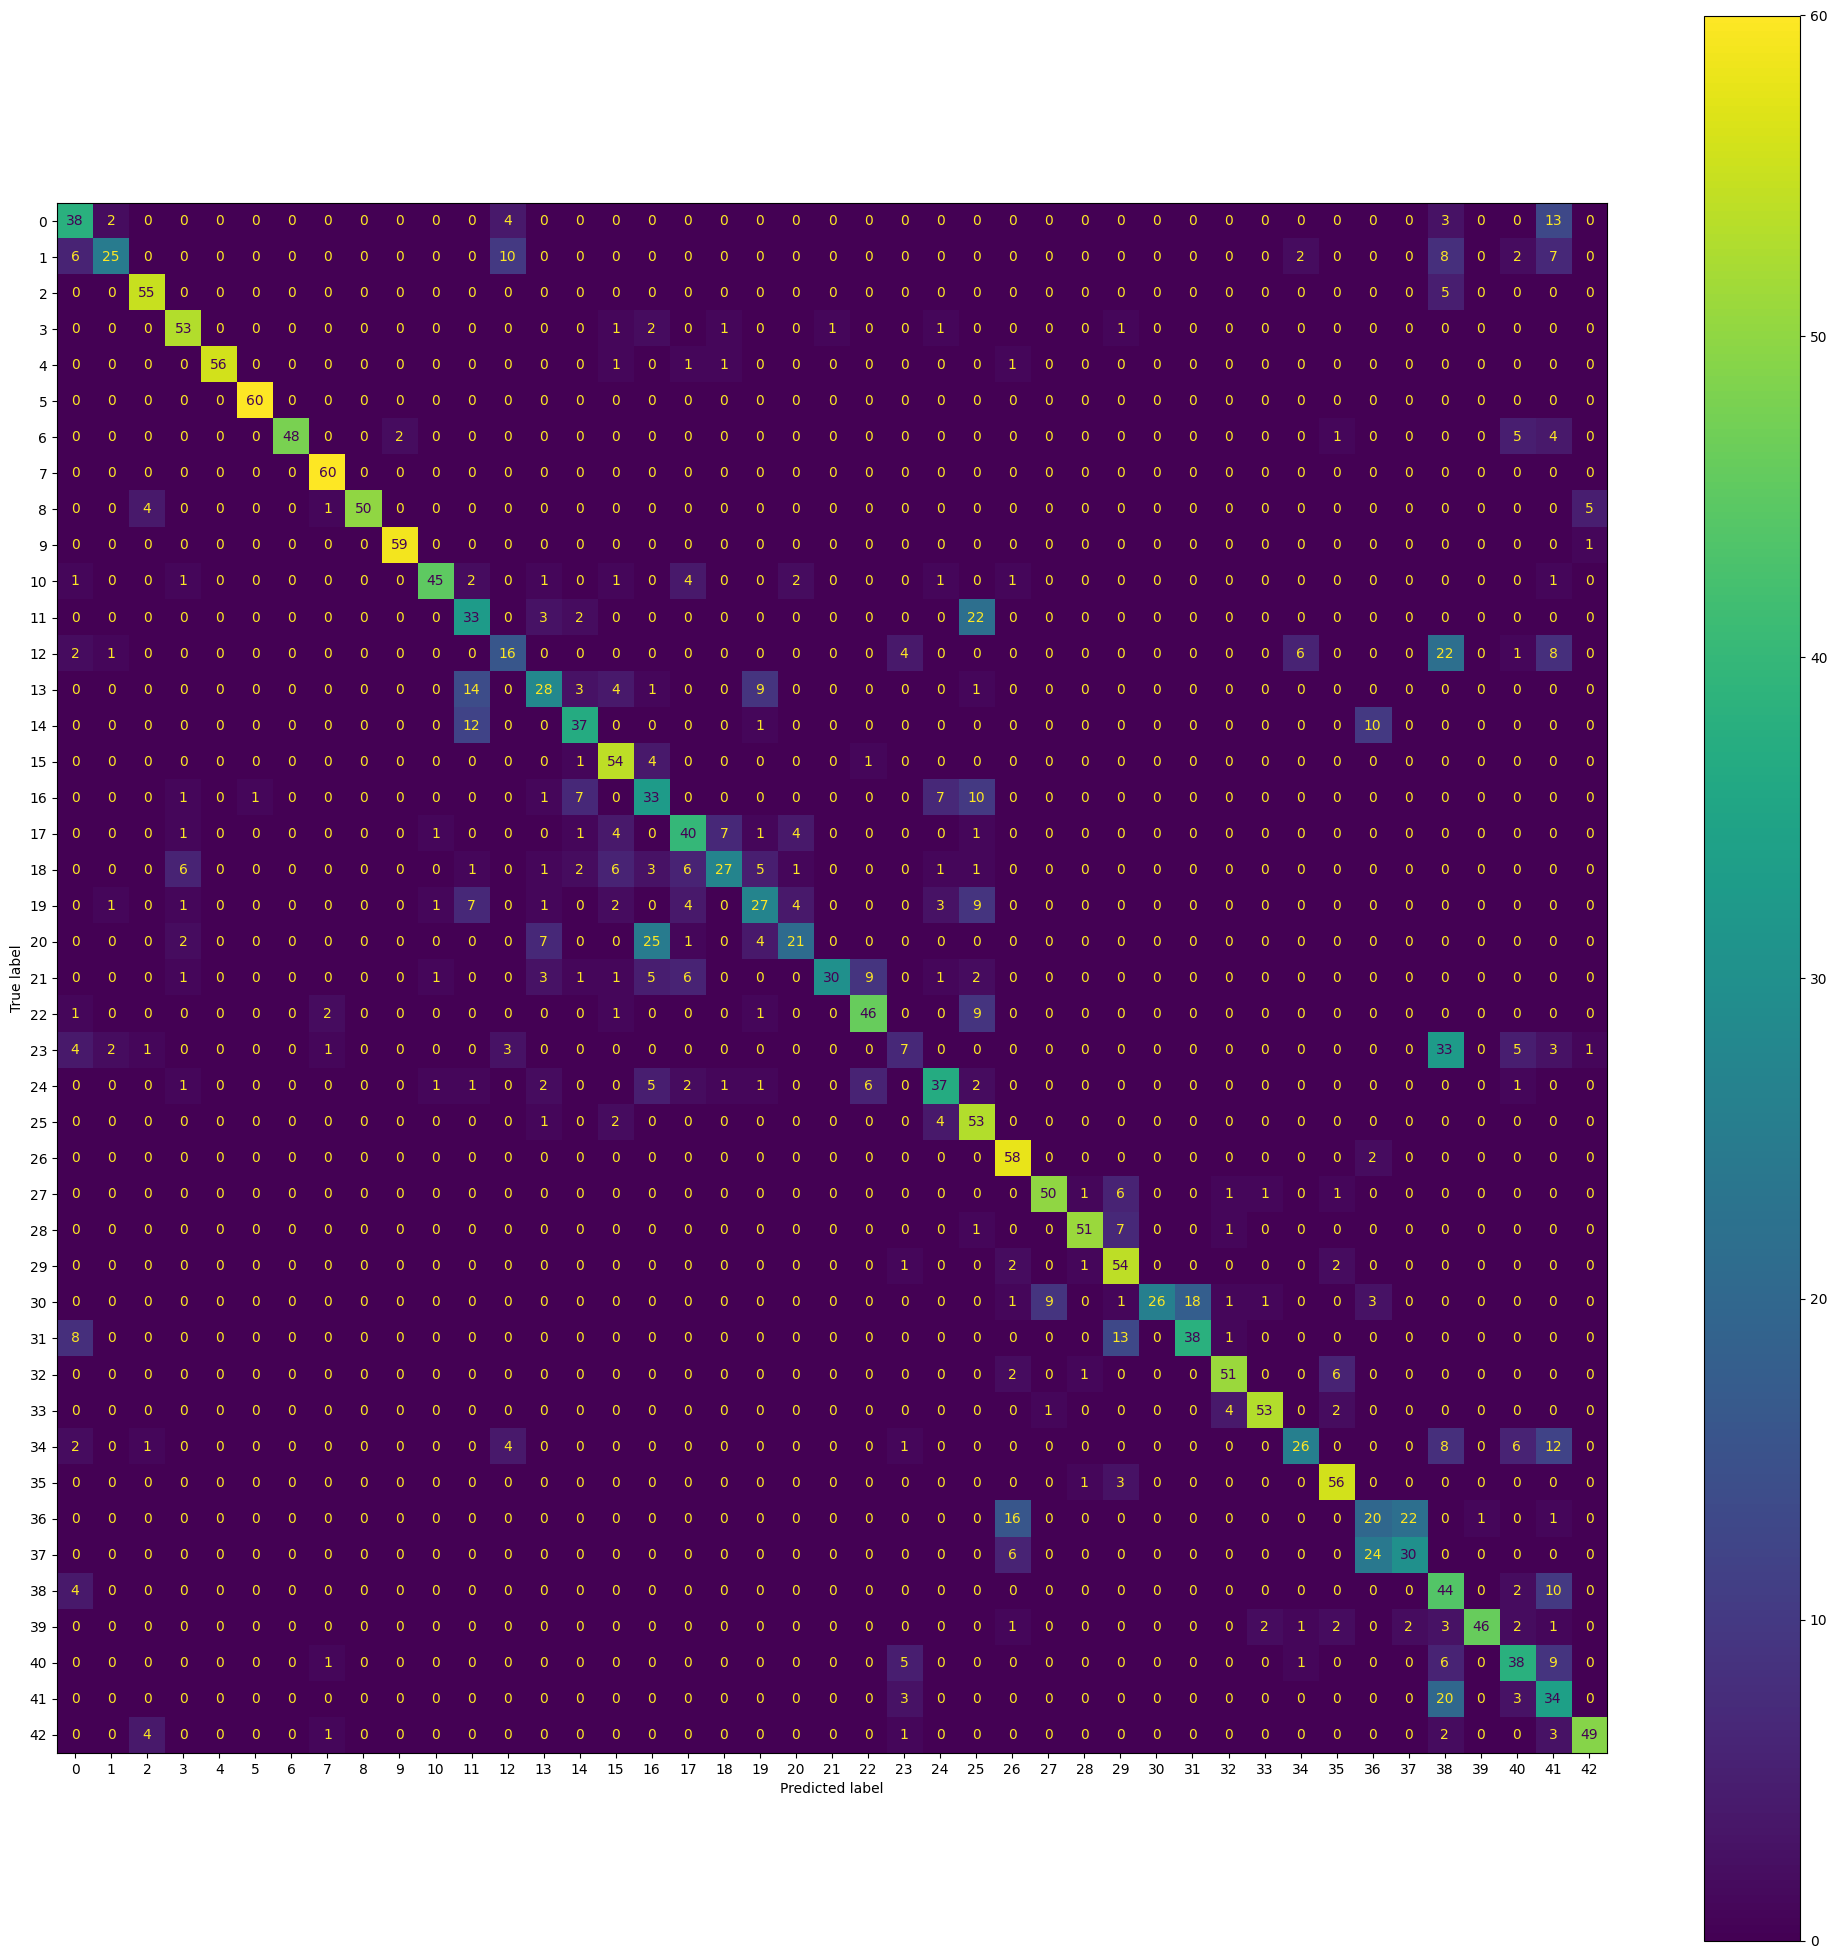

ROC Curve:


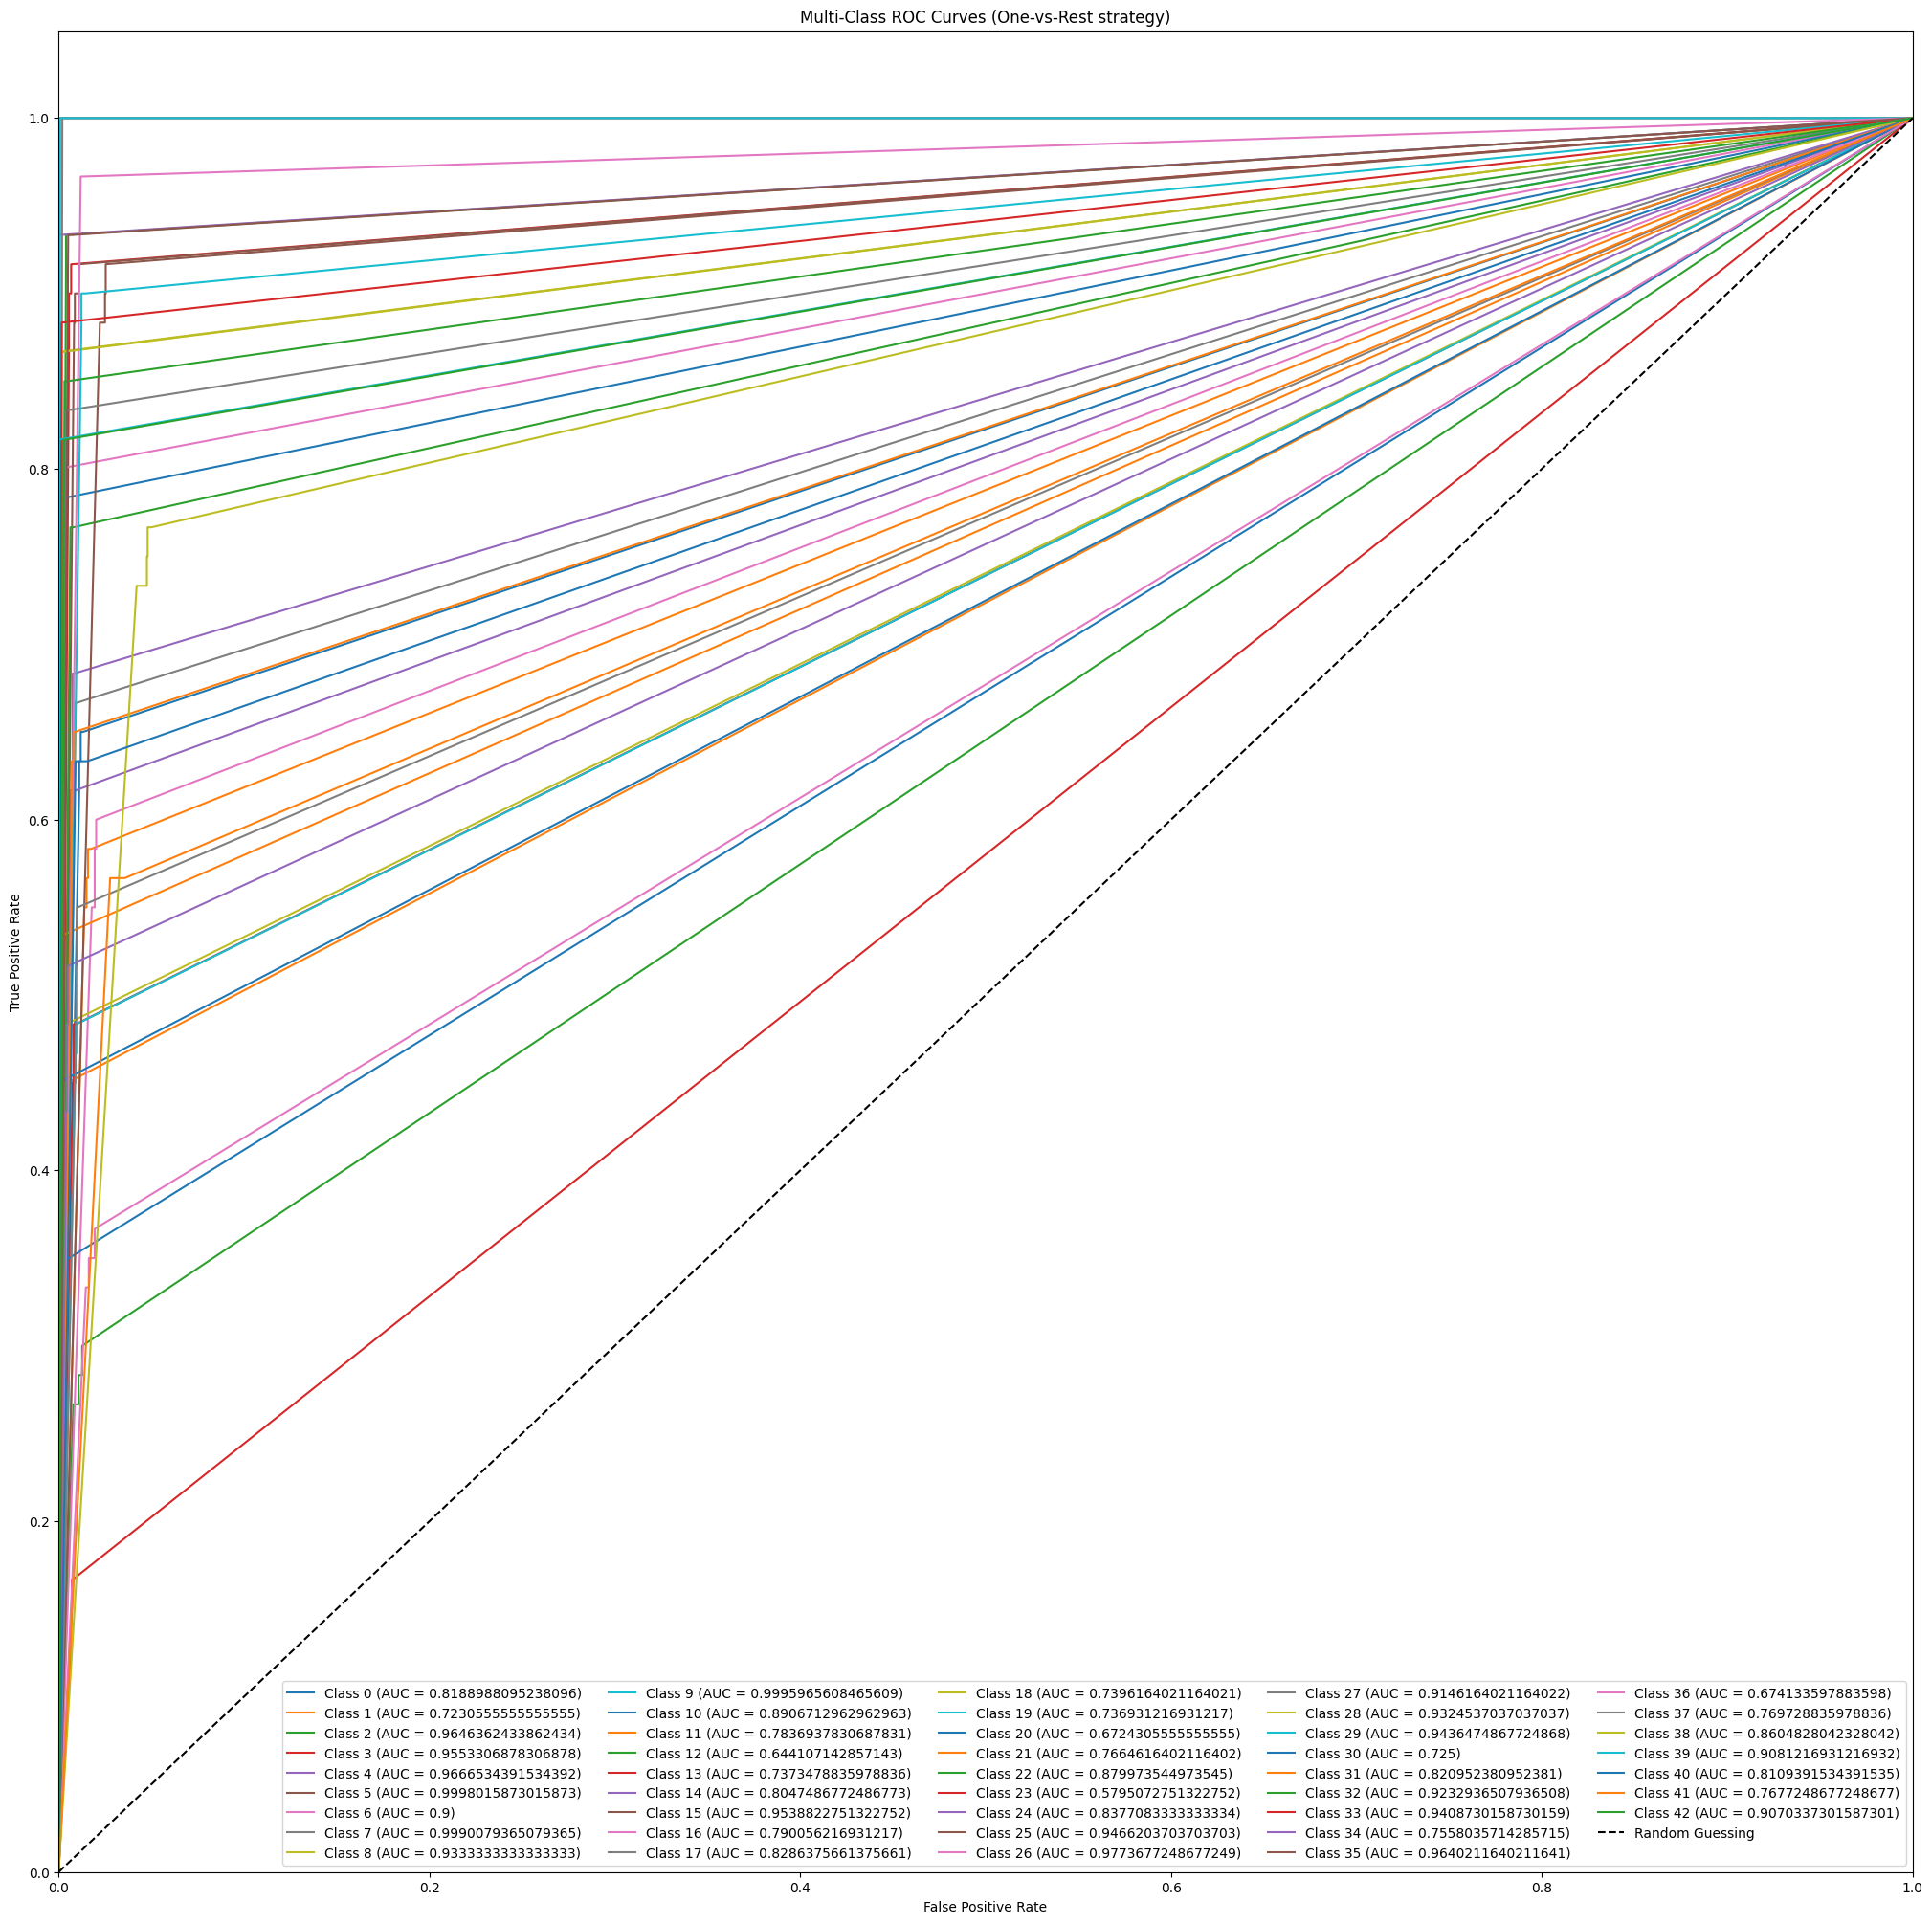

Test results - Loss: 263.0162658691406 - Accuracy: 0.682945728302002%
Top-K (K = 3) accuracy score: 0.7197674418604652


In [ ]:
train_dir = os.path.join(WORK_DIR,"Train")
validation_dir = os.path.join(WORK_DIR,"Validation")
test_dir = os.path.join(WORK_DIR,"Test")

train, validation, test = load_datasets(train_dir, validation_dir, test_dir)
result = compile_and_fit(model_vgg_feature_block4, train, validation)
train_performance(result)
test_evaluation(model_vgg_feature_block4, test)

Thanks to the use of features extracted from 'block4_pool', the model achieves an accuracy of around 68.3% and a Top-K score (K=3) of around 0.72. The model was trained for 11 epochs, after which the early stopping mechanism was activated for overfitting. This result shows the effectiveness of intuition, greatly increasing the performance obtained. The instability of the network should be highlighted.

**5) Model 5 with feature extracted from block3_pool of VGG16**

In an attempt to increase the learning capabilities of the network, VGG16 features are now extracted from layers prior to the last one. The network presents a different structure compared to those previously observed (when we used "all" VGG16) to obtain a network capable of learning and limiting overfitting if possible. For this last objective, the network is also equipped with dropout and L2-Regularization.

Let's extract the interested features:

In [ ]:
vgg_ft_extraction_block3 = models.Model(inputs = conv_base.input, outputs = conv_base.get_layer('block3_pool').output)
vgg_ft_extraction_block3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [ ]:
inputs = keras.Input(shape=PRETRAINED_INPUT_SHAPE)
x = keras.applications.vgg16.preprocess_input(inputs)

# Feature extraction
x = vgg_ft_extraction_block3(x)

x = layers.Flatten()(x)

x = layers.Dropout(0.5)(x)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.01)) (x)

x = layers.Dropout(0.3)(x)
outputs = layers.Dense(43, activation="softmax")(x)

model_vgg_feature_block3 = keras.Model(inputs, outputs, name="Model_VGG16_feature_block3")
show_and_save_model_summary(model_vgg_feature_block3)

Model: "Model_VGG16_feature_block3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 tf.__operators__.getitem_9  (None, 48, 48, 3)         0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_9 (TFOpLamb  (None, 48, 48, 3)         0         
 da)                                                             
                                                                 
 model_1 (Functional)        (None, 6, 6, 256)         1735488   
                                                                 
 flatten_9 (Flatten)         (None, 9216)              0         
                                                                 
 dropout_18 (Dropout)        (None, 9216

Load the dataset, train the model and evaluate it

Found 6450 files belonging to 43 classes.
Found 2580 files belonging to 43 classes.
Found 2580 files belonging to 43 classes.
Epoch 1/30
200/202 [============================>.] - ETA: 0s - loss: 3007.3562 - accuracy: 0.6067
Epoch 1: val_loss improved from inf to 1126.42139, saving model to /content/drive/Shareddrives/Biondi/Models/Model_VGG16_feature_block3.h5
202/202 [==============================] - 6s 25ms/step - loss: 2991.3218 - accuracy: 0.6085 - val_loss: 1126.4214 - val_accuracy: 0.7899
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


201/202 [============================>.] - ETA: 0s - loss: 868.9551 - accuracy: 0.8436
Epoch 2: val_loss improved from 1126.42139 to 1123.08337, saving model to /content/drive/Shareddrives/Biondi/Models/Model_VGG16_feature_block3.h5
202/202 [==============================] - 3s 14ms/step - loss: 868.5525 - accuracy: 0.8434 - val_loss: 1123.0834 - val_accuracy: 0.8019
Epoch 3/30
197/202 [============================>.] - ETA: 0s - loss: 586.7719 - accuracy: 0.8951
Epoch 3: val_loss did not improve from 1123.08337
202/202 [==============================] - 3s 13ms/step - loss: 589.2203 - accuracy: 0.8946 - val_loss: 1306.0165 - val_accuracy: 0.8163
Epoch 4/30
197/202 [============================>.] - ETA: 0s - loss: 561.2231 - accuracy: 0.9067
Epoch 4: val_loss did not improve from 1123.08337
202/202 [==============================] - 4s 18ms/step - loss: 559.7719 - accuracy: 0.9070 - val_loss: 1785.8519 - val_accuracy: 0.7787
Epoch 5/30
200/202 [============================>.] - ETA: 0

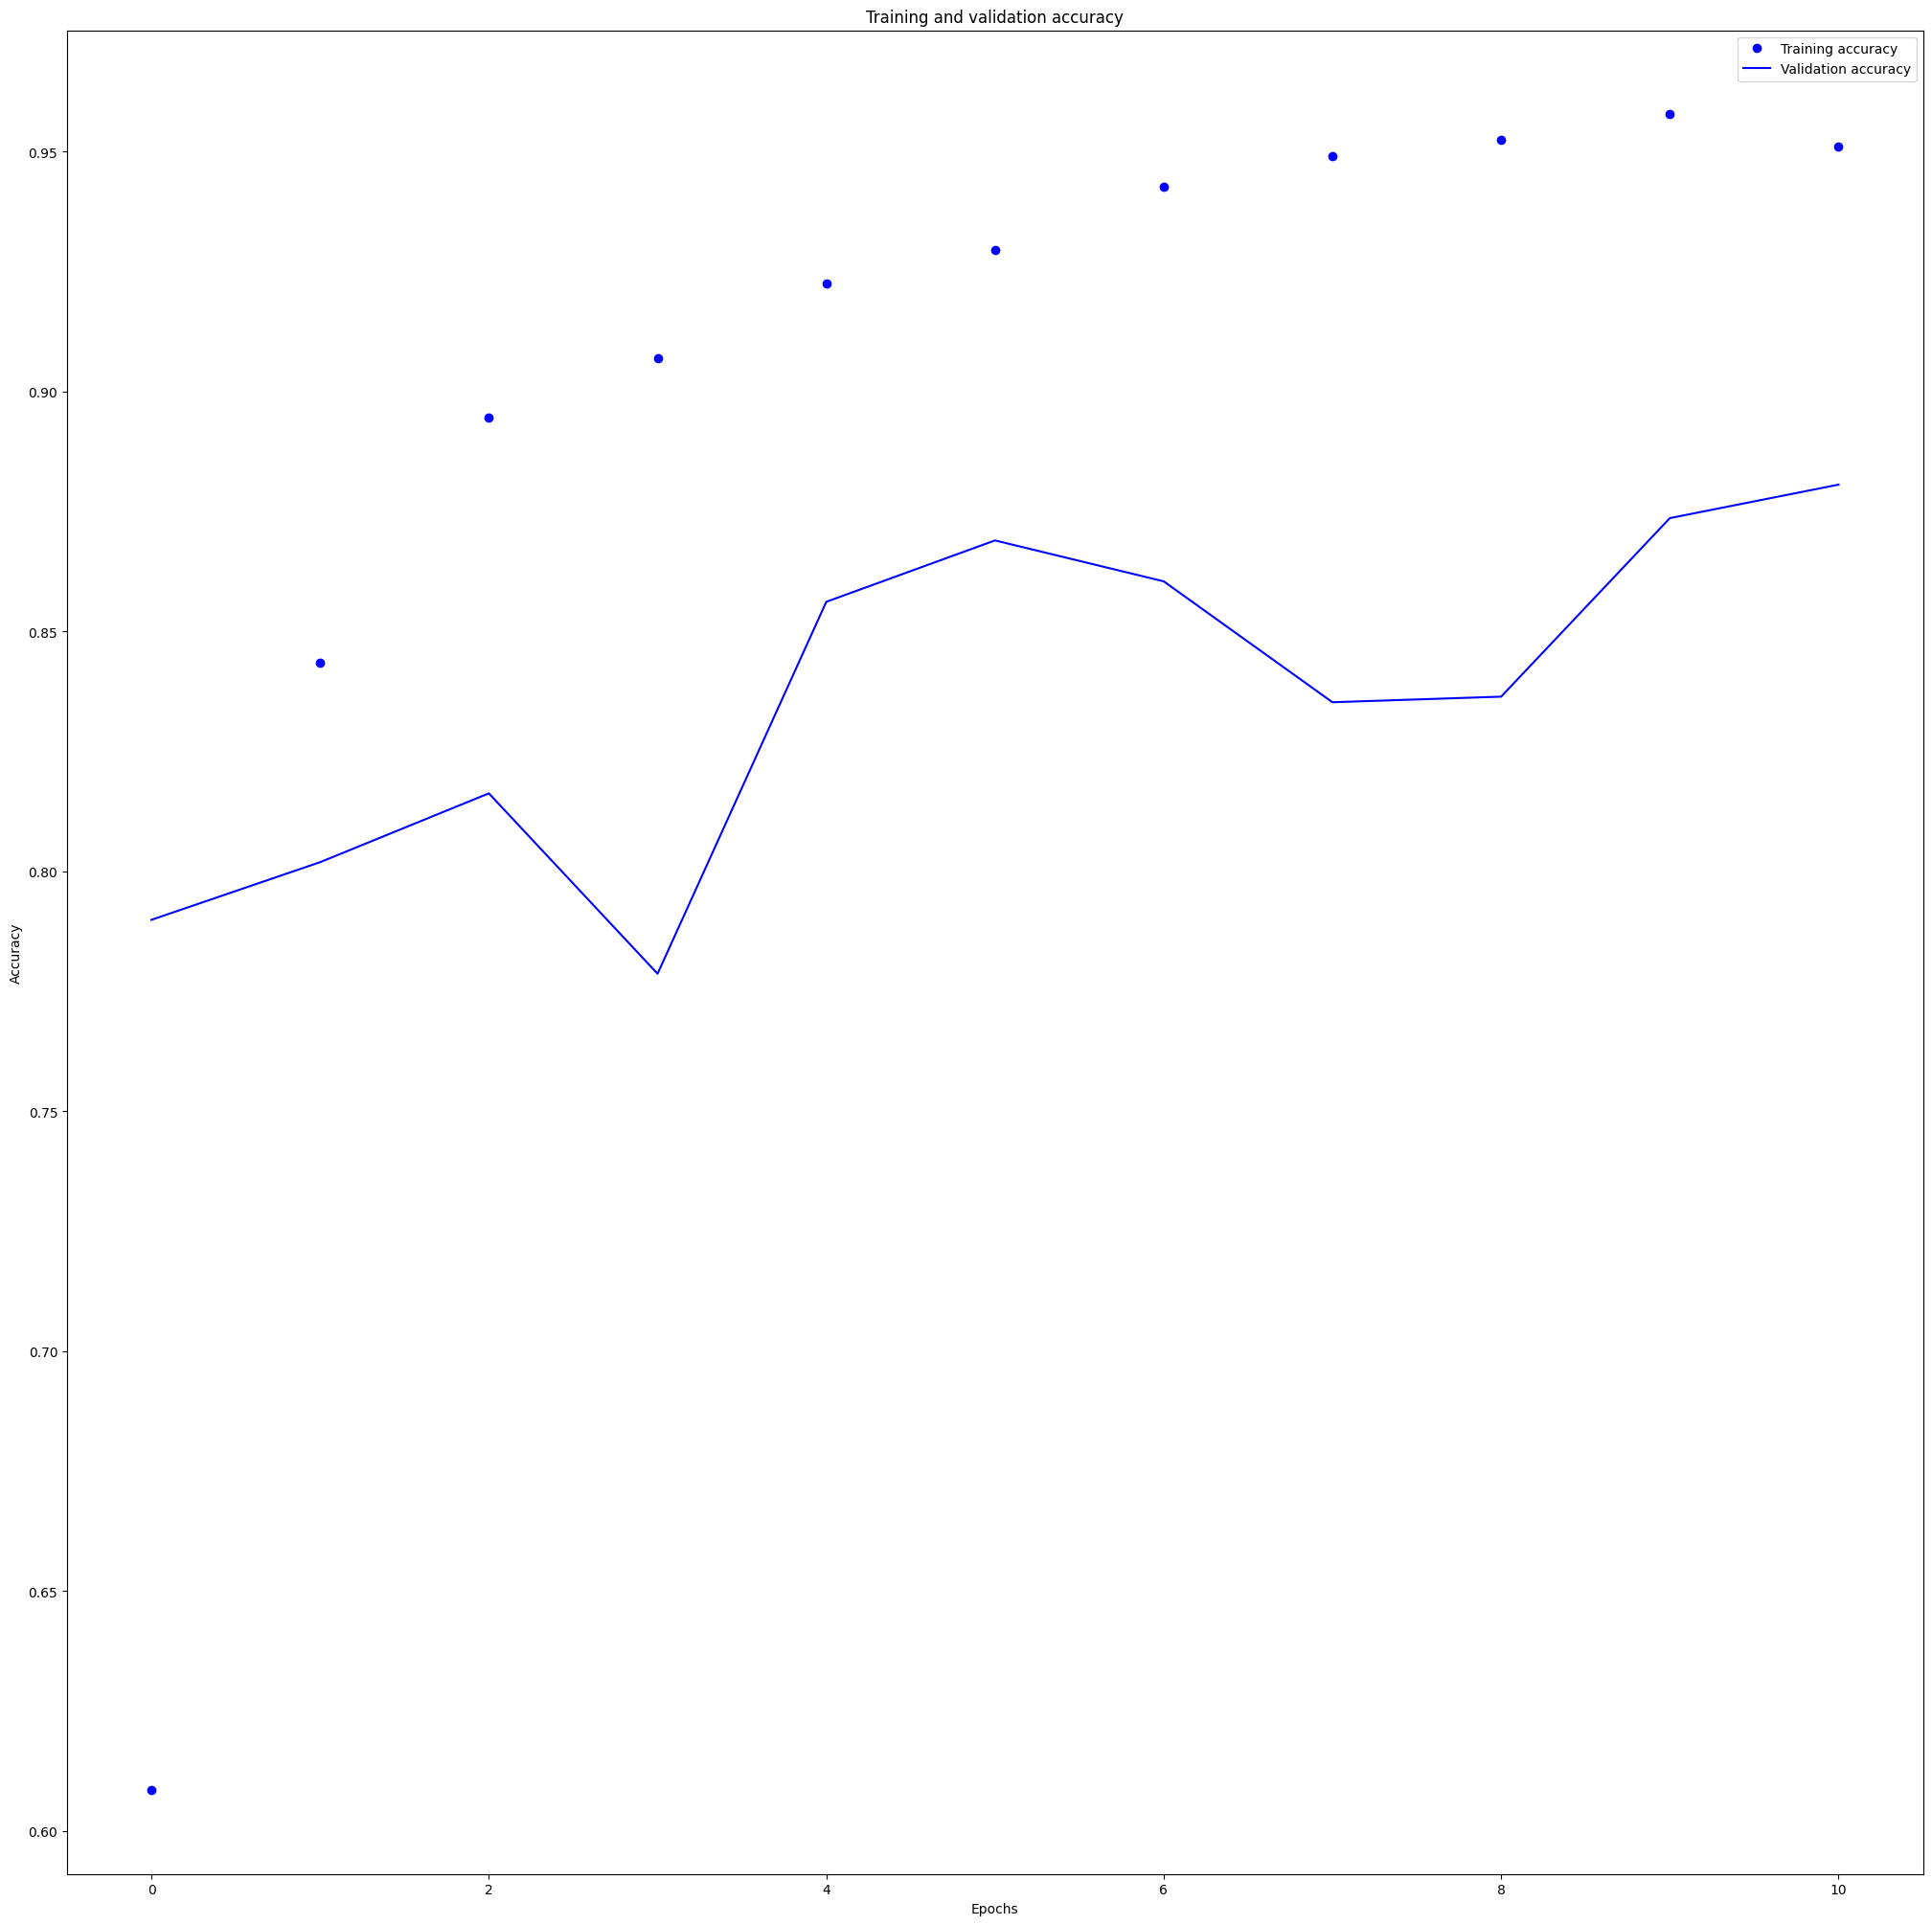

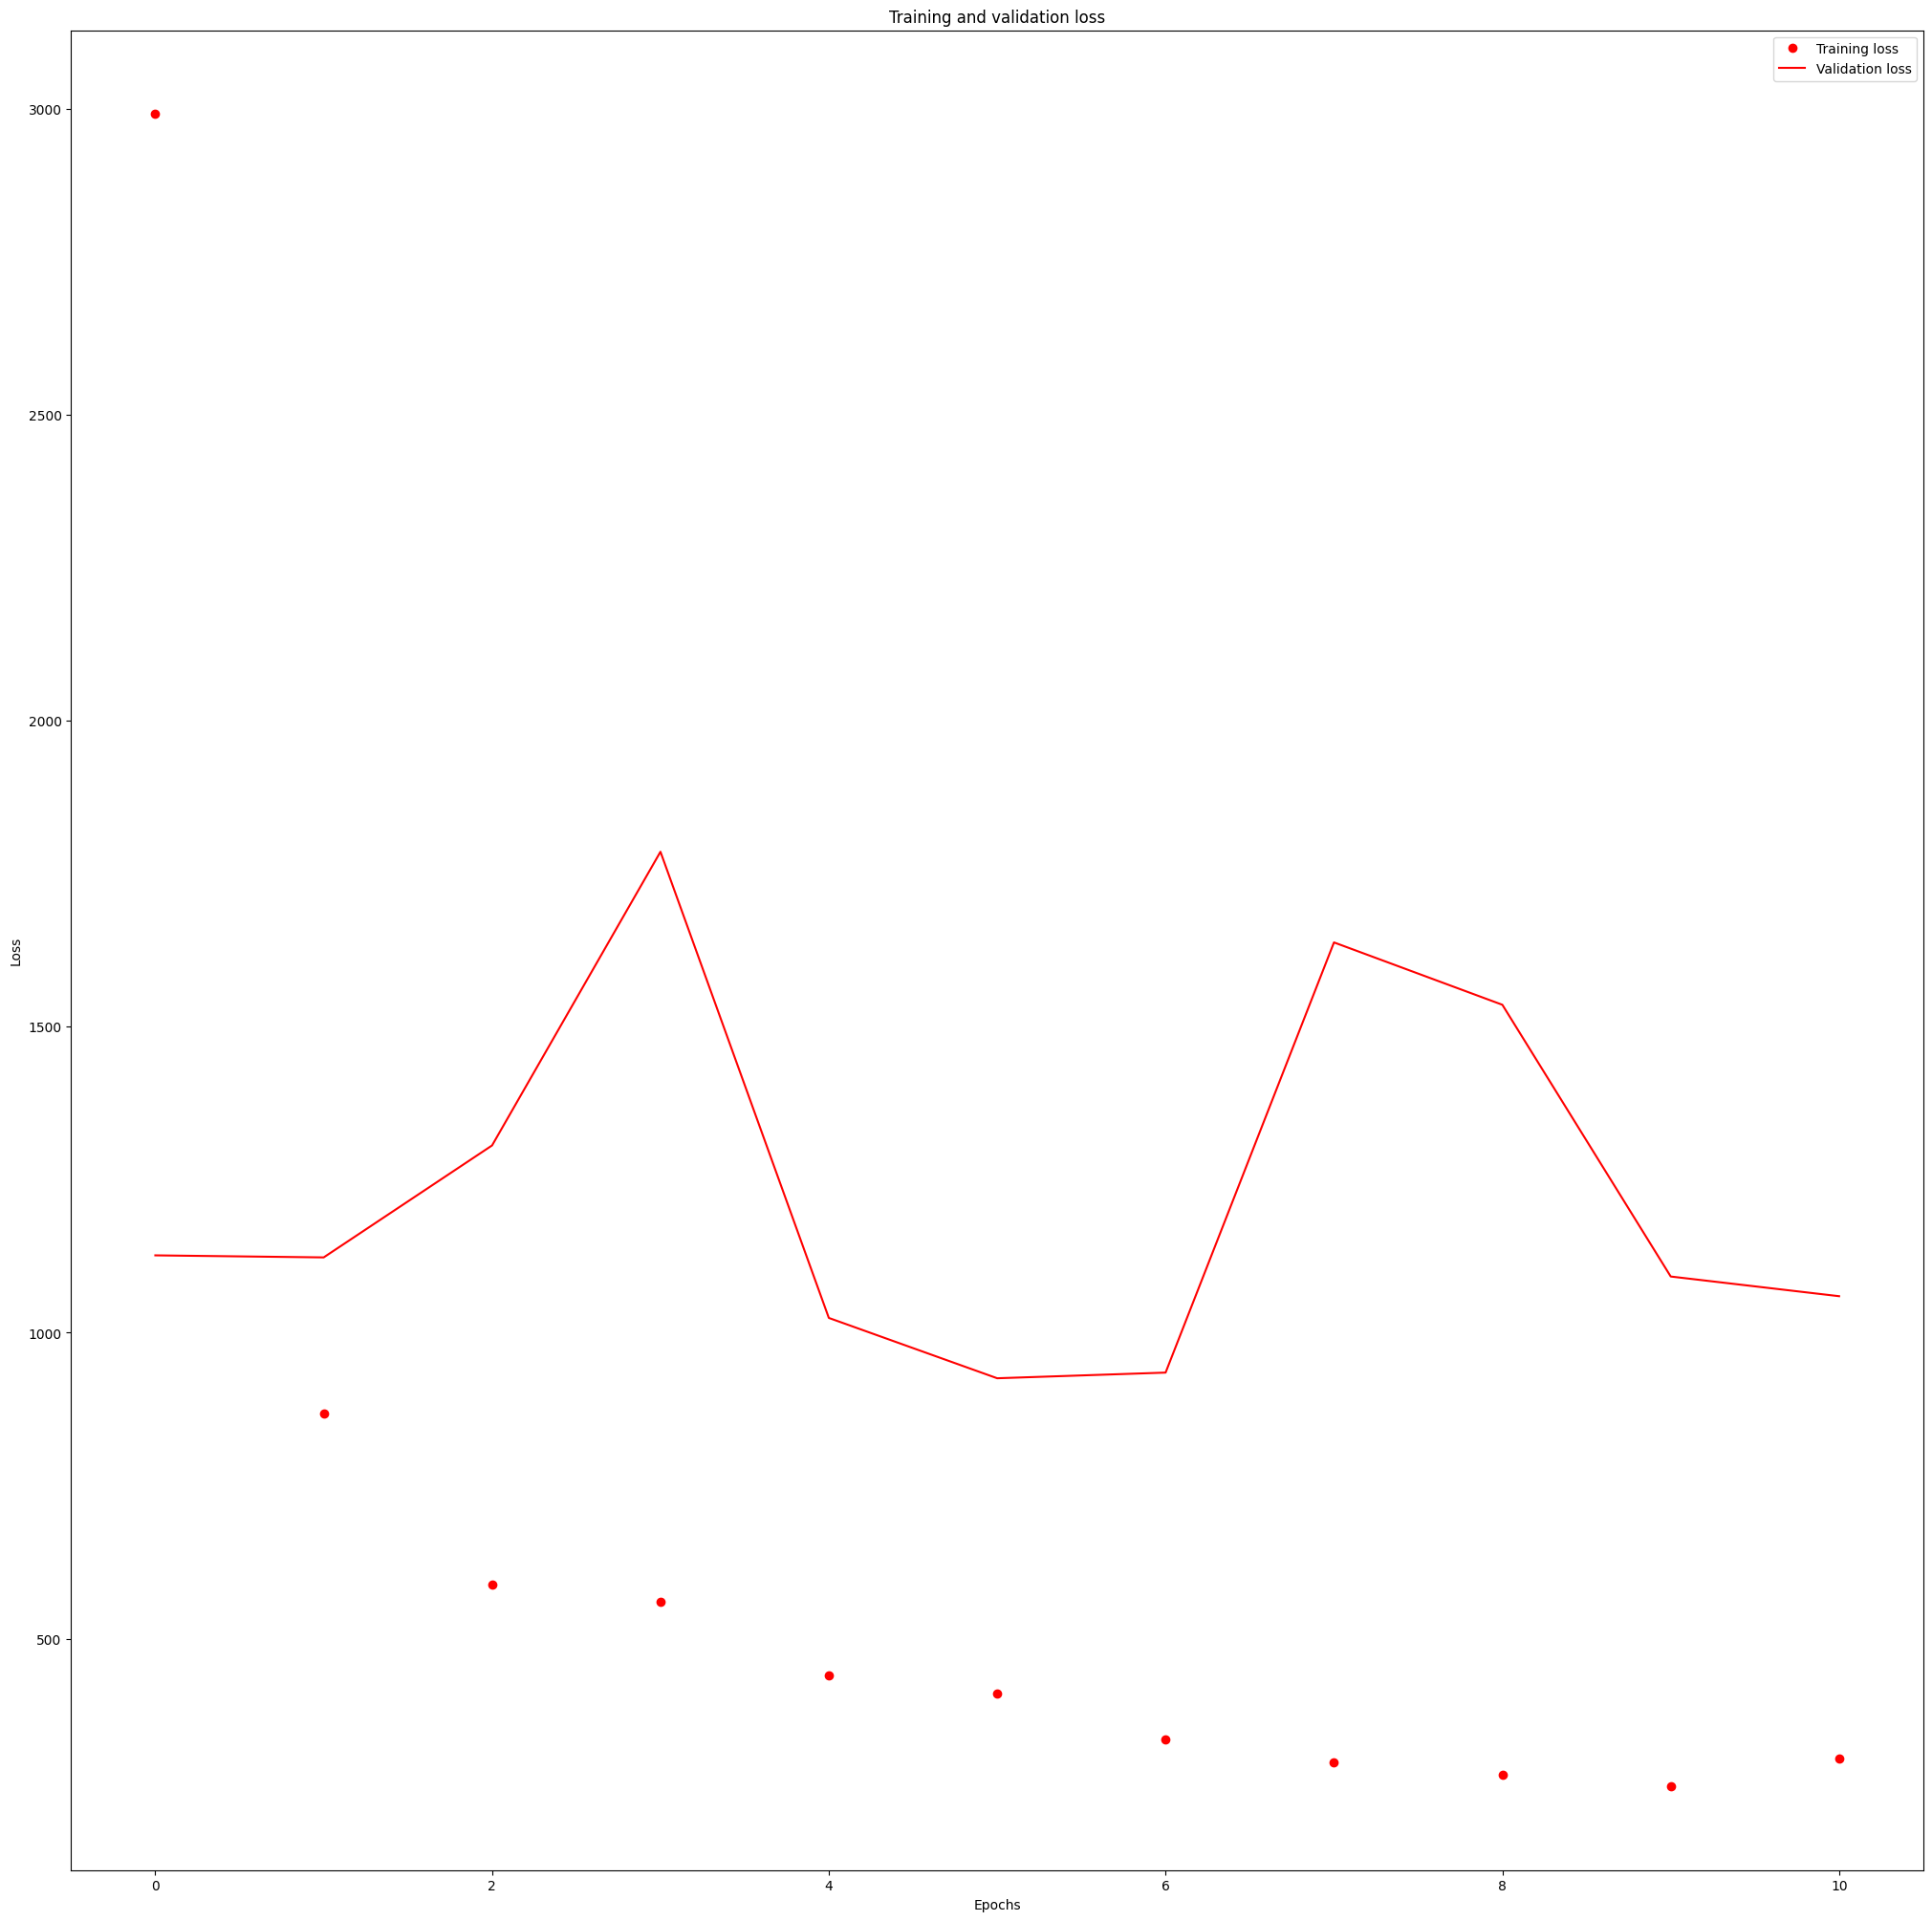

81/81 [==============================] - 1s 5ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.8966    0.4333    0.5843        60
           1     0.7170    0.6333    0.6726        60
           2     1.0000    0.9333    0.9655        60
           3     0.9831    0.9667    0.9748        60
           4     1.0000    1.0000    1.0000        60
           5     1.0000    1.0000    1.0000        60
           6     0.9833    0.9833    0.9833        60
           7     0.9836    1.0000    0.9917        60
           8     1.0000    0.9500    0.9744        60
           9     1.0000    0.9833    0.9916        60
          10     0.9298    0.8833    0.9060        60
          11     1.0000    0.4500    0.6207        60
          12     0.4522    0.8667    0.5943        60
          13     0.7733    0.9667    0.8593        60
          14     0.9344    0.9500    0.9421        60
          15     0.9649    0.9167    0.9402        60
    

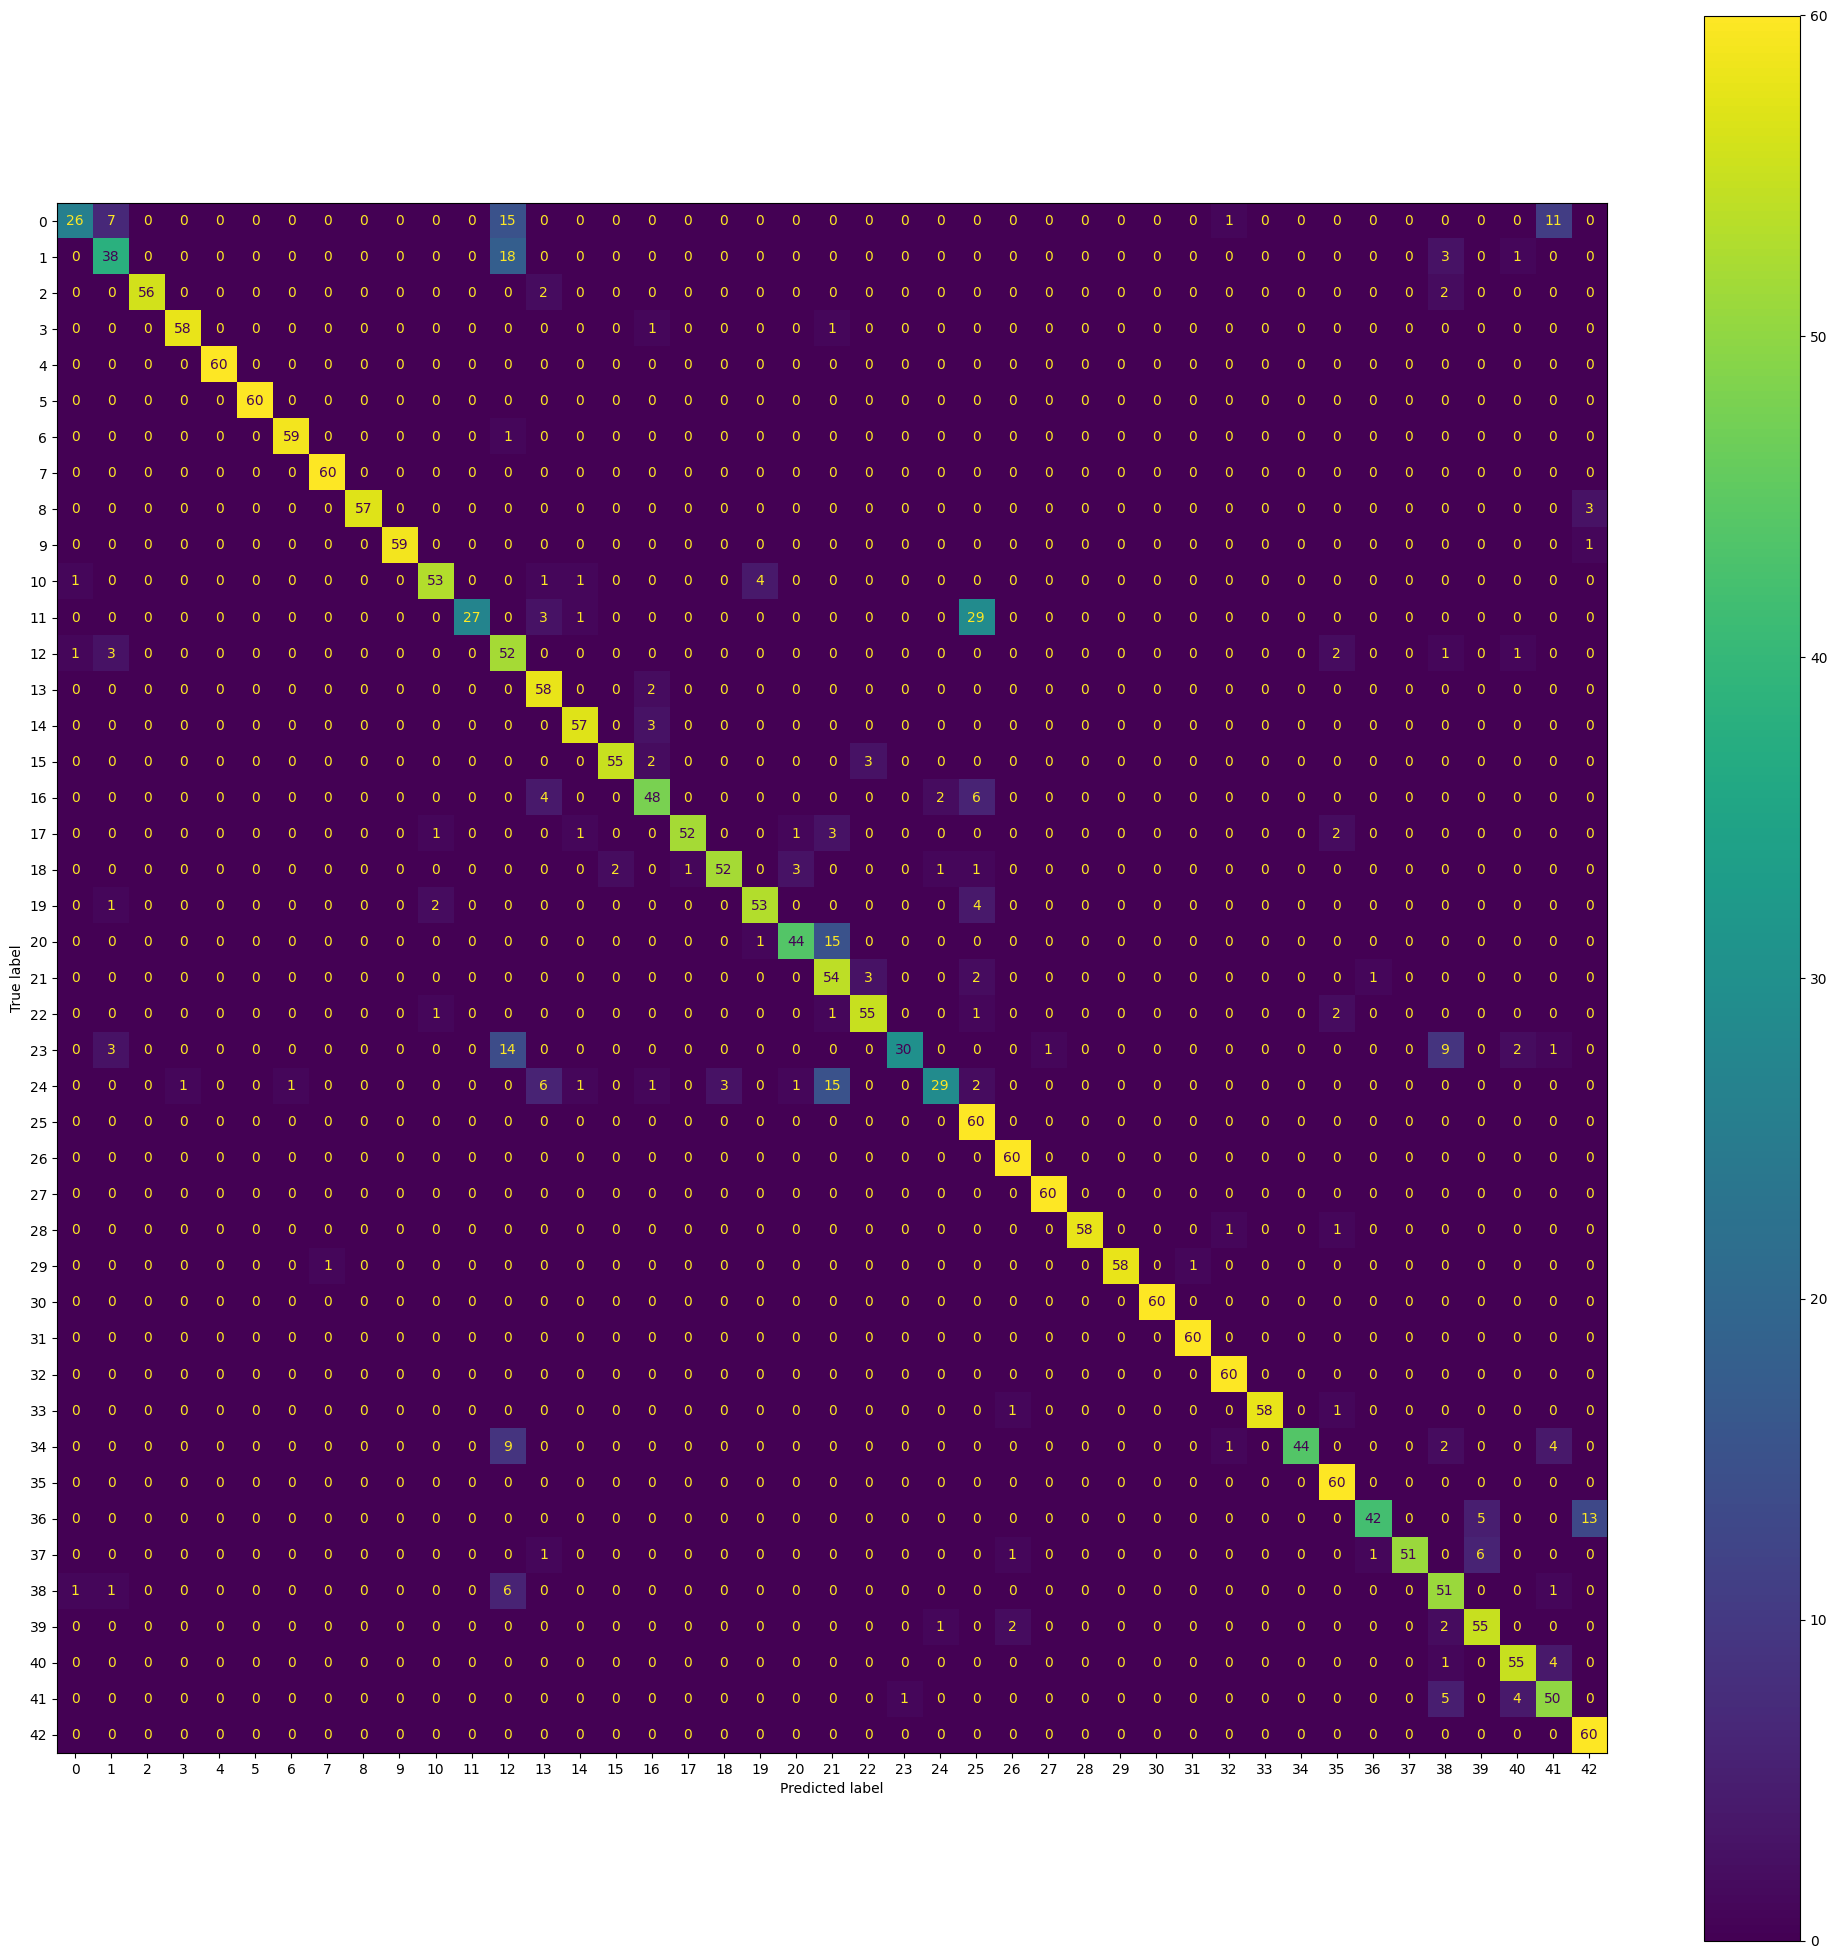

ROC Curve:


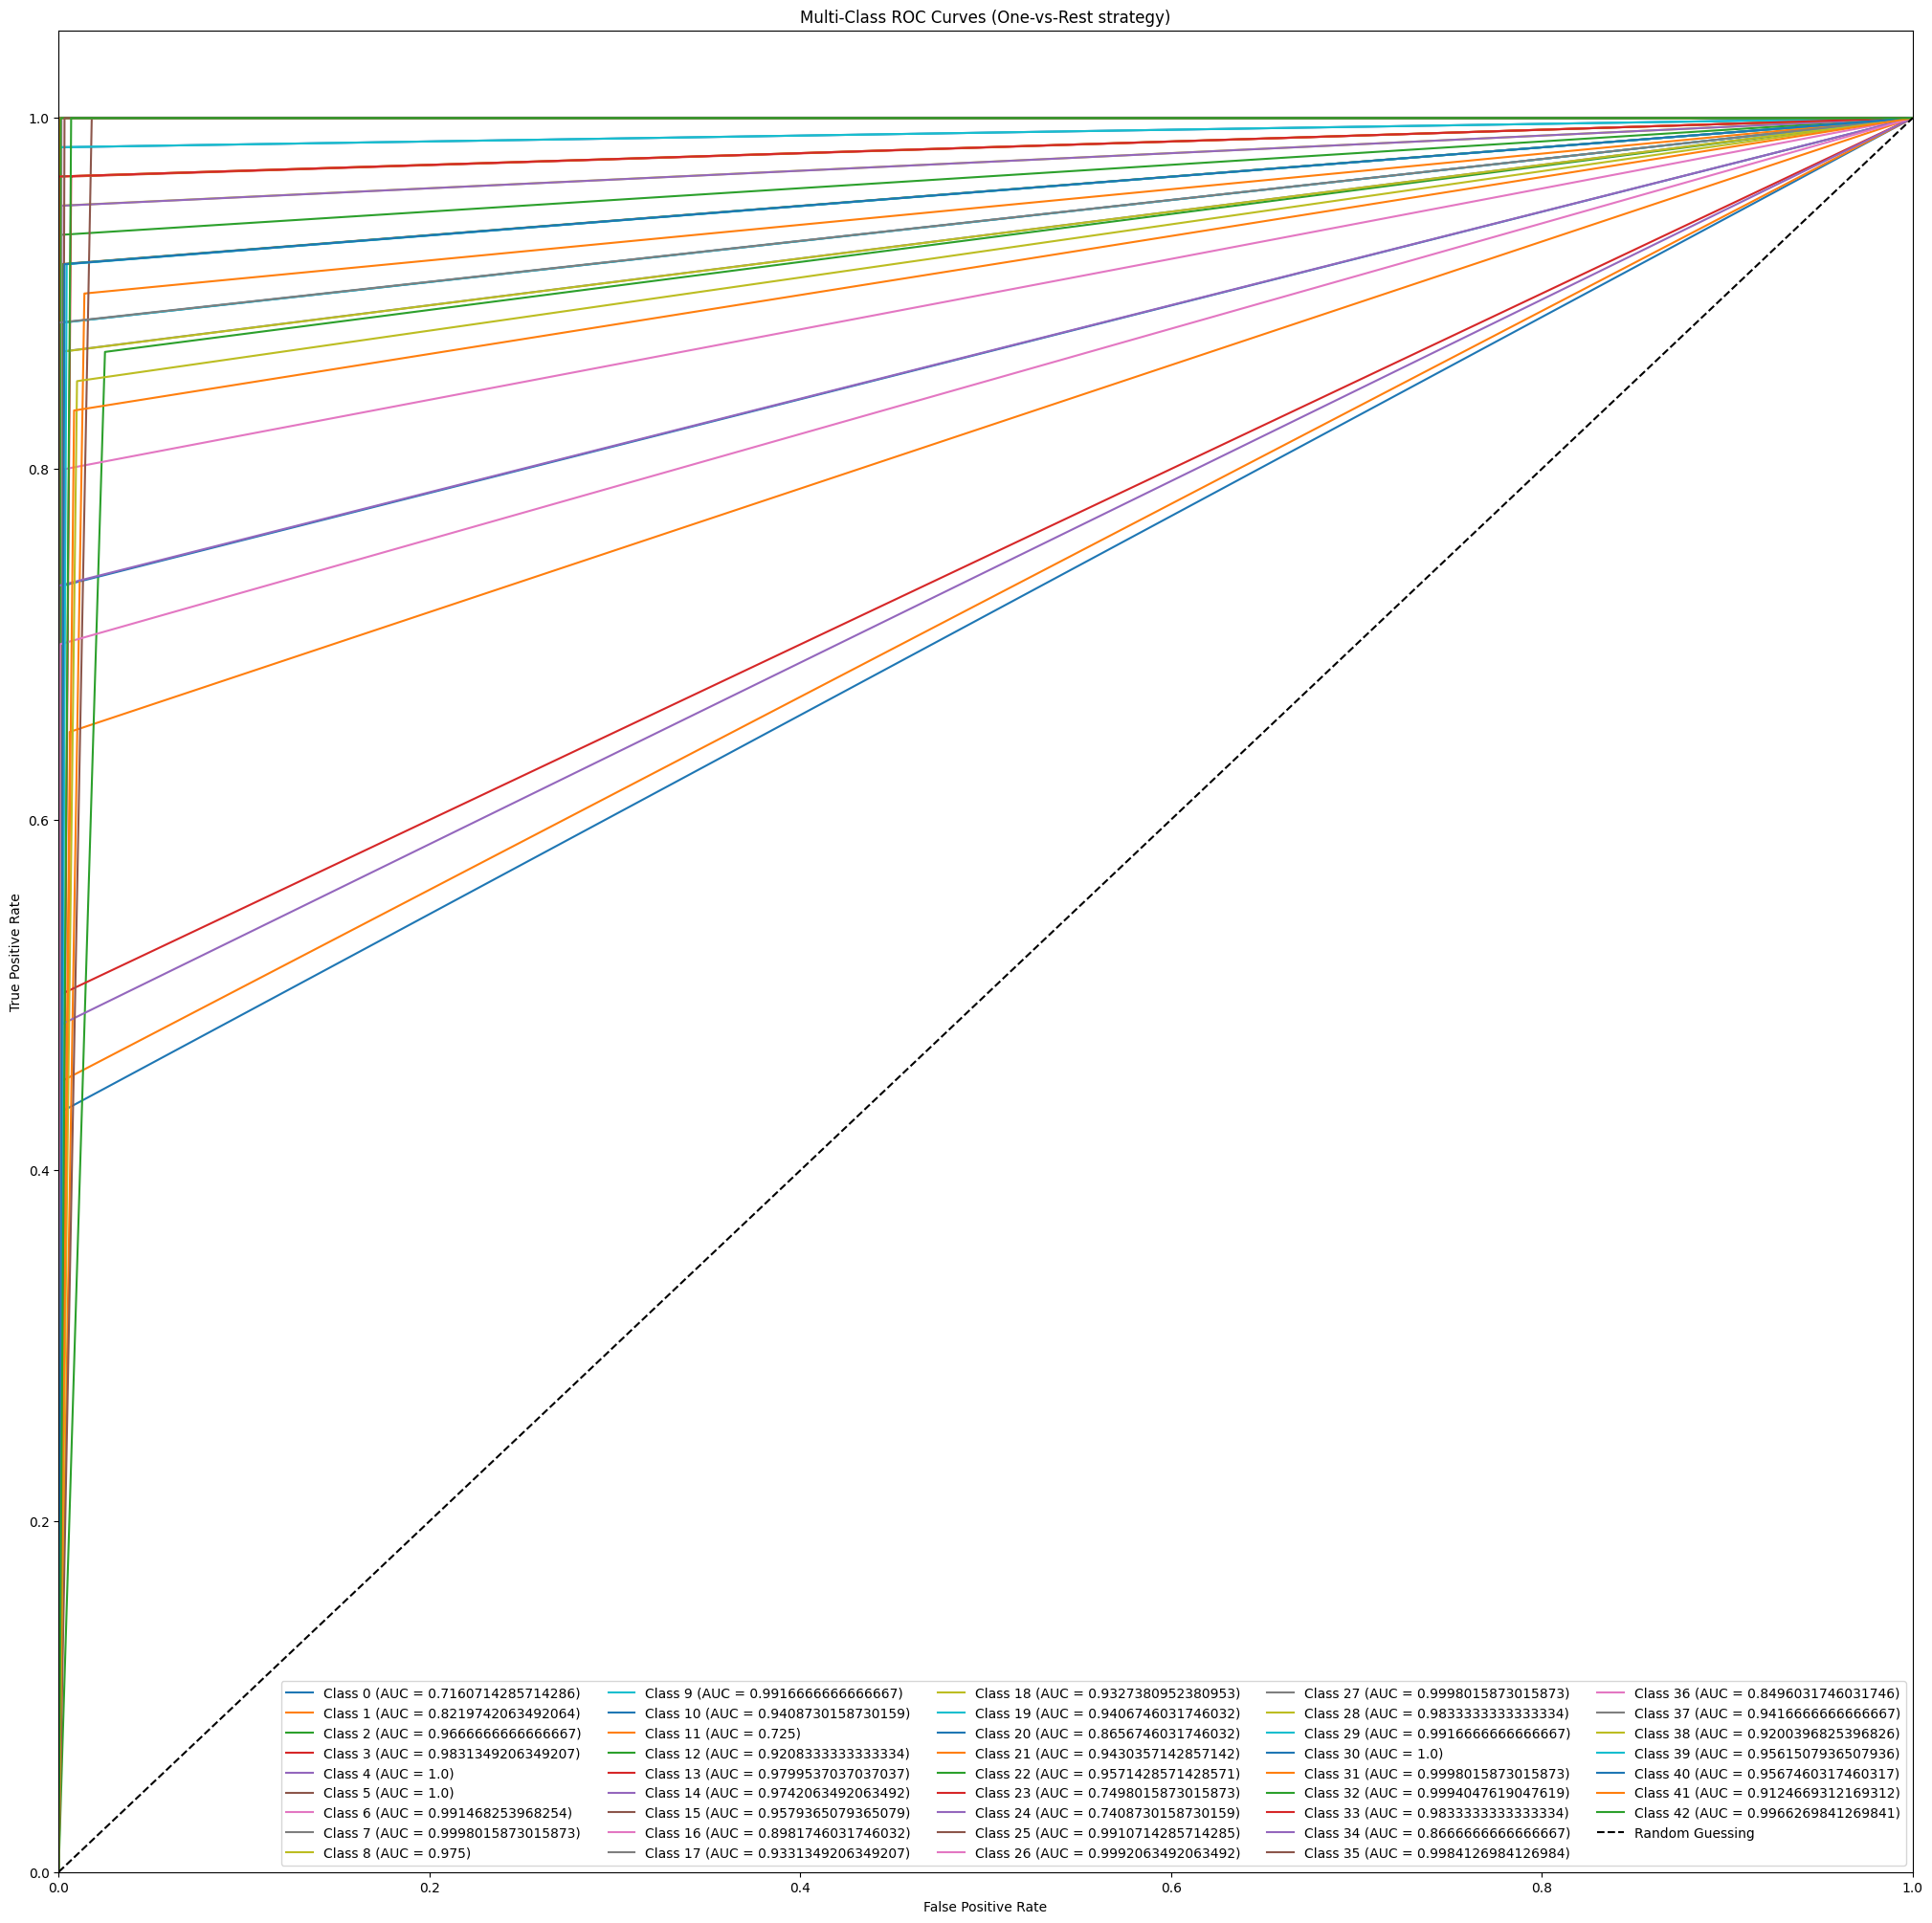

Test results - Loss: 708.1759643554688 - Accuracy: 0.8736433982849121%
Top-K (K = 3) accuracy score: 0.8806201550387597


In [ ]:
train_dir = os.path.join(WORK_DIR,"Train")
validation_dir = os.path.join(WORK_DIR,"Validation")
test_dir = os.path.join(WORK_DIR,"Test")

train, validation, test = load_datasets(train_dir, validation_dir, test_dir)
result = compile_and_fit(model_vgg_feature_block3, train, validation)
train_performance(result)
test_evaluation(model_vgg_feature_block3, test)

Thanks to the use of features extracted from 'block3_pool', the model achieves an accuracy of around 87.4% and a Top-K score (K=3) of around 0.881. The model was trained for 11 epochs, after which the early stopping mechanism was activated for overfitting. This result shows the effectiveness of intuition, greatly increasing the performance obtained. The instability of the network should be highlighted.

**6) Model 6 with feature extracted from block2_pool of VGG16**

In an attempt to increase the learning capabilities of the network, VGG16 features are now extracted from layers prior to the last one. The network presents a different structure compared to those previously observed (when we used "all" VGG16) to obtain a network capable of learning and limiting overfitting if possible. For this last objective, the network is also equipped with dropout and L2-Regularization.

Let's extract the interested features:

In [ ]:
vgg_ft_extraction_block2 = models.Model(inputs = conv_base.input, outputs = conv_base.get_layer('block2_pool').output)
vgg_ft_extraction_block2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [ ]:
inputs = keras.Input(shape=PRETRAINED_INPUT_SHAPE)
x = keras.applications.vgg16.preprocess_input(inputs)

# Feature extraction
x = vgg_ft_extraction_block2(x)

x = layers.Flatten()(x)

x = layers.Dropout(0.5)(x)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.01)) (x)

x = layers.Dropout(0.3)(x)
outputs = layers.Dense(43, activation="softmax")(x)

model_vgg_feature_block2 = keras.Model(inputs, outputs, name="Model_VGG16_feature_block2")
show_and_save_model_summary(model_vgg_feature_block2)

Model: "Model_VGG16_feature_block2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 tf.__operators__.getitem_1  (None, 48, 48, 3)         0         
 4 (SlicingOpLambda)                                             
                                                                 
 tf.nn.bias_add_14 (TFOpLam  (None, 48, 48, 3)         0         
 bda)                                                            
                                                                 
 model_2 (Functional)        (None, 12, 12, 128)       260160    
                                                                 
 flatten_14 (Flatten)        (None, 18432)             0         
                                                                 
 dropout_28 (Dropout)        (None, 1843

Load the dataset, train the model and evaluate it

Found 6450 files belonging to 43 classes.
Found 2580 files belonging to 43 classes.
Found 2580 files belonging to 43 classes.
Epoch 1/30
200/202 [============================>.] - ETA: 0s - loss: 596.7738 - accuracy: 0.9439
Epoch 1: val_loss improved from inf to 2780.30542, saving model to /content/drive/Shareddrives/Biondi/Models/Model_VGG16_feature_block2.h5
202/202 [==============================] - 4s 16ms/step - loss: 600.5901 - accuracy: 0.9434 - val_loss: 2780.3054 - val_accuracy: 0.8093
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


202/202 [==============================] - ETA: 0s - loss: 552.1145 - accuracy: 0.9476
Epoch 2: val_loss improved from 2780.30542 to 2147.98926, saving model to /content/drive/Shareddrives/Biondi/Models/Model_VGG16_feature_block2.h5
202/202 [==============================] - 3s 14ms/step - loss: 552.1145 - accuracy: 0.9476 - val_loss: 2147.9893 - val_accuracy: 0.8624
Epoch 3/30
201/202 [============================>.] - ETA: 0s - loss: 600.4063 - accuracy: 0.9554
Epoch 3: val_loss improved from 2147.98926 to 1727.60559, saving model to /content/drive/Shareddrives/Biondi/Models/Model_VGG16_feature_block2.h5
202/202 [==============================] - 3s 17ms/step - loss: 598.7974 - accuracy: 0.9555 - val_loss: 1727.6056 - val_accuracy: 0.8884
Epoch 4/30
198/202 [============================>.] - ETA: 0s - loss: 397.5152 - accuracy: 0.9646
Epoch 4: val_loss did not improve from 1727.60559
202/202 [==============================] - 4s 21ms/step - loss: 400.4509 - accuracy: 0.9645 - val_los

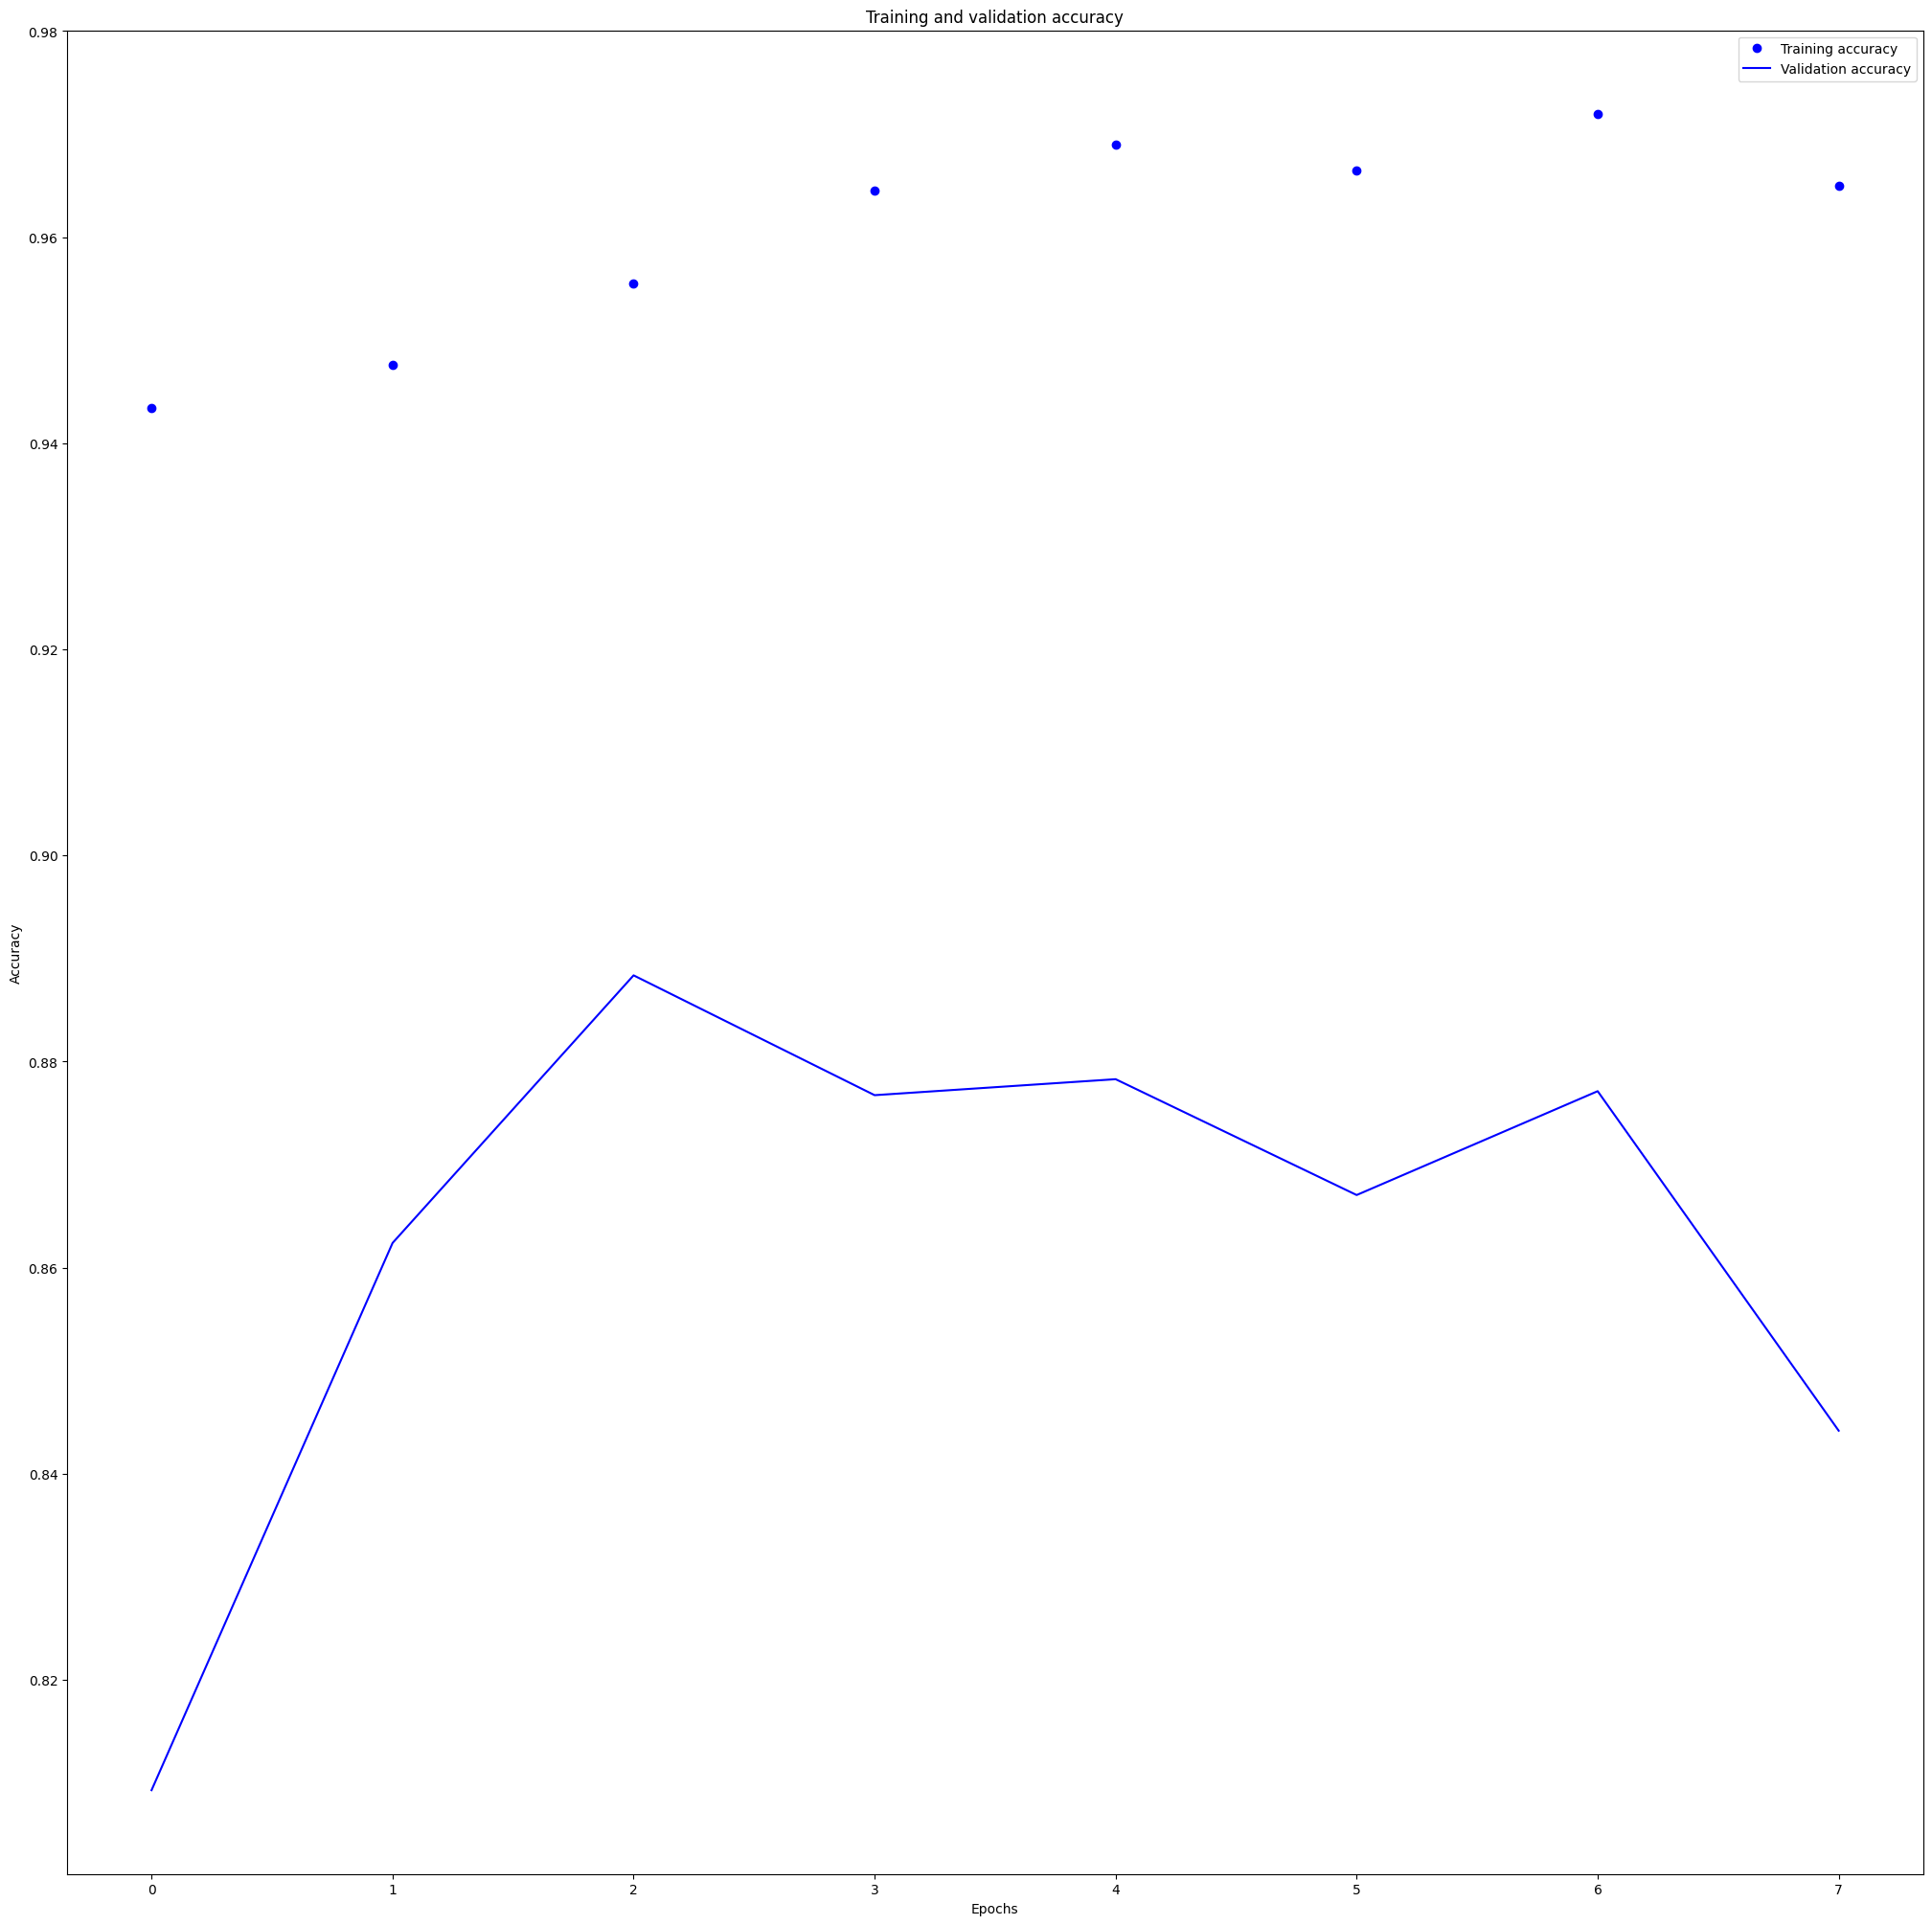

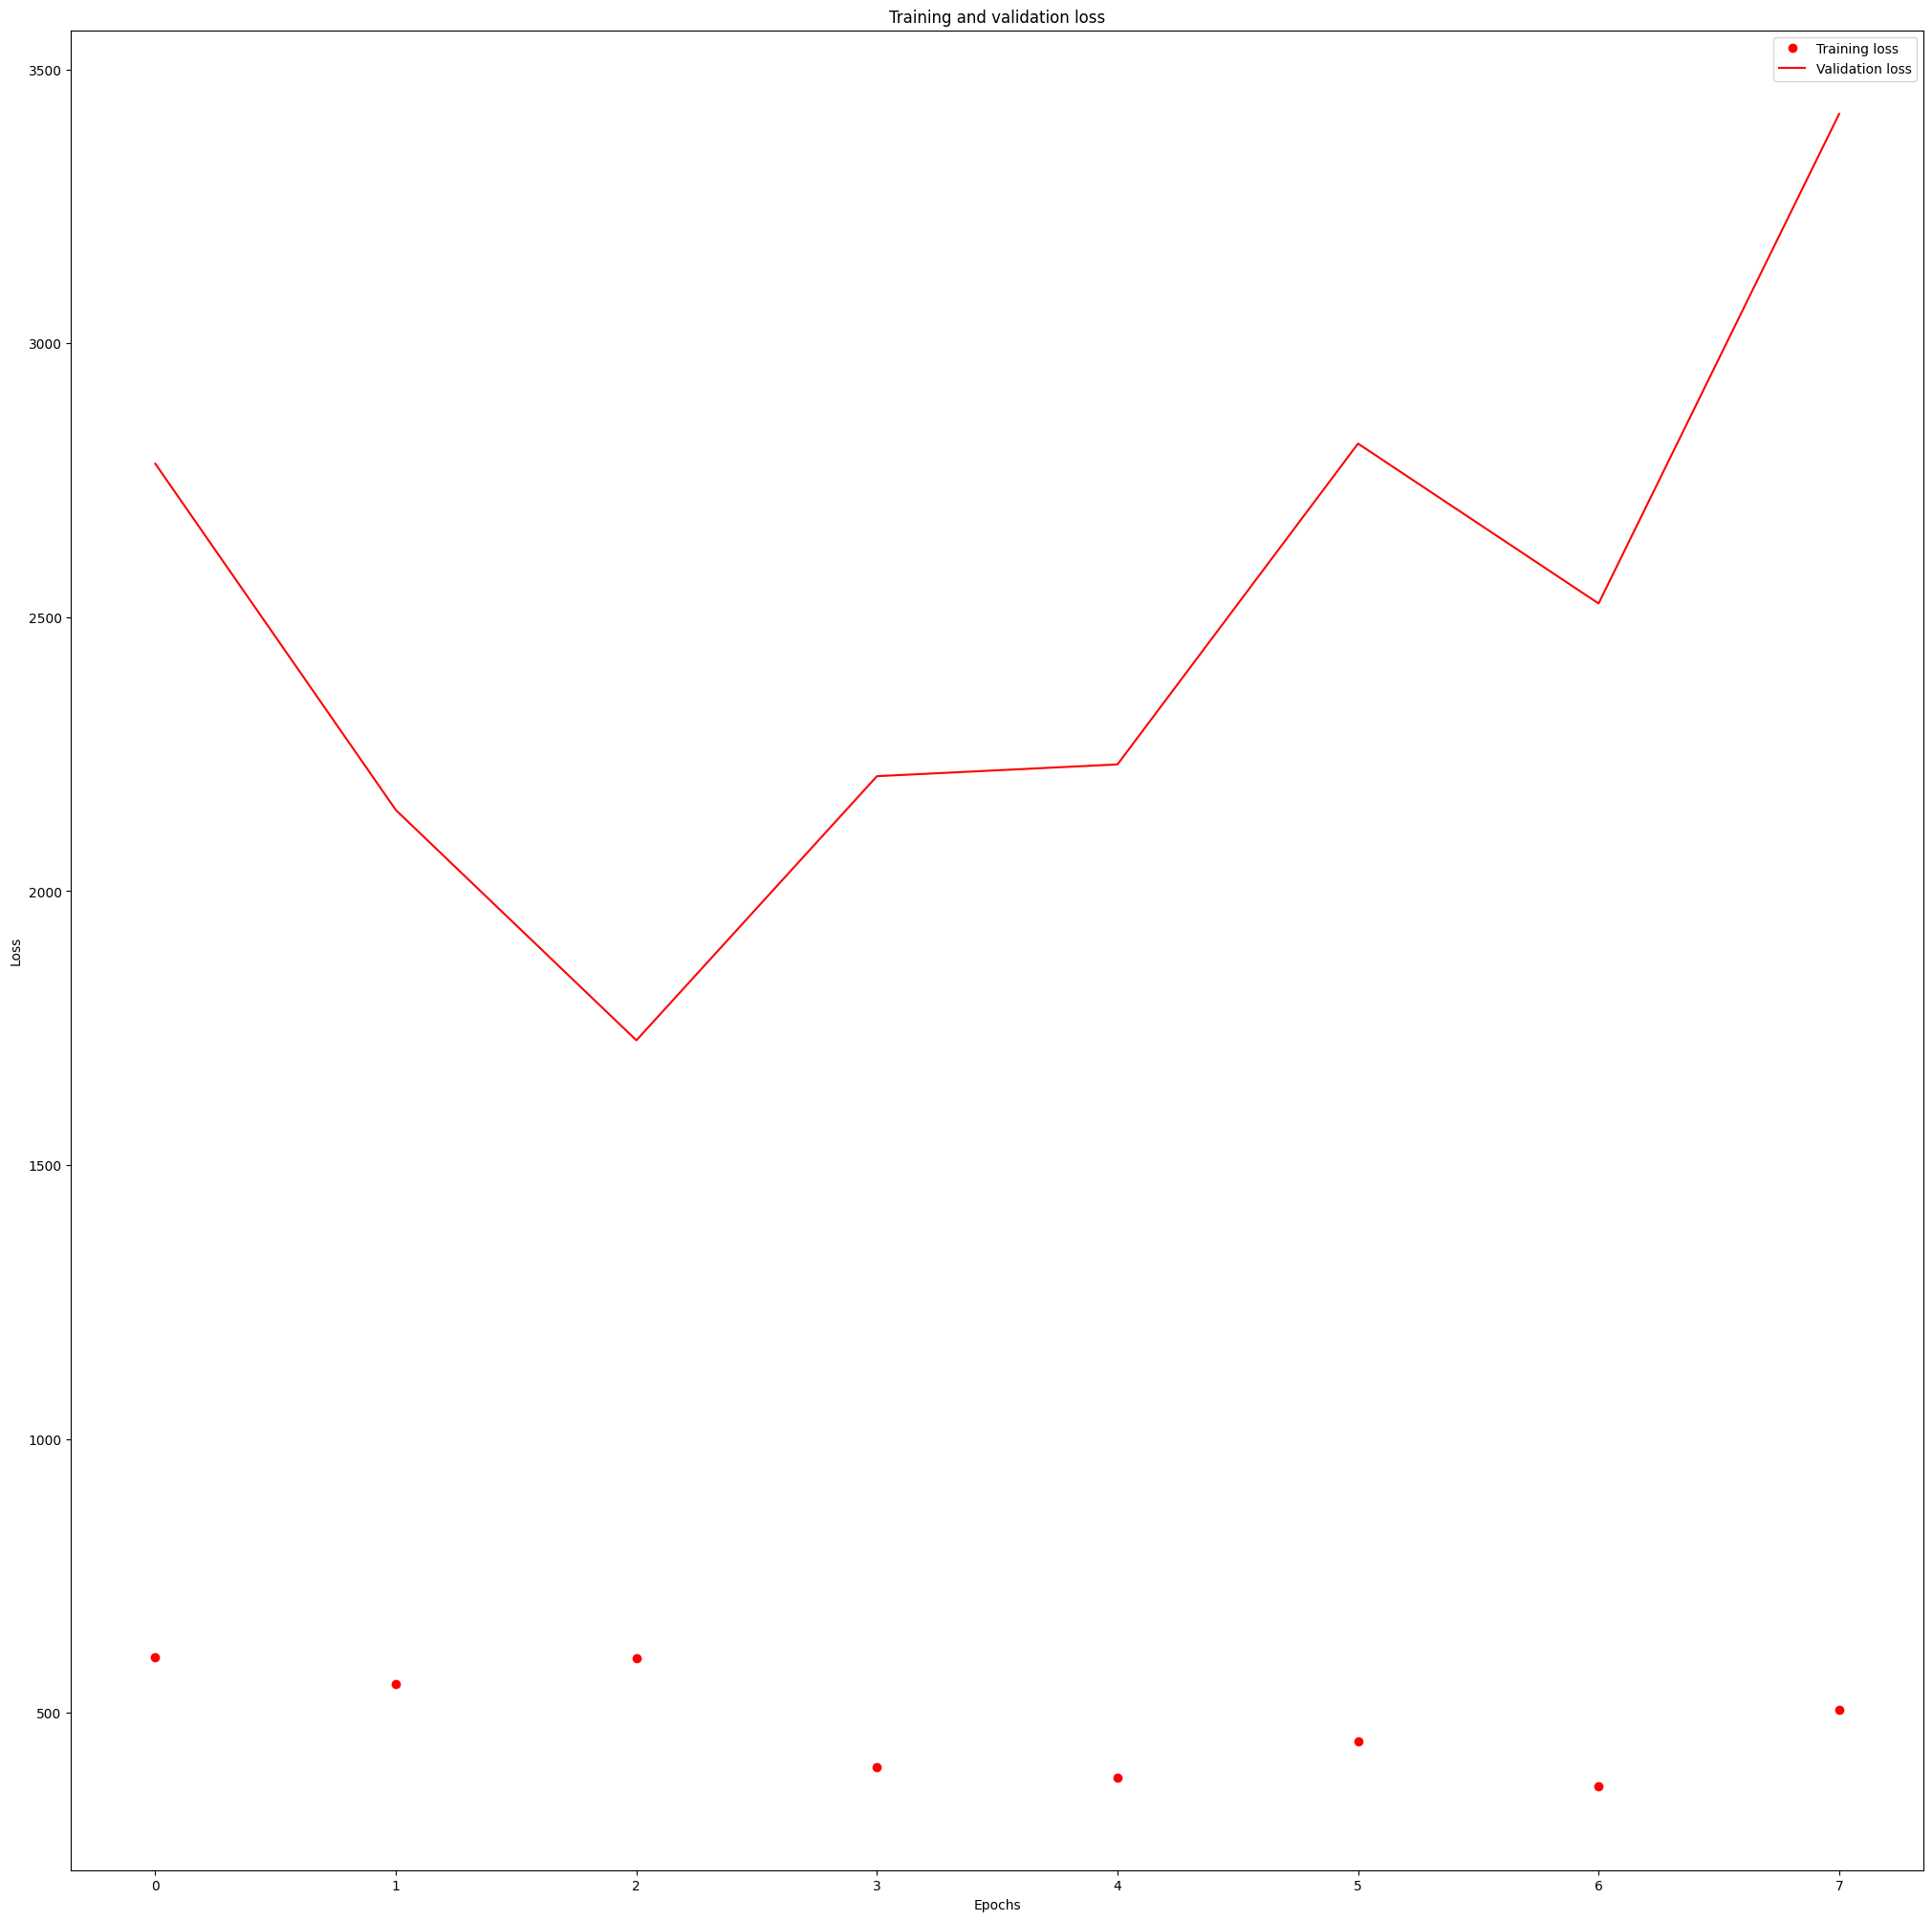

81/81 [==============================] - 0s 4ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.8909    0.8167    0.8522        60
           1     0.7945    0.9667    0.8722        60
           2     0.8955    1.0000    0.9449        60
           3     0.6622    0.8167    0.7313        60
           4     1.0000    1.0000    1.0000        60
           5     0.9836    1.0000    0.9917        60
           6     1.0000    1.0000    1.0000        60
           7     1.0000    0.9667    0.9831        60
           8     1.0000    0.9333    0.9655        60
           9     1.0000    0.9333    0.9655        60
          10     1.0000    0.6333    0.7755        60
          11     0.8167    0.8167    0.8167        60
          12     0.9583    0.7667    0.8519        60
          13     0.9245    0.8167    0.8673        60
          14     0.5909    0.8667    0.7027        60
          15     0.6629    0.9833    0.7919        60
    

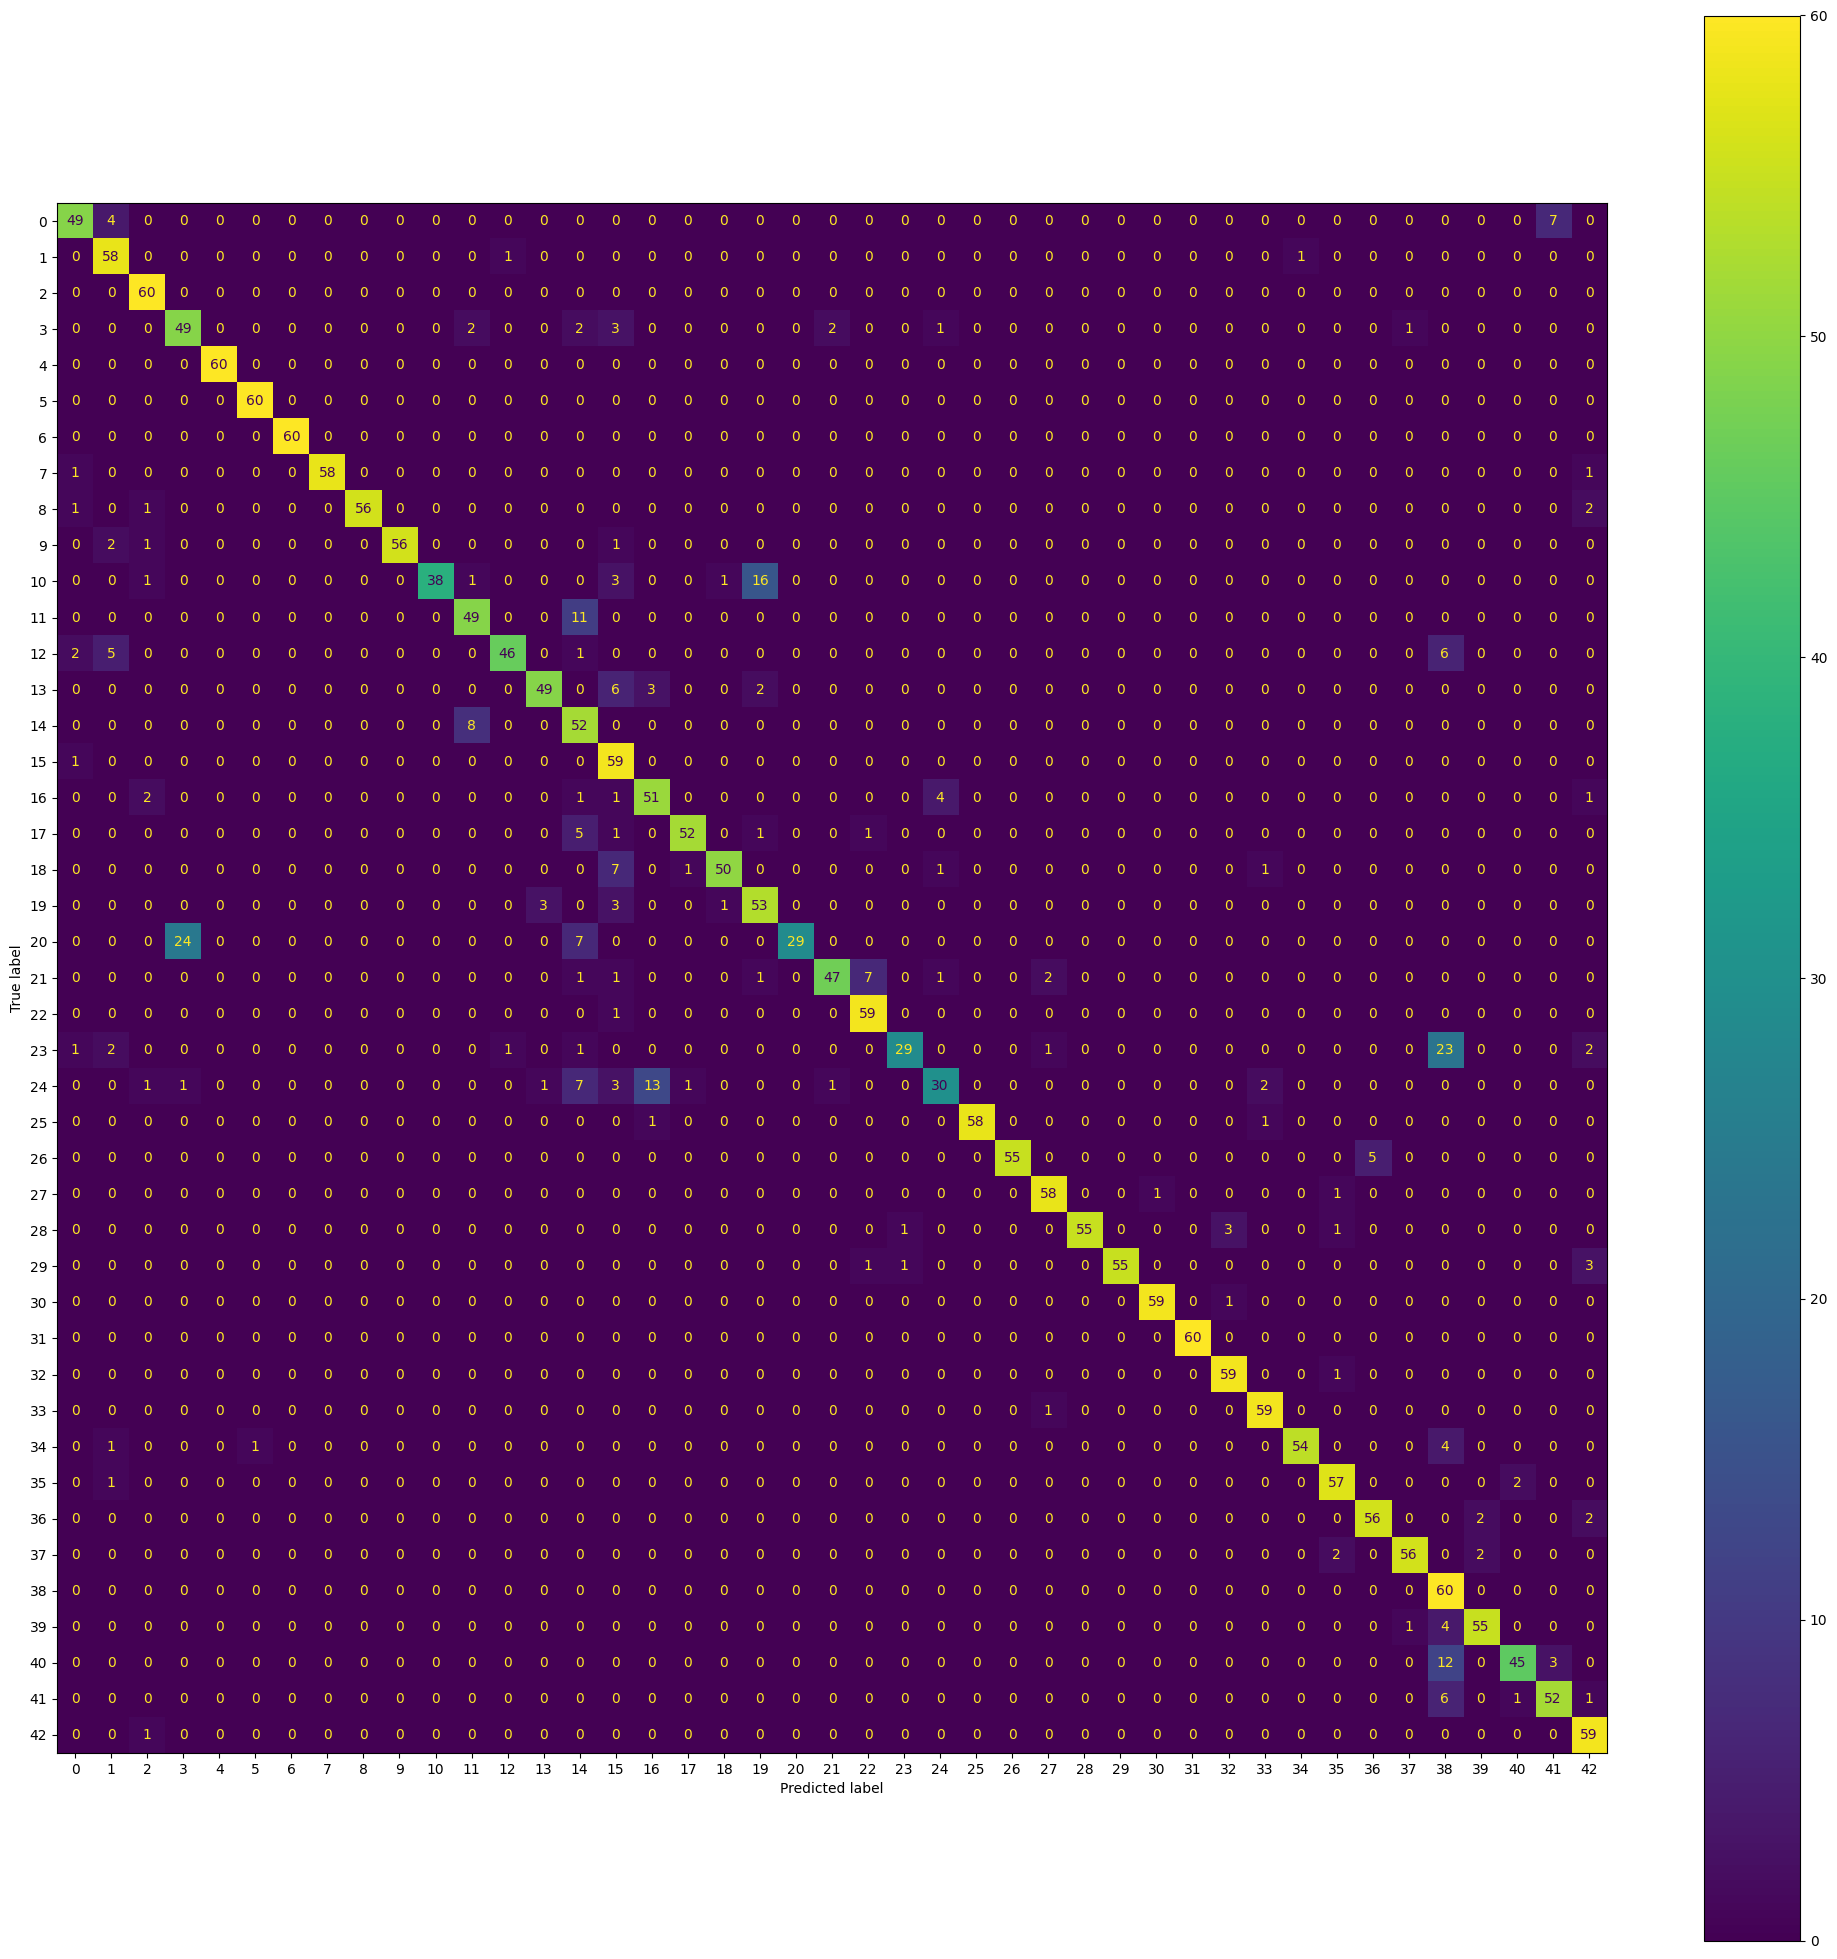

ROC Curve:


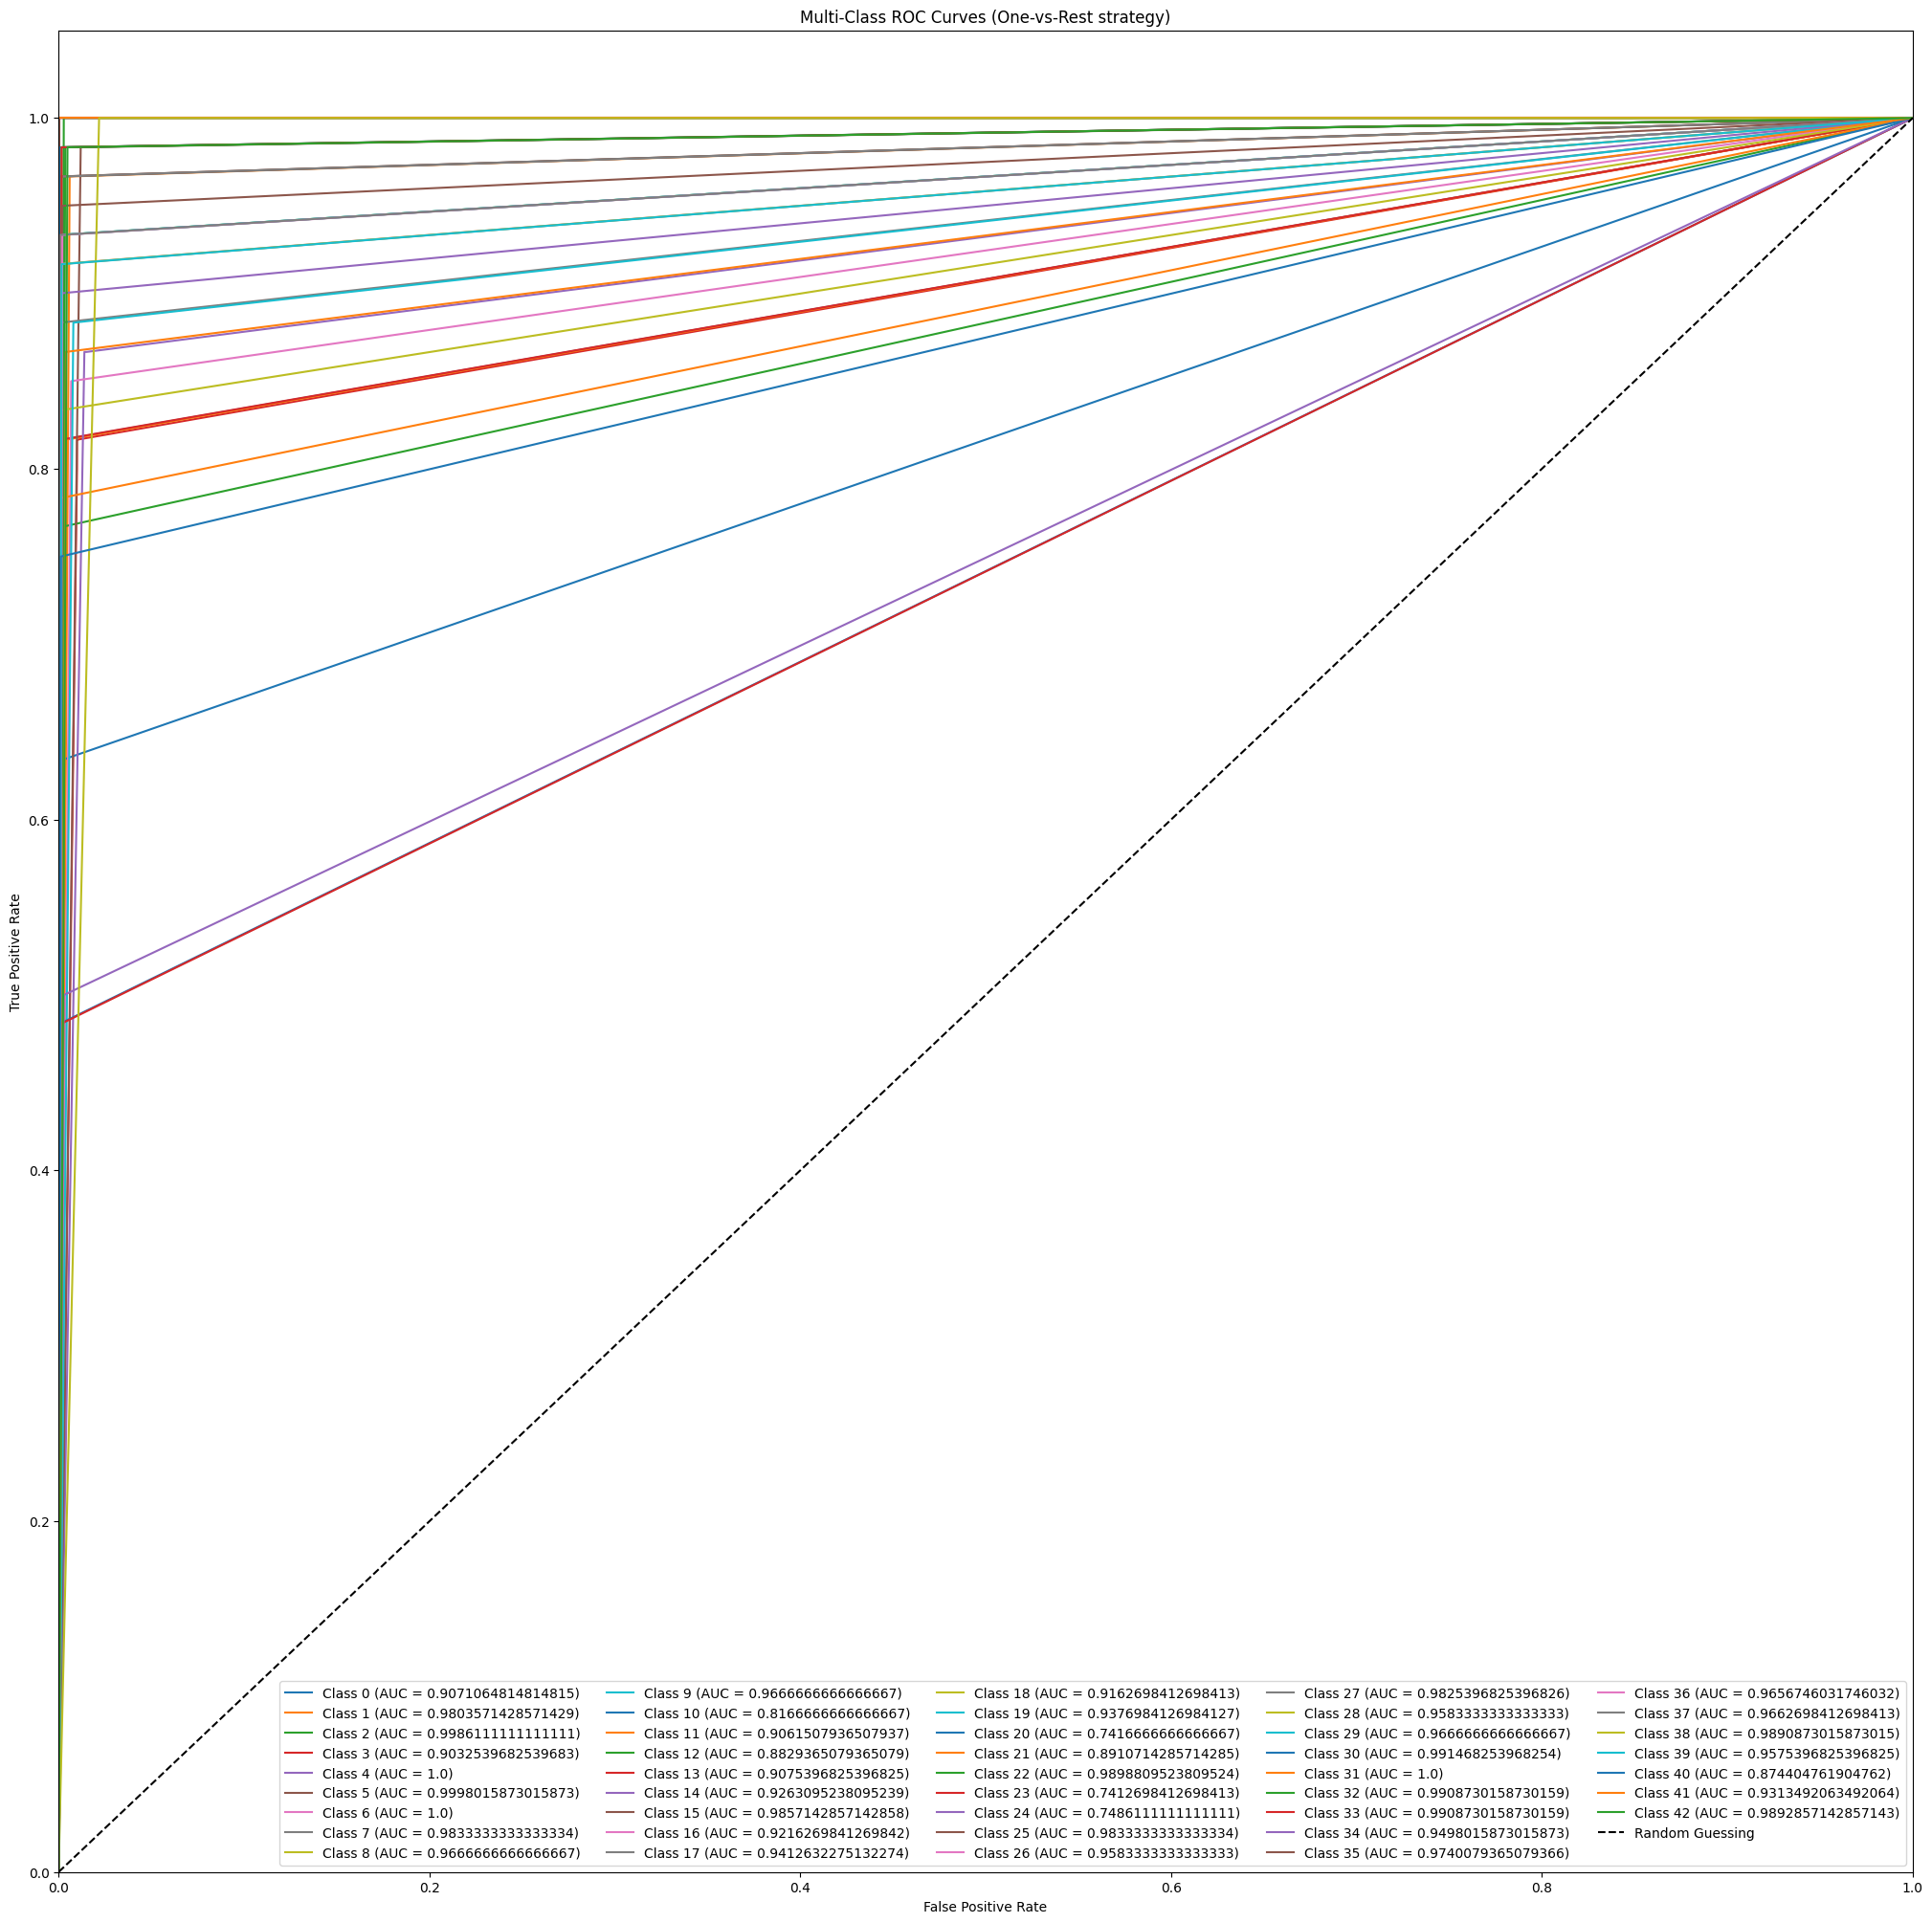

Test results - Loss: 1937.6002197265625 - Accuracy: 0.880232572555542%
Top-K (K = 3) accuracy score: 0.8856589147286822


In [ ]:
train_dir = os.path.join(WORK_DIR,"Train")
validation_dir = os.path.join(WORK_DIR,"Validation")
test_dir = os.path.join(WORK_DIR,"Test")

train, validation, test = load_datasets(train_dir, validation_dir, test_dir)
result = compile_and_fit(model_vgg_feature_block2, train, validation)
train_performance(result)
test_evaluation(model_vgg_feature_block2, test)

Thanks to the use of features extracted from 'block2_pool', the model achieves an accuracy of around 88% and a Top-K score (K=3) of around 0.886. The model was trained for 8 epochs, after which the early stopping mechanism was activated for overfitting. The instability of the network should be highlighted.

___